Importing the librabries


In [6]:
import os
import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset , DataLoader , random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

DATA

In [7]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

Creating the dataset to load the image

In [8]:
class SatelliteDataset(Dataset):
  def __init__(self,root_dir,transform=None):
    self.dataroot = "C:\\Users\\hp\\Downloads\\archive (5)\\landscape Images"
    self.images = os.listdir(f'{self.dataroot}/color')
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self , idx):
    img_path = self.images[idx]
    color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
    gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

    if self.transform:
      color_img = self.transform(color_img)
      gray_img = self.transform(gray_img)

    return color_img , gray_img

Applying the transformation , loading datasets and spliting it to training and testing set

In [9]:
transform = transforms.Compose([transforms.Resize((150 , 150) , antialias = False)])
dataset = SatelliteDataset(root_dir= "." , transform = transform)

train_set , test_set = random_split(dataset , [0.8 , 0.2] , generator = torch.Generator().manual_seed(MANUAL_SEED))

trainloader = DataLoader(train_set , batch_size = BATCH_SIZE , shuffle = SHUFFLE)
testloader = DataLoader(test_set , batch_size = BATCH_SIZE , shuffle = SHUFFLE)

Visualizing some images


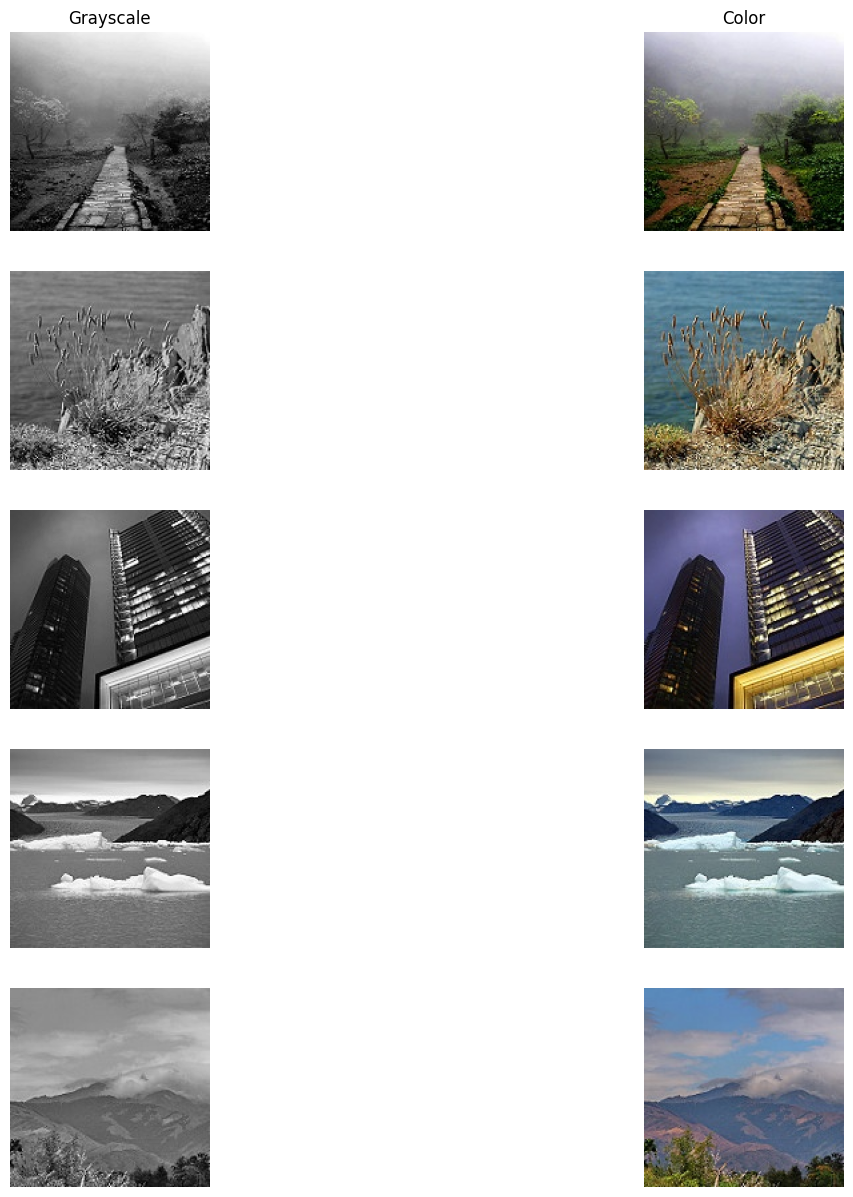

In [10]:
def show_images(color , gray):
  fig , axs = plt.subplots(5 , 2 , figsize = (15 , 15))
  axs[0 , 0].set_title('Grayscale')
  axs[0 , 1].set_title('Color')
  for i in range(5):
    axs[i , 0].imshow(gray[i].permute(1 , 2 , 0) , cmap = 'gray')
    axs[i , 0].axis('off')
    axs[i , 1].imshow(color[i].permute(1 , 2 , 0))
    axs[i , 1].axis('off')
  plt.show()

color , gray = next(iter(trainloader))
show_images(color , gray)

Hyperparameter

In [11]:
epochs = 20
learning_rate = 0.001
momentum = 0.9
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Creating the AutoEncoder Model

In [12]:
class ColorAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    # Input shape : B x 1 x 150 x 150
    # Conv2d(In channels , out channels , kernel _ sizze , stride , padding)

    self.down1 = nn.Conv2d(1 , 64 , 3 , stride = 2)
    self.down2 = nn.Conv2d(64 , 128 , 3 , stride = 2 , padding = 1)
    self.down3 = nn.Conv2d(128 ,256 , 3 , stride = 2 , padding = 1)
    self.down4 = nn.Conv2d(256 , 512 , 3 , stride = 2 , padding = 1)

    self.up1 = nn.ConvTranspose2d(512 , 256 , 3 , stride = 2 , padding = 1)
    self.up2 = nn.ConvTranspose2d(512 , 128 , 3 , stride = 2 , padding = 1)
    self.up3 = nn.ConvTranspose2d(256 , 64 , 3 , stride = 2 , padding = 1 , output_padding = 1)
    self.up4 = nn.ConvTranspose2d(128 , 3 , 3 , stride = 2 ,  output_padding = 1)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self , x):
    #Down sample
    d1 = self.relu(self.down1(x))
    d2 = self.relu(self.down2(d1))
    d3 = self.relu(self.down3(d2))
    d4 = self.relu(self.down4(d3))
    # upsample
    u1 = self.relu(self.up1(d4))
    u2 = self.relu(self.up2(torch.cat((u1 , d3) , dim = 1)))
    u3 = self.relu(self.up3(torch.cat((u2 , d2) , dim = 1)))
    u4 = self.sigmoid(self.up4(torch.cat((u3 , d1) , dim = 1)))
    return u4

Initializing the model

In [13]:
model = ColorAutoEncoder().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters : {total_params:,}")

Total number of parameters : 3,470,659


Initialzing the optimizer and loss function

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr = learning_rate)

Training the model

In [15]:
step = 0
for epoch in range(epochs):
  running_loss = 0.0
  for idx , (color_img , gray_img) in tqdm(enumerate(trainloader) , total = len(trainloader)):
    color_img = color_img.to(device)
    gray_img = gray_img.to(device)

    # Making model predictions
    predictions = model(gray_img)

    optimizer.zero_grad()
    # Calculating loss between coloured image and predicted image
    loss = criterion( color_img , predictions)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    step = step + 1
    print(f"Epoch:{epoch + 1} , Loss: {running_loss:.6f} , Step: {step}")

  1%|          | 1/179 [00:01<05:53,  1.99s/it]

Epoch:1 , Loss: 0.081341 , Step: 1


  1%|          | 2/179 [00:03<05:49,  1.97s/it]

Epoch:1 , Loss: 0.164992 , Step: 2


  2%|▏         | 3/179 [00:05<05:37,  1.92s/it]

Epoch:1 , Loss: 0.237125 , Step: 3


  2%|▏         | 4/179 [00:07<05:35,  1.92s/it]

Epoch:1 , Loss: 0.314405 , Step: 4


  3%|▎         | 5/179 [00:09<05:25,  1.87s/it]

Epoch:1 , Loss: 0.380007 , Step: 5


  3%|▎         | 6/179 [00:11<05:21,  1.86s/it]

Epoch:1 , Loss: 0.438631 , Step: 6


  4%|▍         | 7/179 [00:13<05:25,  1.89s/it]

Epoch:1 , Loss: 0.493937 , Step: 7


  4%|▍         | 8/179 [00:15<05:22,  1.88s/it]

Epoch:1 , Loss: 0.542088 , Step: 8


  5%|▌         | 9/179 [00:17<05:24,  1.91s/it]

Epoch:1 , Loss: 0.585209 , Step: 9


  6%|▌         | 10/179 [00:19<05:23,  1.92s/it]

Epoch:1 , Loss: 0.629935 , Step: 10


  6%|▌         | 11/179 [00:20<05:16,  1.88s/it]

Epoch:1 , Loss: 0.675823 , Step: 11


  7%|▋         | 12/179 [00:22<05:12,  1.87s/it]

Epoch:1 , Loss: 0.711759 , Step: 12


  7%|▋         | 13/179 [00:24<05:05,  1.84s/it]

Epoch:1 , Loss: 0.745373 , Step: 13


  8%|▊         | 14/179 [00:26<05:03,  1.84s/it]

Epoch:1 , Loss: 0.778697 , Step: 14


  8%|▊         | 15/179 [00:28<05:01,  1.84s/it]

Epoch:1 , Loss: 0.809109 , Step: 15


  9%|▉         | 16/179 [00:29<04:56,  1.82s/it]

Epoch:1 , Loss: 0.837049 , Step: 16


  9%|▉         | 17/179 [00:31<04:50,  1.79s/it]

Epoch:1 , Loss: 0.869646 , Step: 17


 10%|█         | 18/179 [00:33<04:45,  1.77s/it]

Epoch:1 , Loss: 0.899876 , Step: 18


 11%|█         | 19/179 [00:35<04:40,  1.75s/it]

Epoch:1 , Loss: 0.926744 , Step: 19


 11%|█         | 20/179 [00:36<04:35,  1.73s/it]

Epoch:1 , Loss: 0.953377 , Step: 20


 12%|█▏        | 21/179 [00:38<04:30,  1.71s/it]

Epoch:1 , Loss: 0.974743 , Step: 21


 12%|█▏        | 22/179 [00:40<04:33,  1.74s/it]

Epoch:1 , Loss: 0.999214 , Step: 22


 13%|█▎        | 23/179 [00:42<04:36,  1.77s/it]

Epoch:1 , Loss: 1.025092 , Step: 23


 13%|█▎        | 24/179 [00:44<04:48,  1.86s/it]

Epoch:1 , Loss: 1.047689 , Step: 24


 14%|█▍        | 25/179 [00:46<04:45,  1.86s/it]

Epoch:1 , Loss: 1.069288 , Step: 25


 15%|█▍        | 26/179 [00:47<04:46,  1.87s/it]

Epoch:1 , Loss: 1.094350 , Step: 26


 15%|█▌        | 27/179 [00:49<04:45,  1.88s/it]

Epoch:1 , Loss: 1.115414 , Step: 27


 16%|█▌        | 28/179 [00:51<04:43,  1.88s/it]

Epoch:1 , Loss: 1.135931 , Step: 28


 16%|█▌        | 29/179 [00:53<04:47,  1.92s/it]

Epoch:1 , Loss: 1.159116 , Step: 29


 17%|█▋        | 30/179 [00:55<04:41,  1.89s/it]

Epoch:1 , Loss: 1.180702 , Step: 30


 17%|█▋        | 31/179 [00:57<04:36,  1.87s/it]

Epoch:1 , Loss: 1.202586 , Step: 31


 18%|█▊        | 32/179 [00:59<04:34,  1.86s/it]

Epoch:1 , Loss: 1.222966 , Step: 32


 18%|█▊        | 33/179 [01:01<04:47,  1.97s/it]

Epoch:1 , Loss: 1.242424 , Step: 33


 19%|█▉        | 34/179 [01:03<04:40,  1.94s/it]

Epoch:1 , Loss: 1.263707 , Step: 34


 20%|█▉        | 35/179 [01:05<04:35,  1.91s/it]

Epoch:1 , Loss: 1.285235 , Step: 35


 20%|██        | 36/179 [01:06<04:30,  1.89s/it]

Epoch:1 , Loss: 1.305910 , Step: 36


 21%|██        | 37/179 [01:08<04:25,  1.87s/it]

Epoch:1 , Loss: 1.325386 , Step: 37


 21%|██        | 38/179 [01:10<04:20,  1.85s/it]

Epoch:1 , Loss: 1.344917 , Step: 38


 22%|██▏       | 39/179 [01:12<04:19,  1.85s/it]

Epoch:1 , Loss: 1.362821 , Step: 39


 22%|██▏       | 40/179 [01:14<04:18,  1.86s/it]

Epoch:1 , Loss: 1.380331 , Step: 40


 23%|██▎       | 41/179 [01:16<04:18,  1.88s/it]

Epoch:1 , Loss: 1.402224 , Step: 41


 23%|██▎       | 42/179 [01:18<04:13,  1.85s/it]

Epoch:1 , Loss: 1.418022 , Step: 42


 24%|██▍       | 43/179 [01:19<04:11,  1.85s/it]

Epoch:1 , Loss: 1.436847 , Step: 43


 25%|██▍       | 44/179 [01:21<04:16,  1.90s/it]

Epoch:1 , Loss: 1.455883 , Step: 44


 25%|██▌       | 45/179 [01:24<04:27,  1.99s/it]

Epoch:1 , Loss: 1.473339 , Step: 45


 26%|██▌       | 46/179 [01:26<04:32,  2.05s/it]

Epoch:1 , Loss: 1.494364 , Step: 46


 26%|██▋       | 47/179 [01:34<08:51,  4.02s/it]

Epoch:1 , Loss: 1.516178 , Step: 47


 27%|██▋       | 48/179 [01:44<12:18,  5.64s/it]

Epoch:1 , Loss: 1.532201 , Step: 48


 27%|██▋       | 49/179 [01:53<14:26,  6.66s/it]

Epoch:1 , Loss: 1.555227 , Step: 49


 28%|██▊       | 50/179 [02:02<15:42,  7.30s/it]

Epoch:1 , Loss: 1.571715 , Step: 50


 28%|██▊       | 51/179 [02:13<18:19,  8.59s/it]

Epoch:1 , Loss: 1.590009 , Step: 51


 29%|██▉       | 52/179 [02:21<17:27,  8.25s/it]

Epoch:1 , Loss: 1.608629 , Step: 52


 30%|██▉       | 53/179 [02:23<13:24,  6.38s/it]

Epoch:1 , Loss: 1.624565 , Step: 53


 30%|███       | 54/179 [02:25<10:30,  5.04s/it]

Epoch:1 , Loss: 1.641054 , Step: 54


 31%|███       | 55/179 [02:27<08:26,  4.09s/it]

Epoch:1 , Loss: 1.659498 , Step: 55


 31%|███▏      | 56/179 [02:28<07:02,  3.43s/it]

Epoch:1 , Loss: 1.676214 , Step: 56


 32%|███▏      | 57/179 [02:30<06:04,  2.99s/it]

Epoch:1 , Loss: 1.695743 , Step: 57


 32%|███▏      | 58/179 [02:32<05:22,  2.67s/it]

Epoch:1 , Loss: 1.712379 , Step: 58


 33%|███▎      | 59/179 [02:34<04:53,  2.45s/it]

Epoch:1 , Loss: 1.727630 , Step: 59


 34%|███▎      | 60/179 [02:36<04:32,  2.29s/it]

Epoch:1 , Loss: 1.742083 , Step: 60


 34%|███▍      | 61/179 [02:38<04:14,  2.16s/it]

Epoch:1 , Loss: 1.756376 , Step: 61


 35%|███▍      | 62/179 [02:40<04:04,  2.09s/it]

Epoch:1 , Loss: 1.776156 , Step: 62


 35%|███▌      | 63/179 [02:42<03:59,  2.06s/it]

Epoch:1 , Loss: 1.792209 , Step: 63


 36%|███▌      | 64/179 [02:44<03:56,  2.06s/it]

Epoch:1 , Loss: 1.811364 , Step: 64


 36%|███▋      | 65/179 [02:46<03:52,  2.04s/it]

Epoch:1 , Loss: 1.829393 , Step: 65


 37%|███▋      | 66/179 [02:48<03:42,  1.97s/it]

Epoch:1 , Loss: 1.844056 , Step: 66


 37%|███▋      | 67/179 [02:49<03:30,  1.88s/it]

Epoch:1 , Loss: 1.862950 , Step: 67


 38%|███▊      | 68/179 [02:51<03:30,  1.90s/it]

Epoch:1 , Loss: 1.877247 , Step: 68


 39%|███▊      | 69/179 [02:53<03:31,  1.92s/it]

Epoch:1 , Loss: 1.892456 , Step: 69


 39%|███▉      | 70/179 [02:57<04:17,  2.36s/it]

Epoch:1 , Loss: 1.906500 , Step: 70


 40%|███▉      | 71/179 [03:02<05:33,  3.08s/it]

Epoch:1 , Loss: 1.925178 , Step: 71


 40%|████      | 72/179 [03:07<06:50,  3.84s/it]

Epoch:1 , Loss: 1.939029 , Step: 72


 41%|████      | 73/179 [03:15<08:40,  4.91s/it]

Epoch:1 , Loss: 1.953782 , Step: 73


 41%|████▏     | 74/179 [03:17<07:25,  4.25s/it]

Epoch:1 , Loss: 1.966961 , Step: 74


 42%|████▏     | 75/179 [03:19<06:09,  3.56s/it]

Epoch:1 , Loss: 1.982859 , Step: 75


 42%|████▏     | 76/179 [03:21<05:14,  3.06s/it]

Epoch:1 , Loss: 1.996791 , Step: 76


 43%|████▎     | 77/179 [03:23<04:34,  2.69s/it]

Epoch:1 , Loss: 2.012748 , Step: 77


 44%|████▎     | 78/179 [03:25<04:05,  2.43s/it]

Epoch:1 , Loss: 2.028570 , Step: 78


 44%|████▍     | 79/179 [03:27<03:47,  2.27s/it]

Epoch:1 , Loss: 2.045224 , Step: 79


 45%|████▍     | 80/179 [03:29<03:33,  2.15s/it]

Epoch:1 , Loss: 2.061181 , Step: 80


 45%|████▌     | 81/179 [03:30<03:20,  2.04s/it]

Epoch:1 , Loss: 2.075531 , Step: 81


 46%|████▌     | 82/179 [03:32<03:11,  1.97s/it]

Epoch:1 , Loss: 2.090198 , Step: 82


 46%|████▋     | 83/179 [03:34<03:03,  1.91s/it]

Epoch:1 , Loss: 2.103557 , Step: 83


 47%|████▋     | 84/179 [03:36<02:57,  1.87s/it]

Epoch:1 , Loss: 2.117363 , Step: 84


 47%|████▋     | 85/179 [03:37<02:53,  1.84s/it]

Epoch:1 , Loss: 2.133052 , Step: 85


 48%|████▊     | 86/179 [03:39<02:49,  1.83s/it]

Epoch:1 , Loss: 2.146639 , Step: 86


 49%|████▊     | 87/179 [03:41<02:47,  1.82s/it]

Epoch:1 , Loss: 2.164030 , Step: 87


 49%|████▉     | 88/179 [03:43<02:45,  1.82s/it]

Epoch:1 , Loss: 2.176707 , Step: 88


 50%|████▉     | 89/179 [03:45<02:42,  1.80s/it]

Epoch:1 , Loss: 2.189649 , Step: 89


 50%|█████     | 90/179 [03:46<02:40,  1.80s/it]

Epoch:1 , Loss: 2.204894 , Step: 90


 51%|█████     | 91/179 [03:48<02:41,  1.83s/it]

Epoch:1 , Loss: 2.219185 , Step: 91


 51%|█████▏    | 92/179 [03:50<02:40,  1.85s/it]

Epoch:1 , Loss: 2.233300 , Step: 92


 52%|█████▏    | 93/179 [03:52<02:40,  1.87s/it]

Epoch:1 , Loss: 2.246955 , Step: 93


 53%|█████▎    | 94/179 [03:54<02:37,  1.85s/it]

Epoch:1 , Loss: 2.261969 , Step: 94


 53%|█████▎    | 95/179 [03:56<02:35,  1.85s/it]

Epoch:1 , Loss: 2.273874 , Step: 95


 54%|█████▎    | 96/179 [03:58<02:31,  1.83s/it]

Epoch:1 , Loss: 2.287349 , Step: 96


 54%|█████▍    | 97/179 [03:59<02:30,  1.84s/it]

Epoch:1 , Loss: 2.304254 , Step: 97


 55%|█████▍    | 98/179 [04:01<02:27,  1.83s/it]

Epoch:1 , Loss: 2.320758 , Step: 98


 55%|█████▌    | 99/179 [04:03<02:27,  1.84s/it]

Epoch:1 , Loss: 2.334426 , Step: 99


 56%|█████▌    | 100/179 [04:05<02:31,  1.91s/it]

Epoch:1 , Loss: 2.348291 , Step: 100


 56%|█████▋    | 101/179 [04:07<02:35,  2.00s/it]

Epoch:1 , Loss: 2.364165 , Step: 101


 57%|█████▋    | 102/179 [04:10<02:44,  2.13s/it]

Epoch:1 , Loss: 2.375849 , Step: 102


 58%|█████▊    | 103/179 [04:12<02:47,  2.20s/it]

Epoch:1 , Loss: 2.390068 , Step: 103


 58%|█████▊    | 104/179 [04:14<02:37,  2.11s/it]

Epoch:1 , Loss: 2.400611 , Step: 104


 59%|█████▊    | 105/179 [04:16<02:31,  2.05s/it]

Epoch:1 , Loss: 2.417813 , Step: 105


 59%|█████▉    | 106/179 [04:18<02:27,  2.02s/it]

Epoch:1 , Loss: 2.431229 , Step: 106


 60%|█████▉    | 107/179 [04:20<02:20,  1.96s/it]

Epoch:1 , Loss: 2.445618 , Step: 107


 60%|██████    | 108/179 [04:22<02:16,  1.93s/it]

Epoch:1 , Loss: 2.461611 , Step: 108


 61%|██████    | 109/179 [04:23<02:14,  1.93s/it]

Epoch:1 , Loss: 2.472749 , Step: 109


 61%|██████▏   | 110/179 [04:25<02:11,  1.90s/it]

Epoch:1 , Loss: 2.486300 , Step: 110


 62%|██████▏   | 111/179 [04:27<02:07,  1.87s/it]

Epoch:1 , Loss: 2.501337 , Step: 111


 63%|██████▎   | 112/179 [04:29<02:04,  1.86s/it]

Epoch:1 , Loss: 2.513742 , Step: 112


 63%|██████▎   | 113/179 [04:31<02:03,  1.88s/it]

Epoch:1 , Loss: 2.525852 , Step: 113


 64%|██████▎   | 114/179 [04:33<02:00,  1.85s/it]

Epoch:1 , Loss: 2.537404 , Step: 114


 64%|██████▍   | 115/179 [04:34<01:57,  1.83s/it]

Epoch:1 , Loss: 2.551866 , Step: 115


 65%|██████▍   | 116/179 [04:36<01:55,  1.83s/it]

Epoch:1 , Loss: 2.565772 , Step: 116


 65%|██████▌   | 117/179 [04:38<01:51,  1.80s/it]

Epoch:1 , Loss: 2.578459 , Step: 117


 66%|██████▌   | 118/179 [04:40<01:49,  1.80s/it]

Epoch:1 , Loss: 2.592975 , Step: 118


 66%|██████▋   | 119/179 [04:42<01:46,  1.78s/it]

Epoch:1 , Loss: 2.607430 , Step: 119


 67%|██████▋   | 120/179 [04:43<01:46,  1.81s/it]

Epoch:1 , Loss: 2.620264 , Step: 120


 68%|██████▊   | 121/179 [04:45<01:43,  1.79s/it]

Epoch:1 , Loss: 2.631538 , Step: 121


 68%|██████▊   | 122/179 [04:47<01:43,  1.81s/it]

Epoch:1 , Loss: 2.642031 , Step: 122


 69%|██████▊   | 123/179 [04:49<01:40,  1.80s/it]

Epoch:1 , Loss: 2.653554 , Step: 123


 69%|██████▉   | 124/179 [04:51<01:38,  1.79s/it]

Epoch:1 , Loss: 2.668303 , Step: 124


 70%|██████▉   | 125/179 [04:52<01:37,  1.81s/it]

Epoch:1 , Loss: 2.677893 , Step: 125


 70%|███████   | 126/179 [04:54<01:35,  1.81s/it]

Epoch:1 , Loss: 2.690478 , Step: 126


 71%|███████   | 127/179 [04:56<01:33,  1.80s/it]

Epoch:1 , Loss: 2.703864 , Step: 127


 72%|███████▏  | 128/179 [04:58<01:32,  1.81s/it]

Epoch:1 , Loss: 2.715678 , Step: 128


 72%|███████▏  | 129/179 [05:00<01:29,  1.79s/it]

Epoch:1 , Loss: 2.729292 , Step: 129


 73%|███████▎  | 130/179 [05:01<01:27,  1.78s/it]

Epoch:1 , Loss: 2.747155 , Step: 130


 73%|███████▎  | 131/179 [05:03<01:26,  1.81s/it]

Epoch:1 , Loss: 2.756634 , Step: 131


 74%|███████▎  | 132/179 [05:05<01:24,  1.81s/it]

Epoch:1 , Loss: 2.768493 , Step: 132


 74%|███████▍  | 133/179 [05:07<01:21,  1.78s/it]

Epoch:1 , Loss: 2.779963 , Step: 133


 75%|███████▍  | 134/179 [05:09<01:20,  1.78s/it]

Epoch:1 , Loss: 2.789552 , Step: 134


 75%|███████▌  | 135/179 [05:10<01:18,  1.79s/it]

Epoch:1 , Loss: 2.801431 , Step: 135


 76%|███████▌  | 136/179 [05:12<01:16,  1.78s/it]

Epoch:1 , Loss: 2.810099 , Step: 136


 77%|███████▋  | 137/179 [05:14<01:14,  1.77s/it]

Epoch:1 , Loss: 2.823038 , Step: 137


 77%|███████▋  | 138/179 [05:16<01:13,  1.79s/it]

Epoch:1 , Loss: 2.836490 , Step: 138


 78%|███████▊  | 139/179 [05:18<01:12,  1.81s/it]

Epoch:1 , Loss: 2.852133 , Step: 139


 78%|███████▊  | 140/179 [05:19<01:11,  1.84s/it]

Epoch:1 , Loss: 2.863841 , Step: 140


 79%|███████▉  | 141/179 [05:21<01:09,  1.83s/it]

Epoch:1 , Loss: 2.874987 , Step: 141


 79%|███████▉  | 142/179 [05:23<01:06,  1.81s/it]

Epoch:1 , Loss: 2.886276 , Step: 142


 80%|███████▉  | 143/179 [05:25<01:04,  1.78s/it]

Epoch:1 , Loss: 2.897906 , Step: 143


 80%|████████  | 144/179 [05:27<01:02,  1.79s/it]

Epoch:1 , Loss: 2.908609 , Step: 144


 81%|████████  | 145/179 [05:28<01:01,  1.80s/it]

Epoch:1 , Loss: 2.919528 , Step: 145


 82%|████████▏ | 146/179 [05:30<01:00,  1.82s/it]

Epoch:1 , Loss: 2.931152 , Step: 146


 82%|████████▏ | 147/179 [05:32<00:56,  1.77s/it]

Epoch:1 , Loss: 2.941711 , Step: 147


 83%|████████▎ | 148/179 [05:34<00:55,  1.78s/it]

Epoch:1 , Loss: 2.954365 , Step: 148


 83%|████████▎ | 149/179 [05:35<00:53,  1.78s/it]

Epoch:1 , Loss: 2.967516 , Step: 149


 84%|████████▍ | 150/179 [05:37<00:51,  1.79s/it]

Epoch:1 , Loss: 2.979469 , Step: 150


 84%|████████▍ | 151/179 [05:39<00:49,  1.76s/it]

Epoch:1 , Loss: 2.991438 , Step: 151


 85%|████████▍ | 152/179 [05:41<00:47,  1.78s/it]

Epoch:1 , Loss: 3.001105 , Step: 152


 85%|████████▌ | 153/179 [05:43<00:46,  1.79s/it]

Epoch:1 , Loss: 3.012876 , Step: 153


 86%|████████▌ | 154/179 [05:44<00:44,  1.79s/it]

Epoch:1 , Loss: 3.023246 , Step: 154


 87%|████████▋ | 155/179 [05:46<00:43,  1.79s/it]

Epoch:1 , Loss: 3.034021 , Step: 155


 87%|████████▋ | 156/179 [05:48<00:40,  1.78s/it]

Epoch:1 , Loss: 3.046173 , Step: 156


 88%|████████▊ | 157/179 [05:50<00:39,  1.80s/it]

Epoch:1 , Loss: 3.059665 , Step: 157


 88%|████████▊ | 158/179 [05:52<00:38,  1.84s/it]

Epoch:1 , Loss: 3.071485 , Step: 158


 89%|████████▉ | 159/179 [05:54<00:36,  1.83s/it]

Epoch:1 , Loss: 3.083598 , Step: 159


 89%|████████▉ | 160/179 [05:55<00:34,  1.83s/it]

Epoch:1 , Loss: 3.094469 , Step: 160


 90%|████████▉ | 161/179 [05:57<00:32,  1.82s/it]

Epoch:1 , Loss: 3.102607 , Step: 161


 91%|█████████ | 162/179 [05:59<00:30,  1.80s/it]

Epoch:1 , Loss: 3.115609 , Step: 162


 91%|█████████ | 163/179 [06:01<00:28,  1.77s/it]

Epoch:1 , Loss: 3.127134 , Step: 163


 92%|█████████▏| 164/179 [06:03<00:27,  1.82s/it]

Epoch:1 , Loss: 3.138091 , Step: 164


 92%|█████████▏| 165/179 [06:04<00:25,  1.81s/it]

Epoch:1 , Loss: 3.147028 , Step: 165


 93%|█████████▎| 166/179 [06:06<00:23,  1.82s/it]

Epoch:1 , Loss: 3.161070 , Step: 166


 93%|█████████▎| 167/179 [06:08<00:21,  1.80s/it]

Epoch:1 , Loss: 3.172413 , Step: 167


 94%|█████████▍| 168/179 [06:10<00:20,  1.82s/it]

Epoch:1 , Loss: 3.184067 , Step: 168


 94%|█████████▍| 169/179 [06:12<00:18,  1.81s/it]

Epoch:1 , Loss: 3.193472 , Step: 169


 95%|█████████▍| 170/179 [06:13<00:16,  1.80s/it]

Epoch:1 , Loss: 3.203061 , Step: 170


 96%|█████████▌| 171/179 [06:15<00:14,  1.78s/it]

Epoch:1 , Loss: 3.217692 , Step: 171


 96%|█████████▌| 172/179 [06:17<00:12,  1.78s/it]

Epoch:1 , Loss: 3.229941 , Step: 172


 97%|█████████▋| 173/179 [06:19<00:11,  1.86s/it]

Epoch:1 , Loss: 3.239225 , Step: 173


 97%|█████████▋| 174/179 [06:21<00:09,  1.83s/it]

Epoch:1 , Loss: 3.247069 , Step: 174


 98%|█████████▊| 175/179 [06:23<00:07,  1.84s/it]

Epoch:1 , Loss: 3.256931 , Step: 175


 98%|█████████▊| 176/179 [06:24<00:05,  1.83s/it]

Epoch:1 , Loss: 3.266771 , Step: 176


 99%|█████████▉| 177/179 [06:26<00:03,  1.81s/it]

Epoch:1 , Loss: 3.277038 , Step: 177


 99%|█████████▉| 178/179 [06:28<00:01,  1.80s/it]

Epoch:1 , Loss: 3.289815 , Step: 178


100%|██████████| 179/179 [06:28<00:00,  2.17s/it]


Epoch:1 , Loss: 3.296778 , Step: 179


  1%|          | 1/179 [00:00<02:44,  1.08it/s]

Epoch:2 , Loss: 0.010818 , Step: 180


  1%|          | 2/179 [00:01<02:43,  1.09it/s]

Epoch:2 , Loss: 0.019534 , Step: 181


  2%|▏         | 3/179 [00:02<02:37,  1.12it/s]

Epoch:2 , Loss: 0.029970 , Step: 182


  2%|▏         | 4/179 [00:03<02:27,  1.19it/s]

Epoch:2 , Loss: 0.040291 , Step: 183


  3%|▎         | 5/179 [00:04<02:20,  1.24it/s]

Epoch:2 , Loss: 0.052685 , Step: 184


  3%|▎         | 6/179 [00:04<02:12,  1.30it/s]

Epoch:2 , Loss: 0.063658 , Step: 185


  4%|▍         | 7/179 [00:05<02:07,  1.35it/s]

Epoch:2 , Loss: 0.073653 , Step: 186


  4%|▍         | 8/179 [00:06<02:06,  1.35it/s]

Epoch:2 , Loss: 0.084933 , Step: 187


  5%|▌         | 9/179 [00:07<02:02,  1.39it/s]

Epoch:2 , Loss: 0.096410 , Step: 188


  6%|▌         | 10/179 [00:07<01:59,  1.41it/s]

Epoch:2 , Loss: 0.106088 , Step: 189


  6%|▌         | 11/179 [00:08<01:58,  1.42it/s]

Epoch:2 , Loss: 0.115710 , Step: 190


  7%|▋         | 12/179 [00:09<01:56,  1.43it/s]

Epoch:2 , Loss: 0.125078 , Step: 191


  7%|▋         | 13/179 [00:09<01:55,  1.44it/s]

Epoch:2 , Loss: 0.133728 , Step: 192


  8%|▊         | 14/179 [00:10<01:55,  1.43it/s]

Epoch:2 , Loss: 0.144277 , Step: 193


  8%|▊         | 15/179 [00:11<01:53,  1.44it/s]

Epoch:2 , Loss: 0.156238 , Step: 194


  9%|▉         | 16/179 [00:11<01:53,  1.44it/s]

Epoch:2 , Loss: 0.165888 , Step: 195


  9%|▉         | 17/179 [00:12<01:54,  1.42it/s]

Epoch:2 , Loss: 0.175530 , Step: 196


 10%|█         | 18/179 [00:13<01:52,  1.44it/s]

Epoch:2 , Loss: 0.185849 , Step: 197


 11%|█         | 19/179 [00:13<01:51,  1.44it/s]

Epoch:2 , Loss: 0.198881 , Step: 198


 11%|█         | 20/179 [00:14<01:50,  1.44it/s]

Epoch:2 , Loss: 0.207431 , Step: 199


 12%|█▏        | 21/179 [00:15<01:49,  1.45it/s]

Epoch:2 , Loss: 0.218111 , Step: 200


 12%|█▏        | 22/179 [00:16<01:48,  1.44it/s]

Epoch:2 , Loss: 0.229598 , Step: 201


 13%|█▎        | 23/179 [00:16<01:47,  1.45it/s]

Epoch:2 , Loss: 0.240106 , Step: 202


 13%|█▎        | 24/179 [00:17<01:46,  1.45it/s]

Epoch:2 , Loss: 0.251122 , Step: 203


 14%|█▍        | 25/179 [00:18<01:45,  1.45it/s]

Epoch:2 , Loss: 0.260658 , Step: 204


 15%|█▍        | 26/179 [00:18<01:45,  1.44it/s]

Epoch:2 , Loss: 0.271102 , Step: 205


 15%|█▌        | 27/179 [00:19<01:44,  1.45it/s]

Epoch:2 , Loss: 0.278616 , Step: 206


 16%|█▌        | 28/179 [00:20<01:44,  1.45it/s]

Epoch:2 , Loss: 0.290218 , Step: 207


 16%|█▌        | 29/179 [00:20<01:43,  1.44it/s]

Epoch:2 , Loss: 0.299304 , Step: 208


 17%|█▋        | 30/179 [00:21<01:42,  1.46it/s]

Epoch:2 , Loss: 0.307551 , Step: 209


 17%|█▋        | 31/179 [00:22<01:41,  1.46it/s]

Epoch:2 , Loss: 0.315938 , Step: 210


 18%|█▊        | 32/179 [00:22<01:41,  1.45it/s]

Epoch:2 , Loss: 0.324772 , Step: 211


 18%|█▊        | 33/179 [00:23<01:39,  1.47it/s]

Epoch:2 , Loss: 0.335330 , Step: 212


 19%|█▉        | 34/179 [00:24<01:39,  1.46it/s]

Epoch:2 , Loss: 0.344933 , Step: 213


 20%|█▉        | 35/179 [00:24<01:39,  1.45it/s]

Epoch:2 , Loss: 0.353841 , Step: 214


 20%|██        | 36/179 [00:25<01:38,  1.46it/s]

Epoch:2 , Loss: 0.362902 , Step: 215


 21%|██        | 37/179 [00:26<01:37,  1.45it/s]

Epoch:2 , Loss: 0.373468 , Step: 216


 21%|██        | 38/179 [00:26<01:36,  1.46it/s]

Epoch:2 , Loss: 0.383309 , Step: 217


 22%|██▏       | 39/179 [00:27<01:36,  1.46it/s]

Epoch:2 , Loss: 0.394203 , Step: 218


 22%|██▏       | 40/179 [00:28<01:35,  1.45it/s]

Epoch:2 , Loss: 0.401543 , Step: 219


 23%|██▎       | 41/179 [00:29<01:35,  1.44it/s]

Epoch:2 , Loss: 0.413450 , Step: 220


 23%|██▎       | 42/179 [00:29<01:34,  1.45it/s]

Epoch:2 , Loss: 0.424677 , Step: 221


 24%|██▍       | 43/179 [00:30<01:34,  1.45it/s]

Epoch:2 , Loss: 0.435063 , Step: 222


 25%|██▍       | 44/179 [00:31<01:32,  1.46it/s]

Epoch:2 , Loss: 0.443291 , Step: 223


 25%|██▌       | 45/179 [00:31<01:32,  1.45it/s]

Epoch:2 , Loss: 0.452220 , Step: 224


 26%|██▌       | 46/179 [00:32<01:31,  1.45it/s]

Epoch:2 , Loss: 0.460290 , Step: 225


 26%|██▋       | 47/179 [00:33<01:30,  1.46it/s]

Epoch:2 , Loss: 0.469821 , Step: 226


 27%|██▋       | 48/179 [00:33<01:30,  1.45it/s]

Epoch:2 , Loss: 0.480752 , Step: 227


 27%|██▋       | 49/179 [00:34<01:29,  1.46it/s]

Epoch:2 , Loss: 0.489477 , Step: 228


 28%|██▊       | 50/179 [00:35<01:29,  1.45it/s]

Epoch:2 , Loss: 0.499029 , Step: 229


 28%|██▊       | 51/179 [00:35<01:28,  1.45it/s]

Epoch:2 , Loss: 0.507862 , Step: 230


 29%|██▉       | 52/179 [00:36<01:27,  1.46it/s]

Epoch:2 , Loss: 0.515583 , Step: 231


 30%|██▉       | 53/179 [00:37<01:26,  1.46it/s]

Epoch:2 , Loss: 0.523586 , Step: 232


 30%|███       | 54/179 [00:38<01:25,  1.46it/s]

Epoch:2 , Loss: 0.531704 , Step: 233


 31%|███       | 55/179 [00:38<01:25,  1.46it/s]

Epoch:2 , Loss: 0.542047 , Step: 234


 31%|███▏      | 56/179 [00:39<01:24,  1.46it/s]

Epoch:2 , Loss: 0.554941 , Step: 235


 32%|███▏      | 57/179 [00:40<01:23,  1.46it/s]

Epoch:2 , Loss: 0.562551 , Step: 236


 32%|███▏      | 58/179 [00:40<01:22,  1.46it/s]

Epoch:2 , Loss: 0.570267 , Step: 237


 33%|███▎      | 59/179 [00:41<01:23,  1.44it/s]

Epoch:2 , Loss: 0.580263 , Step: 238


 34%|███▎      | 60/179 [00:42<01:22,  1.45it/s]

Epoch:2 , Loss: 0.589659 , Step: 239


 34%|███▍      | 61/179 [00:42<01:21,  1.45it/s]

Epoch:2 , Loss: 0.601894 , Step: 240


 35%|███▍      | 62/179 [00:43<01:20,  1.45it/s]

Epoch:2 , Loss: 0.612685 , Step: 241


 35%|███▌      | 63/179 [00:44<01:19,  1.46it/s]

Epoch:2 , Loss: 0.621865 , Step: 242


 36%|███▌      | 64/179 [00:44<01:18,  1.46it/s]

Epoch:2 , Loss: 0.631005 , Step: 243


 36%|███▋      | 65/179 [00:45<01:18,  1.46it/s]

Epoch:2 , Loss: 0.641838 , Step: 244


 37%|███▋      | 66/179 [00:46<01:17,  1.46it/s]

Epoch:2 , Loss: 0.652624 , Step: 245


 37%|███▋      | 67/179 [00:46<01:16,  1.46it/s]

Epoch:2 , Loss: 0.660470 , Step: 246


 38%|███▊      | 68/179 [00:47<01:16,  1.45it/s]

Epoch:2 , Loss: 0.671805 , Step: 247


 39%|███▊      | 69/179 [00:48<01:15,  1.45it/s]

Epoch:2 , Loss: 0.680214 , Step: 248


 39%|███▉      | 70/179 [00:49<01:14,  1.45it/s]

Epoch:2 , Loss: 0.687741 , Step: 249


 40%|███▉      | 71/179 [00:49<01:14,  1.46it/s]

Epoch:2 , Loss: 0.696525 , Step: 250


 40%|████      | 72/179 [00:50<01:13,  1.46it/s]

Epoch:2 , Loss: 0.705002 , Step: 251


 41%|████      | 73/179 [00:51<01:12,  1.47it/s]

Epoch:2 , Loss: 0.713867 , Step: 252


 41%|████▏     | 74/179 [00:51<01:12,  1.46it/s]

Epoch:2 , Loss: 0.722328 , Step: 253


 42%|████▏     | 75/179 [00:52<01:12,  1.43it/s]

Epoch:2 , Loss: 0.730700 , Step: 254


 42%|████▏     | 76/179 [00:53<01:11,  1.43it/s]

Epoch:2 , Loss: 0.742805 , Step: 255


 43%|████▎     | 77/179 [00:53<01:11,  1.43it/s]

Epoch:2 , Loss: 0.751364 , Step: 256


 44%|████▎     | 78/179 [00:54<01:11,  1.42it/s]

Epoch:2 , Loss: 0.759885 , Step: 257


 44%|████▍     | 79/179 [00:55<01:11,  1.40it/s]

Epoch:2 , Loss: 0.769763 , Step: 258


 45%|████▍     | 80/179 [00:56<01:10,  1.40it/s]

Epoch:2 , Loss: 0.779161 , Step: 259


 45%|████▌     | 81/179 [00:56<01:09,  1.40it/s]

Epoch:2 , Loss: 0.786382 , Step: 260


 46%|████▌     | 82/179 [00:57<01:08,  1.41it/s]

Epoch:2 , Loss: 0.794642 , Step: 261


 46%|████▋     | 83/179 [00:58<01:07,  1.42it/s]

Epoch:2 , Loss: 0.807901 , Step: 262


 47%|████▋     | 84/179 [00:58<01:06,  1.42it/s]

Epoch:2 , Loss: 0.817837 , Step: 263


 47%|████▋     | 85/179 [00:59<01:05,  1.43it/s]

Epoch:2 , Loss: 0.825697 , Step: 264


 48%|████▊     | 86/179 [01:00<01:04,  1.43it/s]

Epoch:2 , Loss: 0.833576 , Step: 265


 49%|████▊     | 87/179 [01:00<01:04,  1.44it/s]

Epoch:2 , Loss: 0.844264 , Step: 266


 49%|████▉     | 88/179 [01:01<01:04,  1.41it/s]

Epoch:2 , Loss: 0.853616 , Step: 267


 50%|████▉     | 89/179 [01:02<01:04,  1.41it/s]

Epoch:2 , Loss: 0.862422 , Step: 268


 50%|█████     | 90/179 [01:03<01:03,  1.40it/s]

Epoch:2 , Loss: 0.872442 , Step: 269


 51%|█████     | 91/179 [01:03<01:03,  1.39it/s]

Epoch:2 , Loss: 0.881131 , Step: 270


 51%|█████▏    | 92/179 [01:04<01:02,  1.38it/s]

Epoch:2 , Loss: 0.893270 , Step: 271


 52%|█████▏    | 93/179 [01:05<01:01,  1.39it/s]

Epoch:2 , Loss: 0.902498 , Step: 272


 53%|█████▎    | 94/179 [01:06<01:01,  1.37it/s]

Epoch:2 , Loss: 0.913574 , Step: 273


 53%|█████▎    | 95/179 [01:06<01:01,  1.38it/s]

Epoch:2 , Loss: 0.922039 , Step: 274


 54%|█████▎    | 96/179 [01:07<00:59,  1.39it/s]

Epoch:2 , Loss: 0.929886 , Step: 275


 54%|█████▍    | 97/179 [01:08<00:59,  1.38it/s]

Epoch:2 , Loss: 0.940864 , Step: 276


 55%|█████▍    | 98/179 [01:08<00:58,  1.38it/s]

Epoch:2 , Loss: 0.949011 , Step: 277


 55%|█████▌    | 99/179 [01:09<00:57,  1.39it/s]

Epoch:2 , Loss: 0.956520 , Step: 278


 56%|█████▌    | 100/179 [01:10<00:56,  1.40it/s]

Epoch:2 , Loss: 0.963465 , Step: 279


 56%|█████▋    | 101/179 [01:11<00:54,  1.42it/s]

Epoch:2 , Loss: 0.975976 , Step: 280


 57%|█████▋    | 102/179 [01:11<00:53,  1.43it/s]

Epoch:2 , Loss: 0.984356 , Step: 281


 58%|█████▊    | 103/179 [01:12<00:53,  1.43it/s]

Epoch:2 , Loss: 0.991638 , Step: 282


 58%|█████▊    | 104/179 [01:13<00:52,  1.44it/s]

Epoch:2 , Loss: 0.999216 , Step: 283


 59%|█████▊    | 105/179 [01:13<00:51,  1.44it/s]

Epoch:2 , Loss: 1.009686 , Step: 284


 59%|█████▉    | 106/179 [01:14<00:50,  1.44it/s]

Epoch:2 , Loss: 1.021239 , Step: 285


 60%|█████▉    | 107/179 [01:15<00:50,  1.43it/s]

Epoch:2 , Loss: 1.031443 , Step: 286


 60%|██████    | 108/179 [01:15<00:49,  1.43it/s]

Epoch:2 , Loss: 1.041308 , Step: 287


 61%|██████    | 109/179 [01:16<00:48,  1.43it/s]

Epoch:2 , Loss: 1.050093 , Step: 288


 61%|██████▏   | 110/179 [01:17<00:47,  1.44it/s]

Epoch:2 , Loss: 1.058932 , Step: 289


 62%|██████▏   | 111/179 [01:17<00:47,  1.44it/s]

Epoch:2 , Loss: 1.071962 , Step: 290


 63%|██████▎   | 112/179 [01:18<00:46,  1.43it/s]

Epoch:2 , Loss: 1.079579 , Step: 291


 63%|██████▎   | 113/179 [01:19<00:46,  1.43it/s]

Epoch:2 , Loss: 1.090317 , Step: 292


 64%|██████▎   | 114/179 [01:20<00:45,  1.43it/s]

Epoch:2 , Loss: 1.099348 , Step: 293


 64%|██████▍   | 115/179 [01:20<00:44,  1.43it/s]

Epoch:2 , Loss: 1.109352 , Step: 294


 65%|██████▍   | 116/179 [01:21<00:43,  1.45it/s]

Epoch:2 , Loss: 1.118759 , Step: 295


 65%|██████▌   | 117/179 [01:22<00:43,  1.43it/s]

Epoch:2 , Loss: 1.129145 , Step: 296


 66%|██████▌   | 118/179 [01:22<00:42,  1.44it/s]

Epoch:2 , Loss: 1.137772 , Step: 297


 66%|██████▋   | 119/179 [01:23<00:41,  1.44it/s]

Epoch:2 , Loss: 1.146994 , Step: 298


 67%|██████▋   | 120/179 [01:24<00:41,  1.44it/s]

Epoch:2 , Loss: 1.156553 , Step: 299


 68%|██████▊   | 121/179 [01:24<00:40,  1.43it/s]

Epoch:2 , Loss: 1.164625 , Step: 300


 68%|██████▊   | 122/179 [01:25<00:39,  1.44it/s]

Epoch:2 , Loss: 1.173500 , Step: 301


 69%|██████▊   | 123/179 [01:26<00:38,  1.44it/s]

Epoch:2 , Loss: 1.185528 , Step: 302


 69%|██████▉   | 124/179 [01:26<00:38,  1.44it/s]

Epoch:2 , Loss: 1.196096 , Step: 303


 70%|██████▉   | 125/179 [01:27<00:37,  1.44it/s]

Epoch:2 , Loss: 1.204573 , Step: 304


 70%|███████   | 126/179 [01:28<00:36,  1.44it/s]

Epoch:2 , Loss: 1.211855 , Step: 305


 71%|███████   | 127/179 [01:29<00:35,  1.45it/s]

Epoch:2 , Loss: 1.221785 , Step: 306


 72%|███████▏  | 128/179 [01:29<00:35,  1.45it/s]

Epoch:2 , Loss: 1.229893 , Step: 307


 72%|███████▏  | 129/179 [01:30<00:34,  1.44it/s]

Epoch:2 , Loss: 1.240919 , Step: 308


 73%|███████▎  | 130/179 [01:31<00:33,  1.45it/s]

Epoch:2 , Loss: 1.250482 , Step: 309


 73%|███████▎  | 131/179 [01:31<00:33,  1.45it/s]

Epoch:2 , Loss: 1.262276 , Step: 310


 74%|███████▎  | 132/179 [01:32<00:32,  1.43it/s]

Epoch:2 , Loss: 1.273898 , Step: 311


 74%|███████▍  | 133/179 [01:33<00:32,  1.43it/s]

Epoch:2 , Loss: 1.285894 , Step: 312


 75%|███████▍  | 134/179 [01:33<00:31,  1.43it/s]

Epoch:2 , Loss: 1.295364 , Step: 313


 75%|███████▌  | 135/179 [01:34<00:31,  1.41it/s]

Epoch:2 , Loss: 1.306831 , Step: 314


 76%|███████▌  | 136/179 [01:35<00:30,  1.43it/s]

Epoch:2 , Loss: 1.315484 , Step: 315


 77%|███████▋  | 137/179 [01:36<00:29,  1.42it/s]

Epoch:2 , Loss: 1.323456 , Step: 316


 77%|███████▋  | 138/179 [01:36<00:29,  1.41it/s]

Epoch:2 , Loss: 1.333513 , Step: 317


 78%|███████▊  | 139/179 [01:37<00:28,  1.43it/s]

Epoch:2 , Loss: 1.341099 , Step: 318


 78%|███████▊  | 140/179 [01:38<00:27,  1.42it/s]

Epoch:2 , Loss: 1.351221 , Step: 319


 79%|███████▉  | 141/179 [01:38<00:26,  1.42it/s]

Epoch:2 , Loss: 1.359752 , Step: 320


 79%|███████▉  | 142/179 [01:39<00:26,  1.42it/s]

Epoch:2 , Loss: 1.370294 , Step: 321


 80%|███████▉  | 143/179 [01:40<00:25,  1.42it/s]

Epoch:2 , Loss: 1.381173 , Step: 322


 80%|████████  | 144/179 [01:41<00:24,  1.41it/s]

Epoch:2 , Loss: 1.390696 , Step: 323


 81%|████████  | 145/179 [01:41<00:24,  1.42it/s]

Epoch:2 , Loss: 1.400075 , Step: 324


 82%|████████▏ | 146/179 [01:42<00:23,  1.41it/s]

Epoch:2 , Loss: 1.409162 , Step: 325


 82%|████████▏ | 147/179 [01:43<00:22,  1.42it/s]

Epoch:2 , Loss: 1.417280 , Step: 326


 83%|████████▎ | 148/179 [01:43<00:21,  1.43it/s]

Epoch:2 , Loss: 1.429289 , Step: 327


 83%|████████▎ | 149/179 [01:44<00:21,  1.41it/s]

Epoch:2 , Loss: 1.438309 , Step: 328


 84%|████████▍ | 150/179 [01:45<00:20,  1.41it/s]

Epoch:2 , Loss: 1.447013 , Step: 329


 84%|████████▍ | 151/179 [01:45<00:19,  1.41it/s]

Epoch:2 , Loss: 1.455345 , Step: 330


 85%|████████▍ | 152/179 [01:46<00:18,  1.42it/s]

Epoch:2 , Loss: 1.462865 , Step: 331


 85%|████████▌ | 153/179 [01:47<00:18,  1.42it/s]

Epoch:2 , Loss: 1.471265 , Step: 332


 86%|████████▌ | 154/179 [01:48<00:17,  1.42it/s]

Epoch:2 , Loss: 1.480095 , Step: 333


 87%|████████▋ | 155/179 [01:48<00:16,  1.43it/s]

Epoch:2 , Loss: 1.488152 , Step: 334


 87%|████████▋ | 156/179 [01:49<00:16,  1.42it/s]

Epoch:2 , Loss: 1.496363 , Step: 335


 88%|████████▊ | 157/179 [01:50<00:15,  1.42it/s]

Epoch:2 , Loss: 1.503987 , Step: 336


 88%|████████▊ | 158/179 [01:50<00:14,  1.42it/s]

Epoch:2 , Loss: 1.511653 , Step: 337


 89%|████████▉ | 159/179 [01:51<00:14,  1.42it/s]

Epoch:2 , Loss: 1.521907 , Step: 338


 89%|████████▉ | 160/179 [01:52<00:13,  1.42it/s]

Epoch:2 , Loss: 1.530927 , Step: 339


 90%|████████▉ | 161/179 [01:52<00:12,  1.42it/s]

Epoch:2 , Loss: 1.538808 , Step: 340


 91%|█████████ | 162/179 [01:53<00:12,  1.41it/s]

Epoch:2 , Loss: 1.548395 , Step: 341


 91%|█████████ | 163/179 [01:54<00:11,  1.42it/s]

Epoch:2 , Loss: 1.555866 , Step: 342


 92%|█████████▏| 164/179 [01:55<00:10,  1.43it/s]

Epoch:2 , Loss: 1.563408 , Step: 343


 92%|█████████▏| 165/179 [01:55<00:09,  1.43it/s]

Epoch:2 , Loss: 1.570907 , Step: 344


 93%|█████████▎| 166/179 [01:56<00:09,  1.42it/s]

Epoch:2 , Loss: 1.577322 , Step: 345


 93%|█████████▎| 167/179 [01:57<00:08,  1.43it/s]

Epoch:2 , Loss: 1.587310 , Step: 346


 94%|█████████▍| 168/179 [01:57<00:07,  1.43it/s]

Epoch:2 , Loss: 1.594972 , Step: 347


 94%|█████████▍| 169/179 [01:58<00:06,  1.45it/s]

Epoch:2 , Loss: 1.604295 , Step: 348


 95%|█████████▍| 170/179 [01:59<00:06,  1.46it/s]

Epoch:2 , Loss: 1.613968 , Step: 349


 96%|█████████▌| 171/179 [01:59<00:05,  1.47it/s]

Epoch:2 , Loss: 1.625648 , Step: 350


 96%|█████████▌| 172/179 [02:00<00:04,  1.48it/s]

Epoch:2 , Loss: 1.632586 , Step: 351


 97%|█████████▋| 173/179 [02:01<00:04,  1.48it/s]

Epoch:2 , Loss: 1.638368 , Step: 352


 97%|█████████▋| 174/179 [02:01<00:03,  1.48it/s]

Epoch:2 , Loss: 1.645340 , Step: 353


 98%|█████████▊| 175/179 [02:02<00:02,  1.46it/s]

Epoch:2 , Loss: 1.652439 , Step: 354


 98%|█████████▊| 176/179 [02:03<00:02,  1.47it/s]

Epoch:2 , Loss: 1.660860 , Step: 355


 99%|█████████▉| 177/179 [02:03<00:01,  1.48it/s]

Epoch:2 , Loss: 1.670531 , Step: 356


100%|██████████| 179/179 [02:04<00:00,  1.43it/s]


Epoch:2 , Loss: 1.677698 , Step: 357
Epoch:2 , Loss: 1.682944 , Step: 358


  1%|          | 1/179 [00:00<02:02,  1.46it/s]

Epoch:3 , Loss: 0.008704 , Step: 359


  1%|          | 2/179 [00:01<02:00,  1.46it/s]

Epoch:3 , Loss: 0.018095 , Step: 360


  2%|▏         | 3/179 [00:02<02:00,  1.47it/s]

Epoch:3 , Loss: 0.025407 , Step: 361


  2%|▏         | 4/179 [00:02<01:59,  1.46it/s]

Epoch:3 , Loss: 0.033261 , Step: 362


  3%|▎         | 5/179 [00:03<01:58,  1.46it/s]

Epoch:3 , Loss: 0.043164 , Step: 363


  3%|▎         | 6/179 [00:04<01:57,  1.48it/s]

Epoch:3 , Loss: 0.051551 , Step: 364


  4%|▍         | 7/179 [00:04<01:55,  1.49it/s]

Epoch:3 , Loss: 0.059690 , Step: 365


  4%|▍         | 8/179 [00:05<01:55,  1.48it/s]

Epoch:3 , Loss: 0.067205 , Step: 366


  5%|▌         | 9/179 [00:06<01:54,  1.49it/s]

Epoch:3 , Loss: 0.076243 , Step: 367


  6%|▌         | 10/179 [00:06<01:54,  1.47it/s]

Epoch:3 , Loss: 0.087738 , Step: 368


  6%|▌         | 11/179 [00:07<01:54,  1.47it/s]

Epoch:3 , Loss: 0.098096 , Step: 369


  7%|▋         | 12/179 [00:08<01:53,  1.47it/s]

Epoch:3 , Loss: 0.107026 , Step: 370


  7%|▋         | 13/179 [00:08<01:52,  1.48it/s]

Epoch:3 , Loss: 0.116048 , Step: 371


  8%|▊         | 14/179 [00:09<01:51,  1.47it/s]

Epoch:3 , Loss: 0.124328 , Step: 372


  8%|▊         | 15/179 [00:10<01:50,  1.48it/s]

Epoch:3 , Loss: 0.130823 , Step: 373


  9%|▉         | 16/179 [00:10<01:49,  1.49it/s]

Epoch:3 , Loss: 0.137690 , Step: 374


  9%|▉         | 17/179 [00:11<01:49,  1.48it/s]

Epoch:3 , Loss: 0.147582 , Step: 375


 10%|█         | 18/179 [00:12<01:48,  1.48it/s]

Epoch:3 , Loss: 0.157201 , Step: 376


 11%|█         | 19/179 [00:12<01:47,  1.48it/s]

Epoch:3 , Loss: 0.163965 , Step: 377


 11%|█         | 20/179 [00:13<01:47,  1.48it/s]

Epoch:3 , Loss: 0.171627 , Step: 378


 12%|█▏        | 21/179 [00:14<01:47,  1.47it/s]

Epoch:3 , Loss: 0.181073 , Step: 379


 12%|█▏        | 22/179 [00:14<01:46,  1.47it/s]

Epoch:3 , Loss: 0.188923 , Step: 380


 13%|█▎        | 23/179 [00:15<01:46,  1.47it/s]

Epoch:3 , Loss: 0.198303 , Step: 381


 13%|█▎        | 24/179 [00:16<01:44,  1.48it/s]

Epoch:3 , Loss: 0.204765 , Step: 382


 14%|█▍        | 25/179 [00:16<01:44,  1.48it/s]

Epoch:3 , Loss: 0.212595 , Step: 383


 15%|█▍        | 26/179 [00:17<01:43,  1.48it/s]

Epoch:3 , Loss: 0.222189 , Step: 384


 15%|█▌        | 27/179 [00:18<01:42,  1.48it/s]

Epoch:3 , Loss: 0.230982 , Step: 385


 16%|█▌        | 28/179 [00:18<01:41,  1.49it/s]

Epoch:3 , Loss: 0.237937 , Step: 386


 16%|█▌        | 29/179 [00:19<01:40,  1.49it/s]

Epoch:3 , Loss: 0.245318 , Step: 387


 17%|█▋        | 30/179 [00:20<01:39,  1.49it/s]

Epoch:3 , Loss: 0.251652 , Step: 388


 17%|█▋        | 31/179 [00:20<01:39,  1.49it/s]

Epoch:3 , Loss: 0.261388 , Step: 389


 18%|█▊        | 32/179 [00:21<01:38,  1.49it/s]

Epoch:3 , Loss: 0.268865 , Step: 390


 18%|█▊        | 33/179 [00:22<01:38,  1.48it/s]

Epoch:3 , Loss: 0.276883 , Step: 391


 19%|█▉        | 34/179 [00:22<01:36,  1.49it/s]

Epoch:3 , Loss: 0.283280 , Step: 392


 20%|█▉        | 35/179 [00:23<01:38,  1.46it/s]

Epoch:3 , Loss: 0.292453 , Step: 393


 20%|██        | 36/179 [00:24<01:37,  1.46it/s]

Epoch:3 , Loss: 0.300849 , Step: 394


 21%|██        | 37/179 [00:25<01:36,  1.47it/s]

Epoch:3 , Loss: 0.310335 , Step: 395


 21%|██        | 38/179 [00:25<01:35,  1.48it/s]

Epoch:3 , Loss: 0.321328 , Step: 396


 22%|██▏       | 39/179 [00:26<01:34,  1.48it/s]

Epoch:3 , Loss: 0.329885 , Step: 397


 22%|██▏       | 40/179 [00:27<01:34,  1.47it/s]

Epoch:3 , Loss: 0.337282 , Step: 398


 23%|██▎       | 41/179 [00:27<01:33,  1.47it/s]

Epoch:3 , Loss: 0.343645 , Step: 399


 23%|██▎       | 42/179 [00:28<01:33,  1.47it/s]

Epoch:3 , Loss: 0.350082 , Step: 400


 24%|██▍       | 43/179 [00:29<01:33,  1.46it/s]

Epoch:3 , Loss: 0.358129 , Step: 401


 25%|██▍       | 44/179 [00:29<01:32,  1.46it/s]

Epoch:3 , Loss: 0.367058 , Step: 402


 25%|██▌       | 45/179 [00:30<01:31,  1.47it/s]

Epoch:3 , Loss: 0.374879 , Step: 403


 26%|██▌       | 46/179 [00:31<01:30,  1.47it/s]

Epoch:3 , Loss: 0.381480 , Step: 404


 26%|██▋       | 47/179 [00:31<01:30,  1.46it/s]

Epoch:3 , Loss: 0.391082 , Step: 405


 27%|██▋       | 48/179 [00:32<01:29,  1.46it/s]

Epoch:3 , Loss: 0.399584 , Step: 406


 27%|██▋       | 49/179 [00:33<01:28,  1.47it/s]

Epoch:3 , Loss: 0.408051 , Step: 407


 28%|██▊       | 50/179 [00:33<01:28,  1.47it/s]

Epoch:3 , Loss: 0.415424 , Step: 408


 28%|██▊       | 51/179 [00:34<01:27,  1.46it/s]

Epoch:3 , Loss: 0.424734 , Step: 409


 29%|██▉       | 52/179 [00:35<01:27,  1.46it/s]

Epoch:3 , Loss: 0.434794 , Step: 410


 30%|██▉       | 53/179 [00:35<01:26,  1.45it/s]

Epoch:3 , Loss: 0.442886 , Step: 411


 30%|███       | 54/179 [00:36<01:25,  1.46it/s]

Epoch:3 , Loss: 0.451733 , Step: 412


 31%|███       | 55/179 [00:37<01:25,  1.46it/s]

Epoch:3 , Loss: 0.460132 , Step: 413


 31%|███▏      | 56/179 [00:38<01:24,  1.46it/s]

Epoch:3 , Loss: 0.468969 , Step: 414


 32%|███▏      | 57/179 [00:38<01:22,  1.48it/s]

Epoch:3 , Loss: 0.476620 , Step: 415


 32%|███▏      | 58/179 [00:39<01:21,  1.48it/s]

Epoch:3 , Loss: 0.485716 , Step: 416


 33%|███▎      | 59/179 [00:40<01:21,  1.48it/s]

Epoch:3 , Loss: 0.494642 , Step: 417


 34%|███▎      | 60/179 [00:40<01:21,  1.46it/s]

Epoch:3 , Loss: 0.501811 , Step: 418


 34%|███▍      | 61/179 [00:41<01:20,  1.47it/s]

Epoch:3 , Loss: 0.509332 , Step: 419


 35%|███▍      | 62/179 [00:42<01:19,  1.47it/s]

Epoch:3 , Loss: 0.516148 , Step: 420


 35%|███▌      | 63/179 [00:42<01:18,  1.48it/s]

Epoch:3 , Loss: 0.525590 , Step: 421


 36%|███▌      | 64/179 [00:43<01:17,  1.48it/s]

Epoch:3 , Loss: 0.534978 , Step: 422


 36%|███▋      | 65/179 [00:44<01:16,  1.49it/s]

Epoch:3 , Loss: 0.543885 , Step: 423


 37%|███▋      | 66/179 [00:44<01:15,  1.49it/s]

Epoch:3 , Loss: 0.552610 , Step: 424


 37%|███▋      | 67/179 [00:45<01:15,  1.49it/s]

Epoch:3 , Loss: 0.561579 , Step: 425


 38%|███▊      | 68/179 [00:46<01:14,  1.49it/s]

Epoch:3 , Loss: 0.569454 , Step: 426


 39%|███▊      | 69/179 [00:46<01:14,  1.48it/s]

Epoch:3 , Loss: 0.575993 , Step: 427


 39%|███▉      | 70/179 [00:47<01:13,  1.49it/s]

Epoch:3 , Loss: 0.583678 , Step: 428


 40%|███▉      | 71/179 [00:48<01:13,  1.48it/s]

Epoch:3 , Loss: 0.592821 , Step: 429


 40%|████      | 72/179 [00:48<01:12,  1.47it/s]

Epoch:3 , Loss: 0.601625 , Step: 430


 41%|████      | 73/179 [00:49<01:11,  1.49it/s]

Epoch:3 , Loss: 0.609557 , Step: 431


 41%|████▏     | 74/179 [00:50<01:10,  1.48it/s]

Epoch:3 , Loss: 0.619100 , Step: 432


 42%|████▏     | 75/179 [00:50<01:09,  1.49it/s]

Epoch:3 , Loss: 0.630459 , Step: 433


 42%|████▏     | 76/179 [00:51<01:08,  1.49it/s]

Epoch:3 , Loss: 0.640421 , Step: 434


 43%|████▎     | 77/179 [00:52<01:08,  1.49it/s]

Epoch:3 , Loss: 0.647691 , Step: 435


 44%|████▎     | 78/179 [00:52<01:07,  1.49it/s]

Epoch:3 , Loss: 0.656364 , Step: 436


 44%|████▍     | 79/179 [00:53<01:07,  1.49it/s]

Epoch:3 , Loss: 0.662942 , Step: 437


 45%|████▍     | 80/179 [00:54<01:06,  1.49it/s]

Epoch:3 , Loss: 0.671485 , Step: 438


 45%|████▌     | 81/179 [00:54<01:06,  1.47it/s]

Epoch:3 , Loss: 0.677039 , Step: 439


 46%|████▌     | 82/179 [00:55<01:05,  1.48it/s]

Epoch:3 , Loss: 0.685323 , Step: 440


 46%|████▋     | 83/179 [00:56<01:05,  1.47it/s]

Epoch:3 , Loss: 0.693267 , Step: 441


 47%|████▋     | 84/179 [00:56<01:04,  1.47it/s]

Epoch:3 , Loss: 0.701467 , Step: 442


 47%|████▋     | 85/179 [00:57<01:03,  1.48it/s]

Epoch:3 , Loss: 0.708897 , Step: 443


 48%|████▊     | 86/179 [00:58<01:02,  1.48it/s]

Epoch:3 , Loss: 0.717176 , Step: 444


 49%|████▊     | 87/179 [00:58<01:02,  1.48it/s]

Epoch:3 , Loss: 0.726591 , Step: 445


 49%|████▉     | 88/179 [00:59<01:01,  1.47it/s]

Epoch:3 , Loss: 0.736139 , Step: 446


 50%|████▉     | 89/179 [01:00<01:01,  1.46it/s]

Epoch:3 , Loss: 0.744063 , Step: 447


 50%|█████     | 90/179 [01:00<01:00,  1.48it/s]

Epoch:3 , Loss: 0.752164 , Step: 448


 51%|█████     | 91/179 [01:01<00:59,  1.48it/s]

Epoch:3 , Loss: 0.762331 , Step: 449


 51%|█████▏    | 92/179 [01:02<00:58,  1.48it/s]

Epoch:3 , Loss: 0.768060 , Step: 450


 52%|█████▏    | 93/179 [01:03<00:57,  1.48it/s]

Epoch:3 , Loss: 0.776026 , Step: 451


 53%|█████▎    | 94/179 [01:03<00:57,  1.48it/s]

Epoch:3 , Loss: 0.783916 , Step: 452


 53%|█████▎    | 95/179 [01:04<00:57,  1.47it/s]

Epoch:3 , Loss: 0.792049 , Step: 453


 54%|█████▎    | 96/179 [01:05<00:56,  1.48it/s]

Epoch:3 , Loss: 0.799774 , Step: 454


 54%|█████▍    | 97/179 [01:05<00:55,  1.47it/s]

Epoch:3 , Loss: 0.806363 , Step: 455


 55%|█████▍    | 98/179 [01:06<00:55,  1.47it/s]

Epoch:3 , Loss: 0.811742 , Step: 456


 55%|█████▌    | 99/179 [01:07<00:54,  1.47it/s]

Epoch:3 , Loss: 0.820951 , Step: 457


 56%|█████▌    | 100/179 [01:07<00:53,  1.48it/s]

Epoch:3 , Loss: 0.827959 , Step: 458


 56%|█████▋    | 101/179 [01:08<00:53,  1.46it/s]

Epoch:3 , Loss: 0.836364 , Step: 459


 57%|█████▋    | 102/179 [01:09<00:52,  1.47it/s]

Epoch:3 , Loss: 0.844191 , Step: 460


 58%|█████▊    | 103/179 [01:09<00:51,  1.48it/s]

Epoch:3 , Loss: 0.852428 , Step: 461


 58%|█████▊    | 104/179 [01:10<00:50,  1.48it/s]

Epoch:3 , Loss: 0.861470 , Step: 462


 59%|█████▊    | 105/179 [01:11<00:49,  1.49it/s]

Epoch:3 , Loss: 0.869947 , Step: 463


 59%|█████▉    | 106/179 [01:11<00:48,  1.50it/s]

Epoch:3 , Loss: 0.878781 , Step: 464


 60%|█████▉    | 107/179 [01:12<00:48,  1.48it/s]

Epoch:3 , Loss: 0.884551 , Step: 465


 60%|██████    | 108/179 [01:13<00:48,  1.47it/s]

Epoch:3 , Loss: 0.894587 , Step: 466


 61%|██████    | 109/179 [01:13<00:47,  1.48it/s]

Epoch:3 , Loss: 0.901986 , Step: 467


 61%|██████▏   | 110/179 [01:14<00:46,  1.49it/s]

Epoch:3 , Loss: 0.909739 , Step: 468


 62%|██████▏   | 111/179 [01:15<00:45,  1.49it/s]

Epoch:3 , Loss: 0.917728 , Step: 469


 63%|██████▎   | 112/179 [01:15<00:44,  1.50it/s]

Epoch:3 , Loss: 0.928206 , Step: 470


 63%|██████▎   | 113/179 [01:16<00:44,  1.50it/s]

Epoch:3 , Loss: 0.935469 , Step: 471


 64%|██████▎   | 114/179 [01:17<00:43,  1.49it/s]

Epoch:3 , Loss: 0.941572 , Step: 472


 64%|██████▍   | 115/179 [01:17<00:42,  1.50it/s]

Epoch:3 , Loss: 0.949827 , Step: 473


 65%|██████▍   | 116/179 [01:18<00:41,  1.50it/s]

Epoch:3 , Loss: 0.958239 , Step: 474


 65%|██████▌   | 117/179 [01:19<00:41,  1.50it/s]

Epoch:3 , Loss: 0.964616 , Step: 475


 66%|██████▌   | 118/179 [01:19<00:40,  1.50it/s]

Epoch:3 , Loss: 0.973095 , Step: 476


 66%|██████▋   | 119/179 [01:20<00:40,  1.48it/s]

Epoch:3 , Loss: 0.980870 , Step: 477


 67%|██████▋   | 120/179 [01:21<00:39,  1.49it/s]

Epoch:3 , Loss: 0.990768 , Step: 478


 68%|██████▊   | 121/179 [01:21<00:38,  1.49it/s]

Epoch:3 , Loss: 0.998162 , Step: 479


 68%|██████▊   | 122/179 [01:22<00:38,  1.48it/s]

Epoch:3 , Loss: 1.005420 , Step: 480


 69%|██████▊   | 123/179 [01:23<00:37,  1.48it/s]

Epoch:3 , Loss: 1.012217 , Step: 481


 69%|██████▉   | 124/179 [01:23<00:37,  1.48it/s]

Epoch:3 , Loss: 1.022252 , Step: 482


 70%|██████▉   | 125/179 [01:24<00:36,  1.47it/s]

Epoch:3 , Loss: 1.033783 , Step: 483


 70%|███████   | 126/179 [01:25<00:35,  1.47it/s]

Epoch:3 , Loss: 1.041502 , Step: 484


 71%|███████   | 127/179 [01:25<00:35,  1.47it/s]

Epoch:3 , Loss: 1.049103 , Step: 485


 72%|███████▏  | 128/179 [01:26<00:34,  1.47it/s]

Epoch:3 , Loss: 1.057824 , Step: 486


 72%|███████▏  | 129/179 [01:27<00:34,  1.47it/s]

Epoch:3 , Loss: 1.064490 , Step: 487


 73%|███████▎  | 130/179 [01:28<00:33,  1.46it/s]

Epoch:3 , Loss: 1.072155 , Step: 488


 73%|███████▎  | 131/179 [01:28<00:32,  1.47it/s]

Epoch:3 , Loss: 1.081724 , Step: 489


 74%|███████▎  | 132/179 [01:29<00:31,  1.47it/s]

Epoch:3 , Loss: 1.089037 , Step: 490


 74%|███████▍  | 133/179 [01:30<00:31,  1.48it/s]

Epoch:3 , Loss: 1.096212 , Step: 491


 75%|███████▍  | 134/179 [01:30<00:30,  1.48it/s]

Epoch:3 , Loss: 1.106268 , Step: 492


 75%|███████▌  | 135/179 [01:31<00:29,  1.49it/s]

Epoch:3 , Loss: 1.115970 , Step: 493


 76%|███████▌  | 136/179 [01:32<00:29,  1.48it/s]

Epoch:3 , Loss: 1.122863 , Step: 494


 77%|███████▋  | 137/179 [01:32<00:28,  1.48it/s]

Epoch:3 , Loss: 1.130440 , Step: 495


 77%|███████▋  | 138/179 [01:33<00:27,  1.48it/s]

Epoch:3 , Loss: 1.138232 , Step: 496


 78%|███████▊  | 139/179 [01:34<00:26,  1.49it/s]

Epoch:3 , Loss: 1.146263 , Step: 497


 78%|███████▊  | 140/179 [01:34<00:26,  1.50it/s]

Epoch:3 , Loss: 1.156362 , Step: 498


 79%|███████▉  | 141/179 [01:35<00:25,  1.48it/s]

Epoch:3 , Loss: 1.164142 , Step: 499


 79%|███████▉  | 142/179 [01:36<00:25,  1.48it/s]

Epoch:3 , Loss: 1.171118 , Step: 500


 80%|███████▉  | 143/179 [01:36<00:24,  1.49it/s]

Epoch:3 , Loss: 1.177493 , Step: 501


 80%|████████  | 144/179 [01:37<00:23,  1.47it/s]

Epoch:3 , Loss: 1.186926 , Step: 502


 81%|████████  | 145/179 [01:38<00:22,  1.48it/s]

Epoch:3 , Loss: 1.193046 , Step: 503


 82%|████████▏ | 146/179 [01:38<00:22,  1.49it/s]

Epoch:3 , Loss: 1.199651 , Step: 504


 82%|████████▏ | 147/179 [01:39<00:21,  1.49it/s]

Epoch:3 , Loss: 1.206577 , Step: 505


 83%|████████▎ | 148/179 [01:40<00:20,  1.48it/s]

Epoch:3 , Loss: 1.212837 , Step: 506


 83%|████████▎ | 149/179 [01:40<00:20,  1.49it/s]

Epoch:3 , Loss: 1.220677 , Step: 507


 84%|████████▍ | 150/179 [01:41<00:19,  1.50it/s]

Epoch:3 , Loss: 1.229532 , Step: 508


 84%|████████▍ | 151/179 [01:42<00:18,  1.50it/s]

Epoch:3 , Loss: 1.236261 , Step: 509


 85%|████████▍ | 152/179 [01:42<00:18,  1.48it/s]

Epoch:3 , Loss: 1.245869 , Step: 510


 85%|████████▌ | 153/179 [01:43<00:17,  1.48it/s]

Epoch:3 , Loss: 1.254038 , Step: 511


 86%|████████▌ | 154/179 [01:44<00:16,  1.48it/s]

Epoch:3 , Loss: 1.262642 , Step: 512


 87%|████████▋ | 155/179 [01:44<00:16,  1.49it/s]

Epoch:3 , Loss: 1.269703 , Step: 513


 87%|████████▋ | 156/179 [01:45<00:15,  1.49it/s]

Epoch:3 , Loss: 1.276705 , Step: 514


 88%|████████▊ | 157/179 [01:46<00:14,  1.49it/s]

Epoch:3 , Loss: 1.285462 , Step: 515


 88%|████████▊ | 158/179 [01:46<00:14,  1.49it/s]

Epoch:3 , Loss: 1.294175 , Step: 516


 89%|████████▉ | 159/179 [01:47<00:13,  1.48it/s]

Epoch:3 , Loss: 1.301772 , Step: 517


 89%|████████▉ | 160/179 [01:48<00:12,  1.48it/s]

Epoch:3 , Loss: 1.311797 , Step: 518


 90%|████████▉ | 161/179 [01:48<00:12,  1.49it/s]

Epoch:3 , Loss: 1.321300 , Step: 519


 91%|█████████ | 162/179 [01:49<00:11,  1.50it/s]

Epoch:3 , Loss: 1.332636 , Step: 520


 91%|█████████ | 163/179 [01:50<00:11,  1.44it/s]

Epoch:3 , Loss: 1.340760 , Step: 521


 92%|█████████▏| 164/179 [01:50<00:10,  1.43it/s]

Epoch:3 , Loss: 1.349994 , Step: 522


 92%|█████████▏| 165/179 [01:51<00:09,  1.43it/s]

Epoch:3 , Loss: 1.358325 , Step: 523


 93%|█████████▎| 166/179 [01:52<00:09,  1.42it/s]

Epoch:3 , Loss: 1.365375 , Step: 524


 93%|█████████▎| 167/179 [01:53<00:08,  1.42it/s]

Epoch:3 , Loss: 1.372955 , Step: 525


 94%|█████████▍| 168/179 [01:53<00:07,  1.42it/s]

Epoch:3 , Loss: 1.379415 , Step: 526


 94%|█████████▍| 169/179 [01:54<00:07,  1.42it/s]

Epoch:3 , Loss: 1.388958 , Step: 527


 95%|█████████▍| 170/179 [01:55<00:06,  1.42it/s]

Epoch:3 , Loss: 1.395243 , Step: 528


 96%|█████████▌| 171/179 [01:55<00:05,  1.44it/s]

Epoch:3 , Loss: 1.403310 , Step: 529


 96%|█████████▌| 172/179 [01:56<00:04,  1.46it/s]

Epoch:3 , Loss: 1.410336 , Step: 530


 97%|█████████▋| 173/179 [01:57<00:04,  1.47it/s]

Epoch:3 , Loss: 1.416957 , Step: 531


 97%|█████████▋| 174/179 [01:57<00:03,  1.46it/s]

Epoch:3 , Loss: 1.425126 , Step: 532


 98%|█████████▊| 175/179 [01:58<00:02,  1.46it/s]

Epoch:3 , Loss: 1.432273 , Step: 533


 98%|█████████▊| 176/179 [01:59<00:02,  1.46it/s]

Epoch:3 , Loss: 1.439833 , Step: 534


 99%|█████████▉| 177/179 [01:59<00:01,  1.47it/s]

Epoch:3 , Loss: 1.446748 , Step: 535


100%|██████████| 179/179 [02:00<00:00,  1.48it/s]


Epoch:3 , Loss: 1.452852 , Step: 536
Epoch:3 , Loss: 1.461638 , Step: 537


  1%|          | 1/179 [00:00<01:59,  1.49it/s]

Epoch:4 , Loss: 0.007306 , Step: 538


  1%|          | 2/179 [00:01<02:00,  1.47it/s]

Epoch:4 , Loss: 0.015638 , Step: 539


  2%|▏         | 3/179 [00:02<01:59,  1.47it/s]

Epoch:4 , Loss: 0.023954 , Step: 540


  2%|▏         | 4/179 [00:02<01:59,  1.47it/s]

Epoch:4 , Loss: 0.035029 , Step: 541


  3%|▎         | 5/179 [00:03<01:58,  1.46it/s]

Epoch:4 , Loss: 0.043364 , Step: 542


  3%|▎         | 6/179 [00:04<01:57,  1.47it/s]

Epoch:4 , Loss: 0.053314 , Step: 543


  4%|▍         | 7/179 [00:04<01:57,  1.46it/s]

Epoch:4 , Loss: 0.060277 , Step: 544


  4%|▍         | 8/179 [00:05<01:56,  1.47it/s]

Epoch:4 , Loss: 0.068013 , Step: 545


  5%|▌         | 9/179 [00:06<01:55,  1.47it/s]

Epoch:4 , Loss: 0.076298 , Step: 546


  6%|▌         | 10/179 [00:06<01:55,  1.47it/s]

Epoch:4 , Loss: 0.084621 , Step: 547


  6%|▌         | 11/179 [00:07<01:54,  1.47it/s]

Epoch:4 , Loss: 0.092555 , Step: 548


  7%|▋         | 12/179 [00:08<01:53,  1.47it/s]

Epoch:4 , Loss: 0.100493 , Step: 549


  7%|▋         | 13/179 [00:08<01:52,  1.48it/s]

Epoch:4 , Loss: 0.110497 , Step: 550


  8%|▊         | 14/179 [00:09<01:50,  1.49it/s]

Epoch:4 , Loss: 0.117483 , Step: 551


  8%|▊         | 15/179 [00:10<01:50,  1.48it/s]

Epoch:4 , Loss: 0.126592 , Step: 552


  9%|▉         | 16/179 [00:10<01:49,  1.49it/s]

Epoch:4 , Loss: 0.132688 , Step: 553


  9%|▉         | 17/179 [00:11<01:48,  1.49it/s]

Epoch:4 , Loss: 0.140459 , Step: 554


 10%|█         | 18/179 [00:12<01:49,  1.47it/s]

Epoch:4 , Loss: 0.147150 , Step: 555


 11%|█         | 19/179 [00:12<01:48,  1.48it/s]

Epoch:4 , Loss: 0.154831 , Step: 556


 11%|█         | 20/179 [00:13<01:47,  1.48it/s]

Epoch:4 , Loss: 0.163356 , Step: 557


 12%|█▏        | 21/179 [00:14<01:46,  1.48it/s]

Epoch:4 , Loss: 0.171904 , Step: 558


 12%|█▏        | 22/179 [00:14<01:45,  1.49it/s]

Epoch:4 , Loss: 0.179802 , Step: 559


 13%|█▎        | 23/179 [00:15<01:44,  1.49it/s]

Epoch:4 , Loss: 0.186884 , Step: 560


 13%|█▎        | 24/179 [00:16<01:45,  1.47it/s]

Epoch:4 , Loss: 0.193345 , Step: 561


 14%|█▍        | 25/179 [00:16<01:44,  1.47it/s]

Epoch:4 , Loss: 0.200349 , Step: 562


 15%|█▍        | 26/179 [00:17<01:44,  1.46it/s]

Epoch:4 , Loss: 0.208473 , Step: 563


 15%|█▌        | 27/179 [00:18<01:44,  1.46it/s]

Epoch:4 , Loss: 0.214523 , Step: 564


 16%|█▌        | 28/179 [00:19<01:44,  1.45it/s]

Epoch:4 , Loss: 0.222597 , Step: 565


 16%|█▌        | 29/179 [00:19<01:44,  1.44it/s]

Epoch:4 , Loss: 0.230766 , Step: 566


 17%|█▋        | 30/179 [00:20<01:51,  1.33it/s]

Epoch:4 , Loss: 0.239990 , Step: 567


 17%|█▋        | 31/179 [00:21<01:54,  1.29it/s]

Epoch:4 , Loss: 0.248382 , Step: 568


 18%|█▊        | 32/179 [00:22<01:54,  1.28it/s]

Epoch:4 , Loss: 0.256210 , Step: 569


 18%|█▊        | 33/179 [00:23<01:55,  1.26it/s]

Epoch:4 , Loss: 0.263410 , Step: 570


 19%|█▉        | 34/179 [00:23<01:54,  1.27it/s]

Epoch:4 , Loss: 0.271586 , Step: 571


 20%|█▉        | 35/179 [00:24<01:53,  1.26it/s]

Epoch:4 , Loss: 0.279731 , Step: 572


 20%|██        | 36/179 [00:25<01:53,  1.26it/s]

Epoch:4 , Loss: 0.289863 , Step: 573


 21%|██        | 37/179 [00:26<01:52,  1.26it/s]

Epoch:4 , Loss: 0.296498 , Step: 574


 21%|██        | 38/179 [00:27<01:51,  1.26it/s]

Epoch:4 , Loss: 0.302922 , Step: 575


 22%|██▏       | 39/179 [00:27<01:51,  1.26it/s]

Epoch:4 , Loss: 0.311135 , Step: 576


 22%|██▏       | 40/179 [00:28<01:51,  1.25it/s]

Epoch:4 , Loss: 0.320366 , Step: 577


 23%|██▎       | 41/179 [00:29<01:50,  1.25it/s]

Epoch:4 , Loss: 0.331445 , Step: 578


 23%|██▎       | 42/179 [00:30<01:49,  1.25it/s]

Epoch:4 , Loss: 0.337884 , Step: 579


 24%|██▍       | 43/179 [00:31<01:48,  1.26it/s]

Epoch:4 , Loss: 0.348758 , Step: 580


 25%|██▍       | 44/179 [00:31<01:47,  1.26it/s]

Epoch:4 , Loss: 0.355045 , Step: 581


 25%|██▌       | 45/179 [00:32<01:46,  1.26it/s]

Epoch:4 , Loss: 0.365718 , Step: 582


 26%|██▌       | 46/179 [00:33<01:45,  1.26it/s]

Epoch:4 , Loss: 0.373487 , Step: 583


 26%|██▋       | 47/179 [00:34<01:44,  1.26it/s]

Epoch:4 , Loss: 0.378945 , Step: 584


 27%|██▋       | 48/179 [00:34<01:42,  1.28it/s]

Epoch:4 , Loss: 0.385007 , Step: 585


 27%|██▋       | 49/179 [00:35<01:42,  1.27it/s]

Epoch:4 , Loss: 0.392924 , Step: 586


 28%|██▊       | 50/179 [00:36<01:40,  1.28it/s]

Epoch:4 , Loss: 0.399567 , Step: 587


 28%|██▊       | 51/179 [00:37<01:39,  1.29it/s]

Epoch:4 , Loss: 0.407527 , Step: 588


 29%|██▉       | 52/179 [00:38<01:37,  1.30it/s]

Epoch:4 , Loss: 0.414553 , Step: 589


 30%|██▉       | 53/179 [00:38<01:38,  1.28it/s]

Epoch:4 , Loss: 0.421311 , Step: 590


 30%|███       | 54/179 [00:39<01:39,  1.26it/s]

Epoch:4 , Loss: 0.427861 , Step: 591


 31%|███       | 55/179 [00:40<01:38,  1.26it/s]

Epoch:4 , Loss: 0.434702 , Step: 592


 31%|███▏      | 56/179 [00:41<01:37,  1.27it/s]

Epoch:4 , Loss: 0.441193 , Step: 593


 32%|███▏      | 57/179 [00:42<01:35,  1.27it/s]

Epoch:4 , Loss: 0.449649 , Step: 594


 32%|███▏      | 58/179 [00:42<01:35,  1.27it/s]

Epoch:4 , Loss: 0.456490 , Step: 595


 33%|███▎      | 59/179 [00:43<01:34,  1.27it/s]

Epoch:4 , Loss: 0.463719 , Step: 596


 34%|███▎      | 60/179 [00:44<01:41,  1.18it/s]

Epoch:4 , Loss: 0.471901 , Step: 597


 34%|███▍      | 61/179 [00:45<01:39,  1.19it/s]

Epoch:4 , Loss: 0.478559 , Step: 598


 35%|███▍      | 62/179 [00:46<01:36,  1.21it/s]

Epoch:4 , Loss: 0.486026 , Step: 599


 35%|███▌      | 63/179 [00:46<01:35,  1.22it/s]

Epoch:4 , Loss: 0.493008 , Step: 600


 36%|███▌      | 64/179 [00:47<01:34,  1.22it/s]

Epoch:4 , Loss: 0.499876 , Step: 601


 36%|███▋      | 65/179 [00:48<01:33,  1.22it/s]

Epoch:4 , Loss: 0.506610 , Step: 602


 37%|███▋      | 66/179 [00:49<01:32,  1.23it/s]

Epoch:4 , Loss: 0.514172 , Step: 603


 37%|███▋      | 67/179 [00:50<01:32,  1.22it/s]

Epoch:4 , Loss: 0.521246 , Step: 604


 38%|███▊      | 68/179 [00:51<01:35,  1.16it/s]

Epoch:4 , Loss: 0.528669 , Step: 605


 39%|███▊      | 69/179 [00:52<01:36,  1.14it/s]

Epoch:4 , Loss: 0.535744 , Step: 606


 39%|███▉      | 70/179 [00:52<01:34,  1.15it/s]

Epoch:4 , Loss: 0.544047 , Step: 607


 40%|███▉      | 71/179 [00:53<01:31,  1.18it/s]

Epoch:4 , Loss: 0.551466 , Step: 608


 40%|████      | 72/179 [00:54<01:29,  1.19it/s]

Epoch:4 , Loss: 0.557692 , Step: 609


 41%|████      | 73/179 [00:55<01:27,  1.22it/s]

Epoch:4 , Loss: 0.566426 , Step: 610


 41%|████▏     | 74/179 [00:56<01:25,  1.23it/s]

Epoch:4 , Loss: 0.574829 , Step: 611


 42%|████▏     | 75/179 [00:57<01:25,  1.22it/s]

Epoch:4 , Loss: 0.581354 , Step: 612


 42%|████▏     | 76/179 [00:57<01:25,  1.21it/s]

Epoch:4 , Loss: 0.589698 , Step: 613


 43%|████▎     | 77/179 [00:58<01:24,  1.21it/s]

Epoch:4 , Loss: 0.597947 , Step: 614


 44%|████▎     | 78/179 [00:59<01:23,  1.21it/s]

Epoch:4 , Loss: 0.607585 , Step: 615


 44%|████▍     | 79/179 [01:00<01:23,  1.20it/s]

Epoch:4 , Loss: 0.614819 , Step: 616


 45%|████▍     | 80/179 [01:01<01:22,  1.19it/s]

Epoch:4 , Loss: 0.622342 , Step: 617


 45%|████▌     | 81/179 [01:02<01:21,  1.21it/s]

Epoch:4 , Loss: 0.629122 , Step: 618


 46%|████▌     | 82/179 [01:02<01:20,  1.20it/s]

Epoch:4 , Loss: 0.635133 , Step: 619


 46%|████▋     | 83/179 [01:03<01:19,  1.21it/s]

Epoch:4 , Loss: 0.643414 , Step: 620


 47%|████▋     | 84/179 [01:04<01:18,  1.21it/s]

Epoch:4 , Loss: 0.654436 , Step: 621


 47%|████▋     | 85/179 [01:05<01:17,  1.21it/s]

Epoch:4 , Loss: 0.662372 , Step: 622


 48%|████▊     | 86/179 [01:06<01:16,  1.22it/s]

Epoch:4 , Loss: 0.669552 , Step: 623


 49%|████▊     | 87/179 [01:06<01:15,  1.22it/s]

Epoch:4 , Loss: 0.675086 , Step: 624


 49%|████▉     | 88/179 [01:07<01:14,  1.22it/s]

Epoch:4 , Loss: 0.682435 , Step: 625


 50%|████▉     | 89/179 [01:08<01:14,  1.20it/s]

Epoch:4 , Loss: 0.689953 , Step: 626


 50%|█████     | 90/179 [01:09<01:13,  1.21it/s]

Epoch:4 , Loss: 0.697537 , Step: 627


 51%|█████     | 91/179 [01:10<01:12,  1.21it/s]

Epoch:4 , Loss: 0.704098 , Step: 628


 51%|█████▏    | 92/179 [01:11<01:11,  1.21it/s]

Epoch:4 , Loss: 0.712293 , Step: 629


 52%|█████▏    | 93/179 [01:11<01:11,  1.21it/s]

Epoch:4 , Loss: 0.718305 , Step: 630


 53%|█████▎    | 94/179 [01:12<01:10,  1.20it/s]

Epoch:4 , Loss: 0.725011 , Step: 631


 53%|█████▎    | 95/179 [01:13<01:10,  1.20it/s]

Epoch:4 , Loss: 0.732977 , Step: 632


 54%|█████▎    | 96/179 [01:14<01:08,  1.21it/s]

Epoch:4 , Loss: 0.743445 , Step: 633


 54%|█████▍    | 97/179 [01:15<01:07,  1.22it/s]

Epoch:4 , Loss: 0.754400 , Step: 634


 55%|█████▍    | 98/179 [01:16<01:06,  1.22it/s]

Epoch:4 , Loss: 0.761924 , Step: 635


 55%|█████▌    | 99/179 [01:16<01:05,  1.22it/s]

Epoch:4 , Loss: 0.769278 , Step: 636


 56%|█████▌    | 100/179 [01:17<01:04,  1.23it/s]

Epoch:4 , Loss: 0.775871 , Step: 637


 56%|█████▋    | 101/179 [01:18<01:04,  1.22it/s]

Epoch:4 , Loss: 0.782373 , Step: 638


 57%|█████▋    | 102/179 [01:19<01:04,  1.20it/s]

Epoch:4 , Loss: 0.789323 , Step: 639


 58%|█████▊    | 103/179 [01:20<01:04,  1.18it/s]

Epoch:4 , Loss: 0.799351 , Step: 640


 58%|█████▊    | 104/179 [01:21<01:05,  1.15it/s]

Epoch:4 , Loss: 0.806637 , Step: 641


 59%|█████▊    | 105/179 [01:22<01:04,  1.14it/s]

Epoch:4 , Loss: 0.815157 , Step: 642


 59%|█████▉    | 106/179 [01:22<01:04,  1.13it/s]

Epoch:4 , Loss: 0.822734 , Step: 643


 60%|█████▉    | 107/179 [01:23<01:02,  1.15it/s]

Epoch:4 , Loss: 0.829919 , Step: 644


 60%|██████    | 108/179 [01:24<01:00,  1.16it/s]

Epoch:4 , Loss: 0.836834 , Step: 645


 61%|██████    | 109/179 [01:25<00:59,  1.17it/s]

Epoch:4 , Loss: 0.844711 , Step: 646


 61%|██████▏   | 110/179 [01:26<00:59,  1.16it/s]

Epoch:4 , Loss: 0.852127 , Step: 647


 62%|██████▏   | 111/179 [01:27<00:57,  1.18it/s]

Epoch:4 , Loss: 0.858905 , Step: 648


 63%|██████▎   | 112/179 [01:27<00:56,  1.18it/s]

Epoch:4 , Loss: 0.865654 , Step: 649


 63%|██████▎   | 113/179 [01:28<00:55,  1.19it/s]

Epoch:4 , Loss: 0.873325 , Step: 650


 64%|██████▎   | 114/179 [01:29<00:54,  1.19it/s]

Epoch:4 , Loss: 0.879337 , Step: 651


 64%|██████▍   | 115/179 [01:30<00:53,  1.21it/s]

Epoch:4 , Loss: 0.888416 , Step: 652


 65%|██████▍   | 116/179 [01:31<00:52,  1.21it/s]

Epoch:4 , Loss: 0.895236 , Step: 653


 65%|██████▌   | 117/179 [01:32<00:50,  1.22it/s]

Epoch:4 , Loss: 0.903012 , Step: 654


 66%|██████▌   | 118/179 [01:32<00:49,  1.22it/s]

Epoch:4 , Loss: 0.910946 , Step: 655


 66%|██████▋   | 119/179 [01:33<00:49,  1.21it/s]

Epoch:4 , Loss: 0.917061 , Step: 656


 67%|██████▋   | 120/179 [01:34<00:48,  1.21it/s]

Epoch:4 , Loss: 0.926461 , Step: 657


 68%|██████▊   | 121/179 [01:35<00:47,  1.22it/s]

Epoch:4 , Loss: 0.935198 , Step: 658


 68%|██████▊   | 122/179 [01:36<00:46,  1.22it/s]

Epoch:4 , Loss: 0.941449 , Step: 659


 69%|██████▊   | 123/179 [01:37<00:45,  1.22it/s]

Epoch:4 , Loss: 0.949485 , Step: 660


 69%|██████▉   | 124/179 [01:37<00:45,  1.22it/s]

Epoch:4 , Loss: 0.956519 , Step: 661


 70%|██████▉   | 125/179 [01:38<00:44,  1.21it/s]

Epoch:4 , Loss: 0.963700 , Step: 662


 70%|███████   | 126/179 [01:39<00:43,  1.21it/s]

Epoch:4 , Loss: 0.971058 , Step: 663


 71%|███████   | 127/179 [01:40<00:42,  1.21it/s]

Epoch:4 , Loss: 0.977664 , Step: 664


 72%|███████▏  | 128/179 [01:41<00:41,  1.23it/s]

Epoch:4 , Loss: 0.984993 , Step: 665


 72%|███████▏  | 129/179 [01:41<00:40,  1.22it/s]

Epoch:4 , Loss: 0.992814 , Step: 666


 73%|███████▎  | 130/179 [01:42<00:39,  1.23it/s]

Epoch:4 , Loss: 1.002141 , Step: 667


 73%|███████▎  | 131/179 [01:43<00:38,  1.24it/s]

Epoch:4 , Loss: 1.008012 , Step: 668


 74%|███████▎  | 132/179 [01:44<00:38,  1.23it/s]

Epoch:4 , Loss: 1.014756 , Step: 669


 74%|███████▍  | 133/179 [01:45<00:37,  1.22it/s]

Epoch:4 , Loss: 1.021199 , Step: 670


 75%|███████▍  | 134/179 [01:45<00:36,  1.22it/s]

Epoch:4 , Loss: 1.029984 , Step: 671


 75%|███████▌  | 135/179 [01:46<00:35,  1.22it/s]

Epoch:4 , Loss: 1.036799 , Step: 672


 76%|███████▌  | 136/179 [01:47<00:35,  1.22it/s]

Epoch:4 , Loss: 1.045800 , Step: 673


 77%|███████▋  | 137/179 [01:48<00:34,  1.22it/s]

Epoch:4 , Loss: 1.051915 , Step: 674


 77%|███████▋  | 138/179 [01:49<00:33,  1.21it/s]

Epoch:4 , Loss: 1.058885 , Step: 675


 78%|███████▊  | 139/179 [01:50<00:33,  1.21it/s]

Epoch:4 , Loss: 1.066390 , Step: 676


 78%|███████▊  | 140/179 [01:50<00:31,  1.22it/s]

Epoch:4 , Loss: 1.076577 , Step: 677


 79%|███████▉  | 141/179 [01:51<00:30,  1.23it/s]

Epoch:4 , Loss: 1.081905 , Step: 678


 79%|███████▉  | 142/179 [01:52<00:30,  1.23it/s]

Epoch:4 , Loss: 1.089676 , Step: 679


 80%|███████▉  | 143/179 [01:53<00:29,  1.23it/s]

Epoch:4 , Loss: 1.097039 , Step: 680


 80%|████████  | 144/179 [01:54<00:29,  1.21it/s]

Epoch:4 , Loss: 1.104229 , Step: 681


 81%|████████  | 145/179 [01:55<00:27,  1.22it/s]

Epoch:4 , Loss: 1.109707 , Step: 682


 82%|████████▏ | 146/179 [01:55<00:27,  1.21it/s]

Epoch:4 , Loss: 1.116140 , Step: 683


 82%|████████▏ | 147/179 [01:56<00:26,  1.21it/s]

Epoch:4 , Loss: 1.123584 , Step: 684


 83%|████████▎ | 148/179 [01:57<00:25,  1.23it/s]

Epoch:4 , Loss: 1.130419 , Step: 685


 83%|████████▎ | 149/179 [01:58<00:24,  1.23it/s]

Epoch:4 , Loss: 1.138517 , Step: 686


 84%|████████▍ | 150/179 [01:59<00:23,  1.23it/s]

Epoch:4 , Loss: 1.145437 , Step: 687


 84%|████████▍ | 151/179 [01:59<00:23,  1.21it/s]

Epoch:4 , Loss: 1.151246 , Step: 688


 85%|████████▍ | 152/179 [02:00<00:22,  1.20it/s]

Epoch:4 , Loss: 1.158521 , Step: 689


 85%|████████▌ | 153/179 [02:01<00:21,  1.21it/s]

Epoch:4 , Loss: 1.165210 , Step: 690


 86%|████████▌ | 154/179 [02:02<00:20,  1.21it/s]

Epoch:4 , Loss: 1.171972 , Step: 691


 87%|████████▋ | 155/179 [02:03<00:19,  1.22it/s]

Epoch:4 , Loss: 1.180860 , Step: 692


 87%|████████▋ | 156/179 [02:04<00:18,  1.22it/s]

Epoch:4 , Loss: 1.188117 , Step: 693


 88%|████████▊ | 157/179 [02:04<00:17,  1.23it/s]

Epoch:4 , Loss: 1.193668 , Step: 694


 88%|████████▊ | 158/179 [02:05<00:17,  1.23it/s]

Epoch:4 , Loss: 1.201164 , Step: 695


 89%|████████▉ | 159/179 [02:06<00:16,  1.21it/s]

Epoch:4 , Loss: 1.208422 , Step: 696


 89%|████████▉ | 160/179 [02:07<00:15,  1.22it/s]

Epoch:4 , Loss: 1.216004 , Step: 697


 90%|████████▉ | 161/179 [02:08<00:14,  1.22it/s]

Epoch:4 , Loss: 1.223286 , Step: 698


 91%|█████████ | 162/179 [02:08<00:13,  1.23it/s]

Epoch:4 , Loss: 1.233671 , Step: 699


 91%|█████████ | 163/179 [02:09<00:13,  1.21it/s]

Epoch:4 , Loss: 1.241845 , Step: 700


 92%|█████████▏| 164/179 [02:10<00:12,  1.22it/s]

Epoch:4 , Loss: 1.249235 , Step: 701


 92%|█████████▏| 165/179 [02:11<00:11,  1.22it/s]

Epoch:4 , Loss: 1.255851 , Step: 702


 93%|█████████▎| 166/179 [02:12<00:10,  1.21it/s]

Epoch:4 , Loss: 1.263704 , Step: 703


 93%|█████████▎| 167/179 [02:13<00:09,  1.22it/s]

Epoch:4 , Loss: 1.274906 , Step: 704


 94%|█████████▍| 168/179 [02:13<00:08,  1.23it/s]

Epoch:4 , Loss: 1.283702 , Step: 705


 94%|█████████▍| 169/179 [02:14<00:08,  1.24it/s]

Epoch:4 , Loss: 1.291815 , Step: 706


 95%|█████████▍| 170/179 [02:15<00:07,  1.24it/s]

Epoch:4 , Loss: 1.300656 , Step: 707


 96%|█████████▌| 171/179 [02:16<00:06,  1.23it/s]

Epoch:4 , Loss: 1.308869 , Step: 708


 96%|█████████▌| 172/179 [02:17<00:05,  1.21it/s]

Epoch:4 , Loss: 1.315438 , Step: 709


 97%|█████████▋| 173/179 [02:18<00:05,  1.19it/s]

Epoch:4 , Loss: 1.323133 , Step: 710


 97%|█████████▋| 174/179 [02:18<00:04,  1.20it/s]

Epoch:4 , Loss: 1.328905 , Step: 711


 98%|█████████▊| 175/179 [02:19<00:03,  1.21it/s]

Epoch:4 , Loss: 1.337205 , Step: 712


 98%|█████████▊| 176/179 [02:20<00:02,  1.22it/s]

Epoch:4 , Loss: 1.345669 , Step: 713


 99%|█████████▉| 177/179 [02:21<00:01,  1.23it/s]

Epoch:4 , Loss: 1.354151 , Step: 714


 99%|█████████▉| 178/179 [02:22<00:00,  1.24it/s]

Epoch:4 , Loss: 1.359760 , Step: 715


100%|██████████| 179/179 [02:22<00:00,  1.26it/s]


Epoch:4 , Loss: 1.370316 , Step: 716


  1%|          | 1/179 [00:00<02:24,  1.23it/s]

Epoch:5 , Loss: 0.006649 , Step: 717


  1%|          | 2/179 [00:01<02:21,  1.25it/s]

Epoch:5 , Loss: 0.014779 , Step: 718


  2%|▏         | 3/179 [00:02<02:20,  1.25it/s]

Epoch:5 , Loss: 0.027686 , Step: 719


  2%|▏         | 4/179 [00:03<02:21,  1.23it/s]

Epoch:5 , Loss: 0.034097 , Step: 720


  3%|▎         | 5/179 [00:04<02:20,  1.23it/s]

Epoch:5 , Loss: 0.039439 , Step: 721


  3%|▎         | 6/179 [00:04<02:19,  1.24it/s]

Epoch:5 , Loss: 0.044896 , Step: 722


  4%|▍         | 7/179 [00:05<02:18,  1.24it/s]

Epoch:5 , Loss: 0.053452 , Step: 723


  4%|▍         | 8/179 [00:06<02:17,  1.24it/s]

Epoch:5 , Loss: 0.060351 , Step: 724


  5%|▌         | 9/179 [00:07<02:17,  1.24it/s]

Epoch:5 , Loss: 0.069170 , Step: 725


  6%|▌         | 10/179 [00:08<02:16,  1.24it/s]

Epoch:5 , Loss: 0.074626 , Step: 726


  6%|▌         | 11/179 [00:08<02:14,  1.25it/s]

Epoch:5 , Loss: 0.080966 , Step: 727


  7%|▋         | 12/179 [00:09<02:14,  1.24it/s]

Epoch:5 , Loss: 0.086735 , Step: 728


  7%|▋         | 13/179 [00:10<02:13,  1.25it/s]

Epoch:5 , Loss: 0.093939 , Step: 729


  8%|▊         | 14/179 [00:11<02:14,  1.23it/s]

Epoch:5 , Loss: 0.101146 , Step: 730


  8%|▊         | 15/179 [00:12<02:13,  1.23it/s]

Epoch:5 , Loss: 0.107865 , Step: 731


  9%|▉         | 16/179 [00:12<02:13,  1.22it/s]

Epoch:5 , Loss: 0.114310 , Step: 732


  9%|▉         | 17/179 [00:13<02:12,  1.22it/s]

Epoch:5 , Loss: 0.122300 , Step: 733


 10%|█         | 18/179 [00:14<02:10,  1.23it/s]

Epoch:5 , Loss: 0.129627 , Step: 734


 11%|█         | 19/179 [00:15<02:10,  1.23it/s]

Epoch:5 , Loss: 0.137068 , Step: 735


 11%|█         | 20/179 [00:16<02:09,  1.23it/s]

Epoch:5 , Loss: 0.143554 , Step: 736


 12%|█▏        | 21/179 [00:17<02:08,  1.23it/s]

Epoch:5 , Loss: 0.149410 , Step: 737


 12%|█▏        | 22/179 [00:17<02:07,  1.23it/s]

Epoch:5 , Loss: 0.157818 , Step: 738


 13%|█▎        | 23/179 [00:18<02:08,  1.21it/s]

Epoch:5 , Loss: 0.165619 , Step: 739


 13%|█▎        | 24/179 [00:19<02:08,  1.21it/s]

Epoch:5 , Loss: 0.172757 , Step: 740


 14%|█▍        | 25/179 [00:20<02:06,  1.22it/s]

Epoch:5 , Loss: 0.180265 , Step: 741


 15%|█▍        | 26/179 [00:21<02:04,  1.23it/s]

Epoch:5 , Loss: 0.187308 , Step: 742


 15%|█▌        | 27/179 [00:21<02:03,  1.23it/s]

Epoch:5 , Loss: 0.194247 , Step: 743


 16%|█▌        | 28/179 [00:22<02:02,  1.24it/s]

Epoch:5 , Loss: 0.201366 , Step: 744


 16%|█▌        | 29/179 [00:23<02:01,  1.24it/s]

Epoch:5 , Loss: 0.208788 , Step: 745


 17%|█▋        | 30/179 [00:24<02:00,  1.23it/s]

Epoch:5 , Loss: 0.215423 , Step: 746


 17%|█▋        | 31/179 [00:25<02:00,  1.22it/s]

Epoch:5 , Loss: 0.222274 , Step: 747


 18%|█▊        | 32/179 [00:26<02:00,  1.22it/s]

Epoch:5 , Loss: 0.229823 , Step: 748


 18%|█▊        | 33/179 [00:26<02:00,  1.21it/s]

Epoch:5 , Loss: 0.238171 , Step: 749


 19%|█▉        | 34/179 [00:27<02:01,  1.19it/s]

Epoch:5 , Loss: 0.244176 , Step: 750


 20%|█▉        | 35/179 [00:28<02:00,  1.20it/s]

Epoch:5 , Loss: 0.252460 , Step: 751


 20%|██        | 36/179 [00:29<01:58,  1.20it/s]

Epoch:5 , Loss: 0.260958 , Step: 752


 21%|██        | 37/179 [00:30<01:56,  1.22it/s]

Epoch:5 , Loss: 0.266837 , Step: 753


 21%|██        | 38/179 [00:30<01:54,  1.23it/s]

Epoch:5 , Loss: 0.272938 , Step: 754


 22%|██▏       | 39/179 [00:31<01:53,  1.24it/s]

Epoch:5 , Loss: 0.280244 , Step: 755


 22%|██▏       | 40/179 [00:32<01:52,  1.24it/s]

Epoch:5 , Loss: 0.285937 , Step: 756


 23%|██▎       | 41/179 [00:33<01:53,  1.22it/s]

Epoch:5 , Loss: 0.294001 , Step: 757


 23%|██▎       | 42/179 [00:34<01:51,  1.23it/s]

Epoch:5 , Loss: 0.301396 , Step: 758


 24%|██▍       | 43/179 [00:34<01:49,  1.24it/s]

Epoch:5 , Loss: 0.308362 , Step: 759


 25%|██▍       | 44/179 [00:35<01:47,  1.26it/s]

Epoch:5 , Loss: 0.316911 , Step: 760


 25%|██▌       | 45/179 [00:36<01:46,  1.26it/s]

Epoch:5 , Loss: 0.324388 , Step: 761


 26%|██▌       | 46/179 [00:37<01:45,  1.26it/s]

Epoch:5 , Loss: 0.331428 , Step: 762


 26%|██▋       | 47/179 [00:38<01:44,  1.27it/s]

Epoch:5 , Loss: 0.338671 , Step: 763


 27%|██▋       | 48/179 [00:38<01:43,  1.26it/s]

Epoch:5 , Loss: 0.345847 , Step: 764


 27%|██▋       | 49/179 [00:39<01:42,  1.27it/s]

Epoch:5 , Loss: 0.354677 , Step: 765


 28%|██▊       | 50/179 [00:40<01:41,  1.27it/s]

Epoch:5 , Loss: 0.362503 , Step: 766


 28%|██▊       | 51/179 [00:41<01:41,  1.26it/s]

Epoch:5 , Loss: 0.370795 , Step: 767


 29%|██▉       | 52/179 [00:42<01:41,  1.25it/s]

Epoch:5 , Loss: 0.379716 , Step: 768


 30%|██▉       | 53/179 [00:42<01:40,  1.25it/s]

Epoch:5 , Loss: 0.386825 , Step: 769


 30%|███       | 54/179 [00:43<01:39,  1.25it/s]

Epoch:5 , Loss: 0.394322 , Step: 770


 31%|███       | 55/179 [00:44<01:38,  1.26it/s]

Epoch:5 , Loss: 0.402497 , Step: 771


 31%|███▏      | 56/179 [00:45<01:37,  1.26it/s]

Epoch:5 , Loss: 0.408661 , Step: 772


 32%|███▏      | 57/179 [00:46<01:36,  1.26it/s]

Epoch:5 , Loss: 0.416082 , Step: 773


 32%|███▏      | 58/179 [00:46<01:35,  1.27it/s]

Epoch:5 , Loss: 0.422597 , Step: 774


 33%|███▎      | 59/179 [00:47<01:34,  1.27it/s]

Epoch:5 , Loss: 0.428954 , Step: 775


 34%|███▎      | 60/179 [00:48<01:33,  1.27it/s]

Epoch:5 , Loss: 0.435259 , Step: 776


 34%|███▍      | 61/179 [00:49<01:33,  1.26it/s]

Epoch:5 , Loss: 0.444007 , Step: 777


 35%|███▍      | 62/179 [00:50<01:33,  1.25it/s]

Epoch:5 , Loss: 0.450908 , Step: 778


 35%|███▌      | 63/179 [00:50<01:32,  1.25it/s]

Epoch:5 , Loss: 0.459472 , Step: 779


 36%|███▌      | 64/179 [00:51<01:31,  1.26it/s]

Epoch:5 , Loss: 0.470025 , Step: 780


 36%|███▋      | 65/179 [00:52<01:30,  1.26it/s]

Epoch:5 , Loss: 0.475730 , Step: 781


 37%|███▋      | 66/179 [00:53<01:30,  1.25it/s]

Epoch:5 , Loss: 0.484085 , Step: 782


 37%|███▋      | 67/179 [00:54<01:29,  1.26it/s]

Epoch:5 , Loss: 0.493665 , Step: 783


 38%|███▊      | 68/179 [00:54<01:28,  1.26it/s]

Epoch:5 , Loss: 0.500086 , Step: 784


 39%|███▊      | 69/179 [00:55<01:27,  1.26it/s]

Epoch:5 , Loss: 0.507826 , Step: 785


 39%|███▉      | 70/179 [00:56<01:28,  1.23it/s]

Epoch:5 , Loss: 0.513935 , Step: 786


 40%|███▉      | 71/179 [00:57<01:30,  1.20it/s]

Epoch:5 , Loss: 0.520649 , Step: 787


 40%|████      | 72/179 [00:58<01:31,  1.18it/s]

Epoch:5 , Loss: 0.526529 , Step: 788


 41%|████      | 73/179 [00:59<01:29,  1.19it/s]

Epoch:5 , Loss: 0.533739 , Step: 789


 41%|████▏     | 74/179 [00:59<01:26,  1.21it/s]

Epoch:5 , Loss: 0.539655 , Step: 790


 42%|████▏     | 75/179 [01:00<01:24,  1.22it/s]

Epoch:5 , Loss: 0.546537 , Step: 791


 42%|████▏     | 76/179 [01:01<01:23,  1.24it/s]

Epoch:5 , Loss: 0.554768 , Step: 792


 43%|████▎     | 77/179 [01:02<01:21,  1.25it/s]

Epoch:5 , Loss: 0.561118 , Step: 793


 44%|████▎     | 78/179 [01:03<01:22,  1.23it/s]

Epoch:5 , Loss: 0.566693 , Step: 794


 44%|████▍     | 79/179 [01:03<01:22,  1.21it/s]

Epoch:5 , Loss: 0.575324 , Step: 795


 45%|████▍     | 80/179 [01:04<01:20,  1.22it/s]

Epoch:5 , Loss: 0.582358 , Step: 796


 45%|████▌     | 81/179 [01:05<01:18,  1.25it/s]

Epoch:5 , Loss: 0.589467 , Step: 797


 46%|████▌     | 82/179 [01:06<01:17,  1.26it/s]

Epoch:5 , Loss: 0.596958 , Step: 798


 46%|████▋     | 83/179 [01:07<01:15,  1.27it/s]

Epoch:5 , Loss: 0.604403 , Step: 799


 47%|████▋     | 84/179 [01:07<01:14,  1.28it/s]

Epoch:5 , Loss: 0.610857 , Step: 800


 47%|████▋     | 85/179 [01:08<01:13,  1.29it/s]

Epoch:5 , Loss: 0.618428 , Step: 801


 48%|████▊     | 86/179 [01:09<01:12,  1.28it/s]

Epoch:5 , Loss: 0.628486 , Step: 802


 49%|████▊     | 87/179 [01:10<01:12,  1.27it/s]

Epoch:5 , Loss: 0.636473 , Step: 803


 49%|████▉     | 88/179 [01:10<01:12,  1.26it/s]

Epoch:5 , Loss: 0.643773 , Step: 804


 50%|████▉     | 89/179 [01:11<01:11,  1.26it/s]

Epoch:5 , Loss: 0.652015 , Step: 805


 50%|█████     | 90/179 [01:12<01:11,  1.24it/s]

Epoch:5 , Loss: 0.659400 , Step: 806


 51%|█████     | 91/179 [01:13<01:11,  1.23it/s]

Epoch:5 , Loss: 0.665424 , Step: 807


 51%|█████▏    | 92/179 [01:14<01:11,  1.22it/s]

Epoch:5 , Loss: 0.672291 , Step: 808


 52%|█████▏    | 93/179 [01:15<01:10,  1.22it/s]

Epoch:5 , Loss: 0.679393 , Step: 809


 53%|█████▎    | 94/179 [01:15<01:08,  1.23it/s]

Epoch:5 , Loss: 0.687004 , Step: 810


 53%|█████▎    | 95/179 [01:16<01:08,  1.22it/s]

Epoch:5 , Loss: 0.693393 , Step: 811


 54%|█████▎    | 96/179 [01:17<01:08,  1.21it/s]

Epoch:5 , Loss: 0.700569 , Step: 812


 54%|█████▍    | 97/179 [01:18<01:07,  1.21it/s]

Epoch:5 , Loss: 0.711295 , Step: 813


 55%|█████▍    | 98/179 [01:19<01:07,  1.20it/s]

Epoch:5 , Loss: 0.717737 , Step: 814


 55%|█████▌    | 99/179 [01:20<01:07,  1.19it/s]

Epoch:5 , Loss: 0.722848 , Step: 815


 56%|█████▌    | 100/179 [01:20<01:05,  1.21it/s]

Epoch:5 , Loss: 0.729787 , Step: 816


 56%|█████▋    | 101/179 [01:21<01:03,  1.22it/s]

Epoch:5 , Loss: 0.736304 , Step: 817


 57%|█████▋    | 102/179 [01:22<01:03,  1.22it/s]

Epoch:5 , Loss: 0.744389 , Step: 818


 58%|█████▊    | 103/179 [01:23<01:01,  1.23it/s]

Epoch:5 , Loss: 0.752672 , Step: 819


 58%|█████▊    | 104/179 [01:24<01:00,  1.24it/s]

Epoch:5 , Loss: 0.760211 , Step: 820


 59%|█████▊    | 105/179 [01:24<01:00,  1.23it/s]

Epoch:5 , Loss: 0.765462 , Step: 821


 59%|█████▉    | 106/179 [01:25<00:59,  1.23it/s]

Epoch:5 , Loss: 0.771722 , Step: 822


 60%|█████▉    | 107/179 [01:26<00:58,  1.24it/s]

Epoch:5 , Loss: 0.778735 , Step: 823


 60%|██████    | 108/179 [01:27<00:57,  1.24it/s]

Epoch:5 , Loss: 0.784847 , Step: 824


 61%|██████    | 109/179 [01:28<00:57,  1.22it/s]

Epoch:5 , Loss: 0.789493 , Step: 825


 61%|██████▏   | 110/179 [01:29<00:57,  1.21it/s]

Epoch:5 , Loss: 0.796550 , Step: 826


 62%|██████▏   | 111/179 [01:29<00:56,  1.20it/s]

Epoch:5 , Loss: 0.804559 , Step: 827


 63%|██████▎   | 112/179 [01:30<00:56,  1.18it/s]

Epoch:5 , Loss: 0.810736 , Step: 828


 63%|██████▎   | 113/179 [01:31<00:56,  1.18it/s]

Epoch:5 , Loss: 0.818395 , Step: 829


 64%|██████▎   | 114/179 [01:32<00:54,  1.18it/s]

Epoch:5 , Loss: 0.826892 , Step: 830


 64%|██████▍   | 115/179 [01:33<00:53,  1.20it/s]

Epoch:5 , Loss: 0.834335 , Step: 831


 65%|██████▍   | 116/179 [01:34<00:52,  1.21it/s]

Epoch:5 , Loss: 0.843816 , Step: 832


 65%|██████▌   | 117/179 [01:34<00:50,  1.22it/s]

Epoch:5 , Loss: 0.852935 , Step: 833


 66%|██████▌   | 118/179 [01:35<00:49,  1.23it/s]

Epoch:5 , Loss: 0.860883 , Step: 834


 66%|██████▋   | 119/179 [01:36<00:48,  1.24it/s]

Epoch:5 , Loss: 0.870141 , Step: 835


 67%|██████▋   | 120/179 [01:37<00:47,  1.24it/s]

Epoch:5 , Loss: 0.875483 , Step: 836


 68%|██████▊   | 121/179 [01:38<00:46,  1.25it/s]

Epoch:5 , Loss: 0.882391 , Step: 837


 68%|██████▊   | 122/179 [01:38<00:45,  1.24it/s]

Epoch:5 , Loss: 0.887592 , Step: 838


 69%|██████▊   | 123/179 [01:39<00:45,  1.23it/s]

Epoch:5 , Loss: 0.893814 , Step: 839


 69%|██████▉   | 124/179 [01:40<00:44,  1.24it/s]

Epoch:5 , Loss: 0.902371 , Step: 840


 70%|██████▉   | 125/179 [01:41<00:43,  1.24it/s]

Epoch:5 , Loss: 0.908292 , Step: 841


 70%|███████   | 126/179 [01:42<00:43,  1.23it/s]

Epoch:5 , Loss: 0.917573 , Step: 842


 71%|███████   | 127/179 [01:42<00:42,  1.21it/s]

Epoch:5 , Loss: 0.923841 , Step: 843


 72%|███████▏  | 128/179 [01:43<00:42,  1.19it/s]

Epoch:5 , Loss: 0.930165 , Step: 844


 72%|███████▏  | 129/179 [01:44<00:42,  1.17it/s]

Epoch:5 , Loss: 0.938072 , Step: 845


 73%|███████▎  | 130/179 [01:45<00:42,  1.15it/s]

Epoch:5 , Loss: 0.946850 , Step: 846


 73%|███████▎  | 131/179 [01:46<00:42,  1.13it/s]

Epoch:5 , Loss: 0.953287 , Step: 847


 74%|███████▎  | 132/179 [01:47<00:41,  1.13it/s]

Epoch:5 , Loss: 0.959654 , Step: 848


 74%|███████▍  | 133/179 [01:48<00:40,  1.15it/s]

Epoch:5 , Loss: 0.966970 , Step: 849


 75%|███████▍  | 134/179 [01:49<00:38,  1.17it/s]

Epoch:5 , Loss: 0.979429 , Step: 850


 75%|███████▌  | 135/179 [01:49<00:36,  1.19it/s]

Epoch:5 , Loss: 0.985528 , Step: 851


 76%|███████▌  | 136/179 [01:50<00:35,  1.21it/s]

Epoch:5 , Loss: 0.991316 , Step: 852


 77%|███████▋  | 137/179 [01:51<00:34,  1.22it/s]

Epoch:5 , Loss: 0.998323 , Step: 853


 77%|███████▋  | 138/179 [01:52<00:33,  1.23it/s]

Epoch:5 , Loss: 1.008045 , Step: 854


 78%|███████▊  | 139/179 [01:53<00:32,  1.23it/s]

Epoch:5 , Loss: 1.016957 , Step: 855


 78%|███████▊  | 140/179 [01:53<00:31,  1.22it/s]

Epoch:5 , Loss: 1.024223 , Step: 856


 79%|███████▉  | 141/179 [01:54<00:30,  1.23it/s]

Epoch:5 , Loss: 1.032876 , Step: 857


 79%|███████▉  | 142/179 [01:55<00:30,  1.23it/s]

Epoch:5 , Loss: 1.040759 , Step: 858


 80%|███████▉  | 143/179 [01:56<00:29,  1.23it/s]

Epoch:5 , Loss: 1.048259 , Step: 859


 80%|████████  | 144/179 [01:57<00:28,  1.21it/s]

Epoch:5 , Loss: 1.055951 , Step: 860


 81%|████████  | 145/179 [01:58<00:28,  1.19it/s]

Epoch:5 , Loss: 1.062819 , Step: 861


 82%|████████▏ | 146/179 [01:58<00:28,  1.18it/s]

Epoch:5 , Loss: 1.069033 , Step: 862


 82%|████████▏ | 147/179 [01:59<00:27,  1.18it/s]

Epoch:5 , Loss: 1.081835 , Step: 863


 83%|████████▎ | 148/179 [02:00<00:25,  1.19it/s]

Epoch:5 , Loss: 1.088419 , Step: 864


 83%|████████▎ | 149/179 [02:01<00:25,  1.19it/s]

Epoch:5 , Loss: 1.094818 , Step: 865


 84%|████████▍ | 150/179 [02:02<00:24,  1.20it/s]

Epoch:5 , Loss: 1.102684 , Step: 866


 84%|████████▍ | 151/179 [02:03<00:23,  1.20it/s]

Epoch:5 , Loss: 1.108936 , Step: 867


 85%|████████▍ | 152/179 [02:03<00:22,  1.20it/s]

Epoch:5 , Loss: 1.116007 , Step: 868


 85%|████████▌ | 153/179 [02:04<00:21,  1.22it/s]

Epoch:5 , Loss: 1.123963 , Step: 869


 86%|████████▌ | 154/179 [02:05<00:20,  1.22it/s]

Epoch:5 , Loss: 1.129841 , Step: 870


 87%|████████▋ | 155/179 [02:06<00:19,  1.24it/s]

Epoch:5 , Loss: 1.136430 , Step: 871


 87%|████████▋ | 156/179 [02:07<00:18,  1.24it/s]

Epoch:5 , Loss: 1.142849 , Step: 872


 88%|████████▊ | 157/179 [02:07<00:18,  1.22it/s]

Epoch:5 , Loss: 1.150821 , Step: 873


 88%|████████▊ | 158/179 [02:08<00:17,  1.22it/s]

Epoch:5 , Loss: 1.160783 , Step: 874


 89%|████████▉ | 159/179 [02:09<00:16,  1.23it/s]

Epoch:5 , Loss: 1.166778 , Step: 875


 89%|████████▉ | 160/179 [02:10<00:15,  1.23it/s]

Epoch:5 , Loss: 1.175019 , Step: 876


 90%|████████▉ | 161/179 [02:11<00:14,  1.24it/s]

Epoch:5 , Loss: 1.181404 , Step: 877


 91%|█████████ | 162/179 [02:12<00:13,  1.24it/s]

Epoch:5 , Loss: 1.187682 , Step: 878


 91%|█████████ | 163/179 [02:12<00:12,  1.24it/s]

Epoch:5 , Loss: 1.193600 , Step: 879


 92%|█████████▏| 164/179 [02:13<00:12,  1.24it/s]

Epoch:5 , Loss: 1.201832 , Step: 880


 92%|█████████▏| 165/179 [02:14<00:11,  1.23it/s]

Epoch:5 , Loss: 1.207978 , Step: 881


 93%|█████████▎| 166/179 [02:15<00:10,  1.22it/s]

Epoch:5 , Loss: 1.214610 , Step: 882


 93%|█████████▎| 167/179 [02:16<00:09,  1.22it/s]

Epoch:5 , Loss: 1.222144 , Step: 883


 94%|█████████▍| 168/179 [02:16<00:08,  1.23it/s]

Epoch:5 , Loss: 1.229323 , Step: 884


 94%|█████████▍| 169/179 [02:17<00:08,  1.23it/s]

Epoch:5 , Loss: 1.234877 , Step: 885


 95%|█████████▍| 170/179 [02:18<00:07,  1.24it/s]

Epoch:5 , Loss: 1.245766 , Step: 886


 96%|█████████▌| 171/179 [02:19<00:06,  1.24it/s]

Epoch:5 , Loss: 1.252057 , Step: 887


 96%|█████████▌| 172/179 [02:20<00:05,  1.23it/s]

Epoch:5 , Loss: 1.262691 , Step: 888


 97%|█████████▋| 173/179 [02:20<00:04,  1.23it/s]

Epoch:5 , Loss: 1.268290 , Step: 889


 97%|█████████▋| 174/179 [02:21<00:04,  1.22it/s]

Epoch:5 , Loss: 1.274583 , Step: 890


 98%|█████████▊| 175/179 [02:22<00:03,  1.22it/s]

Epoch:5 , Loss: 1.281343 , Step: 891


 98%|█████████▊| 176/179 [02:23<00:02,  1.22it/s]

Epoch:5 , Loss: 1.289264 , Step: 892


 99%|█████████▉| 177/179 [02:24<00:01,  1.22it/s]

Epoch:5 , Loss: 1.295114 , Step: 893


 99%|█████████▉| 178/179 [02:25<00:00,  1.21it/s]

Epoch:5 , Loss: 1.301679 , Step: 894


100%|██████████| 179/179 [02:25<00:00,  1.23it/s]


Epoch:5 , Loss: 1.310865 , Step: 895


  1%|          | 1/179 [00:00<02:15,  1.31it/s]

Epoch:6 , Loss: 0.007415 , Step: 896


  1%|          | 2/179 [00:01<02:43,  1.08it/s]

Epoch:6 , Loss: 0.016517 , Step: 897


  2%|▏         | 3/179 [00:02<03:00,  1.03s/it]

Epoch:6 , Loss: 0.025018 , Step: 898


  2%|▏         | 4/179 [00:03<03:00,  1.03s/it]

Epoch:6 , Loss: 0.032556 , Step: 899


  3%|▎         | 5/179 [00:05<03:03,  1.06s/it]

Epoch:6 , Loss: 0.037998 , Step: 900


  3%|▎         | 6/179 [00:06<03:14,  1.13s/it]

Epoch:6 , Loss: 0.043951 , Step: 901


  4%|▍         | 7/179 [00:07<03:19,  1.16s/it]

Epoch:6 , Loss: 0.052628 , Step: 902


  4%|▍         | 8/179 [00:08<03:21,  1.18s/it]

Epoch:6 , Loss: 0.057603 , Step: 903


  5%|▌         | 9/179 [00:09<03:13,  1.14s/it]

Epoch:6 , Loss: 0.064623 , Step: 904


  6%|▌         | 10/179 [00:10<03:08,  1.11s/it]

Epoch:6 , Loss: 0.071490 , Step: 905


  6%|▌         | 11/179 [00:11<03:04,  1.10s/it]

Epoch:6 , Loss: 0.077095 , Step: 906


  7%|▋         | 12/179 [00:13<03:00,  1.08s/it]

Epoch:6 , Loss: 0.084029 , Step: 907


  7%|▋         | 13/179 [00:14<02:56,  1.07s/it]

Epoch:6 , Loss: 0.090412 , Step: 908


  8%|▊         | 14/179 [00:15<02:54,  1.06s/it]

Epoch:6 , Loss: 0.097718 , Step: 909


  8%|▊         | 15/179 [00:16<03:01,  1.10s/it]

Epoch:6 , Loss: 0.103790 , Step: 910


  9%|▉         | 16/179 [00:17<02:58,  1.09s/it]

Epoch:6 , Loss: 0.110473 , Step: 911


  9%|▉         | 17/179 [00:18<02:53,  1.07s/it]

Epoch:6 , Loss: 0.118465 , Step: 912


 10%|█         | 18/179 [00:19<02:50,  1.06s/it]

Epoch:6 , Loss: 0.126134 , Step: 913


 11%|█         | 19/179 [00:20<02:48,  1.05s/it]

Epoch:6 , Loss: 0.132103 , Step: 914


 11%|█         | 20/179 [00:21<02:49,  1.06s/it]

Epoch:6 , Loss: 0.138337 , Step: 915


 12%|█▏        | 21/179 [00:22<02:51,  1.08s/it]

Epoch:6 , Loss: 0.144466 , Step: 916


 12%|█▏        | 22/179 [00:23<02:49,  1.08s/it]

Epoch:6 , Loss: 0.150864 , Step: 917


 13%|█▎        | 23/179 [00:24<02:48,  1.08s/it]

Epoch:6 , Loss: 0.158101 , Step: 918


 13%|█▎        | 24/179 [00:25<02:46,  1.07s/it]

Epoch:6 , Loss: 0.165622 , Step: 919


 14%|█▍        | 25/179 [00:26<02:43,  1.06s/it]

Epoch:6 , Loss: 0.171631 , Step: 920


 15%|█▍        | 26/179 [00:27<02:43,  1.07s/it]

Epoch:6 , Loss: 0.181395 , Step: 921


 15%|█▌        | 27/179 [00:29<02:40,  1.06s/it]

Epoch:6 , Loss: 0.187228 , Step: 922


 16%|█▌        | 28/179 [00:30<02:38,  1.05s/it]

Epoch:6 , Loss: 0.195647 , Step: 923


 16%|█▌        | 29/179 [00:31<02:38,  1.06s/it]

Epoch:6 , Loss: 0.206326 , Step: 924


 17%|█▋        | 30/179 [00:32<02:38,  1.07s/it]

Epoch:6 , Loss: 0.213892 , Step: 925


 17%|█▋        | 31/179 [00:33<02:38,  1.07s/it]

Epoch:6 , Loss: 0.220545 , Step: 926


 18%|█▊        | 32/179 [00:34<02:37,  1.07s/it]

Epoch:6 , Loss: 0.227532 , Step: 927


 18%|█▊        | 33/179 [00:35<02:35,  1.06s/it]

Epoch:6 , Loss: 0.234681 , Step: 928


 19%|█▉        | 34/179 [00:36<02:32,  1.05s/it]

Epoch:6 , Loss: 0.240946 , Step: 929


 20%|█▉        | 35/179 [00:37<02:29,  1.04s/it]

Epoch:6 , Loss: 0.246474 , Step: 930


 20%|██        | 36/179 [00:38<02:29,  1.04s/it]

Epoch:6 , Loss: 0.252481 , Step: 931


 21%|██        | 37/179 [00:39<02:31,  1.06s/it]

Epoch:6 , Loss: 0.260440 , Step: 932


 21%|██        | 38/179 [00:40<02:28,  1.05s/it]

Epoch:6 , Loss: 0.266116 , Step: 933


 22%|██▏       | 39/179 [00:41<02:27,  1.05s/it]

Epoch:6 , Loss: 0.275325 , Step: 934


 22%|██▏       | 40/179 [00:42<02:25,  1.05s/it]

Epoch:6 , Loss: 0.282188 , Step: 935


 23%|██▎       | 41/179 [00:43<02:27,  1.07s/it]

Epoch:6 , Loss: 0.289864 , Step: 936


 23%|██▎       | 42/179 [00:44<02:28,  1.09s/it]

Epoch:6 , Loss: 0.294687 , Step: 937


 24%|██▍       | 43/179 [00:46<02:26,  1.07s/it]

Epoch:6 , Loss: 0.302352 , Step: 938


 25%|██▍       | 44/179 [00:47<02:24,  1.07s/it]

Epoch:6 , Loss: 0.311193 , Step: 939


 25%|██▌       | 45/179 [00:48<02:22,  1.06s/it]

Epoch:6 , Loss: 0.318923 , Step: 940


 26%|██▌       | 46/179 [00:49<02:20,  1.06s/it]

Epoch:6 , Loss: 0.325813 , Step: 941


 26%|██▋       | 47/179 [00:50<02:19,  1.06s/it]

Epoch:6 , Loss: 0.333137 , Step: 942


 27%|██▋       | 48/179 [00:51<02:17,  1.05s/it]

Epoch:6 , Loss: 0.340105 , Step: 943


 27%|██▋       | 49/179 [00:52<02:16,  1.05s/it]

Epoch:6 , Loss: 0.347385 , Step: 944


 28%|██▊       | 50/179 [00:53<02:18,  1.07s/it]

Epoch:6 , Loss: 0.352945 , Step: 945


 28%|██▊       | 51/179 [00:54<02:22,  1.11s/it]

Epoch:6 , Loss: 0.358515 , Step: 946


 29%|██▉       | 52/179 [00:55<02:18,  1.09s/it]

Epoch:6 , Loss: 0.365452 , Step: 947


 30%|██▉       | 53/179 [00:56<02:15,  1.07s/it]

Epoch:6 , Loss: 0.372998 , Step: 948


 30%|███       | 54/179 [00:57<02:14,  1.07s/it]

Epoch:6 , Loss: 0.379514 , Step: 949


 31%|███       | 55/179 [00:58<02:11,  1.06s/it]

Epoch:6 , Loss: 0.387704 , Step: 950


 31%|███▏      | 56/179 [00:59<02:10,  1.06s/it]

Epoch:6 , Loss: 0.394879 , Step: 951


 32%|███▏      | 57/179 [01:00<02:10,  1.07s/it]

Epoch:6 , Loss: 0.401071 , Step: 952


 32%|███▏      | 58/179 [01:01<02:08,  1.06s/it]

Epoch:6 , Loss: 0.407912 , Step: 953


 33%|███▎      | 59/179 [01:03<02:05,  1.04s/it]

Epoch:6 , Loss: 0.413980 , Step: 954


 34%|███▎      | 60/179 [01:04<02:05,  1.05s/it]

Epoch:6 , Loss: 0.420251 , Step: 955


 34%|███▍      | 61/179 [01:05<02:04,  1.06s/it]

Epoch:6 , Loss: 0.428130 , Step: 956


 35%|███▍      | 62/179 [01:06<02:03,  1.06s/it]

Epoch:6 , Loss: 0.439143 , Step: 957


 35%|███▌      | 63/179 [01:07<02:02,  1.05s/it]

Epoch:6 , Loss: 0.447186 , Step: 958


 36%|███▌      | 64/179 [01:08<02:00,  1.04s/it]

Epoch:6 , Loss: 0.453797 , Step: 959


 36%|███▋      | 65/179 [01:09<01:59,  1.04s/it]

Epoch:6 , Loss: 0.459949 , Step: 960


 37%|███▋      | 66/179 [01:10<01:57,  1.04s/it]

Epoch:6 , Loss: 0.466671 , Step: 961


 37%|███▋      | 67/179 [01:11<01:57,  1.05s/it]

Epoch:6 , Loss: 0.472358 , Step: 962


 38%|███▊      | 68/179 [01:12<01:59,  1.08s/it]

Epoch:6 , Loss: 0.477752 , Step: 963


 39%|███▊      | 69/179 [01:13<01:57,  1.06s/it]

Epoch:6 , Loss: 0.484590 , Step: 964


 39%|███▉      | 70/179 [01:14<01:55,  1.06s/it]

Epoch:6 , Loss: 0.491313 , Step: 965


 40%|███▉      | 71/179 [01:15<01:53,  1.05s/it]

Epoch:6 , Loss: 0.497716 , Step: 966


 40%|████      | 72/179 [01:16<01:56,  1.08s/it]

Epoch:6 , Loss: 0.504550 , Step: 967


 41%|████      | 73/179 [01:17<01:53,  1.07s/it]

Epoch:6 , Loss: 0.510997 , Step: 968


 41%|████▏     | 74/179 [01:18<01:52,  1.07s/it]

Epoch:6 , Loss: 0.518204 , Step: 969


 42%|████▏     | 75/179 [01:20<01:51,  1.07s/it]

Epoch:6 , Loss: 0.523313 , Step: 970


 42%|████▏     | 76/179 [01:21<01:48,  1.06s/it]

Epoch:6 , Loss: 0.531579 , Step: 971


 43%|████▎     | 77/179 [01:22<01:46,  1.05s/it]

Epoch:6 , Loss: 0.539631 , Step: 972


 44%|████▎     | 78/179 [01:23<01:49,  1.08s/it]

Epoch:6 , Loss: 0.547010 , Step: 973


 44%|████▍     | 79/179 [01:24<01:49,  1.10s/it]

Epoch:6 , Loss: 0.554283 , Step: 974


 45%|████▍     | 80/179 [01:25<01:46,  1.08s/it]

Epoch:6 , Loss: 0.560622 , Step: 975


 45%|████▌     | 81/179 [01:26<01:43,  1.06s/it]

Epoch:6 , Loss: 0.566424 , Step: 976


 46%|████▌     | 82/179 [01:27<01:41,  1.05s/it]

Epoch:6 , Loss: 0.572674 , Step: 977


 46%|████▋     | 83/179 [01:28<01:41,  1.05s/it]

Epoch:6 , Loss: 0.579907 , Step: 978


 47%|████▋     | 84/179 [01:29<01:46,  1.12s/it]

Epoch:6 , Loss: 0.585652 , Step: 979


 47%|████▋     | 85/179 [01:30<01:43,  1.10s/it]

Epoch:6 , Loss: 0.593806 , Step: 980


 48%|████▊     | 86/179 [01:32<01:47,  1.16s/it]

Epoch:6 , Loss: 0.599031 , Step: 981


 49%|████▊     | 87/179 [01:33<01:50,  1.20s/it]

Epoch:6 , Loss: 0.609548 , Step: 982


 49%|████▉     | 88/179 [01:34<01:50,  1.21s/it]

Epoch:6 , Loss: 0.615791 , Step: 983


 50%|████▉     | 89/179 [01:35<01:46,  1.19s/it]

Epoch:6 , Loss: 0.623578 , Step: 984


 50%|█████     | 90/179 [01:36<01:44,  1.18s/it]

Epoch:6 , Loss: 0.631333 , Step: 985


 51%|█████     | 91/179 [01:38<01:41,  1.15s/it]

Epoch:6 , Loss: 0.638994 , Step: 986


 51%|█████▏    | 92/179 [01:39<01:37,  1.12s/it]

Epoch:6 , Loss: 0.647402 , Step: 987


 52%|█████▏    | 93/179 [01:40<01:35,  1.11s/it]

Epoch:6 , Loss: 0.654850 , Step: 988


 53%|█████▎    | 94/179 [01:41<01:38,  1.15s/it]

Epoch:6 , Loss: 0.660056 , Step: 989


 53%|█████▎    | 95/179 [01:42<01:40,  1.19s/it]

Epoch:6 , Loss: 0.665700 , Step: 990


 54%|█████▎    | 96/179 [01:43<01:38,  1.19s/it]

Epoch:6 , Loss: 0.672697 , Step: 991


 54%|█████▍    | 97/179 [01:44<01:34,  1.15s/it]

Epoch:6 , Loss: 0.678160 , Step: 992


 55%|█████▍    | 98/179 [01:46<01:31,  1.12s/it]

Epoch:6 , Loss: 0.685019 , Step: 993


 55%|█████▌    | 99/179 [01:47<01:28,  1.10s/it]

Epoch:6 , Loss: 0.693821 , Step: 994


 56%|█████▌    | 100/179 [01:48<01:26,  1.10s/it]

Epoch:6 , Loss: 0.700310 , Step: 995


 56%|█████▋    | 101/179 [01:49<01:24,  1.08s/it]

Epoch:6 , Loss: 0.706006 , Step: 996


 57%|█████▋    | 102/179 [01:50<01:23,  1.09s/it]

Epoch:6 , Loss: 0.711949 , Step: 997


 58%|█████▊    | 103/179 [01:51<01:21,  1.07s/it]

Epoch:6 , Loss: 0.720292 , Step: 998


 58%|█████▊    | 104/179 [01:52<01:19,  1.06s/it]

Epoch:6 , Loss: 0.727121 , Step: 999


 59%|█████▊    | 105/179 [01:53<01:18,  1.06s/it]

Epoch:6 , Loss: 0.734133 , Step: 1000


 59%|█████▉    | 106/179 [01:54<01:17,  1.06s/it]

Epoch:6 , Loss: 0.740242 , Step: 1001


 60%|█████▉    | 107/179 [01:55<01:16,  1.06s/it]

Epoch:6 , Loss: 0.746701 , Step: 1002


 60%|██████    | 108/179 [01:56<01:15,  1.06s/it]

Epoch:6 , Loss: 0.751903 , Step: 1003


 61%|██████    | 109/179 [01:57<01:14,  1.07s/it]

Epoch:6 , Loss: 0.759276 , Step: 1004


 61%|██████▏   | 110/179 [01:58<01:13,  1.07s/it]

Epoch:6 , Loss: 0.764919 , Step: 1005


 62%|██████▏   | 111/179 [01:59<01:12,  1.06s/it]

Epoch:6 , Loss: 0.773596 , Step: 1006


 63%|██████▎   | 112/179 [02:00<01:11,  1.06s/it]

Epoch:6 , Loss: 0.779780 , Step: 1007


 63%|██████▎   | 113/179 [02:01<01:09,  1.05s/it]

Epoch:6 , Loss: 0.788683 , Step: 1008


 64%|██████▎   | 114/179 [02:02<01:07,  1.04s/it]

Epoch:6 , Loss: 0.795251 , Step: 1009


 64%|██████▍   | 115/179 [02:04<01:08,  1.07s/it]

Epoch:6 , Loss: 0.807278 , Step: 1010


 65%|██████▍   | 116/179 [02:05<01:08,  1.08s/it]

Epoch:6 , Loss: 0.813993 , Step: 1011


 65%|██████▌   | 117/179 [02:06<01:06,  1.07s/it]

Epoch:6 , Loss: 0.820437 , Step: 1012


 66%|██████▌   | 118/179 [02:07<01:04,  1.07s/it]

Epoch:6 , Loss: 0.831696 , Step: 1013


 66%|██████▋   | 119/179 [02:08<01:04,  1.07s/it]

Epoch:6 , Loss: 0.837989 , Step: 1014


 67%|██████▋   | 120/179 [02:09<01:02,  1.06s/it]

Epoch:6 , Loss: 0.847586 , Step: 1015


 68%|██████▊   | 121/179 [02:10<01:01,  1.06s/it]

Epoch:6 , Loss: 0.853056 , Step: 1016


 68%|██████▊   | 122/179 [02:11<01:01,  1.08s/it]

Epoch:6 , Loss: 0.859888 , Step: 1017


 69%|██████▊   | 123/179 [02:12<01:00,  1.08s/it]

Epoch:6 , Loss: 0.868802 , Step: 1018


 69%|██████▉   | 124/179 [02:13<00:59,  1.08s/it]

Epoch:6 , Loss: 0.880439 , Step: 1019


 70%|██████▉   | 125/179 [02:14<00:57,  1.07s/it]

Epoch:6 , Loss: 0.886749 , Step: 1020


 70%|███████   | 126/179 [02:15<00:56,  1.07s/it]

Epoch:6 , Loss: 0.894524 , Step: 1021


 71%|███████   | 127/179 [02:16<00:55,  1.08s/it]

Epoch:6 , Loss: 0.900697 , Step: 1022


 72%|███████▏  | 128/179 [02:17<00:53,  1.06s/it]

Epoch:6 , Loss: 0.908469 , Step: 1023


 72%|███████▏  | 129/179 [02:18<00:52,  1.05s/it]

Epoch:6 , Loss: 0.914046 , Step: 1024


 73%|███████▎  | 130/179 [02:20<00:51,  1.06s/it]

Epoch:6 , Loss: 0.919655 , Step: 1025


 73%|███████▎  | 131/179 [02:21<00:50,  1.05s/it]

Epoch:6 , Loss: 0.928067 , Step: 1026


 74%|███████▎  | 132/179 [02:22<00:49,  1.04s/it]

Epoch:6 , Loss: 0.938869 , Step: 1027


 74%|███████▍  | 133/179 [02:23<00:47,  1.04s/it]

Epoch:6 , Loss: 0.946878 , Step: 1028


 75%|███████▍  | 134/179 [02:24<00:47,  1.05s/it]

Epoch:6 , Loss: 0.955067 , Step: 1029


 75%|███████▌  | 135/179 [02:25<00:46,  1.06s/it]

Epoch:6 , Loss: 0.961472 , Step: 1030


 76%|███████▌  | 136/179 [02:26<00:45,  1.05s/it]

Epoch:6 , Loss: 0.967098 , Step: 1031


 77%|███████▋  | 137/179 [02:27<00:45,  1.08s/it]

Epoch:6 , Loss: 0.972993 , Step: 1032


 77%|███████▋  | 138/179 [02:28<00:43,  1.07s/it]

Epoch:6 , Loss: 0.979690 , Step: 1033


 78%|███████▊  | 139/179 [02:29<00:42,  1.07s/it]

Epoch:6 , Loss: 0.985893 , Step: 1034


 78%|███████▊  | 140/179 [02:30<00:40,  1.05s/it]

Epoch:6 , Loss: 0.992154 , Step: 1035


 79%|███████▉  | 141/179 [02:31<00:39,  1.05s/it]

Epoch:6 , Loss: 0.999022 , Step: 1036


 79%|███████▉  | 142/179 [02:32<00:39,  1.06s/it]

Epoch:6 , Loss: 1.005228 , Step: 1037


 80%|███████▉  | 143/179 [02:33<00:38,  1.06s/it]

Epoch:6 , Loss: 1.011321 , Step: 1038


 80%|████████  | 144/179 [02:34<00:37,  1.07s/it]

Epoch:6 , Loss: 1.018514 , Step: 1039


 81%|████████  | 145/179 [02:35<00:36,  1.06s/it]

Epoch:6 , Loss: 1.026630 , Step: 1040


 82%|████████▏ | 146/179 [02:36<00:34,  1.06s/it]

Epoch:6 , Loss: 1.033095 , Step: 1041


 82%|████████▏ | 147/179 [02:38<00:35,  1.10s/it]

Epoch:6 , Loss: 1.039350 , Step: 1042


 83%|████████▎ | 148/179 [02:39<00:35,  1.13s/it]

Epoch:6 , Loss: 1.046442 , Step: 1043


 83%|████████▎ | 149/179 [02:40<00:34,  1.15s/it]

Epoch:6 , Loss: 1.052648 , Step: 1044


 84%|████████▍ | 150/179 [02:41<00:32,  1.12s/it]

Epoch:6 , Loss: 1.062764 , Step: 1045


 84%|████████▍ | 151/179 [02:42<00:30,  1.08s/it]

Epoch:6 , Loss: 1.069042 , Step: 1046


 85%|████████▍ | 152/179 [02:43<00:28,  1.06s/it]

Epoch:6 , Loss: 1.074629 , Step: 1047


 85%|████████▌ | 153/179 [02:44<00:27,  1.05s/it]

Epoch:6 , Loss: 1.081805 , Step: 1048


 86%|████████▌ | 154/179 [02:45<00:26,  1.05s/it]

Epoch:6 , Loss: 1.087883 , Step: 1049


 87%|████████▋ | 155/179 [02:46<00:24,  1.04s/it]

Epoch:6 , Loss: 1.094579 , Step: 1050


 87%|████████▋ | 156/179 [02:47<00:24,  1.05s/it]

Epoch:6 , Loss: 1.103132 , Step: 1051


 88%|████████▊ | 157/179 [02:48<00:23,  1.06s/it]

Epoch:6 , Loss: 1.109757 , Step: 1052


 88%|████████▊ | 158/179 [02:49<00:22,  1.06s/it]

Epoch:6 , Loss: 1.115083 , Step: 1053


 89%|████████▉ | 159/179 [02:50<00:21,  1.06s/it]

Epoch:6 , Loss: 1.120520 , Step: 1054


 89%|████████▉ | 160/179 [02:52<00:20,  1.06s/it]

Epoch:6 , Loss: 1.126388 , Step: 1055


 90%|████████▉ | 161/179 [02:53<00:19,  1.06s/it]

Epoch:6 , Loss: 1.134179 , Step: 1056


 91%|█████████ | 162/179 [02:54<00:17,  1.05s/it]

Epoch:6 , Loss: 1.141696 , Step: 1057


 91%|█████████ | 163/179 [02:55<00:16,  1.05s/it]

Epoch:6 , Loss: 1.148807 , Step: 1058


 92%|█████████▏| 164/179 [02:56<00:15,  1.05s/it]

Epoch:6 , Loss: 1.156845 , Step: 1059


 92%|█████████▏| 165/179 [02:57<00:14,  1.06s/it]

Epoch:6 , Loss: 1.166173 , Step: 1060


 93%|█████████▎| 166/179 [02:58<00:14,  1.08s/it]

Epoch:6 , Loss: 1.172624 , Step: 1061


 93%|█████████▎| 167/179 [02:59<00:12,  1.06s/it]

Epoch:6 , Loss: 1.181523 , Step: 1062


 94%|█████████▍| 168/179 [03:00<00:11,  1.07s/it]

Epoch:6 , Loss: 1.187665 , Step: 1063


 94%|█████████▍| 169/179 [03:01<00:11,  1.11s/it]

Epoch:6 , Loss: 1.195803 , Step: 1064


 95%|█████████▍| 170/179 [03:02<00:10,  1.14s/it]

Epoch:6 , Loss: 1.201676 , Step: 1065


 96%|█████████▌| 171/179 [03:04<00:09,  1.13s/it]

Epoch:6 , Loss: 1.209862 , Step: 1066


 96%|█████████▌| 172/179 [03:05<00:08,  1.16s/it]

Epoch:6 , Loss: 1.218550 , Step: 1067


 97%|█████████▋| 173/179 [03:06<00:07,  1.17s/it]

Epoch:6 , Loss: 1.225456 , Step: 1068


 97%|█████████▋| 174/179 [03:07<00:05,  1.15s/it]

Epoch:6 , Loss: 1.231481 , Step: 1069


 98%|█████████▊| 175/179 [03:08<00:04,  1.15s/it]

Epoch:6 , Loss: 1.238984 , Step: 1070


 98%|█████████▊| 176/179 [03:09<00:03,  1.17s/it]

Epoch:6 , Loss: 1.245910 , Step: 1071


 99%|█████████▉| 177/179 [03:11<00:02,  1.16s/it]

Epoch:6 , Loss: 1.254482 , Step: 1072


 99%|█████████▉| 178/179 [03:12<00:01,  1.16s/it]

Epoch:6 , Loss: 1.260945 , Step: 1073


100%|██████████| 179/179 [03:12<00:00,  1.08s/it]


Epoch:6 , Loss: 1.268676 , Step: 1074


  1%|          | 1/179 [00:00<02:14,  1.33it/s]

Epoch:7 , Loss: 0.009165 , Step: 1075


  1%|          | 2/179 [00:01<02:09,  1.36it/s]

Epoch:7 , Loss: 0.015033 , Step: 1076


  2%|▏         | 3/179 [00:02<02:08,  1.37it/s]

Epoch:7 , Loss: 0.020737 , Step: 1077


  2%|▏         | 4/179 [00:02<02:08,  1.36it/s]

Epoch:7 , Loss: 0.029023 , Step: 1078


  3%|▎         | 5/179 [00:03<02:07,  1.36it/s]

Epoch:7 , Loss: 0.037861 , Step: 1079


  3%|▎         | 6/179 [00:04<02:07,  1.36it/s]

Epoch:7 , Loss: 0.046233 , Step: 1080


  4%|▍         | 7/179 [00:05<02:06,  1.36it/s]

Epoch:7 , Loss: 0.052340 , Step: 1081


  4%|▍         | 8/179 [00:05<02:05,  1.37it/s]

Epoch:7 , Loss: 0.060498 , Step: 1082


  5%|▌         | 9/179 [00:06<02:04,  1.37it/s]

Epoch:7 , Loss: 0.067957 , Step: 1083


  6%|▌         | 10/179 [00:07<02:03,  1.37it/s]

Epoch:7 , Loss: 0.074843 , Step: 1084


  6%|▌         | 11/179 [00:08<02:02,  1.38it/s]

Epoch:7 , Loss: 0.082577 , Step: 1085


  7%|▋         | 12/179 [00:08<02:00,  1.38it/s]

Epoch:7 , Loss: 0.089986 , Step: 1086


  7%|▋         | 13/179 [00:09<02:01,  1.37it/s]

Epoch:7 , Loss: 0.097088 , Step: 1087


  8%|▊         | 14/179 [00:10<02:00,  1.36it/s]

Epoch:7 , Loss: 0.104339 , Step: 1088


  8%|▊         | 15/179 [00:11<02:01,  1.35it/s]

Epoch:7 , Loss: 0.112660 , Step: 1089


  9%|▉         | 16/179 [00:11<02:01,  1.35it/s]

Epoch:7 , Loss: 0.119157 , Step: 1090


  9%|▉         | 17/179 [00:12<02:00,  1.34it/s]

Epoch:7 , Loss: 0.126199 , Step: 1091


 10%|█         | 18/179 [00:13<01:58,  1.36it/s]

Epoch:7 , Loss: 0.135786 , Step: 1092


 11%|█         | 19/179 [00:13<01:57,  1.36it/s]

Epoch:7 , Loss: 0.142745 , Step: 1093


 11%|█         | 20/179 [00:14<01:56,  1.37it/s]

Epoch:7 , Loss: 0.149563 , Step: 1094


 12%|█▏        | 21/179 [00:15<01:57,  1.34it/s]

Epoch:7 , Loss: 0.155704 , Step: 1095


 12%|█▏        | 22/179 [00:16<01:57,  1.34it/s]

Epoch:7 , Loss: 0.161299 , Step: 1096


 13%|█▎        | 23/179 [00:16<01:56,  1.34it/s]

Epoch:7 , Loss: 0.167384 , Step: 1097


 13%|█▎        | 24/179 [00:17<01:55,  1.35it/s]

Epoch:7 , Loss: 0.173870 , Step: 1098


 14%|█▍        | 25/179 [00:18<01:53,  1.35it/s]

Epoch:7 , Loss: 0.178363 , Step: 1099


 15%|█▍        | 26/179 [00:19<01:51,  1.37it/s]

Epoch:7 , Loss: 0.183602 , Step: 1100


 15%|█▌        | 27/179 [00:19<01:52,  1.35it/s]

Epoch:7 , Loss: 0.189889 , Step: 1101


 16%|█▌        | 28/179 [00:20<01:52,  1.34it/s]

Epoch:7 , Loss: 0.195782 , Step: 1102


 16%|█▌        | 29/179 [00:21<01:50,  1.35it/s]

Epoch:7 , Loss: 0.201363 , Step: 1103


 17%|█▋        | 30/179 [00:22<01:49,  1.36it/s]

Epoch:7 , Loss: 0.207943 , Step: 1104


 17%|█▋        | 31/179 [00:22<01:49,  1.35it/s]

Epoch:7 , Loss: 0.217047 , Step: 1105


 18%|█▊        | 32/179 [00:23<01:47,  1.36it/s]

Epoch:7 , Loss: 0.223577 , Step: 1106


 18%|█▊        | 33/179 [00:24<01:46,  1.37it/s]

Epoch:7 , Loss: 0.229315 , Step: 1107


 19%|█▉        | 34/179 [00:25<01:47,  1.35it/s]

Epoch:7 , Loss: 0.236702 , Step: 1108


 20%|█▉        | 35/179 [00:25<01:45,  1.36it/s]

Epoch:7 , Loss: 0.243883 , Step: 1109


 20%|██        | 36/179 [00:26<01:45,  1.35it/s]

Epoch:7 , Loss: 0.250182 , Step: 1110


 21%|██        | 37/179 [00:27<01:45,  1.34it/s]

Epoch:7 , Loss: 0.256981 , Step: 1111


 21%|██        | 38/179 [00:28<01:44,  1.35it/s]

Epoch:7 , Loss: 0.263367 , Step: 1112


 22%|██▏       | 39/179 [00:28<01:43,  1.35it/s]

Epoch:7 , Loss: 0.270937 , Step: 1113


 22%|██▏       | 40/179 [00:29<01:43,  1.34it/s]

Epoch:7 , Loss: 0.276892 , Step: 1114


 23%|██▎       | 41/179 [00:30<01:43,  1.34it/s]

Epoch:7 , Loss: 0.282349 , Step: 1115


 23%|██▎       | 42/179 [00:31<01:42,  1.33it/s]

Epoch:7 , Loss: 0.288674 , Step: 1116


 24%|██▍       | 43/179 [00:31<01:41,  1.34it/s]

Epoch:7 , Loss: 0.294853 , Step: 1117


 25%|██▍       | 44/179 [00:32<01:40,  1.34it/s]

Epoch:7 , Loss: 0.299826 , Step: 1118


 25%|██▌       | 45/179 [00:33<01:40,  1.34it/s]

Epoch:7 , Loss: 0.305984 , Step: 1119


 26%|██▌       | 46/179 [00:34<01:39,  1.34it/s]

Epoch:7 , Loss: 0.312190 , Step: 1120


 26%|██▋       | 47/179 [00:34<01:38,  1.34it/s]

Epoch:7 , Loss: 0.320477 , Step: 1121


 27%|██▋       | 48/179 [00:35<01:38,  1.33it/s]

Epoch:7 , Loss: 0.327205 , Step: 1122


 27%|██▋       | 49/179 [00:36<01:37,  1.33it/s]

Epoch:7 , Loss: 0.333660 , Step: 1123


 28%|██▊       | 50/179 [00:37<01:36,  1.33it/s]

Epoch:7 , Loss: 0.340218 , Step: 1124


 28%|██▊       | 51/179 [00:37<01:36,  1.32it/s]

Epoch:7 , Loss: 0.346080 , Step: 1125


 29%|██▉       | 52/179 [00:38<01:35,  1.33it/s]

Epoch:7 , Loss: 0.353875 , Step: 1126


 30%|██▉       | 53/179 [00:39<01:34,  1.33it/s]

Epoch:7 , Loss: 0.363310 , Step: 1127


 30%|███       | 54/179 [00:40<01:33,  1.34it/s]

Epoch:7 , Loss: 0.368369 , Step: 1128


 31%|███       | 55/179 [00:40<01:33,  1.32it/s]

Epoch:7 , Loss: 0.374298 , Step: 1129


 31%|███▏      | 56/179 [00:41<01:32,  1.33it/s]

Epoch:7 , Loss: 0.381127 , Step: 1130


 32%|███▏      | 57/179 [00:42<01:31,  1.33it/s]

Epoch:7 , Loss: 0.388467 , Step: 1131


 32%|███▏      | 58/179 [00:43<01:30,  1.33it/s]

Epoch:7 , Loss: 0.394366 , Step: 1132


 33%|███▎      | 59/179 [00:43<01:30,  1.33it/s]

Epoch:7 , Loss: 0.400672 , Step: 1133


 34%|███▎      | 60/179 [00:44<01:30,  1.32it/s]

Epoch:7 , Loss: 0.405565 , Step: 1134


 34%|███▍      | 61/179 [00:45<01:30,  1.31it/s]

Epoch:7 , Loss: 0.414213 , Step: 1135


 35%|███▍      | 62/179 [00:46<01:31,  1.28it/s]

Epoch:7 , Loss: 0.420185 , Step: 1136


 35%|███▌      | 63/179 [00:47<01:32,  1.25it/s]

Epoch:7 , Loss: 0.425155 , Step: 1137


 36%|███▌      | 64/179 [00:47<01:33,  1.24it/s]

Epoch:7 , Loss: 0.430012 , Step: 1138


 36%|███▋      | 65/179 [00:48<01:33,  1.22it/s]

Epoch:7 , Loss: 0.436102 , Step: 1139


 37%|███▋      | 66/179 [00:49<01:34,  1.19it/s]

Epoch:7 , Loss: 0.442177 , Step: 1140


 37%|███▋      | 67/179 [00:50<01:33,  1.19it/s]

Epoch:7 , Loss: 0.447671 , Step: 1141


 38%|███▊      | 68/179 [00:51<01:30,  1.22it/s]

Epoch:7 , Loss: 0.452397 , Step: 1142


 39%|███▊      | 69/179 [00:51<01:29,  1.23it/s]

Epoch:7 , Loss: 0.459153 , Step: 1143


 39%|███▉      | 70/179 [00:52<01:28,  1.24it/s]

Epoch:7 , Loss: 0.464022 , Step: 1144


 40%|███▉      | 71/179 [00:53<01:25,  1.26it/s]

Epoch:7 , Loss: 0.469321 , Step: 1145


 40%|████      | 72/179 [00:54<01:23,  1.28it/s]

Epoch:7 , Loss: 0.477885 , Step: 1146


 41%|████      | 73/179 [00:55<01:21,  1.29it/s]

Epoch:7 , Loss: 0.483221 , Step: 1147


 41%|████▏     | 74/179 [00:55<01:20,  1.31it/s]

Epoch:7 , Loss: 0.489875 , Step: 1148


 42%|████▏     | 75/179 [00:56<01:19,  1.31it/s]

Epoch:7 , Loss: 0.497683 , Step: 1149


 42%|████▏     | 76/179 [00:57<01:19,  1.30it/s]

Epoch:7 , Loss: 0.503857 , Step: 1150


 43%|████▎     | 77/179 [00:58<01:18,  1.31it/s]

Epoch:7 , Loss: 0.510743 , Step: 1151


 44%|████▎     | 78/179 [00:58<01:17,  1.31it/s]

Epoch:7 , Loss: 0.516601 , Step: 1152


 44%|████▍     | 79/179 [00:59<01:16,  1.31it/s]

Epoch:7 , Loss: 0.523290 , Step: 1153


 45%|████▍     | 80/179 [01:00<01:15,  1.32it/s]

Epoch:7 , Loss: 0.531830 , Step: 1154


 45%|████▌     | 81/179 [01:01<01:14,  1.32it/s]

Epoch:7 , Loss: 0.538667 , Step: 1155


 46%|████▌     | 82/179 [01:01<01:12,  1.33it/s]

Epoch:7 , Loss: 0.545623 , Step: 1156


 46%|████▋     | 83/179 [01:02<01:13,  1.31it/s]

Epoch:7 , Loss: 0.555223 , Step: 1157


 47%|████▋     | 84/179 [01:03<01:12,  1.30it/s]

Epoch:7 , Loss: 0.562640 , Step: 1158


 47%|████▋     | 85/179 [01:04<01:11,  1.31it/s]

Epoch:7 , Loss: 0.570975 , Step: 1159


 48%|████▊     | 86/179 [01:04<01:11,  1.30it/s]

Epoch:7 , Loss: 0.577597 , Step: 1160


 49%|████▊     | 87/179 [01:05<01:10,  1.30it/s]

Epoch:7 , Loss: 0.583866 , Step: 1161


 49%|████▉     | 88/179 [01:06<01:10,  1.29it/s]

Epoch:7 , Loss: 0.592028 , Step: 1162


 50%|████▉     | 89/179 [01:07<01:10,  1.27it/s]

Epoch:7 , Loss: 0.598492 , Step: 1163


 50%|█████     | 90/179 [01:08<01:09,  1.29it/s]

Epoch:7 , Loss: 0.604556 , Step: 1164


 51%|█████     | 91/179 [01:08<01:08,  1.29it/s]

Epoch:7 , Loss: 0.612663 , Step: 1165


 51%|█████▏    | 92/179 [01:09<01:08,  1.27it/s]

Epoch:7 , Loss: 0.624849 , Step: 1166


 52%|█████▏    | 93/179 [01:10<01:09,  1.23it/s]

Epoch:7 , Loss: 0.631064 , Step: 1167


 53%|█████▎    | 94/179 [01:11<01:09,  1.21it/s]

Epoch:7 , Loss: 0.637203 , Step: 1168


 53%|█████▎    | 95/179 [01:12<01:08,  1.22it/s]

Epoch:7 , Loss: 0.642891 , Step: 1169


 54%|█████▎    | 96/179 [01:13<01:08,  1.22it/s]

Epoch:7 , Loss: 0.649959 , Step: 1170


 54%|█████▍    | 97/179 [01:13<01:06,  1.24it/s]

Epoch:7 , Loss: 0.658817 , Step: 1171


 55%|█████▍    | 98/179 [01:14<01:04,  1.26it/s]

Epoch:7 , Loss: 0.670880 , Step: 1172


 55%|█████▌    | 99/179 [01:15<01:02,  1.27it/s]

Epoch:7 , Loss: 0.677412 , Step: 1173


 56%|█████▌    | 100/179 [01:16<01:02,  1.26it/s]

Epoch:7 , Loss: 0.683266 , Step: 1174


 56%|█████▋    | 101/179 [01:16<01:01,  1.27it/s]

Epoch:7 , Loss: 0.691630 , Step: 1175


 57%|█████▋    | 102/179 [01:17<01:00,  1.28it/s]

Epoch:7 , Loss: 0.698960 , Step: 1176


 58%|█████▊    | 103/179 [01:18<01:00,  1.27it/s]

Epoch:7 , Loss: 0.705508 , Step: 1177


 58%|█████▊    | 104/179 [01:19<00:58,  1.27it/s]

Epoch:7 , Loss: 0.715194 , Step: 1178


 59%|█████▊    | 105/179 [01:20<00:58,  1.27it/s]

Epoch:7 , Loss: 0.720633 , Step: 1179


 59%|█████▉    | 106/179 [01:20<00:56,  1.28it/s]

Epoch:7 , Loss: 0.726505 , Step: 1180


 60%|█████▉    | 107/179 [01:21<00:55,  1.29it/s]

Epoch:7 , Loss: 0.734245 , Step: 1181


 60%|██████    | 108/179 [01:22<00:54,  1.29it/s]

Epoch:7 , Loss: 0.741147 , Step: 1182


 61%|██████    | 109/179 [01:23<00:54,  1.29it/s]

Epoch:7 , Loss: 0.747122 , Step: 1183


 61%|██████▏   | 110/179 [01:23<00:54,  1.28it/s]

Epoch:7 , Loss: 0.755549 , Step: 1184


 62%|██████▏   | 111/179 [01:24<00:53,  1.27it/s]

Epoch:7 , Loss: 0.762571 , Step: 1185


 63%|██████▎   | 112/179 [01:25<00:52,  1.27it/s]

Epoch:7 , Loss: 0.772723 , Step: 1186


 63%|██████▎   | 113/179 [01:26<00:51,  1.27it/s]

Epoch:7 , Loss: 0.779932 , Step: 1187


 64%|██████▎   | 114/179 [01:27<00:50,  1.28it/s]

Epoch:7 , Loss: 0.790074 , Step: 1188


 64%|██████▍   | 115/179 [01:27<00:49,  1.28it/s]

Epoch:7 , Loss: 0.795455 , Step: 1189


 65%|██████▍   | 116/179 [01:28<00:49,  1.27it/s]

Epoch:7 , Loss: 0.803287 , Step: 1190


 65%|██████▌   | 117/179 [01:29<00:48,  1.27it/s]

Epoch:7 , Loss: 0.809717 , Step: 1191


 66%|██████▌   | 118/179 [01:30<00:48,  1.25it/s]

Epoch:7 , Loss: 0.815753 , Step: 1192


 66%|██████▋   | 119/179 [01:31<00:47,  1.26it/s]

Epoch:7 , Loss: 0.824777 , Step: 1193


 67%|██████▋   | 120/179 [01:31<00:45,  1.28it/s]

Epoch:7 , Loss: 0.830451 , Step: 1194


 68%|██████▊   | 121/179 [01:32<00:44,  1.31it/s]

Epoch:7 , Loss: 0.836569 , Step: 1195


 68%|██████▊   | 122/179 [01:33<00:44,  1.29it/s]

Epoch:7 , Loss: 0.842449 , Step: 1196


 69%|██████▊   | 123/179 [01:34<00:44,  1.27it/s]

Epoch:7 , Loss: 0.851427 , Step: 1197


 69%|██████▉   | 124/179 [01:34<00:44,  1.24it/s]

Epoch:7 , Loss: 0.857704 , Step: 1198


 70%|██████▉   | 125/179 [01:35<00:43,  1.23it/s]

Epoch:7 , Loss: 0.864974 , Step: 1199


 70%|███████   | 126/179 [01:36<00:42,  1.26it/s]

Epoch:7 , Loss: 0.871098 , Step: 1200


 71%|███████   | 127/179 [01:37<00:40,  1.27it/s]

Epoch:7 , Loss: 0.876902 , Step: 1201


 72%|███████▏  | 128/179 [01:38<00:41,  1.24it/s]

Epoch:7 , Loss: 0.883705 , Step: 1202


 72%|███████▏  | 129/179 [01:39<00:40,  1.23it/s]

Epoch:7 , Loss: 0.891551 , Step: 1203


 73%|███████▎  | 130/179 [01:39<00:40,  1.22it/s]

Epoch:7 , Loss: 0.898417 , Step: 1204


 73%|███████▎  | 131/179 [01:40<00:39,  1.23it/s]

Epoch:7 , Loss: 0.906083 , Step: 1205


 74%|███████▎  | 132/179 [01:41<00:38,  1.23it/s]

Epoch:7 , Loss: 0.913103 , Step: 1206


 74%|███████▍  | 133/179 [01:42<00:36,  1.25it/s]

Epoch:7 , Loss: 0.919503 , Step: 1207


 75%|███████▍  | 134/179 [01:43<00:36,  1.25it/s]

Epoch:7 , Loss: 0.926825 , Step: 1208


 75%|███████▌  | 135/179 [01:43<00:35,  1.25it/s]

Epoch:7 , Loss: 0.934214 , Step: 1209


 76%|███████▌  | 136/179 [01:44<00:33,  1.28it/s]

Epoch:7 , Loss: 0.939188 , Step: 1210


 77%|███████▋  | 137/179 [01:45<00:32,  1.29it/s]

Epoch:7 , Loss: 0.945288 , Step: 1211


 77%|███████▋  | 138/179 [01:46<00:31,  1.29it/s]

Epoch:7 , Loss: 0.953016 , Step: 1212


 78%|███████▊  | 139/179 [01:46<00:30,  1.30it/s]

Epoch:7 , Loss: 0.958370 , Step: 1213


 78%|███████▊  | 140/179 [01:47<00:30,  1.30it/s]

Epoch:7 , Loss: 0.963900 , Step: 1214


 79%|███████▉  | 141/179 [01:48<00:29,  1.31it/s]

Epoch:7 , Loss: 0.969949 , Step: 1215


 79%|███████▉  | 142/179 [01:49<00:28,  1.31it/s]

Epoch:7 , Loss: 0.976707 , Step: 1216


 80%|███████▉  | 143/179 [01:49<00:27,  1.32it/s]

Epoch:7 , Loss: 0.982524 , Step: 1217


 80%|████████  | 144/179 [01:50<00:26,  1.31it/s]

Epoch:7 , Loss: 0.989038 , Step: 1218


 81%|████████  | 145/179 [01:51<00:26,  1.30it/s]

Epoch:7 , Loss: 0.994332 , Step: 1219


 82%|████████▏ | 146/179 [01:52<00:25,  1.32it/s]

Epoch:7 , Loss: 1.000238 , Step: 1220


 82%|████████▏ | 147/179 [01:52<00:24,  1.32it/s]

Epoch:7 , Loss: 1.006826 , Step: 1221


 83%|████████▎ | 148/179 [01:53<00:23,  1.32it/s]

Epoch:7 , Loss: 1.012281 , Step: 1222


 83%|████████▎ | 149/179 [01:54<00:22,  1.32it/s]

Epoch:7 , Loss: 1.017414 , Step: 1223


 84%|████████▍ | 150/179 [01:55<00:22,  1.31it/s]

Epoch:7 , Loss: 1.024129 , Step: 1224


 84%|████████▍ | 151/179 [01:55<00:21,  1.31it/s]

Epoch:7 , Loss: 1.031439 , Step: 1225


 85%|████████▍ | 152/179 [01:56<00:20,  1.32it/s]

Epoch:7 , Loss: 1.039278 , Step: 1226


 85%|████████▌ | 153/179 [01:57<00:19,  1.30it/s]

Epoch:7 , Loss: 1.046459 , Step: 1227


 86%|████████▌ | 154/179 [01:58<00:19,  1.29it/s]

Epoch:7 , Loss: 1.055615 , Step: 1228


 87%|████████▋ | 155/179 [01:59<00:18,  1.31it/s]

Epoch:7 , Loss: 1.061788 , Step: 1229


 87%|████████▋ | 156/179 [01:59<00:17,  1.32it/s]

Epoch:7 , Loss: 1.070300 , Step: 1230


 88%|████████▊ | 157/179 [02:00<00:16,  1.33it/s]

Epoch:7 , Loss: 1.076716 , Step: 1231


 88%|████████▊ | 158/179 [02:01<00:15,  1.33it/s]

Epoch:7 , Loss: 1.083108 , Step: 1232


 89%|████████▉ | 159/179 [02:02<00:14,  1.34it/s]

Epoch:7 , Loss: 1.088700 , Step: 1233


 89%|████████▉ | 160/179 [02:02<00:14,  1.34it/s]

Epoch:7 , Loss: 1.094591 , Step: 1234


 90%|████████▉ | 161/179 [02:03<00:13,  1.35it/s]

Epoch:7 , Loss: 1.100076 , Step: 1235


 91%|█████████ | 162/179 [02:04<00:12,  1.36it/s]

Epoch:7 , Loss: 1.109688 , Step: 1236


 91%|█████████ | 163/179 [02:04<00:11,  1.36it/s]

Epoch:7 , Loss: 1.116231 , Step: 1237


 92%|█████████▏| 164/179 [02:05<00:10,  1.36it/s]

Epoch:7 , Loss: 1.125856 , Step: 1238


 92%|█████████▏| 165/179 [02:06<00:10,  1.35it/s]

Epoch:7 , Loss: 1.131220 , Step: 1239


 93%|█████████▎| 166/179 [02:07<00:09,  1.34it/s]

Epoch:7 , Loss: 1.141818 , Step: 1240


 93%|█████████▎| 167/179 [02:07<00:08,  1.34it/s]

Epoch:7 , Loss: 1.149176 , Step: 1241


 94%|█████████▍| 168/179 [02:08<00:08,  1.34it/s]

Epoch:7 , Loss: 1.156384 , Step: 1242


 94%|█████████▍| 169/179 [02:09<00:07,  1.35it/s]

Epoch:7 , Loss: 1.166172 , Step: 1243


 95%|█████████▍| 170/179 [02:10<00:06,  1.35it/s]

Epoch:7 , Loss: 1.172740 , Step: 1244


 96%|█████████▌| 171/179 [02:10<00:05,  1.35it/s]

Epoch:7 , Loss: 1.179649 , Step: 1245


 96%|█████████▌| 172/179 [02:11<00:05,  1.33it/s]

Epoch:7 , Loss: 1.187069 , Step: 1246


 97%|█████████▋| 173/179 [02:12<00:04,  1.33it/s]

Epoch:7 , Loss: 1.193712 , Step: 1247


 97%|█████████▋| 174/179 [02:13<00:03,  1.33it/s]

Epoch:7 , Loss: 1.204509 , Step: 1248


 98%|█████████▊| 175/179 [02:13<00:03,  1.33it/s]

Epoch:7 , Loss: 1.212841 , Step: 1249


 98%|█████████▊| 176/179 [02:14<00:02,  1.33it/s]

Epoch:7 , Loss: 1.218301 , Step: 1250


 99%|█████████▉| 177/179 [02:15<00:01,  1.34it/s]

Epoch:7 , Loss: 1.225222 , Step: 1251


 99%|█████████▉| 178/179 [02:16<00:00,  1.32it/s]

Epoch:7 , Loss: 1.231341 , Step: 1252


100%|██████████| 179/179 [02:16<00:00,  1.31it/s]


Epoch:7 , Loss: 1.237637 , Step: 1253


  1%|          | 1/179 [00:00<02:10,  1.37it/s]

Epoch:8 , Loss: 0.005468 , Step: 1254


  1%|          | 2/179 [00:01<02:10,  1.36it/s]

Epoch:8 , Loss: 0.010265 , Step: 1255


  2%|▏         | 3/179 [00:02<02:10,  1.35it/s]

Epoch:8 , Loss: 0.017172 , Step: 1256


  2%|▏         | 4/179 [00:02<02:11,  1.33it/s]

Epoch:8 , Loss: 0.024174 , Step: 1257


  3%|▎         | 5/179 [00:03<02:11,  1.32it/s]

Epoch:8 , Loss: 0.034407 , Step: 1258


  3%|▎         | 6/179 [00:04<02:11,  1.31it/s]

Epoch:8 , Loss: 0.040056 , Step: 1259


  4%|▍         | 7/179 [00:05<02:10,  1.32it/s]

Epoch:8 , Loss: 0.045414 , Step: 1260


  4%|▍         | 8/179 [00:06<02:09,  1.32it/s]

Epoch:8 , Loss: 0.051854 , Step: 1261


  5%|▌         | 9/179 [00:06<02:08,  1.32it/s]

Epoch:8 , Loss: 0.057543 , Step: 1262


  6%|▌         | 10/179 [00:07<02:07,  1.33it/s]

Epoch:8 , Loss: 0.063069 , Step: 1263


  6%|▌         | 11/179 [00:08<02:06,  1.32it/s]

Epoch:8 , Loss: 0.070283 , Step: 1264


  7%|▋         | 12/179 [00:09<02:07,  1.31it/s]

Epoch:8 , Loss: 0.076005 , Step: 1265


  7%|▋         | 13/179 [00:09<02:05,  1.32it/s]

Epoch:8 , Loss: 0.082147 , Step: 1266


  8%|▊         | 14/179 [00:10<02:04,  1.33it/s]

Epoch:8 , Loss: 0.089304 , Step: 1267


  8%|▊         | 15/179 [00:11<02:03,  1.33it/s]

Epoch:8 , Loss: 0.096715 , Step: 1268


  9%|▉         | 16/179 [00:12<02:02,  1.33it/s]

Epoch:8 , Loss: 0.103803 , Step: 1269


  9%|▉         | 17/179 [00:12<02:01,  1.34it/s]

Epoch:8 , Loss: 0.108956 , Step: 1270


 10%|█         | 18/179 [00:13<02:01,  1.33it/s]

Epoch:8 , Loss: 0.114469 , Step: 1271


 11%|█         | 19/179 [00:14<02:00,  1.33it/s]

Epoch:8 , Loss: 0.122651 , Step: 1272


 11%|█         | 20/179 [00:15<01:59,  1.34it/s]

Epoch:8 , Loss: 0.128250 , Step: 1273


 12%|█▏        | 21/179 [00:15<01:58,  1.34it/s]

Epoch:8 , Loss: 0.134390 , Step: 1274


 12%|█▏        | 22/179 [00:16<01:57,  1.34it/s]

Epoch:8 , Loss: 0.140140 , Step: 1275


 13%|█▎        | 23/179 [00:17<01:55,  1.35it/s]

Epoch:8 , Loss: 0.146156 , Step: 1276


 13%|█▎        | 24/179 [00:18<01:55,  1.34it/s]

Epoch:8 , Loss: 0.151266 , Step: 1277


 14%|█▍        | 25/179 [00:18<01:54,  1.34it/s]

Epoch:8 , Loss: 0.156665 , Step: 1278


 15%|█▍        | 26/179 [00:19<01:54,  1.34it/s]

Epoch:8 , Loss: 0.164141 , Step: 1279


 15%|█▌        | 27/179 [00:20<01:53,  1.34it/s]

Epoch:8 , Loss: 0.169712 , Step: 1280


 16%|█▌        | 28/179 [00:21<01:52,  1.34it/s]

Epoch:8 , Loss: 0.175821 , Step: 1281


 16%|█▌        | 29/179 [00:21<01:52,  1.33it/s]

Epoch:8 , Loss: 0.182028 , Step: 1282


 17%|█▋        | 30/179 [00:22<01:51,  1.33it/s]

Epoch:8 , Loss: 0.188741 , Step: 1283


 17%|█▋        | 31/179 [00:23<01:51,  1.32it/s]

Epoch:8 , Loss: 0.195387 , Step: 1284


 18%|█▊        | 32/179 [00:24<01:50,  1.33it/s]

Epoch:8 , Loss: 0.203327 , Step: 1285


 18%|█▊        | 33/179 [00:24<01:49,  1.33it/s]

Epoch:8 , Loss: 0.214464 , Step: 1286


 19%|█▉        | 34/179 [00:25<01:48,  1.34it/s]

Epoch:8 , Loss: 0.222038 , Step: 1287


 20%|█▉        | 35/179 [00:26<01:48,  1.33it/s]

Epoch:8 , Loss: 0.228337 , Step: 1288


 20%|██        | 36/179 [00:27<01:47,  1.33it/s]

Epoch:8 , Loss: 0.236480 , Step: 1289


 21%|██        | 37/179 [00:27<01:46,  1.33it/s]

Epoch:8 , Loss: 0.245590 , Step: 1290


 21%|██        | 38/179 [00:28<01:46,  1.32it/s]

Epoch:8 , Loss: 0.251248 , Step: 1291


 22%|██▏       | 39/179 [00:29<01:45,  1.33it/s]

Epoch:8 , Loss: 0.257573 , Step: 1292


 22%|██▏       | 40/179 [00:30<01:43,  1.34it/s]

Epoch:8 , Loss: 0.262961 , Step: 1293


 23%|██▎       | 41/179 [00:30<01:42,  1.35it/s]

Epoch:8 , Loss: 0.272373 , Step: 1294


 23%|██▎       | 42/179 [00:31<01:42,  1.34it/s]

Epoch:8 , Loss: 0.279683 , Step: 1295


 24%|██▍       | 43/179 [00:32<01:41,  1.34it/s]

Epoch:8 , Loss: 0.284866 , Step: 1296


 25%|██▍       | 44/179 [00:33<01:40,  1.34it/s]

Epoch:8 , Loss: 0.293116 , Step: 1297


 25%|██▌       | 45/179 [00:33<01:39,  1.34it/s]

Epoch:8 , Loss: 0.300286 , Step: 1298


 26%|██▌       | 46/179 [00:34<01:39,  1.34it/s]

Epoch:8 , Loss: 0.307052 , Step: 1299


 26%|██▋       | 47/179 [00:35<01:38,  1.34it/s]

Epoch:8 , Loss: 0.312456 , Step: 1300


 27%|██▋       | 48/179 [00:35<01:37,  1.35it/s]

Epoch:8 , Loss: 0.319254 , Step: 1301


 27%|██▋       | 49/179 [00:36<01:37,  1.34it/s]

Epoch:8 , Loss: 0.327079 , Step: 1302


 28%|██▊       | 50/179 [00:37<01:36,  1.34it/s]

Epoch:8 , Loss: 0.332619 , Step: 1303


 28%|██▊       | 51/179 [00:38<01:34,  1.35it/s]

Epoch:8 , Loss: 0.338060 , Step: 1304


 29%|██▉       | 52/179 [00:38<01:34,  1.35it/s]

Epoch:8 , Loss: 0.346165 , Step: 1305


 30%|██▉       | 53/179 [00:39<01:34,  1.33it/s]

Epoch:8 , Loss: 0.353470 , Step: 1306


 30%|███       | 54/179 [00:40<01:36,  1.30it/s]

Epoch:8 , Loss: 0.359777 , Step: 1307


 31%|███       | 55/179 [00:41<01:36,  1.28it/s]

Epoch:8 , Loss: 0.366456 , Step: 1308


 31%|███▏      | 56/179 [00:42<01:35,  1.28it/s]

Epoch:8 , Loss: 0.376735 , Step: 1309


 32%|███▏      | 57/179 [00:42<01:35,  1.28it/s]

Epoch:8 , Loss: 0.383907 , Step: 1310


 32%|███▏      | 58/179 [00:43<01:34,  1.29it/s]

Epoch:8 , Loss: 0.390024 , Step: 1311


 33%|███▎      | 59/179 [00:44<01:32,  1.30it/s]

Epoch:8 , Loss: 0.396120 , Step: 1312


 34%|███▎      | 60/179 [00:45<01:30,  1.32it/s]

Epoch:8 , Loss: 0.403581 , Step: 1313


 34%|███▍      | 61/179 [00:45<01:29,  1.32it/s]

Epoch:8 , Loss: 0.410113 , Step: 1314


 35%|███▍      | 62/179 [00:46<01:29,  1.31it/s]

Epoch:8 , Loss: 0.415940 , Step: 1315


 35%|███▌      | 63/179 [00:47<01:28,  1.31it/s]

Epoch:8 , Loss: 0.423499 , Step: 1316


 36%|███▌      | 64/179 [00:48<01:27,  1.32it/s]

Epoch:8 , Loss: 0.429734 , Step: 1317


 36%|███▋      | 65/179 [00:48<01:25,  1.33it/s]

Epoch:8 , Loss: 0.436280 , Step: 1318


 37%|███▋      | 66/179 [00:49<01:24,  1.33it/s]

Epoch:8 , Loss: 0.441361 , Step: 1319


 37%|███▋      | 67/179 [00:50<01:23,  1.34it/s]

Epoch:8 , Loss: 0.449845 , Step: 1320


 38%|███▊      | 68/179 [00:51<01:22,  1.35it/s]

Epoch:8 , Loss: 0.456028 , Step: 1321


 39%|███▊      | 69/179 [00:51<01:21,  1.35it/s]

Epoch:8 , Loss: 0.464049 , Step: 1322


 39%|███▉      | 70/179 [00:52<01:21,  1.34it/s]

Epoch:8 , Loss: 0.469866 , Step: 1323


 40%|███▉      | 71/179 [00:53<01:20,  1.35it/s]

Epoch:8 , Loss: 0.476642 , Step: 1324


 40%|████      | 72/179 [00:54<01:19,  1.34it/s]

Epoch:8 , Loss: 0.483004 , Step: 1325


 41%|████      | 73/179 [00:54<01:20,  1.32it/s]

Epoch:8 , Loss: 0.491152 , Step: 1326


 41%|████▏     | 74/179 [00:55<01:19,  1.33it/s]

Epoch:8 , Loss: 0.497984 , Step: 1327


 42%|████▏     | 75/179 [00:56<01:18,  1.33it/s]

Epoch:8 , Loss: 0.505034 , Step: 1328


 42%|████▏     | 76/179 [00:57<01:17,  1.32it/s]

Epoch:8 , Loss: 0.512154 , Step: 1329


 43%|████▎     | 77/179 [00:57<01:18,  1.30it/s]

Epoch:8 , Loss: 0.519671 , Step: 1330


 44%|████▎     | 78/179 [00:58<01:17,  1.31it/s]

Epoch:8 , Loss: 0.526662 , Step: 1331


 44%|████▍     | 79/179 [00:59<01:16,  1.30it/s]

Epoch:8 , Loss: 0.532806 , Step: 1332


 45%|████▍     | 80/179 [01:00<01:16,  1.29it/s]

Epoch:8 , Loss: 0.538867 , Step: 1333


 45%|████▌     | 81/179 [01:01<01:15,  1.30it/s]

Epoch:8 , Loss: 0.546742 , Step: 1334


 46%|████▌     | 82/179 [01:01<01:14,  1.30it/s]

Epoch:8 , Loss: 0.553360 , Step: 1335


 46%|████▋     | 83/179 [01:02<01:13,  1.31it/s]

Epoch:8 , Loss: 0.560051 , Step: 1336


 47%|████▋     | 84/179 [01:03<01:12,  1.31it/s]

Epoch:8 , Loss: 0.565863 , Step: 1337


 47%|████▋     | 85/179 [01:04<01:10,  1.32it/s]

Epoch:8 , Loss: 0.573353 , Step: 1338


 48%|████▊     | 86/179 [01:04<01:10,  1.32it/s]

Epoch:8 , Loss: 0.580100 , Step: 1339


 49%|████▊     | 87/179 [01:05<01:09,  1.32it/s]

Epoch:8 , Loss: 0.585940 , Step: 1340


 49%|████▉     | 88/179 [01:06<01:09,  1.31it/s]

Epoch:8 , Loss: 0.592618 , Step: 1341


 50%|████▉     | 89/179 [01:07<01:08,  1.32it/s]

Epoch:8 , Loss: 0.599128 , Step: 1342


 50%|█████     | 90/179 [01:07<01:07,  1.32it/s]

Epoch:8 , Loss: 0.607433 , Step: 1343


 51%|█████     | 91/179 [01:08<01:06,  1.32it/s]

Epoch:8 , Loss: 0.612904 , Step: 1344


 51%|█████▏    | 92/179 [01:09<01:06,  1.30it/s]

Epoch:8 , Loss: 0.618738 , Step: 1345


 52%|█████▏    | 93/179 [01:10<01:05,  1.31it/s]

Epoch:8 , Loss: 0.625327 , Step: 1346


 53%|█████▎    | 94/179 [01:10<01:04,  1.33it/s]

Epoch:8 , Loss: 0.632945 , Step: 1347


 53%|█████▎    | 95/179 [01:11<01:04,  1.31it/s]

Epoch:8 , Loss: 0.643021 , Step: 1348


 54%|█████▎    | 96/179 [01:12<01:02,  1.32it/s]

Epoch:8 , Loss: 0.649186 , Step: 1349


 54%|█████▍    | 97/179 [01:13<01:01,  1.33it/s]

Epoch:8 , Loss: 0.655280 , Step: 1350


 55%|█████▍    | 98/179 [01:13<01:00,  1.33it/s]

Epoch:8 , Loss: 0.662749 , Step: 1351


 55%|█████▌    | 99/179 [01:14<01:00,  1.33it/s]

Epoch:8 , Loss: 0.671027 , Step: 1352


 56%|█████▌    | 100/179 [01:15<00:58,  1.34it/s]

Epoch:8 , Loss: 0.677338 , Step: 1353


 56%|█████▋    | 101/179 [01:16<00:58,  1.32it/s]

Epoch:8 , Loss: 0.683517 , Step: 1354


 57%|█████▋    | 102/179 [01:16<00:58,  1.32it/s]

Epoch:8 , Loss: 0.691595 , Step: 1355


 58%|█████▊    | 103/179 [01:17<00:57,  1.32it/s]

Epoch:8 , Loss: 0.697764 , Step: 1356


 58%|█████▊    | 104/179 [01:18<00:57,  1.31it/s]

Epoch:8 , Loss: 0.702568 , Step: 1357


 59%|█████▊    | 105/179 [01:19<00:56,  1.32it/s]

Epoch:8 , Loss: 0.709320 , Step: 1358


 59%|█████▉    | 106/179 [01:19<00:55,  1.32it/s]

Epoch:8 , Loss: 0.715989 , Step: 1359


 60%|█████▉    | 107/179 [01:20<00:54,  1.32it/s]

Epoch:8 , Loss: 0.724138 , Step: 1360


 60%|██████    | 108/179 [01:21<00:53,  1.32it/s]

Epoch:8 , Loss: 0.730933 , Step: 1361


 61%|██████    | 109/179 [01:22<00:52,  1.33it/s]

Epoch:8 , Loss: 0.737111 , Step: 1362


 61%|██████▏   | 110/179 [01:23<00:52,  1.31it/s]

Epoch:8 , Loss: 0.743372 , Step: 1363


 62%|██████▏   | 111/179 [01:23<00:51,  1.32it/s]

Epoch:8 , Loss: 0.748016 , Step: 1364


 63%|██████▎   | 112/179 [01:24<00:50,  1.33it/s]

Epoch:8 , Loss: 0.754879 , Step: 1365


 63%|██████▎   | 113/179 [01:25<00:50,  1.32it/s]

Epoch:8 , Loss: 0.762753 , Step: 1366


 64%|██████▎   | 114/179 [01:26<00:49,  1.32it/s]

Epoch:8 , Loss: 0.769090 , Step: 1367


 64%|██████▍   | 115/179 [01:26<00:48,  1.32it/s]

Epoch:8 , Loss: 0.777439 , Step: 1368


 65%|██████▍   | 116/179 [01:27<00:47,  1.33it/s]

Epoch:8 , Loss: 0.784592 , Step: 1369


 65%|██████▌   | 117/179 [01:28<00:46,  1.34it/s]

Epoch:8 , Loss: 0.795169 , Step: 1370


 66%|██████▌   | 118/179 [01:29<00:45,  1.34it/s]

Epoch:8 , Loss: 0.802309 , Step: 1371


 66%|██████▋   | 119/179 [01:29<00:44,  1.34it/s]

Epoch:8 , Loss: 0.808432 , Step: 1372


 67%|██████▋   | 120/179 [01:30<00:43,  1.35it/s]

Epoch:8 , Loss: 0.813875 , Step: 1373


 68%|██████▊   | 121/179 [01:31<00:43,  1.34it/s]

Epoch:8 , Loss: 0.821092 , Step: 1374


 68%|██████▊   | 122/179 [01:31<00:42,  1.34it/s]

Epoch:8 , Loss: 0.826928 , Step: 1375


 69%|██████▊   | 123/179 [01:32<00:41,  1.34it/s]

Epoch:8 , Loss: 0.833180 , Step: 1376


 69%|██████▉   | 124/179 [01:33<00:41,  1.33it/s]

Epoch:8 , Loss: 0.840602 , Step: 1377


 70%|██████▉   | 125/179 [01:34<00:40,  1.35it/s]

Epoch:8 , Loss: 0.848091 , Step: 1378


 70%|███████   | 126/179 [01:34<00:39,  1.35it/s]

Epoch:8 , Loss: 0.857262 , Step: 1379


 71%|███████   | 127/179 [01:35<00:37,  1.37it/s]

Epoch:8 , Loss: 0.862258 , Step: 1380


 72%|███████▏  | 128/179 [01:36<00:37,  1.37it/s]

Epoch:8 , Loss: 0.868489 , Step: 1381


 72%|███████▏  | 129/179 [01:37<00:37,  1.35it/s]

Epoch:8 , Loss: 0.874180 , Step: 1382


 73%|███████▎  | 130/179 [01:37<00:36,  1.33it/s]

Epoch:8 , Loss: 0.880680 , Step: 1383


 73%|███████▎  | 131/179 [01:38<00:36,  1.33it/s]

Epoch:8 , Loss: 0.887068 , Step: 1384


 74%|███████▎  | 132/179 [01:39<00:35,  1.32it/s]

Epoch:8 , Loss: 0.891805 , Step: 1385


 74%|███████▍  | 133/179 [01:40<00:35,  1.31it/s]

Epoch:8 , Loss: 0.897717 , Step: 1386


 75%|███████▍  | 134/179 [01:40<00:33,  1.33it/s]

Epoch:8 , Loss: 0.904997 , Step: 1387


 75%|███████▌  | 135/179 [01:41<00:33,  1.31it/s]

Epoch:8 , Loss: 0.912738 , Step: 1388


 76%|███████▌  | 136/179 [01:42<00:32,  1.31it/s]

Epoch:8 , Loss: 0.920205 , Step: 1389


 77%|███████▋  | 137/179 [01:43<00:31,  1.32it/s]

Epoch:8 , Loss: 0.926719 , Step: 1390


 77%|███████▋  | 138/179 [01:44<00:31,  1.31it/s]

Epoch:8 , Loss: 0.932632 , Step: 1391


 78%|███████▊  | 139/179 [01:44<00:30,  1.31it/s]

Epoch:8 , Loss: 0.939725 , Step: 1392


 78%|███████▊  | 140/179 [01:45<00:30,  1.30it/s]

Epoch:8 , Loss: 0.947996 , Step: 1393


 79%|███████▉  | 141/179 [01:46<00:29,  1.31it/s]

Epoch:8 , Loss: 0.954749 , Step: 1394


 79%|███████▉  | 142/179 [01:47<00:28,  1.30it/s]

Epoch:8 , Loss: 0.962634 , Step: 1395


 80%|███████▉  | 143/179 [01:47<00:27,  1.31it/s]

Epoch:8 , Loss: 0.971860 , Step: 1396


 80%|████████  | 144/179 [01:48<00:26,  1.30it/s]

Epoch:8 , Loss: 0.978919 , Step: 1397


 81%|████████  | 145/179 [01:49<00:26,  1.30it/s]

Epoch:8 , Loss: 0.984891 , Step: 1398


 82%|████████▏ | 146/179 [01:50<00:25,  1.29it/s]

Epoch:8 , Loss: 0.992385 , Step: 1399


 82%|████████▏ | 147/179 [01:50<00:24,  1.29it/s]

Epoch:8 , Loss: 1.000604 , Step: 1400


 83%|████████▎ | 148/179 [01:51<00:23,  1.31it/s]

Epoch:8 , Loss: 1.007258 , Step: 1401


 83%|████████▎ | 149/179 [01:52<00:22,  1.31it/s]

Epoch:8 , Loss: 1.013108 , Step: 1402


 84%|████████▍ | 150/179 [01:53<00:21,  1.32it/s]

Epoch:8 , Loss: 1.018714 , Step: 1403


 84%|████████▍ | 151/179 [01:54<00:21,  1.31it/s]

Epoch:8 , Loss: 1.026343 , Step: 1404


 85%|████████▍ | 152/179 [01:54<00:20,  1.30it/s]

Epoch:8 , Loss: 1.034193 , Step: 1405


 85%|████████▌ | 153/179 [01:55<00:20,  1.29it/s]

Epoch:8 , Loss: 1.047225 , Step: 1406


 86%|████████▌ | 154/179 [01:56<00:19,  1.28it/s]

Epoch:8 , Loss: 1.055985 , Step: 1407


 87%|████████▋ | 155/179 [01:57<00:18,  1.28it/s]

Epoch:8 , Loss: 1.063985 , Step: 1408


 87%|████████▋ | 156/179 [01:58<00:18,  1.25it/s]

Epoch:8 , Loss: 1.070204 , Step: 1409


 88%|████████▊ | 157/179 [01:58<00:17,  1.26it/s]

Epoch:8 , Loss: 1.077329 , Step: 1410


 88%|████████▊ | 158/179 [01:59<00:16,  1.28it/s]

Epoch:8 , Loss: 1.083655 , Step: 1411


 89%|████████▉ | 159/179 [02:00<00:15,  1.29it/s]

Epoch:8 , Loss: 1.089497 , Step: 1412


 89%|████████▉ | 160/179 [02:01<00:14,  1.30it/s]

Epoch:8 , Loss: 1.095615 , Step: 1413


 90%|████████▉ | 161/179 [02:01<00:13,  1.30it/s]

Epoch:8 , Loss: 1.102074 , Step: 1414


 91%|█████████ | 162/179 [02:02<00:13,  1.28it/s]

Epoch:8 , Loss: 1.106722 , Step: 1415


 91%|█████████ | 163/179 [02:03<00:12,  1.30it/s]

Epoch:8 , Loss: 1.113072 , Step: 1416


 92%|█████████▏| 164/179 [02:04<00:11,  1.30it/s]

Epoch:8 , Loss: 1.119287 , Step: 1417


 92%|█████████▏| 165/179 [02:04<00:10,  1.30it/s]

Epoch:8 , Loss: 1.127840 , Step: 1418


 93%|█████████▎| 166/179 [02:05<00:09,  1.30it/s]

Epoch:8 , Loss: 1.132093 , Step: 1419


 93%|█████████▎| 167/179 [02:06<00:09,  1.29it/s]

Epoch:8 , Loss: 1.138848 , Step: 1420


 94%|█████████▍| 168/179 [02:07<00:08,  1.28it/s]

Epoch:8 , Loss: 1.144750 , Step: 1421


 94%|█████████▍| 169/179 [02:08<00:07,  1.28it/s]

Epoch:8 , Loss: 1.150650 , Step: 1422


 95%|█████████▍| 170/179 [02:08<00:06,  1.29it/s]

Epoch:8 , Loss: 1.157308 , Step: 1423


 96%|█████████▌| 171/179 [02:09<00:06,  1.29it/s]

Epoch:8 , Loss: 1.164050 , Step: 1424


 96%|█████████▌| 172/179 [02:10<00:05,  1.27it/s]

Epoch:8 , Loss: 1.169741 , Step: 1425


 97%|█████████▋| 173/179 [02:11<00:04,  1.28it/s]

Epoch:8 , Loss: 1.177566 , Step: 1426


 97%|█████████▋| 174/179 [02:11<00:03,  1.29it/s]

Epoch:8 , Loss: 1.183994 , Step: 1427


 98%|█████████▊| 175/179 [02:12<00:03,  1.29it/s]

Epoch:8 , Loss: 1.189895 , Step: 1428


 98%|█████████▊| 176/179 [02:13<00:02,  1.30it/s]

Epoch:8 , Loss: 1.199048 , Step: 1429


 99%|█████████▉| 177/179 [02:14<00:01,  1.28it/s]

Epoch:8 , Loss: 1.206508 , Step: 1430


 99%|█████████▉| 178/179 [02:15<00:00,  1.28it/s]

Epoch:8 , Loss: 1.211750 , Step: 1431


100%|██████████| 179/179 [02:15<00:00,  1.32it/s]


Epoch:8 , Loss: 1.215714 , Step: 1432


  1%|          | 1/179 [00:00<02:13,  1.34it/s]

Epoch:9 , Loss: 0.006322 , Step: 1433


  1%|          | 2/179 [00:01<02:13,  1.33it/s]

Epoch:9 , Loss: 0.011683 , Step: 1434


  2%|▏         | 3/179 [00:02<02:14,  1.31it/s]

Epoch:9 , Loss: 0.018121 , Step: 1435


  2%|▏         | 4/179 [00:03<02:14,  1.30it/s]

Epoch:9 , Loss: 0.023288 , Step: 1436


  3%|▎         | 5/179 [00:03<02:12,  1.31it/s]

Epoch:9 , Loss: 0.028500 , Step: 1437


  3%|▎         | 6/179 [00:04<02:11,  1.32it/s]

Epoch:9 , Loss: 0.035734 , Step: 1438


  4%|▍         | 7/179 [00:05<02:11,  1.31it/s]

Epoch:9 , Loss: 0.041666 , Step: 1439


  4%|▍         | 8/179 [00:06<02:10,  1.31it/s]

Epoch:9 , Loss: 0.049239 , Step: 1440


  5%|▌         | 9/179 [00:06<02:10,  1.30it/s]

Epoch:9 , Loss: 0.057224 , Step: 1441


  6%|▌         | 10/179 [00:07<02:10,  1.29it/s]

Epoch:9 , Loss: 0.063089 , Step: 1442


  6%|▌         | 11/179 [00:08<02:09,  1.29it/s]

Epoch:9 , Loss: 0.068791 , Step: 1443


  7%|▋         | 12/179 [00:09<02:08,  1.30it/s]

Epoch:9 , Loss: 0.074460 , Step: 1444


  7%|▋         | 13/179 [00:09<02:07,  1.30it/s]

Epoch:9 , Loss: 0.080652 , Step: 1445


  8%|▊         | 14/179 [00:10<02:08,  1.29it/s]

Epoch:9 , Loss: 0.086310 , Step: 1446


  8%|▊         | 15/179 [00:11<02:07,  1.29it/s]

Epoch:9 , Loss: 0.093442 , Step: 1447


  9%|▉         | 16/179 [00:12<02:08,  1.26it/s]

Epoch:9 , Loss: 0.099758 , Step: 1448


  9%|▉         | 17/179 [00:13<02:08,  1.26it/s]

Epoch:9 , Loss: 0.107561 , Step: 1449


 10%|█         | 18/179 [00:13<02:07,  1.27it/s]

Epoch:9 , Loss: 0.113897 , Step: 1450


 11%|█         | 19/179 [00:14<02:07,  1.26it/s]

Epoch:9 , Loss: 0.120545 , Step: 1451


 11%|█         | 20/179 [00:15<02:05,  1.27it/s]

Epoch:9 , Loss: 0.125740 , Step: 1452


 12%|█▏        | 21/179 [00:16<02:03,  1.28it/s]

Epoch:9 , Loss: 0.132002 , Step: 1453


 12%|█▏        | 22/179 [00:17<02:01,  1.29it/s]

Epoch:9 , Loss: 0.139466 , Step: 1454


 13%|█▎        | 23/179 [00:17<02:00,  1.29it/s]

Epoch:9 , Loss: 0.144362 , Step: 1455


 13%|█▎        | 24/179 [00:18<02:00,  1.29it/s]

Epoch:9 , Loss: 0.150999 , Step: 1456


 14%|█▍        | 25/179 [00:19<01:59,  1.29it/s]

Epoch:9 , Loss: 0.156916 , Step: 1457


 15%|█▍        | 26/179 [00:20<01:58,  1.29it/s]

Epoch:9 , Loss: 0.163948 , Step: 1458


 15%|█▌        | 27/179 [00:20<01:57,  1.29it/s]

Epoch:9 , Loss: 0.170499 , Step: 1459


 16%|█▌        | 28/179 [00:21<01:56,  1.30it/s]

Epoch:9 , Loss: 0.177374 , Step: 1460


 16%|█▌        | 29/179 [00:22<01:56,  1.29it/s]

Epoch:9 , Loss: 0.183974 , Step: 1461


 17%|█▋        | 30/179 [00:23<01:54,  1.30it/s]

Epoch:9 , Loss: 0.190239 , Step: 1462


 17%|█▋        | 31/179 [00:23<01:53,  1.30it/s]

Epoch:9 , Loss: 0.195707 , Step: 1463


 18%|█▊        | 32/179 [00:24<01:52,  1.31it/s]

Epoch:9 , Loss: 0.203361 , Step: 1464


 18%|█▊        | 33/179 [00:25<01:51,  1.31it/s]

Epoch:9 , Loss: 0.208408 , Step: 1465


 19%|█▉        | 34/179 [00:26<01:53,  1.28it/s]

Epoch:9 , Loss: 0.222078 , Step: 1466


 20%|█▉        | 35/179 [00:27<01:54,  1.26it/s]

Epoch:9 , Loss: 0.231503 , Step: 1467


 20%|██        | 36/179 [00:27<01:53,  1.26it/s]

Epoch:9 , Loss: 0.239114 , Step: 1468


 21%|██        | 37/179 [00:28<01:52,  1.27it/s]

Epoch:9 , Loss: 0.245215 , Step: 1469


 21%|██        | 38/179 [00:29<01:52,  1.26it/s]

Epoch:9 , Loss: 0.252453 , Step: 1470


 22%|██▏       | 39/179 [00:30<01:50,  1.26it/s]

Epoch:9 , Loss: 0.261251 , Step: 1471


 22%|██▏       | 40/179 [00:31<01:50,  1.26it/s]

Epoch:9 , Loss: 0.268927 , Step: 1472


 23%|██▎       | 41/179 [00:31<01:50,  1.25it/s]

Epoch:9 , Loss: 0.274287 , Step: 1473


 23%|██▎       | 42/179 [00:32<01:49,  1.26it/s]

Epoch:9 , Loss: 0.280265 , Step: 1474


 24%|██▍       | 43/179 [00:33<01:48,  1.26it/s]

Epoch:9 , Loss: 0.286506 , Step: 1475


 25%|██▍       | 44/179 [00:34<01:45,  1.28it/s]

Epoch:9 , Loss: 0.295027 , Step: 1476


 25%|██▌       | 45/179 [00:35<01:43,  1.29it/s]

Epoch:9 , Loss: 0.301573 , Step: 1477


 26%|██▌       | 46/179 [00:35<01:41,  1.31it/s]

Epoch:9 , Loss: 0.309400 , Step: 1478


 26%|██▋       | 47/179 [00:36<01:39,  1.33it/s]

Epoch:9 , Loss: 0.315648 , Step: 1479


 27%|██▋       | 48/179 [00:37<01:38,  1.33it/s]

Epoch:9 , Loss: 0.320975 , Step: 1480


 27%|██▋       | 49/179 [00:37<01:37,  1.33it/s]

Epoch:9 , Loss: 0.328401 , Step: 1481


 28%|██▊       | 50/179 [00:38<01:35,  1.35it/s]

Epoch:9 , Loss: 0.335859 , Step: 1482


 28%|██▊       | 51/179 [00:39<01:33,  1.37it/s]

Epoch:9 , Loss: 0.341499 , Step: 1483


 29%|██▉       | 52/179 [00:40<01:32,  1.38it/s]

Epoch:9 , Loss: 0.352626 , Step: 1484


 30%|██▉       | 53/179 [00:40<01:31,  1.37it/s]

Epoch:9 , Loss: 0.359059 , Step: 1485


 30%|███       | 54/179 [00:41<01:30,  1.38it/s]

Epoch:9 , Loss: 0.365357 , Step: 1486


 31%|███       | 55/179 [00:42<01:29,  1.39it/s]

Epoch:9 , Loss: 0.372624 , Step: 1487


 31%|███▏      | 56/179 [00:43<01:28,  1.38it/s]

Epoch:9 , Loss: 0.379769 , Step: 1488


 32%|███▏      | 57/179 [00:43<01:28,  1.38it/s]

Epoch:9 , Loss: 0.387731 , Step: 1489


 32%|███▏      | 58/179 [00:44<01:27,  1.39it/s]

Epoch:9 , Loss: 0.393260 , Step: 1490


 33%|███▎      | 59/179 [00:45<01:26,  1.39it/s]

Epoch:9 , Loss: 0.400138 , Step: 1491


 34%|███▎      | 60/179 [00:45<01:26,  1.38it/s]

Epoch:9 , Loss: 0.406245 , Step: 1492


 34%|███▍      | 61/179 [00:46<01:24,  1.39it/s]

Epoch:9 , Loss: 0.412523 , Step: 1493


 35%|███▍      | 62/179 [00:47<01:23,  1.40it/s]

Epoch:9 , Loss: 0.419161 , Step: 1494


 35%|███▌      | 63/179 [00:48<01:23,  1.39it/s]

Epoch:9 , Loss: 0.427660 , Step: 1495


 36%|███▌      | 64/179 [00:49<01:59,  1.04s/it]

Epoch:9 , Loss: 0.436318 , Step: 1496


 36%|███▋      | 65/179 [00:50<01:48,  1.05it/s]

Epoch:9 , Loss: 0.444248 , Step: 1497


 37%|███▋      | 66/179 [00:51<01:58,  1.05s/it]

Epoch:9 , Loss: 0.449848 , Step: 1498


 37%|███▋      | 67/179 [00:52<01:47,  1.04it/s]

Epoch:9 , Loss: 0.456692 , Step: 1499


 38%|███▊      | 68/179 [00:53<01:41,  1.09it/s]

Epoch:9 , Loss: 0.464709 , Step: 1500


 39%|███▊      | 69/179 [00:54<01:35,  1.15it/s]

Epoch:9 , Loss: 0.471442 , Step: 1501


 39%|███▉      | 70/179 [00:54<01:30,  1.21it/s]

Epoch:9 , Loss: 0.478334 , Step: 1502


 40%|███▉      | 71/179 [00:55<01:28,  1.22it/s]

Epoch:9 , Loss: 0.483226 , Step: 1503


 40%|████      | 72/179 [00:56<01:25,  1.25it/s]

Epoch:9 , Loss: 0.489899 , Step: 1504


 41%|████      | 73/179 [00:57<01:22,  1.29it/s]

Epoch:9 , Loss: 0.496738 , Step: 1505


 41%|████▏     | 74/179 [00:57<01:19,  1.32it/s]

Epoch:9 , Loss: 0.502068 , Step: 1506


 42%|████▏     | 75/179 [00:58<01:18,  1.32it/s]

Epoch:9 , Loss: 0.508441 , Step: 1507


 42%|████▏     | 76/179 [00:59<01:16,  1.35it/s]

Epoch:9 , Loss: 0.515001 , Step: 1508


 43%|████▎     | 77/179 [01:00<01:14,  1.36it/s]

Epoch:9 , Loss: 0.522312 , Step: 1509


 44%|████▎     | 78/179 [01:00<01:14,  1.35it/s]

Epoch:9 , Loss: 0.530495 , Step: 1510


 44%|████▍     | 79/179 [01:01<01:13,  1.36it/s]

Epoch:9 , Loss: 0.537981 , Step: 1511


 45%|████▍     | 80/179 [01:02<01:12,  1.36it/s]

Epoch:9 , Loss: 0.545242 , Step: 1512


 45%|████▌     | 81/179 [01:03<01:11,  1.36it/s]

Epoch:9 , Loss: 0.553369 , Step: 1513


 46%|████▌     | 82/179 [01:03<01:11,  1.36it/s]

Epoch:9 , Loss: 0.560697 , Step: 1514


 46%|████▋     | 83/179 [01:04<01:09,  1.37it/s]

Epoch:9 , Loss: 0.566037 , Step: 1515


 47%|████▋     | 84/179 [01:05<01:08,  1.38it/s]

Epoch:9 , Loss: 0.570978 , Step: 1516


 47%|████▋     | 85/179 [01:05<01:08,  1.37it/s]

Epoch:9 , Loss: 0.578448 , Step: 1517


 48%|████▊     | 86/179 [01:06<01:07,  1.38it/s]

Epoch:9 , Loss: 0.584674 , Step: 1518


 49%|████▊     | 87/179 [01:07<01:06,  1.38it/s]

Epoch:9 , Loss: 0.592439 , Step: 1519


 49%|████▉     | 88/179 [01:08<01:05,  1.39it/s]

Epoch:9 , Loss: 0.600136 , Step: 1520


 50%|████▉     | 89/179 [01:08<01:05,  1.38it/s]

Epoch:9 , Loss: 0.604876 , Step: 1521


 50%|█████     | 90/179 [01:09<01:04,  1.38it/s]

Epoch:9 , Loss: 0.612678 , Step: 1522


 51%|█████     | 91/179 [01:10<01:03,  1.39it/s]

Epoch:9 , Loss: 0.621847 , Step: 1523


 51%|█████▏    | 92/179 [01:10<01:02,  1.39it/s]

Epoch:9 , Loss: 0.627451 , Step: 1524


 52%|█████▏    | 93/179 [01:11<01:03,  1.36it/s]

Epoch:9 , Loss: 0.633560 , Step: 1525


 53%|█████▎    | 94/179 [01:12<01:01,  1.38it/s]

Epoch:9 , Loss: 0.640303 , Step: 1526


 53%|█████▎    | 95/179 [01:13<01:00,  1.39it/s]

Epoch:9 , Loss: 0.645997 , Step: 1527


 54%|█████▎    | 96/179 [01:13<01:00,  1.38it/s]

Epoch:9 , Loss: 0.651880 , Step: 1528


 54%|█████▍    | 97/179 [01:14<00:59,  1.38it/s]

Epoch:9 , Loss: 0.661074 , Step: 1529


 55%|█████▍    | 98/179 [01:15<00:58,  1.38it/s]

Epoch:9 , Loss: 0.667632 , Step: 1530


 55%|█████▌    | 99/179 [01:16<00:58,  1.37it/s]

Epoch:9 , Loss: 0.673250 , Step: 1531


 56%|█████▌    | 100/179 [01:16<00:58,  1.35it/s]

Epoch:9 , Loss: 0.679375 , Step: 1532


 56%|█████▋    | 101/179 [01:17<00:57,  1.35it/s]

Epoch:9 , Loss: 0.687525 , Step: 1533


 57%|█████▋    | 102/179 [01:18<00:56,  1.35it/s]

Epoch:9 , Loss: 0.693768 , Step: 1534


 58%|█████▊    | 103/179 [01:19<00:56,  1.35it/s]

Epoch:9 , Loss: 0.702708 , Step: 1535


 58%|█████▊    | 104/179 [01:19<00:55,  1.35it/s]

Epoch:9 , Loss: 0.712920 , Step: 1536


 59%|█████▊    | 105/179 [01:20<00:54,  1.36it/s]

Epoch:9 , Loss: 0.720810 , Step: 1537


 59%|█████▉    | 106/179 [01:21<00:53,  1.37it/s]

Epoch:9 , Loss: 0.727654 , Step: 1538


 60%|█████▉    | 107/179 [01:21<00:52,  1.36it/s]

Epoch:9 , Loss: 0.733177 , Step: 1539


 60%|██████    | 108/179 [01:22<00:51,  1.37it/s]

Epoch:9 , Loss: 0.738607 , Step: 1540


 61%|██████    | 109/179 [01:23<00:50,  1.37it/s]

Epoch:9 , Loss: 0.745286 , Step: 1541


 61%|██████▏   | 110/179 [01:24<00:50,  1.36it/s]

Epoch:9 , Loss: 0.751242 , Step: 1542


 62%|██████▏   | 111/179 [01:24<00:50,  1.35it/s]

Epoch:9 , Loss: 0.757525 , Step: 1543


 63%|██████▎   | 112/179 [01:25<00:49,  1.35it/s]

Epoch:9 , Loss: 0.765962 , Step: 1544


 63%|██████▎   | 113/179 [01:26<00:48,  1.35it/s]

Epoch:9 , Loss: 0.771382 , Step: 1545


 64%|██████▎   | 114/179 [01:27<00:48,  1.34it/s]

Epoch:9 , Loss: 0.777538 , Step: 1546


 64%|██████▍   | 115/179 [01:27<00:48,  1.33it/s]

Epoch:9 , Loss: 0.784306 , Step: 1547


 65%|██████▍   | 116/179 [01:28<00:47,  1.33it/s]

Epoch:9 , Loss: 0.789045 , Step: 1548


 65%|██████▌   | 117/179 [01:29<00:47,  1.31it/s]

Epoch:9 , Loss: 0.796990 , Step: 1549


 66%|██████▌   | 118/179 [01:30<00:46,  1.31it/s]

Epoch:9 , Loss: 0.803562 , Step: 1550


 66%|██████▋   | 119/179 [01:30<00:45,  1.33it/s]

Epoch:9 , Loss: 0.812064 , Step: 1551


 67%|██████▋   | 120/179 [01:31<00:44,  1.33it/s]

Epoch:9 , Loss: 0.818649 , Step: 1552


 68%|██████▊   | 121/179 [01:32<00:43,  1.32it/s]

Epoch:9 , Loss: 0.827131 , Step: 1553


 68%|██████▊   | 122/179 [01:33<00:43,  1.30it/s]

Epoch:9 , Loss: 0.832366 , Step: 1554


 69%|██████▊   | 123/179 [01:34<00:43,  1.30it/s]

Epoch:9 , Loss: 0.838894 , Step: 1555


 69%|██████▉   | 124/179 [01:34<00:42,  1.29it/s]

Epoch:9 , Loss: 0.846330 , Step: 1556


 70%|██████▉   | 125/179 [01:35<00:41,  1.29it/s]

Epoch:9 , Loss: 0.854913 , Step: 1557


 70%|███████   | 126/179 [01:36<00:41,  1.29it/s]

Epoch:9 , Loss: 0.862840 , Step: 1558


 71%|███████   | 127/179 [01:37<00:39,  1.30it/s]

Epoch:9 , Loss: 0.871051 , Step: 1559


 72%|███████▏  | 128/179 [01:37<00:39,  1.30it/s]

Epoch:9 , Loss: 0.877818 , Step: 1560


 72%|███████▏  | 129/179 [01:38<00:38,  1.31it/s]

Epoch:9 , Loss: 0.883381 , Step: 1561


 73%|███████▎  | 130/179 [01:39<00:38,  1.28it/s]

Epoch:9 , Loss: 0.890212 , Step: 1562


 73%|███████▎  | 131/179 [01:40<00:37,  1.29it/s]

Epoch:9 , Loss: 0.895836 , Step: 1563


 74%|███████▎  | 132/179 [01:41<00:36,  1.30it/s]

Epoch:9 , Loss: 0.900477 , Step: 1564


 74%|███████▍  | 133/179 [01:41<00:35,  1.31it/s]

Epoch:9 , Loss: 0.910872 , Step: 1565


 75%|███████▍  | 134/179 [01:42<00:34,  1.30it/s]

Epoch:9 , Loss: 0.915988 , Step: 1566


 75%|███████▌  | 135/179 [01:43<00:33,  1.30it/s]

Epoch:9 , Loss: 0.922218 , Step: 1567


 76%|███████▌  | 136/179 [01:44<00:32,  1.30it/s]

Epoch:9 , Loss: 0.929579 , Step: 1568


 77%|███████▋  | 137/179 [01:44<00:32,  1.30it/s]

Epoch:9 , Loss: 0.936988 , Step: 1569


 77%|███████▋  | 138/179 [01:45<00:31,  1.30it/s]

Epoch:9 , Loss: 0.943369 , Step: 1570


 78%|███████▊  | 139/179 [01:46<00:30,  1.29it/s]

Epoch:9 , Loss: 0.950616 , Step: 1571


 78%|███████▊  | 140/179 [01:47<00:30,  1.28it/s]

Epoch:9 , Loss: 0.954966 , Step: 1572


 79%|███████▉  | 141/179 [01:48<00:30,  1.27it/s]

Epoch:9 , Loss: 0.962019 , Step: 1573


 79%|███████▉  | 142/179 [01:48<00:28,  1.28it/s]

Epoch:9 , Loss: 0.967319 , Step: 1574


 80%|███████▉  | 143/179 [01:49<00:27,  1.29it/s]

Epoch:9 , Loss: 0.974491 , Step: 1575


 80%|████████  | 144/179 [01:50<00:27,  1.28it/s]

Epoch:9 , Loss: 0.981135 , Step: 1576


 81%|████████  | 145/179 [01:51<00:26,  1.29it/s]

Epoch:9 , Loss: 0.987497 , Step: 1577


 82%|████████▏ | 146/179 [01:51<00:25,  1.30it/s]

Epoch:9 , Loss: 0.994828 , Step: 1578


 82%|████████▏ | 147/179 [01:52<00:24,  1.30it/s]

Epoch:9 , Loss: 1.001124 , Step: 1579


 83%|████████▎ | 148/179 [01:53<00:23,  1.30it/s]

Epoch:9 , Loss: 1.009485 , Step: 1580


 83%|████████▎ | 149/179 [01:54<00:23,  1.30it/s]

Epoch:9 , Loss: 1.016471 , Step: 1581


 84%|████████▍ | 150/179 [01:54<00:22,  1.29it/s]

Epoch:9 , Loss: 1.022974 , Step: 1582


 84%|████████▍ | 151/179 [01:55<00:21,  1.30it/s]

Epoch:9 , Loss: 1.028499 , Step: 1583


 85%|████████▍ | 152/179 [01:56<00:21,  1.28it/s]

Epoch:9 , Loss: 1.034028 , Step: 1584


 85%|████████▌ | 153/179 [01:58<00:28,  1.09s/it]

Epoch:9 , Loss: 1.039873 , Step: 1585


 86%|████████▌ | 154/179 [01:59<00:24,  1.01it/s]

Epoch:9 , Loss: 1.045052 , Step: 1586


 87%|████████▋ | 155/179 [01:59<00:22,  1.08it/s]

Epoch:9 , Loss: 1.053083 , Step: 1587


 87%|████████▋ | 156/179 [02:00<00:20,  1.14it/s]

Epoch:9 , Loss: 1.059368 , Step: 1588


 88%|████████▊ | 157/179 [02:01<00:18,  1.20it/s]

Epoch:9 , Loss: 1.064870 , Step: 1589


 88%|████████▊ | 158/179 [02:02<00:16,  1.25it/s]

Epoch:9 , Loss: 1.070904 , Step: 1590


 89%|████████▉ | 159/179 [02:02<00:15,  1.29it/s]

Epoch:9 , Loss: 1.078129 , Step: 1591


 89%|████████▉ | 160/179 [02:03<00:14,  1.29it/s]

Epoch:9 , Loss: 1.085437 , Step: 1592


 90%|████████▉ | 161/179 [02:04<00:13,  1.30it/s]

Epoch:9 , Loss: 1.091990 , Step: 1593


 91%|█████████ | 162/179 [02:05<00:12,  1.31it/s]

Epoch:9 , Loss: 1.098596 , Step: 1594


 91%|█████████ | 163/179 [02:05<00:12,  1.31it/s]

Epoch:9 , Loss: 1.103769 , Step: 1595


 92%|█████████▏| 164/179 [02:06<00:11,  1.33it/s]

Epoch:9 , Loss: 1.109125 , Step: 1596


 92%|█████████▏| 165/179 [02:07<00:10,  1.34it/s]

Epoch:9 , Loss: 1.115643 , Step: 1597


 93%|█████████▎| 166/179 [02:08<00:09,  1.34it/s]

Epoch:9 , Loss: 1.123099 , Step: 1598


 93%|█████████▎| 167/179 [02:08<00:08,  1.35it/s]

Epoch:9 , Loss: 1.129195 , Step: 1599


 94%|█████████▍| 168/179 [02:09<00:08,  1.37it/s]

Epoch:9 , Loss: 1.136888 , Step: 1600


 94%|█████████▍| 169/179 [02:10<00:07,  1.36it/s]

Epoch:9 , Loss: 1.143905 , Step: 1601


 95%|█████████▍| 170/179 [02:10<00:06,  1.35it/s]

Epoch:9 , Loss: 1.152871 , Step: 1602


 96%|█████████▌| 171/179 [02:11<00:05,  1.35it/s]

Epoch:9 , Loss: 1.159429 , Step: 1603


 96%|█████████▌| 172/179 [02:12<00:05,  1.34it/s]

Epoch:9 , Loss: 1.166128 , Step: 1604


 97%|█████████▋| 173/179 [02:13<00:04,  1.34it/s]

Epoch:9 , Loss: 1.171840 , Step: 1605


 97%|█████████▋| 174/179 [02:13<00:03,  1.34it/s]

Epoch:9 , Loss: 1.177748 , Step: 1606


 98%|█████████▊| 175/179 [02:14<00:02,  1.34it/s]

Epoch:9 , Loss: 1.182700 , Step: 1607


 98%|█████████▊| 176/179 [02:15<00:02,  1.34it/s]

Epoch:9 , Loss: 1.188722 , Step: 1608


 99%|█████████▉| 177/179 [02:16<00:01,  1.33it/s]

Epoch:9 , Loss: 1.194555 , Step: 1609


 99%|█████████▉| 178/179 [02:17<00:00,  1.29it/s]

Epoch:9 , Loss: 1.201467 , Step: 1610


100%|██████████| 179/179 [02:17<00:00,  1.30it/s]


Epoch:9 , Loss: 1.206700 , Step: 1611


  1%|          | 1/179 [00:00<02:21,  1.26it/s]

Epoch:10 , Loss: 0.006682 , Step: 1612


  1%|          | 2/179 [00:01<02:17,  1.29it/s]

Epoch:10 , Loss: 0.014827 , Step: 1613


  2%|▏         | 3/179 [00:02<02:15,  1.30it/s]

Epoch:10 , Loss: 0.019803 , Step: 1614


  2%|▏         | 4/179 [00:03<02:11,  1.33it/s]

Epoch:10 , Loss: 0.025791 , Step: 1615


  3%|▎         | 5/179 [00:03<02:08,  1.35it/s]

Epoch:10 , Loss: 0.032054 , Step: 1616


  3%|▎         | 6/179 [00:04<02:08,  1.34it/s]

Epoch:10 , Loss: 0.038995 , Step: 1617


  4%|▍         | 7/179 [00:05<02:11,  1.31it/s]

Epoch:10 , Loss: 0.045286 , Step: 1618


  4%|▍         | 8/179 [00:06<02:11,  1.31it/s]

Epoch:10 , Loss: 0.050867 , Step: 1619


  5%|▌         | 9/179 [00:06<02:11,  1.29it/s]

Epoch:10 , Loss: 0.057484 , Step: 1620


  6%|▌         | 10/179 [00:07<02:09,  1.30it/s]

Epoch:10 , Loss: 0.064114 , Step: 1621


  6%|▌         | 11/179 [00:08<02:09,  1.30it/s]

Epoch:10 , Loss: 0.074046 , Step: 1622


  7%|▋         | 12/179 [00:09<02:08,  1.30it/s]

Epoch:10 , Loss: 0.079986 , Step: 1623


  7%|▋         | 13/179 [00:09<02:06,  1.31it/s]

Epoch:10 , Loss: 0.085915 , Step: 1624


  8%|▊         | 14/179 [00:10<02:04,  1.33it/s]

Epoch:10 , Loss: 0.091811 , Step: 1625


  8%|▊         | 15/179 [00:11<02:04,  1.32it/s]

Epoch:10 , Loss: 0.099249 , Step: 1626


  9%|▉         | 16/179 [00:12<02:02,  1.33it/s]

Epoch:10 , Loss: 0.104524 , Step: 1627


  9%|▉         | 17/179 [00:12<02:01,  1.34it/s]

Epoch:10 , Loss: 0.111122 , Step: 1628


 10%|█         | 18/179 [00:13<02:02,  1.31it/s]

Epoch:10 , Loss: 0.116873 , Step: 1629


 11%|█         | 19/179 [00:14<02:01,  1.32it/s]

Epoch:10 , Loss: 0.122629 , Step: 1630


 11%|█         | 20/179 [00:15<01:59,  1.34it/s]

Epoch:10 , Loss: 0.127159 , Step: 1631


 12%|█▏        | 21/179 [00:15<01:57,  1.34it/s]

Epoch:10 , Loss: 0.133024 , Step: 1632


 12%|█▏        | 22/179 [00:16<01:56,  1.35it/s]

Epoch:10 , Loss: 0.142398 , Step: 1633


 13%|█▎        | 23/179 [00:17<01:54,  1.36it/s]

Epoch:10 , Loss: 0.151278 , Step: 1634


 13%|█▎        | 24/179 [00:18<01:53,  1.36it/s]

Epoch:10 , Loss: 0.157478 , Step: 1635


 14%|█▍        | 25/179 [00:18<01:54,  1.34it/s]

Epoch:10 , Loss: 0.164322 , Step: 1636


 15%|█▍        | 26/179 [00:19<01:55,  1.33it/s]

Epoch:10 , Loss: 0.172035 , Step: 1637


 15%|█▌        | 27/179 [00:20<01:55,  1.32it/s]

Epoch:10 , Loss: 0.178522 , Step: 1638


 16%|█▌        | 28/179 [00:21<01:54,  1.32it/s]

Epoch:10 , Loss: 0.185111 , Step: 1639


 16%|█▌        | 29/179 [00:21<01:52,  1.33it/s]

Epoch:10 , Loss: 0.191806 , Step: 1640


 17%|█▋        | 30/179 [00:22<01:50,  1.35it/s]

Epoch:10 , Loss: 0.199361 , Step: 1641


 17%|█▋        | 31/179 [00:23<01:49,  1.35it/s]

Epoch:10 , Loss: 0.206879 , Step: 1642


 18%|█▊        | 32/179 [00:24<01:48,  1.35it/s]

Epoch:10 , Loss: 0.214365 , Step: 1643


 18%|█▊        | 33/179 [00:24<01:47,  1.36it/s]

Epoch:10 , Loss: 0.221554 , Step: 1644


 19%|█▉        | 34/179 [00:25<01:47,  1.35it/s]

Epoch:10 , Loss: 0.227785 , Step: 1645


 20%|█▉        | 35/179 [00:26<01:46,  1.35it/s]

Epoch:10 , Loss: 0.234072 , Step: 1646


 20%|██        | 36/179 [00:27<01:45,  1.35it/s]

Epoch:10 , Loss: 0.242150 , Step: 1647


 21%|██        | 37/179 [00:27<01:45,  1.35it/s]

Epoch:10 , Loss: 0.250737 , Step: 1648


 21%|██        | 38/179 [00:28<01:43,  1.36it/s]

Epoch:10 , Loss: 0.257235 , Step: 1649


 22%|██▏       | 39/179 [00:29<01:42,  1.36it/s]

Epoch:10 , Loss: 0.263237 , Step: 1650


 22%|██▏       | 40/179 [00:30<01:42,  1.36it/s]

Epoch:10 , Loss: 0.271016 , Step: 1651


 23%|██▎       | 41/179 [00:30<01:41,  1.36it/s]

Epoch:10 , Loss: 0.279824 , Step: 1652


 23%|██▎       | 42/179 [00:31<01:40,  1.37it/s]

Epoch:10 , Loss: 0.286299 , Step: 1653


 24%|██▍       | 43/179 [00:32<01:41,  1.34it/s]

Epoch:10 , Loss: 0.291271 , Step: 1654


 25%|██▍       | 44/179 [00:32<01:39,  1.36it/s]

Epoch:10 , Loss: 0.300342 , Step: 1655


 25%|██▌       | 45/179 [00:33<01:38,  1.36it/s]

Epoch:10 , Loss: 0.308579 , Step: 1656


 26%|██▌       | 46/179 [00:34<01:37,  1.36it/s]

Epoch:10 , Loss: 0.314651 , Step: 1657


 26%|██▋       | 47/179 [00:35<01:37,  1.35it/s]

Epoch:10 , Loss: 0.322650 , Step: 1658


 27%|██▋       | 48/179 [00:35<01:36,  1.36it/s]

Epoch:10 , Loss: 0.330182 , Step: 1659


 27%|██▋       | 49/179 [00:36<01:35,  1.36it/s]

Epoch:10 , Loss: 0.337305 , Step: 1660


 28%|██▊       | 50/179 [00:37<01:35,  1.36it/s]

Epoch:10 , Loss: 0.345785 , Step: 1661


 28%|██▊       | 51/179 [00:38<01:33,  1.36it/s]

Epoch:10 , Loss: 0.352588 , Step: 1662


 29%|██▉       | 52/179 [00:38<01:33,  1.36it/s]

Epoch:10 , Loss: 0.358724 , Step: 1663


 30%|██▉       | 53/179 [00:39<01:32,  1.36it/s]

Epoch:10 , Loss: 0.364663 , Step: 1664


 30%|███       | 54/179 [00:40<01:31,  1.37it/s]

Epoch:10 , Loss: 0.369769 , Step: 1665


 31%|███       | 55/179 [00:41<01:30,  1.38it/s]

Epoch:10 , Loss: 0.375384 , Step: 1666


 31%|███▏      | 56/179 [00:41<01:30,  1.36it/s]

Epoch:10 , Loss: 0.383427 , Step: 1667


 32%|███▏      | 57/179 [00:42<01:30,  1.36it/s]

Epoch:10 , Loss: 0.390777 , Step: 1668


 32%|███▏      | 58/179 [00:43<01:29,  1.35it/s]

Epoch:10 , Loss: 0.396021 , Step: 1669


 33%|███▎      | 59/179 [00:44<01:29,  1.35it/s]

Epoch:10 , Loss: 0.401694 , Step: 1670


 34%|███▎      | 60/179 [00:44<01:27,  1.35it/s]

Epoch:10 , Loss: 0.408256 , Step: 1671


 34%|███▍      | 61/179 [00:45<01:27,  1.35it/s]

Epoch:10 , Loss: 0.414077 , Step: 1672


 35%|███▍      | 62/179 [00:47<02:04,  1.07s/it]

Epoch:10 , Loss: 0.420354 , Step: 1673


 35%|███▌      | 63/179 [00:48<01:52,  1.03it/s]

Epoch:10 , Loss: 0.428910 , Step: 1674


 36%|███▌      | 64/179 [00:48<01:44,  1.11it/s]

Epoch:10 , Loss: 0.435098 , Step: 1675


 36%|███▋      | 65/179 [06:01<2:59:34, 94.52s/it]

Epoch:10 , Loss: 0.442831 , Step: 1676


 37%|███▋      | 66/179 [06:02<2:04:59, 66.37s/it]

Epoch:10 , Loss: 0.450102 , Step: 1677


 37%|███▋      | 67/179 [06:03<1:27:11, 46.71s/it]

Epoch:10 , Loss: 0.455082 , Step: 1678


 38%|███▊      | 68/179 [06:04<1:00:57, 32.95s/it]

Epoch:10 , Loss: 0.461299 , Step: 1679


 39%|███▊      | 69/179 [06:04<42:45, 23.32s/it]  

Epoch:10 , Loss: 0.468969 , Step: 1680


 39%|███▉      | 70/179 [06:05<30:11, 16.62s/it]

Epoch:10 , Loss: 0.478351 , Step: 1681


 40%|███▉      | 71/179 [06:06<21:26, 11.91s/it]

Epoch:10 , Loss: 0.485639 , Step: 1682


 40%|████      | 72/179 [06:07<15:18,  8.58s/it]

Epoch:10 , Loss: 0.490937 , Step: 1683


 41%|████      | 73/179 [06:08<11:03,  6.26s/it]

Epoch:10 , Loss: 0.496121 , Step: 1684


 41%|████▏     | 74/179 [06:09<08:05,  4.63s/it]

Epoch:10 , Loss: 0.501459 , Step: 1685


 42%|████▏     | 75/179 [06:10<06:03,  3.49s/it]

Epoch:10 , Loss: 0.509093 , Step: 1686


 42%|████▏     | 76/179 [06:11<04:38,  2.70s/it]

Epoch:10 , Loss: 0.515623 , Step: 1687


 43%|████▎     | 77/179 [06:11<03:36,  2.12s/it]

Epoch:10 , Loss: 0.523199 , Step: 1688


 44%|████▎     | 78/179 [06:12<02:52,  1.71s/it]

Epoch:10 , Loss: 0.530402 , Step: 1689


 44%|████▍     | 79/179 [06:13<02:21,  1.42s/it]

Epoch:10 , Loss: 0.536151 , Step: 1690


 45%|████▍     | 80/179 [06:14<02:01,  1.23s/it]

Epoch:10 , Loss: 0.541379 , Step: 1691


 45%|████▌     | 81/179 [06:14<01:46,  1.09s/it]

Epoch:10 , Loss: 0.549258 , Step: 1692


 46%|████▌     | 82/179 [06:15<01:36,  1.00it/s]

Epoch:10 , Loss: 0.555687 , Step: 1693


 46%|████▋     | 83/179 [06:16<01:25,  1.12it/s]

Epoch:10 , Loss: 0.564215 , Step: 1694


 47%|████▋     | 84/179 [06:17<01:20,  1.18it/s]

Epoch:10 , Loss: 0.570773 , Step: 1695


 47%|████▋     | 85/179 [06:17<01:21,  1.15it/s]

Epoch:10 , Loss: 0.576579 , Step: 1696


 48%|████▊     | 86/179 [06:18<01:17,  1.19it/s]

Epoch:10 , Loss: 0.582876 , Step: 1697


 49%|████▊     | 87/179 [06:19<01:14,  1.23it/s]

Epoch:10 , Loss: 0.589611 , Step: 1698


 49%|████▉     | 88/179 [06:20<01:11,  1.27it/s]

Epoch:10 , Loss: 0.594761 , Step: 1699


 50%|████▉     | 89/179 [06:20<01:08,  1.31it/s]

Epoch:10 , Loss: 0.600711 , Step: 1700


 50%|█████     | 90/179 [06:21<01:07,  1.33it/s]

Epoch:10 , Loss: 0.606703 , Step: 1701


 51%|█████     | 91/179 [06:22<01:06,  1.33it/s]

Epoch:10 , Loss: 0.613544 , Step: 1702


 51%|█████▏    | 92/179 [06:23<01:04,  1.34it/s]

Epoch:10 , Loss: 0.620782 , Step: 1703


 52%|█████▏    | 93/179 [06:23<01:03,  1.35it/s]

Epoch:10 , Loss: 0.627608 , Step: 1704


 53%|█████▎    | 94/179 [06:24<01:02,  1.35it/s]

Epoch:10 , Loss: 0.636196 , Step: 1705


 53%|█████▎    | 95/179 [06:25<01:01,  1.37it/s]

Epoch:10 , Loss: 0.641518 , Step: 1706


 54%|█████▎    | 96/179 [06:26<01:00,  1.38it/s]

Epoch:10 , Loss: 0.648310 , Step: 1707


 54%|█████▍    | 97/179 [06:26<00:58,  1.40it/s]

Epoch:10 , Loss: 0.654746 , Step: 1708


 55%|█████▍    | 98/179 [06:27<00:59,  1.37it/s]

Epoch:10 , Loss: 0.661938 , Step: 1709


 55%|█████▌    | 99/179 [06:28<01:00,  1.32it/s]

Epoch:10 , Loss: 0.668252 , Step: 1710


 56%|█████▌    | 100/179 [06:29<01:01,  1.28it/s]

Epoch:10 , Loss: 0.673972 , Step: 1711


 56%|█████▋    | 101/179 [06:29<01:00,  1.29it/s]

Epoch:10 , Loss: 0.681141 , Step: 1712


 57%|█████▋    | 102/179 [06:30<01:00,  1.28it/s]

Epoch:10 , Loss: 0.687321 , Step: 1713


 58%|█████▊    | 103/179 [06:31<00:58,  1.29it/s]

Epoch:10 , Loss: 0.695367 , Step: 1714


 58%|█████▊    | 104/179 [06:32<00:56,  1.32it/s]

Epoch:10 , Loss: 0.702456 , Step: 1715


 59%|█████▊    | 105/179 [06:32<00:54,  1.35it/s]

Epoch:10 , Loss: 0.708181 , Step: 1716


 59%|█████▉    | 106/179 [06:33<00:53,  1.37it/s]

Epoch:10 , Loss: 0.713602 , Step: 1717


 60%|█████▉    | 107/179 [06:34<00:53,  1.36it/s]

Epoch:10 , Loss: 0.719540 , Step: 1718


 60%|██████    | 108/179 [06:35<00:51,  1.37it/s]

Epoch:10 , Loss: 0.726705 , Step: 1719


 61%|██████    | 109/179 [06:35<00:50,  1.38it/s]

Epoch:10 , Loss: 0.740076 , Step: 1720


 61%|██████▏   | 110/179 [06:36<00:49,  1.39it/s]

Epoch:10 , Loss: 0.747644 , Step: 1721


 62%|██████▏   | 111/179 [06:37<00:49,  1.38it/s]

Epoch:10 , Loss: 0.754246 , Step: 1722


 63%|██████▎   | 112/179 [06:37<00:48,  1.38it/s]

Epoch:10 , Loss: 0.760994 , Step: 1723


 63%|██████▎   | 113/179 [06:38<00:47,  1.38it/s]

Epoch:10 , Loss: 0.764950 , Step: 1724


 64%|██████▎   | 114/179 [06:39<00:46,  1.39it/s]

Epoch:10 , Loss: 0.770186 , Step: 1725


 64%|██████▍   | 115/179 [06:40<00:46,  1.39it/s]

Epoch:10 , Loss: 0.780117 , Step: 1726


 65%|██████▍   | 116/179 [06:40<00:44,  1.40it/s]

Epoch:10 , Loss: 0.784026 , Step: 1727


 65%|██████▌   | 117/179 [06:41<00:43,  1.41it/s]

Epoch:10 , Loss: 0.790471 , Step: 1728


 66%|██████▌   | 118/179 [06:42<00:43,  1.40it/s]

Epoch:10 , Loss: 0.797999 , Step: 1729


 66%|██████▋   | 119/179 [06:42<00:42,  1.41it/s]

Epoch:10 , Loss: 0.805935 , Step: 1730


 67%|██████▋   | 120/179 [06:43<00:41,  1.41it/s]

Epoch:10 , Loss: 0.813858 , Step: 1731


 68%|██████▊   | 121/179 [06:44<00:41,  1.40it/s]

Epoch:10 , Loss: 0.819777 , Step: 1732


 68%|██████▊   | 122/179 [06:45<00:40,  1.41it/s]

Epoch:10 , Loss: 0.825740 , Step: 1733


 69%|██████▊   | 123/179 [06:45<00:39,  1.40it/s]

Epoch:10 , Loss: 0.832884 , Step: 1734


 69%|██████▉   | 124/179 [06:46<00:38,  1.41it/s]

Epoch:10 , Loss: 0.838385 , Step: 1735


 70%|██████▉   | 125/179 [06:47<00:38,  1.41it/s]

Epoch:10 , Loss: 0.844241 , Step: 1736


 70%|███████   | 126/179 [06:47<00:37,  1.42it/s]

Epoch:10 , Loss: 0.849238 , Step: 1737


 71%|███████   | 127/179 [06:48<00:36,  1.43it/s]

Epoch:10 , Loss: 0.855971 , Step: 1738


 72%|███████▏  | 128/179 [06:49<00:35,  1.44it/s]

Epoch:10 , Loss: 0.862332 , Step: 1739


 72%|███████▏  | 129/179 [06:49<00:35,  1.42it/s]

Epoch:10 , Loss: 0.867781 , Step: 1740


 73%|███████▎  | 130/179 [06:50<00:34,  1.40it/s]

Epoch:10 , Loss: 0.874299 , Step: 1741


 73%|███████▎  | 131/179 [06:51<00:34,  1.41it/s]

Epoch:10 , Loss: 0.880708 , Step: 1742


 74%|███████▎  | 132/179 [06:52<00:33,  1.40it/s]

Epoch:10 , Loss: 0.887192 , Step: 1743


 74%|███████▍  | 133/179 [06:52<00:32,  1.41it/s]

Epoch:10 , Loss: 0.893829 , Step: 1744


 75%|███████▍  | 134/179 [06:53<00:32,  1.40it/s]

Epoch:10 , Loss: 0.903053 , Step: 1745


 75%|███████▌  | 135/179 [06:54<00:31,  1.40it/s]

Epoch:10 , Loss: 0.910425 , Step: 1746


 76%|███████▌  | 136/179 [06:54<00:30,  1.40it/s]

Epoch:10 , Loss: 0.916697 , Step: 1747


 77%|███████▋  | 137/179 [06:55<00:30,  1.38it/s]

Epoch:10 , Loss: 0.923974 , Step: 1748


 77%|███████▋  | 138/179 [06:56<00:29,  1.37it/s]

Epoch:10 , Loss: 0.928415 , Step: 1749


 78%|███████▊  | 139/179 [06:57<00:29,  1.37it/s]

Epoch:10 , Loss: 0.935645 , Step: 1750


 78%|███████▊  | 140/179 [06:57<00:28,  1.37it/s]

Epoch:10 , Loss: 0.941561 , Step: 1751


 79%|███████▉  | 141/179 [06:58<00:27,  1.37it/s]

Epoch:10 , Loss: 0.948891 , Step: 1752


 79%|███████▉  | 142/179 [06:59<00:27,  1.36it/s]

Epoch:10 , Loss: 0.953832 , Step: 1753


 80%|███████▉  | 143/179 [07:00<00:26,  1.37it/s]

Epoch:10 , Loss: 0.961883 , Step: 1754


 80%|████████  | 144/179 [07:00<00:25,  1.37it/s]

Epoch:10 , Loss: 0.970131 , Step: 1755


 81%|████████  | 145/179 [07:01<00:24,  1.37it/s]

Epoch:10 , Loss: 0.978823 , Step: 1756


 82%|████████▏ | 146/179 [07:02<00:23,  1.38it/s]

Epoch:10 , Loss: 0.985804 , Step: 1757


 82%|████████▏ | 147/179 [07:03<00:23,  1.37it/s]

Epoch:10 , Loss: 0.992104 , Step: 1758


 83%|████████▎ | 148/179 [07:03<00:22,  1.36it/s]

Epoch:10 , Loss: 0.997514 , Step: 1759


 83%|████████▎ | 149/179 [07:04<00:22,  1.35it/s]

Epoch:10 , Loss: 1.003282 , Step: 1760


 84%|████████▍ | 150/179 [07:05<00:21,  1.36it/s]

Epoch:10 , Loss: 1.009480 , Step: 1761


 84%|████████▍ | 151/179 [07:05<00:20,  1.37it/s]

Epoch:10 , Loss: 1.016962 , Step: 1762


 85%|████████▍ | 152/179 [07:06<00:19,  1.38it/s]

Epoch:10 , Loss: 1.024127 , Step: 1763


 85%|████████▌ | 153/179 [07:07<00:18,  1.39it/s]

Epoch:10 , Loss: 1.030169 , Step: 1764


 86%|████████▌ | 154/179 [07:08<00:17,  1.40it/s]

Epoch:10 , Loss: 1.035483 , Step: 1765


 87%|████████▋ | 155/179 [07:08<00:17,  1.41it/s]

Epoch:10 , Loss: 1.041750 , Step: 1766


 87%|████████▋ | 156/179 [07:09<00:16,  1.40it/s]

Epoch:10 , Loss: 1.048162 , Step: 1767


 88%|████████▊ | 157/179 [07:10<00:15,  1.38it/s]

Epoch:10 , Loss: 1.054787 , Step: 1768


 88%|████████▊ | 158/179 [07:10<00:15,  1.39it/s]

Epoch:10 , Loss: 1.064413 , Step: 1769


 89%|████████▉ | 159/179 [07:11<00:14,  1.39it/s]

Epoch:10 , Loss: 1.071600 , Step: 1770


 89%|████████▉ | 160/179 [07:12<00:13,  1.39it/s]

Epoch:10 , Loss: 1.077576 , Step: 1771


 90%|████████▉ | 161/179 [07:13<00:12,  1.39it/s]

Epoch:10 , Loss: 1.082884 , Step: 1772


 91%|█████████ | 162/179 [07:13<00:12,  1.39it/s]

Epoch:10 , Loss: 1.090379 , Step: 1773


 91%|█████████ | 163/179 [07:14<00:11,  1.38it/s]

Epoch:10 , Loss: 1.097868 , Step: 1774


 92%|█████████▏| 164/179 [07:15<00:10,  1.38it/s]

Epoch:10 , Loss: 1.103285 , Step: 1775


 92%|█████████▏| 165/179 [07:16<00:10,  1.38it/s]

Epoch:10 , Loss: 1.108979 , Step: 1776


 93%|█████████▎| 166/179 [07:16<00:09,  1.37it/s]

Epoch:10 , Loss: 1.115181 , Step: 1777


 93%|█████████▎| 167/179 [07:17<00:08,  1.36it/s]

Epoch:10 , Loss: 1.121673 , Step: 1778


 94%|█████████▍| 168/179 [07:18<00:08,  1.31it/s]

Epoch:10 , Loss: 1.128513 , Step: 1779


 94%|█████████▍| 169/179 [07:19<00:07,  1.30it/s]

Epoch:10 , Loss: 1.138253 , Step: 1780


 95%|█████████▍| 170/179 [07:19<00:06,  1.31it/s]

Epoch:10 , Loss: 1.144650 , Step: 1781


 96%|█████████▌| 171/179 [07:20<00:06,  1.33it/s]

Epoch:10 , Loss: 1.150627 , Step: 1782


 96%|█████████▌| 172/179 [07:21<00:05,  1.34it/s]

Epoch:10 , Loss: 1.155573 , Step: 1783


 97%|█████████▋| 173/179 [07:22<00:04,  1.34it/s]

Epoch:10 , Loss: 1.160630 , Step: 1784


 97%|█████████▋| 174/179 [07:22<00:03,  1.35it/s]

Epoch:10 , Loss: 1.166317 , Step: 1785


 98%|█████████▊| 175/179 [07:23<00:03,  1.33it/s]

Epoch:10 , Loss: 1.172299 , Step: 1786


 98%|█████████▊| 176/179 [07:24<00:02,  1.34it/s]

Epoch:10 , Loss: 1.177919 , Step: 1787


 99%|█████████▉| 177/179 [07:25<00:01,  1.35it/s]

Epoch:10 , Loss: 1.183256 , Step: 1788


 99%|█████████▉| 178/179 [07:25<00:00,  1.36it/s]

Epoch:10 , Loss: 1.191098 , Step: 1789


100%|██████████| 179/179 [07:25<00:00,  2.49s/it]


Epoch:10 , Loss: 1.196008 , Step: 1790


  1%|          | 1/179 [00:00<02:26,  1.21it/s]

Epoch:11 , Loss: 0.004550 , Step: 1791


  1%|          | 2/179 [00:01<02:17,  1.29it/s]

Epoch:11 , Loss: 0.011651 , Step: 1792


  2%|▏         | 3/179 [00:02<02:15,  1.30it/s]

Epoch:11 , Loss: 0.018673 , Step: 1793


  2%|▏         | 4/179 [00:03<02:12,  1.32it/s]

Epoch:11 , Loss: 0.027550 , Step: 1794


  3%|▎         | 5/179 [00:03<02:11,  1.32it/s]

Epoch:11 , Loss: 0.034595 , Step: 1795


  3%|▎         | 6/179 [00:04<02:11,  1.31it/s]

Epoch:11 , Loss: 0.040982 , Step: 1796


  4%|▍         | 7/179 [00:05<02:10,  1.32it/s]

Epoch:11 , Loss: 0.047920 , Step: 1797


  4%|▍         | 8/179 [00:06<02:09,  1.32it/s]

Epoch:11 , Loss: 0.054043 , Step: 1798


  5%|▌         | 9/179 [00:06<02:09,  1.32it/s]

Epoch:11 , Loss: 0.061110 , Step: 1799


  6%|▌         | 10/179 [00:07<02:06,  1.33it/s]

Epoch:11 , Loss: 0.067857 , Step: 1800


  6%|▌         | 11/179 [00:08<02:05,  1.34it/s]

Epoch:11 , Loss: 0.077965 , Step: 1801


  7%|▋         | 12/179 [00:09<02:04,  1.35it/s]

Epoch:11 , Loss: 0.086458 , Step: 1802


  7%|▋         | 13/179 [00:09<02:02,  1.35it/s]

Epoch:11 , Loss: 0.092737 , Step: 1803


  8%|▊         | 14/179 [00:10<02:00,  1.37it/s]

Epoch:11 , Loss: 0.097218 , Step: 1804


  8%|▊         | 15/179 [00:11<02:00,  1.36it/s]

Epoch:11 , Loss: 0.105137 , Step: 1805


  9%|▉         | 16/179 [00:11<01:58,  1.38it/s]

Epoch:11 , Loss: 0.113328 , Step: 1806


  9%|▉         | 17/179 [00:12<01:57,  1.38it/s]

Epoch:11 , Loss: 0.118417 , Step: 1807


 10%|█         | 18/179 [00:13<01:55,  1.39it/s]

Epoch:11 , Loss: 0.124832 , Step: 1808


 11%|█         | 19/179 [00:14<01:53,  1.41it/s]

Epoch:11 , Loss: 0.130296 , Step: 1809


 11%|█         | 20/179 [00:14<01:53,  1.40it/s]

Epoch:11 , Loss: 0.134572 , Step: 1810


 12%|█▏        | 21/179 [00:15<01:51,  1.42it/s]

Epoch:11 , Loss: 0.141016 , Step: 1811


 12%|█▏        | 22/179 [00:16<01:49,  1.43it/s]

Epoch:11 , Loss: 0.146238 , Step: 1812


 13%|█▎        | 23/179 [00:16<01:48,  1.44it/s]

Epoch:11 , Loss: 0.152150 , Step: 1813


 13%|█▎        | 24/179 [00:17<01:48,  1.43it/s]

Epoch:11 , Loss: 0.158141 , Step: 1814


 14%|█▍        | 25/179 [00:18<01:47,  1.44it/s]

Epoch:11 , Loss: 0.163387 , Step: 1815


 15%|█▍        | 26/179 [00:18<01:46,  1.44it/s]

Epoch:11 , Loss: 0.169144 , Step: 1816


 15%|█▌        | 27/179 [00:19<01:45,  1.44it/s]

Epoch:11 , Loss: 0.173906 , Step: 1817


 16%|█▌        | 28/179 [00:20<01:44,  1.45it/s]

Epoch:11 , Loss: 0.180347 , Step: 1818


 16%|█▌        | 29/179 [00:21<01:43,  1.45it/s]

Epoch:11 , Loss: 0.185798 , Step: 1819


 17%|█▋        | 30/179 [00:21<01:42,  1.45it/s]

Epoch:11 , Loss: 0.192406 , Step: 1820


 17%|█▋        | 31/179 [00:22<01:41,  1.46it/s]

Epoch:11 , Loss: 0.198003 , Step: 1821


 18%|█▊        | 32/179 [00:23<01:41,  1.45it/s]

Epoch:11 , Loss: 0.208643 , Step: 1822


 18%|█▊        | 33/179 [00:23<01:41,  1.44it/s]

Epoch:11 , Loss: 0.215411 , Step: 1823


 19%|█▉        | 34/179 [00:24<01:40,  1.44it/s]

Epoch:11 , Loss: 0.222813 , Step: 1824


 20%|█▉        | 35/179 [00:25<01:40,  1.44it/s]

Epoch:11 , Loss: 0.228537 , Step: 1825


 20%|██        | 36/179 [00:25<01:39,  1.43it/s]

Epoch:11 , Loss: 0.233885 , Step: 1826


 21%|██        | 37/179 [00:26<01:40,  1.42it/s]

Epoch:11 , Loss: 0.241937 , Step: 1827


 21%|██        | 38/179 [00:27<01:40,  1.41it/s]

Epoch:11 , Loss: 0.248387 , Step: 1828


 22%|██▏       | 39/179 [00:28<01:39,  1.41it/s]

Epoch:11 , Loss: 0.253901 , Step: 1829


 22%|██▏       | 40/179 [00:28<01:37,  1.42it/s]

Epoch:11 , Loss: 0.259805 , Step: 1830


 23%|██▎       | 41/179 [00:29<01:36,  1.43it/s]

Epoch:11 , Loss: 0.267880 , Step: 1831


 23%|██▎       | 42/179 [00:30<01:36,  1.42it/s]

Epoch:11 , Loss: 0.274751 , Step: 1832


 24%|██▍       | 43/179 [00:30<01:36,  1.41it/s]

Epoch:11 , Loss: 0.281771 , Step: 1833


 25%|██▍       | 44/179 [00:31<01:35,  1.41it/s]

Epoch:11 , Loss: 0.286053 , Step: 1834


 25%|██▌       | 45/179 [00:32<01:36,  1.39it/s]

Epoch:11 , Loss: 0.292842 , Step: 1835


 26%|██▌       | 46/179 [00:32<01:35,  1.40it/s]

Epoch:11 , Loss: 0.297596 , Step: 1836


 26%|██▋       | 47/179 [00:33<01:34,  1.40it/s]

Epoch:11 , Loss: 0.304869 , Step: 1837


 27%|██▋       | 48/179 [00:34<01:32,  1.41it/s]

Epoch:11 , Loss: 0.309880 , Step: 1838


 27%|██▋       | 49/179 [00:35<01:31,  1.42it/s]

Epoch:11 , Loss: 0.314365 , Step: 1839


 28%|██▊       | 50/179 [00:35<01:31,  1.42it/s]

Epoch:11 , Loss: 0.320252 , Step: 1840


 28%|██▊       | 51/179 [00:36<01:31,  1.40it/s]

Epoch:11 , Loss: 0.325245 , Step: 1841


 29%|██▉       | 52/179 [00:37<01:31,  1.39it/s]

Epoch:11 , Loss: 0.332201 , Step: 1842


 30%|██▉       | 53/179 [00:37<01:29,  1.40it/s]

Epoch:11 , Loss: 0.337520 , Step: 1843


 30%|███       | 54/179 [00:38<01:28,  1.41it/s]

Epoch:11 , Loss: 0.344518 , Step: 1844


 31%|███       | 55/179 [00:39<01:29,  1.39it/s]

Epoch:11 , Loss: 0.352500 , Step: 1845


 31%|███▏      | 56/179 [00:40<01:30,  1.36it/s]

Epoch:11 , Loss: 0.359974 , Step: 1846


 32%|███▏      | 57/179 [00:40<01:30,  1.35it/s]

Epoch:11 , Loss: 0.367146 , Step: 1847


 32%|███▏      | 58/179 [00:41<01:29,  1.35it/s]

Epoch:11 , Loss: 0.373694 , Step: 1848


 33%|███▎      | 59/179 [00:42<01:29,  1.35it/s]

Epoch:11 , Loss: 0.379292 , Step: 1849


 34%|███▎      | 60/179 [00:43<01:29,  1.33it/s]

Epoch:11 , Loss: 0.386436 , Step: 1850


 34%|███▍      | 61/179 [00:43<01:27,  1.35it/s]

Epoch:11 , Loss: 0.391669 , Step: 1851


 35%|███▍      | 62/179 [00:44<01:26,  1.35it/s]

Epoch:11 , Loss: 0.399584 , Step: 1852


 35%|███▌      | 63/179 [00:45<01:25,  1.36it/s]

Epoch:11 , Loss: 0.405330 , Step: 1853


 36%|███▌      | 64/179 [00:46<01:24,  1.36it/s]

Epoch:11 , Loss: 0.413362 , Step: 1854


 36%|███▋      | 65/179 [00:46<01:24,  1.35it/s]

Epoch:11 , Loss: 0.422631 , Step: 1855


 37%|███▋      | 66/179 [00:47<01:23,  1.35it/s]

Epoch:11 , Loss: 0.428098 , Step: 1856


 37%|███▋      | 67/179 [00:48<01:22,  1.36it/s]

Epoch:11 , Loss: 0.433851 , Step: 1857


 38%|███▊      | 68/179 [00:49<01:22,  1.35it/s]

Epoch:11 , Loss: 0.439343 , Step: 1858


 39%|███▊      | 69/179 [00:49<01:21,  1.35it/s]

Epoch:11 , Loss: 0.446133 , Step: 1859


 39%|███▉      | 70/179 [00:50<01:20,  1.36it/s]

Epoch:11 , Loss: 0.451732 , Step: 1860


 40%|███▉      | 71/179 [00:51<01:18,  1.37it/s]

Epoch:11 , Loss: 0.459136 , Step: 1861


 40%|████      | 72/179 [00:52<01:18,  1.36it/s]

Epoch:11 , Loss: 0.464097 , Step: 1862


 41%|████      | 73/179 [00:52<01:18,  1.35it/s]

Epoch:11 , Loss: 0.470105 , Step: 1863


 41%|████▏     | 74/179 [00:53<01:17,  1.36it/s]

Epoch:11 , Loss: 0.475586 , Step: 1864


 42%|████▏     | 75/179 [00:54<01:15,  1.37it/s]

Epoch:11 , Loss: 0.483382 , Step: 1865


 42%|████▏     | 76/179 [00:54<01:14,  1.38it/s]

Epoch:11 , Loss: 0.490585 , Step: 1866


 43%|████▎     | 77/179 [00:55<01:14,  1.37it/s]

Epoch:11 , Loss: 0.498644 , Step: 1867


 44%|████▎     | 78/179 [00:56<01:12,  1.39it/s]

Epoch:11 , Loss: 0.503192 , Step: 1868


 44%|████▍     | 79/179 [00:57<01:11,  1.40it/s]

Epoch:11 , Loss: 0.508124 , Step: 1869


 45%|████▍     | 80/179 [00:57<01:10,  1.40it/s]

Epoch:11 , Loss: 0.516108 , Step: 1870


 45%|████▌     | 81/179 [00:58<01:10,  1.39it/s]

Epoch:11 , Loss: 0.522270 , Step: 1871


 46%|████▌     | 82/179 [00:59<01:09,  1.39it/s]

Epoch:11 , Loss: 0.529882 , Step: 1872


 46%|████▋     | 83/179 [00:59<01:09,  1.39it/s]

Epoch:11 , Loss: 0.536000 , Step: 1873


 47%|████▋     | 84/179 [01:00<01:08,  1.38it/s]

Epoch:11 , Loss: 0.542381 , Step: 1874


 47%|████▋     | 85/179 [01:01<01:07,  1.39it/s]

Epoch:11 , Loss: 0.548542 , Step: 1875


 48%|████▊     | 86/179 [01:02<01:07,  1.37it/s]

Epoch:11 , Loss: 0.554035 , Step: 1876


 49%|████▊     | 87/179 [01:02<01:07,  1.35it/s]

Epoch:11 , Loss: 0.562230 , Step: 1877


 49%|████▉     | 88/179 [01:03<01:07,  1.35it/s]

Epoch:11 , Loss: 0.568938 , Step: 1878


 50%|████▉     | 89/179 [01:04<01:06,  1.35it/s]

Epoch:11 , Loss: 0.573581 , Step: 1879


 50%|█████     | 90/179 [01:05<01:06,  1.34it/s]

Epoch:11 , Loss: 0.580430 , Step: 1880


 51%|█████     | 91/179 [01:05<01:06,  1.33it/s]

Epoch:11 , Loss: 0.586631 , Step: 1881


 51%|█████▏    | 92/179 [01:06<01:05,  1.33it/s]

Epoch:11 , Loss: 0.592397 , Step: 1882


 52%|█████▏    | 93/179 [01:07<01:05,  1.32it/s]

Epoch:11 , Loss: 0.602382 , Step: 1883


 53%|█████▎    | 94/179 [01:08<01:04,  1.33it/s]

Epoch:11 , Loss: 0.609407 , Step: 1884


 53%|█████▎    | 95/179 [01:08<01:02,  1.34it/s]

Epoch:11 , Loss: 0.616689 , Step: 1885


 54%|█████▎    | 96/179 [01:09<01:01,  1.35it/s]

Epoch:11 , Loss: 0.626544 , Step: 1886


 54%|█████▍    | 97/179 [01:10<01:00,  1.36it/s]

Epoch:11 , Loss: 0.632631 , Step: 1887


 55%|█████▍    | 98/179 [01:11<00:59,  1.36it/s]

Epoch:11 , Loss: 0.638007 , Step: 1888


 55%|█████▌    | 99/179 [01:11<00:58,  1.37it/s]

Epoch:11 , Loss: 0.643667 , Step: 1889


 56%|█████▌    | 100/179 [01:12<00:57,  1.38it/s]

Epoch:11 , Loss: 0.649990 , Step: 1890


 56%|█████▋    | 101/179 [01:13<00:56,  1.38it/s]

Epoch:11 , Loss: 0.656680 , Step: 1891


 57%|█████▋    | 102/179 [01:14<00:56,  1.36it/s]

Epoch:11 , Loss: 0.663538 , Step: 1892


 58%|█████▊    | 103/179 [01:14<00:55,  1.36it/s]

Epoch:11 , Loss: 0.669984 , Step: 1893


 58%|█████▊    | 104/179 [01:15<00:55,  1.36it/s]

Epoch:11 , Loss: 0.675098 , Step: 1894


 59%|█████▊    | 105/179 [01:16<00:54,  1.36it/s]

Epoch:11 , Loss: 0.680465 , Step: 1895


 59%|█████▉    | 106/179 [01:16<00:53,  1.37it/s]

Epoch:11 , Loss: 0.684994 , Step: 1896


 60%|█████▉    | 107/179 [01:17<00:52,  1.38it/s]

Epoch:11 , Loss: 0.693928 , Step: 1897


 60%|██████    | 108/179 [01:18<00:51,  1.38it/s]

Epoch:11 , Loss: 0.705399 , Step: 1898


 61%|██████    | 109/179 [01:19<00:50,  1.39it/s]

Epoch:11 , Loss: 0.712531 , Step: 1899


 61%|██████▏   | 110/179 [01:19<00:49,  1.38it/s]

Epoch:11 , Loss: 0.718456 , Step: 1900


 62%|██████▏   | 111/179 [01:20<00:48,  1.39it/s]

Epoch:11 , Loss: 0.724056 , Step: 1901


 63%|██████▎   | 112/179 [01:21<00:48,  1.39it/s]

Epoch:11 , Loss: 0.731392 , Step: 1902


 63%|██████▎   | 113/179 [01:21<00:47,  1.40it/s]

Epoch:11 , Loss: 0.736494 , Step: 1903


 64%|██████▎   | 114/179 [01:22<00:46,  1.41it/s]

Epoch:11 , Loss: 0.741674 , Step: 1904


 64%|██████▍   | 115/179 [01:23<00:45,  1.41it/s]

Epoch:11 , Loss: 0.747908 , Step: 1905


 65%|██████▍   | 116/179 [01:24<00:45,  1.40it/s]

Epoch:11 , Loss: 0.754409 , Step: 1906


 65%|██████▌   | 117/179 [01:24<00:45,  1.38it/s]

Epoch:11 , Loss: 0.761830 , Step: 1907


 66%|██████▌   | 118/179 [01:25<00:44,  1.38it/s]

Epoch:11 , Loss: 0.770033 , Step: 1908


 66%|██████▋   | 119/179 [01:26<00:43,  1.38it/s]

Epoch:11 , Loss: 0.777491 , Step: 1909


 67%|██████▋   | 120/179 [01:26<00:42,  1.39it/s]

Epoch:11 , Loss: 0.784405 , Step: 1910


 68%|██████▊   | 121/179 [01:27<00:42,  1.36it/s]

Epoch:11 , Loss: 0.790336 , Step: 1911


 68%|██████▊   | 122/179 [01:28<00:41,  1.37it/s]

Epoch:11 , Loss: 0.796393 , Step: 1912


 69%|██████▊   | 123/179 [01:29<00:40,  1.37it/s]

Epoch:11 , Loss: 0.803587 , Step: 1913


 69%|██████▉   | 124/179 [01:29<00:40,  1.37it/s]

Epoch:11 , Loss: 0.809460 , Step: 1914


 70%|██████▉   | 125/179 [01:30<00:39,  1.38it/s]

Epoch:11 , Loss: 0.816849 , Step: 1915


 70%|███████   | 126/179 [01:31<00:38,  1.39it/s]

Epoch:11 , Loss: 0.823623 , Step: 1916


 71%|███████   | 127/179 [01:32<00:37,  1.39it/s]

Epoch:11 , Loss: 0.829295 , Step: 1917


 72%|███████▏  | 128/179 [01:32<00:36,  1.38it/s]

Epoch:11 , Loss: 0.836223 , Step: 1918


 72%|███████▏  | 129/179 [01:33<00:36,  1.36it/s]

Epoch:11 , Loss: 0.842229 , Step: 1919


 73%|███████▎  | 130/179 [01:34<00:36,  1.35it/s]

Epoch:11 , Loss: 0.847934 , Step: 1920


 73%|███████▎  | 131/179 [01:35<00:35,  1.36it/s]

Epoch:11 , Loss: 0.855356 , Step: 1921


 74%|███████▎  | 132/179 [01:35<00:34,  1.35it/s]

Epoch:11 , Loss: 0.861506 , Step: 1922


 74%|███████▍  | 133/179 [01:36<00:33,  1.36it/s]

Epoch:11 , Loss: 0.870171 , Step: 1923


 75%|███████▍  | 134/179 [01:37<00:33,  1.35it/s]

Epoch:11 , Loss: 0.877857 , Step: 1924


 75%|███████▌  | 135/179 [01:38<00:32,  1.36it/s]

Epoch:11 , Loss: 0.882797 , Step: 1925


 76%|███████▌  | 136/179 [01:38<00:31,  1.36it/s]

Epoch:11 , Loss: 0.888899 , Step: 1926


 77%|███████▋  | 137/179 [01:39<00:31,  1.35it/s]

Epoch:11 , Loss: 0.895055 , Step: 1927


 77%|███████▋  | 138/179 [01:40<00:30,  1.35it/s]

Epoch:11 , Loss: 0.901829 , Step: 1928


 78%|███████▊  | 139/179 [01:40<00:29,  1.36it/s]

Epoch:11 , Loss: 0.909777 , Step: 1929


 78%|███████▊  | 140/179 [01:41<00:28,  1.35it/s]

Epoch:11 , Loss: 0.918725 , Step: 1930


 79%|███████▉  | 141/179 [01:42<00:28,  1.35it/s]

Epoch:11 , Loss: 0.926418 , Step: 1931


 79%|███████▉  | 142/179 [01:43<00:27,  1.34it/s]

Epoch:11 , Loss: 0.934171 , Step: 1932


 80%|███████▉  | 143/179 [01:43<00:27,  1.32it/s]

Epoch:11 , Loss: 0.942410 , Step: 1933


 80%|████████  | 144/179 [01:44<00:26,  1.33it/s]

Epoch:11 , Loss: 0.947822 , Step: 1934


 81%|████████  | 145/179 [01:45<00:25,  1.34it/s]

Epoch:11 , Loss: 0.953479 , Step: 1935


 82%|████████▏ | 146/179 [01:46<00:24,  1.34it/s]

Epoch:11 , Loss: 0.959322 , Step: 1936


 82%|████████▏ | 147/179 [01:46<00:23,  1.35it/s]

Epoch:11 , Loss: 0.965145 , Step: 1937


 83%|████████▎ | 148/179 [01:47<00:22,  1.35it/s]

Epoch:11 , Loss: 0.970632 , Step: 1938


 83%|████████▎ | 149/179 [01:48<00:22,  1.35it/s]

Epoch:11 , Loss: 0.978030 , Step: 1939


 84%|████████▍ | 150/179 [01:49<00:21,  1.37it/s]

Epoch:11 , Loss: 0.983713 , Step: 1940


 84%|████████▍ | 151/179 [01:49<00:20,  1.37it/s]

Epoch:11 , Loss: 0.991368 , Step: 1941


 85%|████████▍ | 152/179 [01:50<00:19,  1.36it/s]

Epoch:11 , Loss: 0.998135 , Step: 1942


 85%|████████▌ | 153/179 [01:51<00:19,  1.36it/s]

Epoch:11 , Loss: 1.005732 , Step: 1943


 86%|████████▌ | 154/179 [01:52<00:18,  1.37it/s]

Epoch:11 , Loss: 1.011586 , Step: 1944


 87%|████████▋ | 155/179 [01:52<00:17,  1.36it/s]

Epoch:11 , Loss: 1.019985 , Step: 1945


 87%|████████▋ | 156/179 [01:53<00:16,  1.38it/s]

Epoch:11 , Loss: 1.025841 , Step: 1946


 88%|████████▊ | 157/179 [01:54<00:15,  1.39it/s]

Epoch:11 , Loss: 1.030237 , Step: 1947


 88%|████████▊ | 158/179 [01:54<00:15,  1.39it/s]

Epoch:11 , Loss: 1.037885 , Step: 1948


 89%|████████▉ | 159/179 [01:55<00:14,  1.39it/s]

Epoch:11 , Loss: 1.044477 , Step: 1949


 89%|████████▉ | 160/179 [01:56<00:13,  1.39it/s]

Epoch:11 , Loss: 1.050900 , Step: 1950


 90%|████████▉ | 161/179 [01:57<00:13,  1.38it/s]

Epoch:11 , Loss: 1.057249 , Step: 1951


 91%|█████████ | 162/179 [01:57<00:12,  1.39it/s]

Epoch:11 , Loss: 1.062404 , Step: 1952


 91%|█████████ | 163/179 [01:58<00:11,  1.39it/s]

Epoch:11 , Loss: 1.068851 , Step: 1953


 92%|█████████▏| 164/179 [01:59<00:10,  1.37it/s]

Epoch:11 , Loss: 1.074651 , Step: 1954


 92%|█████████▏| 165/179 [01:59<00:10,  1.38it/s]

Epoch:11 , Loss: 1.084484 , Step: 1955


 93%|█████████▎| 166/179 [02:00<00:09,  1.38it/s]

Epoch:11 , Loss: 1.089545 , Step: 1956


 93%|█████████▎| 167/179 [02:01<00:08,  1.38it/s]

Epoch:11 , Loss: 1.095539 , Step: 1957


 94%|█████████▍| 168/179 [02:02<00:07,  1.38it/s]

Epoch:11 , Loss: 1.103247 , Step: 1958


 94%|█████████▍| 169/179 [02:02<00:07,  1.39it/s]

Epoch:11 , Loss: 1.109474 , Step: 1959


 95%|█████████▍| 170/179 [02:03<00:06,  1.38it/s]

Epoch:11 , Loss: 1.114488 , Step: 1960


 96%|█████████▌| 171/179 [02:04<00:05,  1.39it/s]

Epoch:11 , Loss: 1.120416 , Step: 1961


 96%|█████████▌| 172/179 [02:05<00:05,  1.40it/s]

Epoch:11 , Loss: 1.128598 , Step: 1962


 97%|█████████▋| 173/179 [02:05<00:04,  1.39it/s]

Epoch:11 , Loss: 1.134643 , Step: 1963


 97%|█████████▋| 174/179 [02:06<00:03,  1.39it/s]

Epoch:11 , Loss: 1.141558 , Step: 1964


 98%|█████████▊| 175/179 [02:07<00:02,  1.39it/s]

Epoch:11 , Loss: 1.147988 , Step: 1965


 98%|█████████▊| 176/179 [02:07<00:02,  1.39it/s]

Epoch:11 , Loss: 1.153690 , Step: 1966


 99%|█████████▉| 177/179 [02:08<00:01,  1.39it/s]

Epoch:11 , Loss: 1.159751 , Step: 1967


 99%|█████████▉| 178/179 [02:09<00:00,  1.40it/s]

Epoch:11 , Loss: 1.164212 , Step: 1968
Epoch:11 , Loss: 1.181712 , Step: 1969


  1%|          | 1/179 [00:00<02:08,  1.39it/s]

Epoch:12 , Loss: 0.006294 , Step: 1970


  1%|          | 2/179 [00:01<02:03,  1.43it/s]

Epoch:12 , Loss: 0.013953 , Step: 1971


  2%|▏         | 3/179 [00:02<02:05,  1.41it/s]

Epoch:12 , Loss: 0.020232 , Step: 1972


  2%|▏         | 4/179 [00:02<02:06,  1.38it/s]

Epoch:12 , Loss: 0.027405 , Step: 1973


  3%|▎         | 5/179 [00:03<02:06,  1.38it/s]

Epoch:12 , Loss: 0.033298 , Step: 1974


  3%|▎         | 6/179 [00:04<02:05,  1.38it/s]

Epoch:12 , Loss: 0.039365 , Step: 1975


  4%|▍         | 7/179 [00:05<02:06,  1.35it/s]

Epoch:12 , Loss: 0.045807 , Step: 1976


  4%|▍         | 8/179 [00:05<02:05,  1.36it/s]

Epoch:12 , Loss: 0.051463 , Step: 1977


  5%|▌         | 9/179 [00:06<02:04,  1.37it/s]

Epoch:12 , Loss: 0.058713 , Step: 1978


  6%|▌         | 10/179 [00:07<02:04,  1.35it/s]

Epoch:12 , Loss: 0.064511 , Step: 1979


  6%|▌         | 11/179 [00:08<02:02,  1.37it/s]

Epoch:12 , Loss: 0.072407 , Step: 1980


  7%|▋         | 12/179 [00:08<02:01,  1.38it/s]

Epoch:12 , Loss: 0.078985 , Step: 1981


  7%|▋         | 13/179 [00:09<02:00,  1.38it/s]

Epoch:12 , Loss: 0.086006 , Step: 1982


  8%|▊         | 14/179 [00:10<01:58,  1.39it/s]

Epoch:12 , Loss: 0.091236 , Step: 1983


  8%|▊         | 15/179 [00:10<01:58,  1.38it/s]

Epoch:12 , Loss: 0.097274 , Step: 1984


  9%|▉         | 16/179 [00:11<01:57,  1.39it/s]

Epoch:12 , Loss: 0.104194 , Step: 1985


  9%|▉         | 17/179 [00:12<01:55,  1.40it/s]

Epoch:12 , Loss: 0.109757 , Step: 1986


 10%|█         | 18/179 [00:13<01:55,  1.40it/s]

Epoch:12 , Loss: 0.117895 , Step: 1987


 11%|█         | 19/179 [00:13<01:56,  1.37it/s]

Epoch:12 , Loss: 0.123950 , Step: 1988


 11%|█         | 20/179 [00:14<01:54,  1.38it/s]

Epoch:12 , Loss: 0.131493 , Step: 1989


 12%|█▏        | 21/179 [00:15<01:53,  1.40it/s]

Epoch:12 , Loss: 0.137588 , Step: 1990


 12%|█▏        | 22/179 [00:15<01:52,  1.39it/s]

Epoch:12 , Loss: 0.142935 , Step: 1991


 13%|█▎        | 23/179 [00:16<01:51,  1.41it/s]

Epoch:12 , Loss: 0.148514 , Step: 1992


 13%|█▎        | 24/179 [00:17<01:50,  1.40it/s]

Epoch:12 , Loss: 0.155745 , Step: 1993


 14%|█▍        | 25/179 [00:18<01:51,  1.39it/s]

Epoch:12 , Loss: 0.163356 , Step: 1994


 15%|█▍        | 26/179 [00:18<01:50,  1.38it/s]

Epoch:12 , Loss: 0.168866 , Step: 1995


 15%|█▌        | 27/179 [00:19<01:50,  1.38it/s]

Epoch:12 , Loss: 0.173789 , Step: 1996


 16%|█▌        | 28/179 [00:20<01:50,  1.37it/s]

Epoch:12 , Loss: 0.178538 , Step: 1997


 16%|█▌        | 29/179 [00:20<01:49,  1.37it/s]

Epoch:12 , Loss: 0.184109 , Step: 1998


 17%|█▋        | 30/179 [00:21<01:48,  1.37it/s]

Epoch:12 , Loss: 0.189628 , Step: 1999


 17%|█▋        | 31/179 [00:22<01:46,  1.38it/s]

Epoch:12 , Loss: 0.194907 , Step: 2000


 18%|█▊        | 32/179 [00:23<01:46,  1.39it/s]

Epoch:12 , Loss: 0.202760 , Step: 2001


 18%|█▊        | 33/179 [00:23<01:45,  1.38it/s]

Epoch:12 , Loss: 0.208557 , Step: 2002


 19%|█▉        | 34/179 [00:24<01:44,  1.39it/s]

Epoch:12 , Loss: 0.218308 , Step: 2003


 20%|█▉        | 35/179 [00:25<01:43,  1.40it/s]

Epoch:12 , Loss: 0.230392 , Step: 2004


 20%|██        | 36/179 [00:26<01:43,  1.38it/s]

Epoch:12 , Loss: 0.236134 , Step: 2005


 21%|██        | 37/179 [00:26<01:42,  1.38it/s]

Epoch:12 , Loss: 0.243026 , Step: 2006


 21%|██        | 38/179 [00:27<01:40,  1.40it/s]

Epoch:12 , Loss: 0.250214 , Step: 2007


 22%|██▏       | 39/179 [00:28<01:41,  1.39it/s]

Epoch:12 , Loss: 0.256884 , Step: 2008


 22%|██▏       | 40/179 [00:28<01:39,  1.40it/s]

Epoch:12 , Loss: 0.264898 , Step: 2009


 23%|██▎       | 41/179 [00:29<01:39,  1.39it/s]

Epoch:12 , Loss: 0.272753 , Step: 2010


 23%|██▎       | 42/179 [00:30<01:37,  1.40it/s]

Epoch:12 , Loss: 0.279073 , Step: 2011


 24%|██▍       | 43/179 [00:31<01:36,  1.40it/s]

Epoch:12 , Loss: 0.285456 , Step: 2012


 25%|██▍       | 44/179 [00:31<01:36,  1.40it/s]

Epoch:12 , Loss: 0.291003 , Step: 2013


 25%|██▌       | 45/179 [00:32<01:35,  1.40it/s]

Epoch:12 , Loss: 0.297688 , Step: 2014


 26%|██▌       | 46/179 [00:33<01:34,  1.40it/s]

Epoch:12 , Loss: 0.303101 , Step: 2015


 26%|██▋       | 47/179 [00:33<01:34,  1.39it/s]

Epoch:12 , Loss: 0.309450 , Step: 2016


 27%|██▋       | 48/179 [00:34<01:34,  1.39it/s]

Epoch:12 , Loss: 0.315903 , Step: 2017


 27%|██▋       | 49/179 [00:35<01:34,  1.38it/s]

Epoch:12 , Loss: 0.321489 , Step: 2018


 28%|██▊       | 50/179 [00:36<01:33,  1.38it/s]

Epoch:12 , Loss: 0.328040 , Step: 2019


 28%|██▊       | 51/179 [00:36<01:32,  1.39it/s]

Epoch:12 , Loss: 0.334348 , Step: 2020


 29%|██▉       | 52/179 [00:37<01:32,  1.38it/s]

Epoch:12 , Loss: 0.341880 , Step: 2021


 30%|██▉       | 53/179 [00:38<01:31,  1.38it/s]

Epoch:12 , Loss: 0.348080 , Step: 2022


 30%|███       | 54/179 [00:39<01:32,  1.35it/s]

Epoch:12 , Loss: 0.352647 , Step: 2023


 31%|███       | 55/179 [00:39<01:30,  1.36it/s]

Epoch:12 , Loss: 0.359648 , Step: 2024


 31%|███▏      | 56/179 [00:40<01:29,  1.38it/s]

Epoch:12 , Loss: 0.365594 , Step: 2025


 32%|███▏      | 57/179 [00:41<01:29,  1.37it/s]

Epoch:12 , Loss: 0.373188 , Step: 2026


 32%|███▏      | 58/179 [00:41<01:28,  1.37it/s]

Epoch:12 , Loss: 0.379314 , Step: 2027


 33%|███▎      | 59/179 [00:42<01:27,  1.36it/s]

Epoch:12 , Loss: 0.386683 , Step: 2028


 34%|███▎      | 60/179 [00:43<01:29,  1.33it/s]

Epoch:12 , Loss: 0.393074 , Step: 2029


 34%|███▍      | 61/179 [00:44<01:28,  1.33it/s]

Epoch:12 , Loss: 0.400482 , Step: 2030


 35%|███▍      | 62/179 [00:44<01:28,  1.32it/s]

Epoch:12 , Loss: 0.405204 , Step: 2031


 35%|███▌      | 63/179 [00:45<01:27,  1.33it/s]

Epoch:12 , Loss: 0.411145 , Step: 2032


 36%|███▌      | 64/179 [00:46<01:26,  1.34it/s]

Epoch:12 , Loss: 0.420087 , Step: 2033


 36%|███▋      | 65/179 [00:47<01:25,  1.34it/s]

Epoch:12 , Loss: 0.428566 , Step: 2034


 37%|███▋      | 66/179 [00:47<01:24,  1.34it/s]

Epoch:12 , Loss: 0.434298 , Step: 2035


 37%|███▋      | 67/179 [00:48<01:22,  1.35it/s]

Epoch:12 , Loss: 0.440782 , Step: 2036


 38%|███▊      | 68/179 [00:49<01:22,  1.35it/s]

Epoch:12 , Loss: 0.449104 , Step: 2037


 39%|███▊      | 69/179 [00:50<01:21,  1.36it/s]

Epoch:12 , Loss: 0.455457 , Step: 2038


 39%|███▉      | 70/179 [00:50<01:21,  1.33it/s]

Epoch:12 , Loss: 0.463825 , Step: 2039


 40%|███▉      | 71/179 [00:51<01:21,  1.33it/s]

Epoch:12 , Loss: 0.470170 , Step: 2040


 40%|████      | 72/179 [00:52<01:20,  1.33it/s]

Epoch:12 , Loss: 0.479164 , Step: 2041


 41%|████      | 73/179 [00:53<01:20,  1.32it/s]

Epoch:12 , Loss: 0.487197 , Step: 2042


 41%|████▏     | 74/179 [00:53<01:18,  1.33it/s]

Epoch:12 , Loss: 0.498460 , Step: 2043


 42%|████▏     | 75/179 [00:54<01:18,  1.33it/s]

Epoch:12 , Loss: 0.506275 , Step: 2044


 42%|████▏     | 76/179 [00:55<01:16,  1.34it/s]

Epoch:12 , Loss: 0.513342 , Step: 2045


 43%|████▎     | 77/179 [00:56<01:15,  1.36it/s]

Epoch:12 , Loss: 0.518280 , Step: 2046


 44%|████▎     | 78/179 [00:56<01:14,  1.35it/s]

Epoch:12 , Loss: 0.524537 , Step: 2047


 44%|████▍     | 79/179 [00:57<01:13,  1.37it/s]

Epoch:12 , Loss: 0.531078 , Step: 2048


 45%|████▍     | 80/179 [00:58<01:13,  1.35it/s]

Epoch:12 , Loss: 0.537026 , Step: 2049


 45%|████▌     | 81/179 [00:59<01:12,  1.35it/s]

Epoch:12 , Loss: 0.543777 , Step: 2050


 46%|████▌     | 82/179 [00:59<01:11,  1.35it/s]

Epoch:12 , Loss: 0.549967 , Step: 2051


 46%|████▋     | 83/179 [01:00<01:11,  1.34it/s]

Epoch:12 , Loss: 0.558615 , Step: 2052


 47%|████▋     | 84/179 [01:01<01:10,  1.35it/s]

Epoch:12 , Loss: 0.564195 , Step: 2053


 47%|████▋     | 85/179 [01:02<01:10,  1.34it/s]

Epoch:12 , Loss: 0.572653 , Step: 2054


 48%|████▊     | 86/179 [01:02<01:09,  1.34it/s]

Epoch:12 , Loss: 0.579931 , Step: 2055


 49%|████▊     | 87/179 [01:03<01:08,  1.34it/s]

Epoch:12 , Loss: 0.584509 , Step: 2056


 49%|████▉     | 88/179 [01:04<01:07,  1.34it/s]

Epoch:12 , Loss: 0.590151 , Step: 2057


 50%|████▉     | 89/179 [01:05<01:06,  1.35it/s]

Epoch:12 , Loss: 0.595576 , Step: 2058


 50%|█████     | 90/179 [01:05<01:05,  1.36it/s]

Epoch:12 , Loss: 0.601063 , Step: 2059


 51%|█████     | 91/179 [01:06<01:04,  1.37it/s]

Epoch:12 , Loss: 0.606644 , Step: 2060


 51%|█████▏    | 92/179 [01:07<01:03,  1.37it/s]

Epoch:12 , Loss: 0.615493 , Step: 2061


 52%|█████▏    | 93/179 [01:07<01:03,  1.36it/s]

Epoch:12 , Loss: 0.620941 , Step: 2062


 53%|█████▎    | 94/179 [01:08<01:02,  1.37it/s]

Epoch:12 , Loss: 0.630468 , Step: 2063


 53%|█████▎    | 95/179 [01:09<01:02,  1.35it/s]

Epoch:12 , Loss: 0.636431 , Step: 2064


 54%|█████▎    | 96/179 [01:10<01:01,  1.35it/s]

Epoch:12 , Loss: 0.640577 , Step: 2065


 54%|█████▍    | 97/179 [01:10<01:00,  1.35it/s]

Epoch:12 , Loss: 0.649427 , Step: 2066


 55%|█████▍    | 98/179 [01:11<01:00,  1.34it/s]

Epoch:12 , Loss: 0.654514 , Step: 2067


 55%|█████▌    | 99/179 [01:12<00:59,  1.35it/s]

Epoch:12 , Loss: 0.660030 , Step: 2068


 56%|█████▌    | 100/179 [01:13<00:59,  1.33it/s]

Epoch:12 , Loss: 0.665113 , Step: 2069


 56%|█████▋    | 101/179 [01:13<00:58,  1.34it/s]

Epoch:12 , Loss: 0.671879 , Step: 2070


 57%|█████▋    | 102/179 [01:14<00:57,  1.35it/s]

Epoch:12 , Loss: 0.677267 , Step: 2071


 58%|█████▊    | 103/179 [01:15<00:56,  1.35it/s]

Epoch:12 , Loss: 0.682657 , Step: 2072


 58%|█████▊    | 104/179 [01:16<00:55,  1.36it/s]

Epoch:12 , Loss: 0.689170 , Step: 2073


 59%|█████▊    | 105/179 [01:16<00:54,  1.35it/s]

Epoch:12 , Loss: 0.694192 , Step: 2074


 59%|█████▉    | 106/179 [01:17<00:53,  1.36it/s]

Epoch:12 , Loss: 0.701754 , Step: 2075


 60%|█████▉    | 107/179 [01:18<00:53,  1.36it/s]

Epoch:12 , Loss: 0.707562 , Step: 2076


 60%|██████    | 108/179 [01:19<00:52,  1.35it/s]

Epoch:12 , Loss: 0.713003 , Step: 2077


 61%|██████    | 109/179 [01:19<00:51,  1.36it/s]

Epoch:12 , Loss: 0.723717 , Step: 2078


 61%|██████▏   | 110/179 [01:20<00:51,  1.35it/s]

Epoch:12 , Loss: 0.728831 , Step: 2079


 62%|██████▏   | 111/179 [01:21<00:49,  1.36it/s]

Epoch:12 , Loss: 0.734341 , Step: 2080


 63%|██████▎   | 112/179 [01:22<00:48,  1.37it/s]

Epoch:12 , Loss: 0.740488 , Step: 2081


 63%|██████▎   | 113/179 [01:22<00:48,  1.35it/s]

Epoch:12 , Loss: 0.746879 , Step: 2082


 64%|██████▎   | 114/179 [01:23<00:47,  1.36it/s]

Epoch:12 , Loss: 0.751498 , Step: 2083


 64%|██████▍   | 115/179 [01:24<00:46,  1.36it/s]

Epoch:12 , Loss: 0.759100 , Step: 2084


 65%|██████▍   | 116/179 [01:24<00:46,  1.37it/s]

Epoch:12 , Loss: 0.765029 , Step: 2085


 65%|██████▌   | 117/179 [01:25<00:44,  1.38it/s]

Epoch:12 , Loss: 0.769944 , Step: 2086


 66%|██████▌   | 118/179 [01:26<00:44,  1.38it/s]

Epoch:12 , Loss: 0.775340 , Step: 2087


 66%|██████▋   | 119/179 [01:27<00:43,  1.38it/s]

Epoch:12 , Loss: 0.781179 , Step: 2088


 67%|██████▋   | 120/179 [01:27<00:43,  1.37it/s]

Epoch:12 , Loss: 0.785460 , Step: 2089


 68%|██████▊   | 121/179 [01:28<00:42,  1.37it/s]

Epoch:12 , Loss: 0.792483 , Step: 2090


 68%|██████▊   | 122/179 [01:29<00:41,  1.36it/s]

Epoch:12 , Loss: 0.800192 , Step: 2091


 69%|██████▊   | 123/179 [01:30<00:41,  1.34it/s]

Epoch:12 , Loss: 0.806862 , Step: 2092


 69%|██████▉   | 124/179 [01:30<00:41,  1.33it/s]

Epoch:12 , Loss: 0.813750 , Step: 2093


 70%|██████▉   | 125/179 [01:31<00:41,  1.31it/s]

Epoch:12 , Loss: 0.818789 , Step: 2094


 70%|███████   | 126/179 [01:32<00:40,  1.30it/s]

Epoch:12 , Loss: 0.824537 , Step: 2095


 71%|███████   | 127/179 [01:33<00:40,  1.29it/s]

Epoch:12 , Loss: 0.831987 , Step: 2096


 72%|███████▏  | 128/179 [01:34<00:39,  1.29it/s]

Epoch:12 , Loss: 0.839960 , Step: 2097


 72%|███████▏  | 129/179 [01:34<00:38,  1.31it/s]

Epoch:12 , Loss: 0.846426 , Step: 2098


 73%|███████▎  | 130/179 [01:35<00:37,  1.31it/s]

Epoch:12 , Loss: 0.854735 , Step: 2099


 73%|███████▎  | 131/179 [01:36<00:36,  1.33it/s]

Epoch:12 , Loss: 0.860830 , Step: 2100


 74%|███████▎  | 132/179 [01:37<00:35,  1.33it/s]

Epoch:12 , Loss: 0.866722 , Step: 2101


 74%|███████▍  | 133/179 [01:37<00:34,  1.34it/s]

Epoch:12 , Loss: 0.872229 , Step: 2102


 75%|███████▍  | 134/179 [01:38<00:34,  1.30it/s]

Epoch:12 , Loss: 0.878550 , Step: 2103


 75%|███████▌  | 135/179 [01:39<00:33,  1.32it/s]

Epoch:12 , Loss: 0.885972 , Step: 2104


 76%|███████▌  | 136/179 [01:40<00:32,  1.33it/s]

Epoch:12 , Loss: 0.892379 , Step: 2105


 77%|███████▋  | 137/179 [01:40<00:31,  1.32it/s]

Epoch:12 , Loss: 0.897354 , Step: 2106


 77%|███████▋  | 138/179 [01:41<00:31,  1.30it/s]

Epoch:12 , Loss: 0.903937 , Step: 2107


 78%|███████▊  | 139/179 [01:42<00:30,  1.29it/s]

Epoch:12 , Loss: 0.910002 , Step: 2108


 78%|███████▊  | 140/179 [01:43<00:31,  1.22it/s]

Epoch:12 , Loss: 0.915959 , Step: 2109


 79%|███████▉  | 141/179 [01:44<00:31,  1.22it/s]

Epoch:12 , Loss: 0.921741 , Step: 2110


 79%|███████▉  | 142/179 [01:44<00:29,  1.24it/s]

Epoch:12 , Loss: 0.927173 , Step: 2111


 80%|███████▉  | 143/179 [01:45<00:28,  1.26it/s]

Epoch:12 , Loss: 0.936112 , Step: 2112


 80%|████████  | 144/179 [01:46<00:27,  1.26it/s]

Epoch:12 , Loss: 0.941593 , Step: 2113


 81%|████████  | 145/179 [01:47<00:26,  1.27it/s]

Epoch:12 , Loss: 0.946119 , Step: 2114


 82%|████████▏ | 146/179 [01:48<00:26,  1.27it/s]

Epoch:12 , Loss: 0.952572 , Step: 2115


 82%|████████▏ | 147/179 [01:48<00:25,  1.27it/s]

Epoch:12 , Loss: 0.959186 , Step: 2116


 83%|████████▎ | 148/179 [01:49<00:24,  1.29it/s]

Epoch:12 , Loss: 0.967328 , Step: 2117


 83%|████████▎ | 149/179 [01:50<00:22,  1.31it/s]

Epoch:12 , Loss: 0.972168 , Step: 2118


 84%|████████▍ | 150/179 [01:51<00:22,  1.30it/s]

Epoch:12 , Loss: 0.978058 , Step: 2119


 84%|████████▍ | 151/179 [01:51<00:21,  1.29it/s]

Epoch:12 , Loss: 0.984862 , Step: 2120


 85%|████████▍ | 152/179 [01:52<00:20,  1.30it/s]

Epoch:12 , Loss: 0.994182 , Step: 2121


 85%|████████▌ | 153/179 [01:53<00:20,  1.29it/s]

Epoch:12 , Loss: 0.998683 , Step: 2122


 86%|████████▌ | 154/179 [01:54<00:19,  1.30it/s]

Epoch:12 , Loss: 1.003677 , Step: 2123


 87%|████████▋ | 155/179 [01:54<00:18,  1.30it/s]

Epoch:12 , Loss: 1.011556 , Step: 2124


 87%|████████▋ | 156/179 [01:55<00:17,  1.30it/s]

Epoch:12 , Loss: 1.018286 , Step: 2125


 88%|████████▊ | 157/179 [01:56<00:16,  1.31it/s]

Epoch:12 , Loss: 1.023965 , Step: 2126


 88%|████████▊ | 158/179 [01:57<00:15,  1.32it/s]

Epoch:12 , Loss: 1.029995 , Step: 2127


 89%|████████▉ | 159/179 [01:57<00:15,  1.33it/s]

Epoch:12 , Loss: 1.036192 , Step: 2128


 89%|████████▉ | 160/179 [01:58<00:14,  1.32it/s]

Epoch:12 , Loss: 1.042089 , Step: 2129


 90%|████████▉ | 161/179 [01:59<00:13,  1.31it/s]

Epoch:12 , Loss: 1.050069 , Step: 2130


 91%|█████████ | 162/179 [02:00<00:12,  1.32it/s]

Epoch:12 , Loss: 1.055178 , Step: 2131


 91%|█████████ | 163/179 [02:01<00:12,  1.30it/s]

Epoch:12 , Loss: 1.060973 , Step: 2132


 92%|█████████▏| 164/179 [02:01<00:11,  1.31it/s]

Epoch:12 , Loss: 1.066974 , Step: 2133


 92%|█████████▏| 165/179 [02:02<00:10,  1.32it/s]

Epoch:12 , Loss: 1.072378 , Step: 2134


 93%|█████████▎| 166/179 [02:03<00:09,  1.32it/s]

Epoch:12 , Loss: 1.078945 , Step: 2135


 93%|█████████▎| 167/179 [02:04<00:09,  1.32it/s]

Epoch:12 , Loss: 1.084160 , Step: 2136


 94%|█████████▍| 168/179 [02:04<00:08,  1.32it/s]

Epoch:12 , Loss: 1.091431 , Step: 2137


 94%|█████████▍| 169/179 [02:05<00:07,  1.31it/s]

Epoch:12 , Loss: 1.098883 , Step: 2138


 95%|█████████▍| 170/179 [02:06<00:06,  1.31it/s]

Epoch:12 , Loss: 1.104985 , Step: 2139


 96%|█████████▌| 171/179 [02:07<00:06,  1.30it/s]

Epoch:12 , Loss: 1.110891 , Step: 2140


 96%|█████████▌| 172/179 [02:07<00:05,  1.30it/s]

Epoch:12 , Loss: 1.116457 , Step: 2141


 97%|█████████▋| 173/179 [05:52<06:47, 67.95s/it]

Epoch:12 , Loss: 1.125866 , Step: 2142


 97%|█████████▋| 174/179 [05:53<03:59, 47.83s/it]

Epoch:12 , Loss: 1.131817 , Step: 2143


 98%|█████████▊| 175/179 [05:54<02:14, 33.70s/it]

Epoch:12 , Loss: 1.140714 , Step: 2144


 98%|█████████▊| 176/179 [34:40<27:04, 541.44s/it]

Epoch:12 , Loss: 1.147132 , Step: 2145


 99%|█████████▉| 177/179 [34:41<12:38, 379.45s/it]

Epoch:12 , Loss: 1.151542 , Step: 2146


 99%|█████████▉| 178/179 [34:43<04:26, 266.16s/it]

Epoch:12 , Loss: 1.157357 , Step: 2147


100%|██████████| 179/179 [34:44<00:00, 11.64s/it] 


Epoch:12 , Loss: 1.162601 , Step: 2148


  1%|          | 1/179 [01:03<3:08:25, 63.51s/it]

Epoch:13 , Loss: 0.004905 , Step: 2149


  1%|          | 2/179 [01:04<1:18:34, 26.63s/it]

Epoch:13 , Loss: 0.012275 , Step: 2150


  2%|▏         | 3/179 [01:05<43:52, 14.96s/it]  

Epoch:13 , Loss: 0.018408 , Step: 2151


  2%|▏         | 4/179 [01:06<27:30,  9.43s/it]

Epoch:13 , Loss: 0.026814 , Step: 2152


  3%|▎         | 5/179 [01:07<18:25,  6.35s/it]

Epoch:13 , Loss: 0.032281 , Step: 2153


  3%|▎         | 6/179 [01:08<13:19,  4.62s/it]

Epoch:13 , Loss: 0.036742 , Step: 2154


  4%|▍         | 7/179 [01:10<10:21,  3.61s/it]

Epoch:13 , Loss: 0.044512 , Step: 2155


  4%|▍         | 8/179 [01:11<08:27,  2.97s/it]

Epoch:13 , Loss: 0.051570 , Step: 2156


  5%|▌         | 9/179 [01:13<07:11,  2.54s/it]

Epoch:13 , Loss: 0.058115 , Step: 2157


  6%|▌         | 10/179 [01:14<06:20,  2.25s/it]

Epoch:13 , Loss: 0.063634 , Step: 2158


  6%|▌         | 11/179 [01:16<05:50,  2.09s/it]

Epoch:13 , Loss: 0.072419 , Step: 2159


  7%|▋         | 12/179 [01:18<05:26,  1.96s/it]

Epoch:13 , Loss: 0.078098 , Step: 2160


  7%|▋         | 13/179 [01:20<05:16,  1.91s/it]

Epoch:13 , Loss: 0.084359 , Step: 2161


  8%|▊         | 14/179 [01:21<05:04,  1.84s/it]

Epoch:13 , Loss: 0.089265 , Step: 2162


  8%|▊         | 15/179 [01:23<04:55,  1.80s/it]

Epoch:13 , Loss: 0.095949 , Step: 2163


  9%|▉         | 16/179 [01:25<04:49,  1.78s/it]

Epoch:13 , Loss: 0.102916 , Step: 2164


  9%|▉         | 17/179 [01:26<04:46,  1.77s/it]

Epoch:13 , Loss: 0.109197 , Step: 2165


 10%|█         | 18/179 [01:28<04:33,  1.70s/it]

Epoch:13 , Loss: 0.115239 , Step: 2166


 11%|█         | 19/179 [01:29<04:25,  1.66s/it]

Epoch:13 , Loss: 0.122955 , Step: 2167


 11%|█         | 20/179 [01:31<04:20,  1.64s/it]

Epoch:13 , Loss: 0.130067 , Step: 2168


 12%|█▏        | 21/179 [01:32<03:50,  1.46s/it]

Epoch:13 , Loss: 0.136996 , Step: 2169


 12%|█▏        | 22/179 [01:33<03:31,  1.35s/it]

Epoch:13 , Loss: 0.147512 , Step: 2170


 13%|█▎        | 23/179 [01:34<03:14,  1.25s/it]

Epoch:13 , Loss: 0.153850 , Step: 2171


 13%|█▎        | 24/179 [01:35<03:03,  1.19s/it]

Epoch:13 , Loss: 0.161788 , Step: 2172


 14%|█▍        | 25/179 [01:36<02:59,  1.17s/it]

Epoch:13 , Loss: 0.169072 , Step: 2173


 15%|█▍        | 26/179 [01:37<02:49,  1.11s/it]

Epoch:13 , Loss: 0.174653 , Step: 2174


 15%|█▌        | 27/179 [01:38<02:48,  1.11s/it]

Epoch:13 , Loss: 0.179812 , Step: 2175


 16%|█▌        | 28/179 [01:39<02:43,  1.08s/it]

Epoch:13 , Loss: 0.188396 , Step: 2176


 16%|█▌        | 29/179 [01:41<02:40,  1.07s/it]

Epoch:13 , Loss: 0.193883 , Step: 2177


 17%|█▋        | 30/179 [01:42<02:36,  1.05s/it]

Epoch:13 , Loss: 0.200667 , Step: 2178


 17%|█▋        | 31/179 [01:42<02:30,  1.02s/it]

Epoch:13 , Loss: 0.205793 , Step: 2179


 18%|█▊        | 32/179 [01:43<02:28,  1.01s/it]

Epoch:13 , Loss: 0.212658 , Step: 2180


 18%|█▊        | 33/179 [01:45<02:29,  1.03s/it]

Epoch:13 , Loss: 0.222037 , Step: 2181


 19%|█▉        | 34/179 [01:46<02:28,  1.02s/it]

Epoch:13 , Loss: 0.228304 , Step: 2182


 20%|█▉        | 35/179 [01:47<02:31,  1.05s/it]

Epoch:13 , Loss: 0.233912 , Step: 2183


 20%|██        | 36/179 [01:48<02:33,  1.08s/it]

Epoch:13 , Loss: 0.239999 , Step: 2184


 21%|██        | 37/179 [01:49<02:35,  1.09s/it]

Epoch:13 , Loss: 0.248745 , Step: 2185


 21%|██        | 38/179 [01:50<02:35,  1.10s/it]

Epoch:13 , Loss: 0.256348 , Step: 2186


 22%|██▏       | 39/179 [01:51<02:31,  1.09s/it]

Epoch:13 , Loss: 0.262630 , Step: 2187


 22%|██▏       | 40/179 [01:52<02:30,  1.08s/it]

Epoch:13 , Loss: 0.269297 , Step: 2188


 23%|██▎       | 41/179 [01:53<02:29,  1.08s/it]

Epoch:13 , Loss: 0.277814 , Step: 2189


 23%|██▎       | 42/179 [01:54<02:28,  1.09s/it]

Epoch:13 , Loss: 0.283377 , Step: 2190


 24%|██▍       | 43/179 [01:55<02:23,  1.06s/it]

Epoch:13 , Loss: 0.290562 , Step: 2191


 25%|██▍       | 44/179 [01:56<02:20,  1.04s/it]

Epoch:13 , Loss: 0.297862 , Step: 2192


 25%|██▌       | 45/179 [01:57<02:21,  1.06s/it]

Epoch:13 , Loss: 0.303185 , Step: 2193


 26%|██▌       | 46/179 [01:58<02:17,  1.03s/it]

Epoch:13 , Loss: 0.308717 , Step: 2194


 26%|██▋       | 47/179 [01:59<02:15,  1.03s/it]

Epoch:13 , Loss: 0.315320 , Step: 2195


 27%|██▋       | 48/179 [02:00<02:12,  1.01s/it]

Epoch:13 , Loss: 0.320221 , Step: 2196


 27%|██▋       | 49/179 [02:01<02:11,  1.01s/it]

Epoch:13 , Loss: 0.326654 , Step: 2197


 28%|██▊       | 50/179 [02:02<02:11,  1.02s/it]

Epoch:13 , Loss: 0.333043 , Step: 2198


 28%|██▊       | 51/179 [02:04<02:14,  1.05s/it]

Epoch:13 , Loss: 0.337737 , Step: 2199


 29%|██▉       | 52/179 [02:05<02:09,  1.02s/it]

Epoch:13 , Loss: 0.344431 , Step: 2200


 30%|██▉       | 53/179 [02:06<02:09,  1.03s/it]

Epoch:13 , Loss: 0.351772 , Step: 2201


 30%|███       | 54/179 [02:07<02:08,  1.03s/it]

Epoch:13 , Loss: 0.361266 , Step: 2202


 31%|███       | 55/179 [02:08<02:07,  1.02s/it]

Epoch:13 , Loss: 0.366625 , Step: 2203


 31%|███▏      | 56/179 [02:09<02:05,  1.02s/it]

Epoch:13 , Loss: 0.371236 , Step: 2204


 32%|███▏      | 57/179 [02:10<02:06,  1.04s/it]

Epoch:13 , Loss: 0.376245 , Step: 2205


 32%|███▏      | 58/179 [02:11<02:04,  1.03s/it]

Epoch:13 , Loss: 0.381738 , Step: 2206


 33%|███▎      | 59/179 [02:12<02:03,  1.03s/it]

Epoch:13 , Loss: 0.387649 , Step: 2207


 34%|███▎      | 60/179 [02:13<02:01,  1.02s/it]

Epoch:13 , Loss: 0.396000 , Step: 2208


 34%|███▍      | 61/179 [02:14<02:01,  1.03s/it]

Epoch:13 , Loss: 0.401873 , Step: 2209


 35%|███▍      | 62/179 [02:15<02:00,  1.03s/it]

Epoch:13 , Loss: 0.411908 , Step: 2210


 35%|███▌      | 63/179 [02:16<01:58,  1.02s/it]

Epoch:13 , Loss: 0.417636 , Step: 2211


 36%|███▌      | 64/179 [02:17<01:56,  1.01s/it]

Epoch:13 , Loss: 0.424498 , Step: 2212


 36%|███▋      | 65/179 [02:18<01:56,  1.02s/it]

Epoch:13 , Loss: 0.429806 , Step: 2213


 37%|███▋      | 66/179 [02:19<01:52,  1.00it/s]

Epoch:13 , Loss: 0.434945 , Step: 2214


 37%|███▋      | 67/179 [02:20<01:50,  1.01it/s]

Epoch:13 , Loss: 0.441077 , Step: 2215


 38%|███▊      | 68/179 [02:21<01:56,  1.05s/it]

Epoch:13 , Loss: 0.447263 , Step: 2216


 39%|███▊      | 69/179 [02:22<02:00,  1.10s/it]

Epoch:13 , Loss: 0.452643 , Step: 2217


 39%|███▉      | 70/179 [02:23<01:59,  1.09s/it]

Epoch:13 , Loss: 0.459626 , Step: 2218


 40%|███▉      | 71/179 [02:24<02:00,  1.12s/it]

Epoch:13 , Loss: 0.464305 , Step: 2219


 40%|████      | 72/179 [02:25<01:55,  1.08s/it]

Epoch:13 , Loss: 0.470608 , Step: 2220


 41%|████      | 73/179 [02:26<01:51,  1.05s/it]

Epoch:13 , Loss: 0.479283 , Step: 2221


 41%|████▏     | 74/179 [02:27<01:47,  1.03s/it]

Epoch:13 , Loss: 0.485063 , Step: 2222


 42%|████▏     | 75/179 [02:28<01:45,  1.01s/it]

Epoch:13 , Loss: 0.489486 , Step: 2223


 42%|████▏     | 76/179 [02:29<01:42,  1.01it/s]

Epoch:13 , Loss: 0.494499 , Step: 2224


 43%|████▎     | 77/179 [02:30<01:41,  1.00it/s]

Epoch:13 , Loss: 0.500559 , Step: 2225


 44%|████▎     | 78/179 [02:31<01:42,  1.01s/it]

Epoch:13 , Loss: 0.505974 , Step: 2226


 44%|████▍     | 79/179 [02:32<01:40,  1.01s/it]

Epoch:13 , Loss: 0.513632 , Step: 2227


 45%|████▍     | 80/179 [02:33<01:43,  1.04s/it]

Epoch:13 , Loss: 0.521611 , Step: 2228


 45%|████▌     | 81/179 [02:34<01:39,  1.02s/it]

Epoch:13 , Loss: 0.527800 , Step: 2229


 46%|████▌     | 82/179 [02:35<01:39,  1.03s/it]

Epoch:13 , Loss: 0.535405 , Step: 2230


 46%|████▋     | 83/179 [02:36<01:38,  1.03s/it]

Epoch:13 , Loss: 0.541643 , Step: 2231


 47%|████▋     | 84/179 [02:38<01:39,  1.05s/it]

Epoch:13 , Loss: 0.547646 , Step: 2232


 47%|████▋     | 85/179 [02:39<01:37,  1.03s/it]

Epoch:13 , Loss: 0.552224 , Step: 2233


 48%|████▊     | 86/179 [02:40<01:37,  1.05s/it]

Epoch:13 , Loss: 0.558268 , Step: 2234


 49%|████▊     | 87/179 [02:41<01:36,  1.05s/it]

Epoch:13 , Loss: 0.564459 , Step: 2235


 49%|████▉     | 88/179 [02:42<01:34,  1.04s/it]

Epoch:13 , Loss: 0.570677 , Step: 2236


 50%|████▉     | 89/179 [02:43<01:31,  1.02s/it]

Epoch:13 , Loss: 0.576359 , Step: 2237


 50%|█████     | 90/179 [02:44<01:32,  1.04s/it]

Epoch:13 , Loss: 0.584427 , Step: 2238


 51%|█████     | 91/179 [02:45<01:33,  1.07s/it]

Epoch:13 , Loss: 0.590291 , Step: 2239


 51%|█████▏    | 92/179 [02:46<01:33,  1.07s/it]

Epoch:13 , Loss: 0.596854 , Step: 2240


 52%|█████▏    | 93/179 [02:47<01:29,  1.04s/it]

Epoch:13 , Loss: 0.601640 , Step: 2241


 53%|█████▎    | 94/179 [02:48<01:32,  1.09s/it]

Epoch:13 , Loss: 0.608188 , Step: 2242


 53%|█████▎    | 95/179 [02:49<01:33,  1.11s/it]

Epoch:13 , Loss: 0.614048 , Step: 2243


 54%|█████▎    | 96/179 [02:50<01:32,  1.11s/it]

Epoch:13 , Loss: 0.624475 , Step: 2244


 54%|█████▍    | 97/179 [02:52<01:30,  1.10s/it]

Epoch:13 , Loss: 0.631207 , Step: 2245


 55%|█████▍    | 98/179 [02:53<01:26,  1.07s/it]

Epoch:13 , Loss: 0.638078 , Step: 2246


 55%|█████▌    | 99/179 [02:54<01:26,  1.08s/it]

Epoch:13 , Loss: 0.644724 , Step: 2247


 56%|█████▌    | 100/179 [02:55<01:29,  1.13s/it]

Epoch:13 , Loss: 0.651494 , Step: 2248


 56%|█████▋    | 101/179 [02:56<01:23,  1.07s/it]

Epoch:13 , Loss: 0.659364 , Step: 2249


 57%|█████▋    | 102/179 [02:57<01:23,  1.09s/it]

Epoch:13 , Loss: 0.665555 , Step: 2250


 58%|█████▊    | 103/179 [02:58<01:21,  1.07s/it]

Epoch:13 , Loss: 0.670954 , Step: 2251


 58%|█████▊    | 104/179 [02:59<01:20,  1.08s/it]

Epoch:13 , Loss: 0.677280 , Step: 2252


 59%|█████▊    | 105/179 [03:00<01:22,  1.12s/it]

Epoch:13 , Loss: 0.683610 , Step: 2253


 59%|█████▉    | 106/179 [03:01<01:20,  1.11s/it]

Epoch:13 , Loss: 0.693600 , Step: 2254


 60%|█████▉    | 107/179 [03:02<01:18,  1.09s/it]

Epoch:13 , Loss: 0.698776 , Step: 2255


 60%|██████    | 108/179 [03:03<01:15,  1.06s/it]

Epoch:13 , Loss: 0.706021 , Step: 2256


 61%|██████    | 109/179 [03:04<01:13,  1.05s/it]

Epoch:13 , Loss: 0.712265 , Step: 2257


 61%|██████▏   | 110/179 [03:05<01:11,  1.04s/it]

Epoch:13 , Loss: 0.718736 , Step: 2258


 62%|██████▏   | 111/179 [03:06<01:10,  1.04s/it]

Epoch:13 , Loss: 0.724709 , Step: 2259


 63%|██████▎   | 112/179 [03:08<01:10,  1.05s/it]

Epoch:13 , Loss: 0.730346 , Step: 2260


 63%|██████▎   | 113/179 [03:09<01:07,  1.03s/it]

Epoch:13 , Loss: 0.735996 , Step: 2261


 64%|██████▎   | 114/179 [03:09<01:05,  1.01s/it]

Epoch:13 , Loss: 0.744011 , Step: 2262


 64%|██████▍   | 115/179 [03:10<01:03,  1.00it/s]

Epoch:13 , Loss: 0.750726 , Step: 2263


 65%|██████▍   | 116/179 [03:11<01:02,  1.01it/s]

Epoch:13 , Loss: 0.757775 , Step: 2264


 65%|██████▌   | 117/179 [03:12<01:01,  1.01it/s]

Epoch:13 , Loss: 0.762755 , Step: 2265


 66%|██████▌   | 118/179 [03:13<01:00,  1.00it/s]

Epoch:13 , Loss: 0.768695 , Step: 2266


 66%|██████▋   | 119/179 [03:14<00:59,  1.00it/s]

Epoch:13 , Loss: 0.775058 , Step: 2267


 67%|██████▋   | 120/179 [03:15<00:59,  1.00s/it]

Epoch:13 , Loss: 0.780912 , Step: 2268


 68%|██████▊   | 121/179 [03:16<00:57,  1.00it/s]

Epoch:13 , Loss: 0.786236 , Step: 2269


 68%|██████▊   | 122/179 [03:17<00:56,  1.01it/s]

Epoch:13 , Loss: 0.792020 , Step: 2270


 69%|██████▊   | 123/179 [03:19<00:57,  1.02s/it]

Epoch:13 , Loss: 0.797520 , Step: 2271


 69%|██████▉   | 124/179 [03:20<00:56,  1.03s/it]

Epoch:13 , Loss: 0.802681 , Step: 2272


 70%|██████▉   | 125/179 [03:21<00:55,  1.03s/it]

Epoch:13 , Loss: 0.807680 , Step: 2273


 70%|███████   | 126/179 [03:22<00:54,  1.03s/it]

Epoch:13 , Loss: 0.814698 , Step: 2274


 71%|███████   | 127/179 [03:23<00:53,  1.03s/it]

Epoch:13 , Loss: 0.822508 , Step: 2275


 72%|███████▏  | 128/179 [03:24<00:52,  1.04s/it]

Epoch:13 , Loss: 0.830397 , Step: 2276


 72%|███████▏  | 129/179 [03:25<00:50,  1.02s/it]

Epoch:13 , Loss: 0.837127 , Step: 2277


 73%|███████▎  | 130/179 [03:26<00:49,  1.01s/it]

Epoch:13 , Loss: 0.841659 , Step: 2278


 73%|███████▎  | 131/179 [03:27<00:47,  1.01it/s]

Epoch:13 , Loss: 0.848816 , Step: 2279


 74%|███████▎  | 132/179 [03:28<00:47,  1.02s/it]

Epoch:13 , Loss: 0.854587 , Step: 2280


 74%|███████▍  | 133/179 [03:29<00:47,  1.04s/it]

Epoch:13 , Loss: 0.860427 , Step: 2281


 75%|███████▍  | 134/179 [03:30<00:48,  1.07s/it]

Epoch:13 , Loss: 0.865430 , Step: 2282


 75%|███████▌  | 135/179 [03:31<00:45,  1.04s/it]

Epoch:13 , Loss: 0.872028 , Step: 2283


 76%|███████▌  | 136/179 [03:32<00:45,  1.05s/it]

Epoch:13 , Loss: 0.879475 , Step: 2284


 77%|███████▋  | 137/179 [03:33<00:45,  1.07s/it]

Epoch:13 , Loss: 0.885536 , Step: 2285


 77%|███████▋  | 138/179 [03:34<00:45,  1.10s/it]

Epoch:13 , Loss: 0.890640 , Step: 2286


 78%|███████▊  | 139/179 [03:35<00:44,  1.12s/it]

Epoch:13 , Loss: 0.897171 , Step: 2287


 78%|███████▊  | 140/179 [03:37<00:43,  1.13s/it]

Epoch:13 , Loss: 0.903960 , Step: 2288


 79%|███████▉  | 141/179 [03:38<00:42,  1.11s/it]

Epoch:13 , Loss: 0.909841 , Step: 2289


 79%|███████▉  | 142/179 [03:39<00:41,  1.11s/it]

Epoch:13 , Loss: 0.915545 , Step: 2290


 80%|███████▉  | 143/179 [03:40<00:39,  1.11s/it]

Epoch:13 , Loss: 0.921957 , Step: 2291


 80%|████████  | 144/179 [03:41<00:38,  1.10s/it]

Epoch:13 , Loss: 0.930099 , Step: 2292


 81%|████████  | 145/179 [03:42<00:37,  1.10s/it]

Epoch:13 , Loss: 0.935194 , Step: 2293


 82%|████████▏ | 146/179 [03:43<00:36,  1.10s/it]

Epoch:13 , Loss: 0.940535 , Step: 2294


 82%|████████▏ | 147/179 [03:44<00:35,  1.11s/it]

Epoch:13 , Loss: 0.947733 , Step: 2295


 83%|████████▎ | 148/179 [03:45<00:34,  1.10s/it]

Epoch:13 , Loss: 0.954743 , Step: 2296


 83%|████████▎ | 149/179 [03:46<00:33,  1.10s/it]

Epoch:13 , Loss: 0.960609 , Step: 2297


 84%|████████▍ | 150/179 [03:48<00:32,  1.11s/it]

Epoch:13 , Loss: 0.966447 , Step: 2298


 84%|████████▍ | 151/179 [03:49<00:30,  1.10s/it]

Epoch:13 , Loss: 0.973656 , Step: 2299


 85%|████████▍ | 152/179 [03:50<00:29,  1.10s/it]

Epoch:13 , Loss: 0.980507 , Step: 2300


 85%|████████▌ | 153/179 [03:51<00:28,  1.10s/it]

Epoch:13 , Loss: 0.990342 , Step: 2301


 86%|████████▌ | 154/179 [03:52<00:27,  1.12s/it]

Epoch:13 , Loss: 0.996574 , Step: 2302


 87%|████████▋ | 155/179 [03:53<00:26,  1.11s/it]

Epoch:13 , Loss: 1.004107 , Step: 2303


 87%|████████▋ | 156/179 [03:54<00:25,  1.11s/it]

Epoch:13 , Loss: 1.013745 , Step: 2304


 88%|████████▊ | 157/179 [03:55<00:24,  1.11s/it]

Epoch:13 , Loss: 1.022095 , Step: 2305


 88%|████████▊ | 158/179 [03:56<00:22,  1.09s/it]

Epoch:13 , Loss: 1.028215 , Step: 2306


 89%|████████▉ | 159/179 [03:57<00:21,  1.06s/it]

Epoch:13 , Loss: 1.034652 , Step: 2307


 89%|████████▉ | 160/179 [03:58<00:20,  1.08s/it]

Epoch:13 , Loss: 1.040065 , Step: 2308


 90%|████████▉ | 161/179 [04:00<00:19,  1.08s/it]

Epoch:13 , Loss: 1.044787 , Step: 2309


 91%|█████████ | 162/179 [04:01<00:18,  1.08s/it]

Epoch:13 , Loss: 1.051832 , Step: 2310


 91%|█████████ | 163/179 [04:02<00:17,  1.08s/it]

Epoch:13 , Loss: 1.057749 , Step: 2311


 92%|█████████▏| 164/179 [04:03<00:16,  1.08s/it]

Epoch:13 , Loss: 1.063148 , Step: 2312


 92%|█████████▏| 165/179 [04:04<00:15,  1.08s/it]

Epoch:13 , Loss: 1.069322 , Step: 2313


 93%|█████████▎| 166/179 [04:05<00:14,  1.09s/it]

Epoch:13 , Loss: 1.077232 , Step: 2314


 93%|█████████▎| 167/179 [04:06<00:12,  1.08s/it]

Epoch:13 , Loss: 1.084722 , Step: 2315


 94%|█████████▍| 168/179 [04:07<00:11,  1.09s/it]

Epoch:13 , Loss: 1.090232 , Step: 2316


 94%|█████████▍| 169/179 [04:08<00:10,  1.09s/it]

Epoch:13 , Loss: 1.095710 , Step: 2317


 95%|█████████▍| 170/179 [04:09<00:09,  1.11s/it]

Epoch:13 , Loss: 1.101473 , Step: 2318


 96%|█████████▌| 171/179 [04:10<00:08,  1.10s/it]

Epoch:13 , Loss: 1.108230 , Step: 2319


 96%|█████████▌| 172/179 [04:12<00:07,  1.09s/it]

Epoch:13 , Loss: 1.117240 , Step: 2320


 97%|█████████▋| 173/179 [04:13<00:06,  1.09s/it]

Epoch:13 , Loss: 1.124522 , Step: 2321


 97%|█████████▋| 174/179 [04:14<00:05,  1.08s/it]

Epoch:13 , Loss: 1.130655 , Step: 2322


 98%|█████████▊| 175/179 [04:15<00:04,  1.07s/it]

Epoch:13 , Loss: 1.135463 , Step: 2323


 98%|█████████▊| 176/179 [04:16<00:03,  1.07s/it]

Epoch:13 , Loss: 1.142762 , Step: 2324


 99%|█████████▉| 177/179 [04:17<00:02,  1.07s/it]

Epoch:13 , Loss: 1.148363 , Step: 2325


 99%|█████████▉| 178/179 [04:18<00:01,  1.10s/it]

Epoch:13 , Loss: 1.153756 , Step: 2326


100%|██████████| 179/179 [04:18<00:00,  1.45s/it]


Epoch:13 , Loss: 1.162678 , Step: 2327


  1%|          | 1/179 [00:01<03:11,  1.08s/it]

Epoch:14 , Loss: 0.007946 , Step: 2328


  1%|          | 2/179 [00:02<03:14,  1.10s/it]

Epoch:14 , Loss: 0.014784 , Step: 2329


  2%|▏         | 3/179 [00:03<03:11,  1.09s/it]

Epoch:14 , Loss: 0.019908 , Step: 2330


  2%|▏         | 4/179 [00:04<03:11,  1.10s/it]

Epoch:14 , Loss: 0.026169 , Step: 2331


  3%|▎         | 5/179 [00:05<03:09,  1.09s/it]

Epoch:14 , Loss: 0.033825 , Step: 2332


  3%|▎         | 6/179 [00:06<03:08,  1.09s/it]

Epoch:14 , Loss: 0.040080 , Step: 2333


  4%|▍         | 7/179 [00:07<03:08,  1.10s/it]

Epoch:14 , Loss: 0.044985 , Step: 2334


  4%|▍         | 8/179 [00:08<03:09,  1.11s/it]

Epoch:14 , Loss: 0.050703 , Step: 2335


  5%|▌         | 9/179 [00:09<03:09,  1.12s/it]

Epoch:14 , Loss: 0.056038 , Step: 2336


  6%|▌         | 10/179 [00:11<03:07,  1.11s/it]

Epoch:14 , Loss: 0.061262 , Step: 2337


  6%|▌         | 11/179 [00:12<03:04,  1.10s/it]

Epoch:14 , Loss: 0.066549 , Step: 2338


  7%|▋         | 12/179 [00:13<03:00,  1.08s/it]

Epoch:14 , Loss: 0.071981 , Step: 2339


  7%|▋         | 13/179 [00:14<03:04,  1.11s/it]

Epoch:14 , Loss: 0.076848 , Step: 2340


  8%|▊         | 14/179 [00:15<03:05,  1.13s/it]

Epoch:14 , Loss: 0.083174 , Step: 2341


  8%|▊         | 15/179 [00:16<03:02,  1.11s/it]

Epoch:14 , Loss: 0.089534 , Step: 2342


  9%|▉         | 16/179 [00:17<03:03,  1.12s/it]

Epoch:14 , Loss: 0.097126 , Step: 2343


  9%|▉         | 17/179 [00:18<02:58,  1.10s/it]

Epoch:14 , Loss: 0.105407 , Step: 2344


 10%|█         | 18/179 [00:19<02:58,  1.11s/it]

Epoch:14 , Loss: 0.110168 , Step: 2345


 11%|█         | 19/179 [00:21<02:58,  1.12s/it]

Epoch:14 , Loss: 0.115139 , Step: 2346


 11%|█         | 20/179 [00:22<02:56,  1.11s/it]

Epoch:14 , Loss: 0.122396 , Step: 2347


 12%|█▏        | 21/179 [00:23<02:51,  1.08s/it]

Epoch:14 , Loss: 0.127804 , Step: 2348


 12%|█▏        | 22/179 [00:24<02:45,  1.05s/it]

Epoch:14 , Loss: 0.134513 , Step: 2349


 13%|█▎        | 23/179 [00:25<02:40,  1.03s/it]

Epoch:14 , Loss: 0.142246 , Step: 2350


 13%|█▎        | 24/179 [00:26<02:42,  1.05s/it]

Epoch:14 , Loss: 0.149462 , Step: 2351


 14%|█▍        | 25/179 [00:27<02:40,  1.05s/it]

Epoch:14 , Loss: 0.154716 , Step: 2352


 15%|█▍        | 26/179 [00:28<02:38,  1.03s/it]

Epoch:14 , Loss: 0.160511 , Step: 2353


 15%|█▌        | 27/179 [00:29<02:39,  1.05s/it]

Epoch:14 , Loss: 0.166802 , Step: 2354


 16%|█▌        | 28/179 [00:30<02:38,  1.05s/it]

Epoch:14 , Loss: 0.174186 , Step: 2355


 16%|█▌        | 29/179 [00:31<02:38,  1.05s/it]

Epoch:14 , Loss: 0.180612 , Step: 2356


 17%|█▋        | 30/179 [00:32<02:34,  1.04s/it]

Epoch:14 , Loss: 0.186385 , Step: 2357


 17%|█▋        | 31/179 [00:33<02:34,  1.04s/it]

Epoch:14 , Loss: 0.191334 , Step: 2358


 18%|█▊        | 32/179 [00:34<02:36,  1.06s/it]

Epoch:14 , Loss: 0.195959 , Step: 2359


 18%|█▊        | 33/179 [00:35<02:35,  1.07s/it]

Epoch:14 , Loss: 0.202892 , Step: 2360


 19%|█▉        | 34/179 [00:36<02:34,  1.06s/it]

Epoch:14 , Loss: 0.208646 , Step: 2361


 20%|█▉        | 35/179 [00:37<02:30,  1.04s/it]

Epoch:14 , Loss: 0.214186 , Step: 2362


 20%|██        | 36/179 [00:38<02:28,  1.04s/it]

Epoch:14 , Loss: 0.220392 , Step: 2363


 21%|██        | 37/179 [00:39<02:24,  1.02s/it]

Epoch:14 , Loss: 0.227034 , Step: 2364


 21%|██        | 38/179 [00:40<02:23,  1.02s/it]

Epoch:14 , Loss: 0.233419 , Step: 2365


 22%|██▏       | 39/179 [00:41<02:22,  1.02s/it]

Epoch:14 , Loss: 0.240104 , Step: 2366


 22%|██▏       | 40/179 [00:42<02:20,  1.01s/it]

Epoch:14 , Loss: 0.246176 , Step: 2367


 23%|██▎       | 41/179 [00:43<02:17,  1.01it/s]

Epoch:14 , Loss: 0.251531 , Step: 2368


 23%|██▎       | 42/179 [00:44<02:15,  1.01it/s]

Epoch:14 , Loss: 0.257417 , Step: 2369


 24%|██▍       | 43/179 [00:45<02:16,  1.00s/it]

Epoch:14 , Loss: 0.263008 , Step: 2370


 25%|██▍       | 44/179 [00:46<02:16,  1.01s/it]

Epoch:14 , Loss: 0.269116 , Step: 2371


 25%|██▌       | 45/179 [00:47<02:15,  1.01s/it]

Epoch:14 , Loss: 0.276173 , Step: 2372


 26%|██▌       | 46/179 [00:48<02:18,  1.04s/it]

Epoch:14 , Loss: 0.282177 , Step: 2373


 26%|██▋       | 47/179 [00:49<02:16,  1.04s/it]

Epoch:14 , Loss: 0.287478 , Step: 2374


 27%|██▋       | 48/179 [00:50<02:13,  1.02s/it]

Epoch:14 , Loss: 0.292598 , Step: 2375


 27%|██▋       | 49/179 [00:51<02:10,  1.00s/it]

Epoch:14 , Loss: 0.297435 , Step: 2376


 28%|██▊       | 50/179 [00:52<02:07,  1.01it/s]

Epoch:14 , Loss: 0.304981 , Step: 2377


 28%|██▊       | 51/179 [00:53<02:04,  1.02it/s]

Epoch:14 , Loss: 0.310479 , Step: 2378


 29%|██▉       | 52/179 [00:54<02:04,  1.02it/s]

Epoch:14 , Loss: 0.316857 , Step: 2379


 30%|██▉       | 53/179 [00:55<02:01,  1.03it/s]

Epoch:14 , Loss: 0.323884 , Step: 2380


 30%|███       | 54/179 [00:56<02:05,  1.00s/it]

Epoch:14 , Loss: 0.331638 , Step: 2381


 31%|███       | 55/179 [00:57<02:05,  1.02s/it]

Epoch:14 , Loss: 0.337937 , Step: 2382


 31%|███▏      | 56/179 [00:58<02:08,  1.04s/it]

Epoch:14 , Loss: 0.343791 , Step: 2383


 32%|███▏      | 57/179 [01:00<02:11,  1.08s/it]

Epoch:14 , Loss: 0.350018 , Step: 2384


 32%|███▏      | 58/179 [01:01<02:07,  1.05s/it]

Epoch:14 , Loss: 0.354663 , Step: 2385


 33%|███▎      | 59/179 [01:02<02:06,  1.05s/it]

Epoch:14 , Loss: 0.366590 , Step: 2386


 34%|███▎      | 60/179 [01:03<02:05,  1.05s/it]

Epoch:14 , Loss: 0.374449 , Step: 2387


 34%|███▍      | 61/179 [01:04<02:01,  1.03s/it]

Epoch:14 , Loss: 0.380696 , Step: 2388


 35%|███▍      | 62/179 [01:05<01:59,  1.02s/it]

Epoch:14 , Loss: 0.387129 , Step: 2389


 35%|███▌      | 63/179 [01:06<01:57,  1.01s/it]

Epoch:14 , Loss: 0.392873 , Step: 2390


 36%|███▌      | 64/179 [01:07<01:57,  1.02s/it]

Epoch:14 , Loss: 0.399157 , Step: 2391


 36%|███▋      | 65/179 [01:08<01:54,  1.01s/it]

Epoch:14 , Loss: 0.405619 , Step: 2392


 37%|███▋      | 66/179 [01:09<01:53,  1.00s/it]

Epoch:14 , Loss: 0.411565 , Step: 2393


 37%|███▋      | 67/179 [01:10<01:51,  1.00it/s]

Epoch:14 , Loss: 0.417696 , Step: 2394


 38%|███▊      | 68/179 [01:11<01:53,  1.02s/it]

Epoch:14 , Loss: 0.423381 , Step: 2395


 39%|███▊      | 69/179 [01:12<01:52,  1.02s/it]

Epoch:14 , Loss: 0.429134 , Step: 2396


 39%|███▉      | 70/179 [01:13<01:56,  1.07s/it]

Epoch:14 , Loss: 0.435340 , Step: 2397


 40%|███▉      | 71/179 [01:14<01:52,  1.04s/it]

Epoch:14 , Loss: 0.442644 , Step: 2398


 40%|████      | 72/179 [01:15<01:50,  1.03s/it]

Epoch:14 , Loss: 0.447697 , Step: 2399


 41%|████      | 73/179 [01:16<01:47,  1.02s/it]

Epoch:14 , Loss: 0.452720 , Step: 2400


 41%|████▏     | 74/179 [01:17<01:46,  1.02s/it]

Epoch:14 , Loss: 0.459655 , Step: 2401


 42%|████▏     | 75/179 [01:18<01:45,  1.01s/it]

Epoch:14 , Loss: 0.466421 , Step: 2402


 42%|████▏     | 76/179 [01:19<01:45,  1.02s/it]

Epoch:14 , Loss: 0.471722 , Step: 2403


 43%|████▎     | 77/179 [01:20<01:43,  1.02s/it]

Epoch:14 , Loss: 0.477715 , Step: 2404


 44%|████▎     | 78/179 [01:21<01:43,  1.03s/it]

Epoch:14 , Loss: 0.484351 , Step: 2405


 44%|████▍     | 79/179 [01:22<01:46,  1.07s/it]

Epoch:14 , Loss: 0.489179 , Step: 2406


 45%|████▍     | 80/179 [01:23<01:46,  1.08s/it]

Epoch:14 , Loss: 0.495020 , Step: 2407


 45%|████▌     | 81/179 [01:24<01:44,  1.06s/it]

Epoch:14 , Loss: 0.501157 , Step: 2408


 46%|████▌     | 82/179 [01:25<01:40,  1.04s/it]

Epoch:14 , Loss: 0.509244 , Step: 2409


 46%|████▋     | 83/179 [01:26<01:40,  1.05s/it]

Epoch:14 , Loss: 0.515409 , Step: 2410


 47%|████▋     | 84/179 [01:27<01:38,  1.04s/it]

Epoch:14 , Loss: 0.520558 , Step: 2411


 47%|████▋     | 85/179 [01:28<01:36,  1.02s/it]

Epoch:14 , Loss: 0.528597 , Step: 2412


 48%|████▊     | 86/179 [01:29<01:34,  1.01s/it]

Epoch:14 , Loss: 0.535064 , Step: 2413


 49%|████▊     | 87/179 [01:30<01:35,  1.04s/it]

Epoch:14 , Loss: 0.541357 , Step: 2414


 49%|████▉     | 88/179 [01:31<01:33,  1.03s/it]

Epoch:14 , Loss: 0.547474 , Step: 2415


 50%|████▉     | 89/179 [01:32<01:32,  1.03s/it]

Epoch:14 , Loss: 0.552061 , Step: 2416


 50%|█████     | 90/179 [01:33<01:30,  1.01s/it]

Epoch:14 , Loss: 0.560167 , Step: 2417


 51%|█████     | 91/179 [01:34<01:27,  1.00it/s]

Epoch:14 , Loss: 0.565904 , Step: 2418


 51%|█████▏    | 92/179 [01:35<01:27,  1.01s/it]

Epoch:14 , Loss: 0.571564 , Step: 2419


 52%|█████▏    | 93/179 [01:36<01:26,  1.00s/it]

Epoch:14 , Loss: 0.577625 , Step: 2420


 53%|█████▎    | 94/179 [01:37<01:24,  1.01it/s]

Epoch:14 , Loss: 0.584610 , Step: 2421


 53%|█████▎    | 95/179 [01:38<01:22,  1.02it/s]

Epoch:14 , Loss: 0.590428 , Step: 2422


 54%|█████▎    | 96/179 [01:39<01:21,  1.02it/s]

Epoch:14 , Loss: 0.601413 , Step: 2423


 54%|█████▍    | 97/179 [01:40<01:21,  1.01it/s]

Epoch:14 , Loss: 0.608954 , Step: 2424


 55%|█████▍    | 98/179 [01:41<01:19,  1.02it/s]

Epoch:14 , Loss: 0.613657 , Step: 2425


 55%|█████▌    | 99/179 [01:42<01:18,  1.02it/s]

Epoch:14 , Loss: 0.620126 , Step: 2426


 56%|█████▌    | 100/179 [01:43<01:18,  1.01it/s]

Epoch:14 , Loss: 0.625393 , Step: 2427


 56%|█████▋    | 101/179 [01:44<01:16,  1.02it/s]

Epoch:14 , Loss: 0.632109 , Step: 2428


 57%|█████▋    | 102/179 [01:45<01:14,  1.03it/s]

Epoch:14 , Loss: 0.640446 , Step: 2429


 58%|█████▊    | 103/179 [01:46<01:12,  1.04it/s]

Epoch:14 , Loss: 0.647745 , Step: 2430


 58%|█████▊    | 104/179 [01:47<01:12,  1.03it/s]

Epoch:14 , Loss: 0.654110 , Step: 2431


 59%|█████▊    | 105/179 [01:48<01:11,  1.03it/s]

Epoch:14 , Loss: 0.660617 , Step: 2432


 59%|█████▉    | 106/179 [01:49<01:12,  1.01it/s]

Epoch:14 , Loss: 0.666865 , Step: 2433


 60%|█████▉    | 107/179 [01:50<01:12,  1.01s/it]

Epoch:14 , Loss: 0.674363 , Step: 2434


 60%|██████    | 108/179 [01:51<01:13,  1.03s/it]

Epoch:14 , Loss: 0.686117 , Step: 2435


 61%|██████    | 109/179 [01:52<01:11,  1.03s/it]

Epoch:14 , Loss: 0.691891 , Step: 2436


 61%|██████▏   | 110/179 [01:53<01:09,  1.00s/it]

Epoch:14 , Loss: 0.696808 , Step: 2437


 62%|██████▏   | 111/179 [01:54<01:08,  1.00s/it]

Epoch:14 , Loss: 0.703255 , Step: 2438


 63%|██████▎   | 112/179 [01:55<01:07,  1.01s/it]

Epoch:14 , Loss: 0.708360 , Step: 2439


 63%|██████▎   | 113/179 [01:56<01:05,  1.00it/s]

Epoch:14 , Loss: 0.714063 , Step: 2440


 64%|██████▎   | 114/179 [01:57<01:04,  1.01it/s]

Epoch:14 , Loss: 0.720637 , Step: 2441


 64%|██████▍   | 115/179 [01:58<01:03,  1.01it/s]

Epoch:14 , Loss: 0.728218 , Step: 2442


 65%|██████▍   | 116/179 [01:59<01:01,  1.02it/s]

Epoch:14 , Loss: 0.733356 , Step: 2443


 65%|██████▌   | 117/179 [02:00<01:00,  1.03it/s]

Epoch:14 , Loss: 0.738887 , Step: 2444


 66%|██████▌   | 118/179 [02:01<00:59,  1.03it/s]

Epoch:14 , Loss: 0.745776 , Step: 2445


 66%|██████▋   | 119/179 [02:02<00:57,  1.03it/s]

Epoch:14 , Loss: 0.752194 , Step: 2446


 67%|██████▋   | 120/179 [02:03<00:58,  1.01it/s]

Epoch:14 , Loss: 0.758090 , Step: 2447


 68%|██████▊   | 121/179 [02:04<00:57,  1.01it/s]

Epoch:14 , Loss: 0.763251 , Step: 2448


 68%|██████▊   | 122/179 [02:05<00:56,  1.01it/s]

Epoch:14 , Loss: 0.770074 , Step: 2449


 69%|██████▊   | 123/179 [02:06<00:55,  1.02it/s]

Epoch:14 , Loss: 0.776526 , Step: 2450


 69%|██████▉   | 124/179 [02:07<00:54,  1.00it/s]

Epoch:14 , Loss: 0.783754 , Step: 2451


 70%|██████▉   | 125/179 [02:08<00:53,  1.01it/s]

Epoch:14 , Loss: 0.792126 , Step: 2452


 70%|███████   | 126/179 [02:09<00:52,  1.02it/s]

Epoch:14 , Loss: 0.797989 , Step: 2453


 71%|███████   | 127/179 [02:10<00:51,  1.02it/s]

Epoch:14 , Loss: 0.803721 , Step: 2454


 72%|███████▏  | 128/179 [02:11<00:50,  1.01it/s]

Epoch:14 , Loss: 0.811626 , Step: 2455


 72%|███████▏  | 129/179 [02:12<00:49,  1.02it/s]

Epoch:14 , Loss: 0.819204 , Step: 2456


 73%|███████▎  | 130/179 [02:13<00:48,  1.01it/s]

Epoch:14 , Loss: 0.824949 , Step: 2457


 73%|███████▎  | 131/179 [02:14<00:47,  1.02it/s]

Epoch:14 , Loss: 0.832597 , Step: 2458


 74%|███████▎  | 132/179 [02:15<00:45,  1.02it/s]

Epoch:14 , Loss: 0.839312 , Step: 2459


 74%|███████▍  | 133/179 [02:16<00:44,  1.03it/s]

Epoch:14 , Loss: 0.846394 , Step: 2460


 75%|███████▍  | 134/179 [02:17<00:43,  1.04it/s]

Epoch:14 , Loss: 0.855888 , Step: 2461


 75%|███████▌  | 135/179 [02:18<00:42,  1.03it/s]

Epoch:14 , Loss: 0.865249 , Step: 2462


 76%|███████▌  | 136/179 [02:19<00:41,  1.03it/s]

Epoch:14 , Loss: 0.872536 , Step: 2463


 77%|███████▋  | 137/179 [02:20<00:40,  1.03it/s]

Epoch:14 , Loss: 0.880814 , Step: 2464


 77%|███████▋  | 138/179 [02:21<00:40,  1.02it/s]

Epoch:14 , Loss: 0.889205 , Step: 2465


 78%|███████▊  | 139/179 [02:22<00:39,  1.01it/s]

Epoch:14 , Loss: 0.895356 , Step: 2466


 78%|███████▊  | 140/179 [02:23<00:38,  1.01it/s]

Epoch:14 , Loss: 0.900518 , Step: 2467


 79%|███████▉  | 141/179 [02:24<00:37,  1.02it/s]

Epoch:14 , Loss: 0.907400 , Step: 2468


 79%|███████▉  | 142/179 [02:25<00:36,  1.02it/s]

Epoch:14 , Loss: 0.913452 , Step: 2469


 80%|███████▉  | 143/179 [02:26<00:36,  1.01s/it]

Epoch:14 , Loss: 0.921034 , Step: 2470


 80%|████████  | 144/179 [02:27<00:35,  1.03s/it]

Epoch:14 , Loss: 0.927180 , Step: 2471


 81%|████████  | 145/179 [02:28<00:34,  1.02s/it]

Epoch:14 , Loss: 0.934306 , Step: 2472


 82%|████████▏ | 146/179 [02:29<00:33,  1.02s/it]

Epoch:14 , Loss: 0.939820 , Step: 2473


 82%|████████▏ | 147/179 [02:30<00:32,  1.01s/it]

Epoch:14 , Loss: 0.947769 , Step: 2474


 83%|████████▎ | 148/179 [02:31<00:31,  1.02s/it]

Epoch:14 , Loss: 0.954809 , Step: 2475


 83%|████████▎ | 149/179 [02:32<00:30,  1.03s/it]

Epoch:14 , Loss: 0.963117 , Step: 2476


 84%|████████▍ | 150/179 [02:33<00:30,  1.04s/it]

Epoch:14 , Loss: 0.969670 , Step: 2477


 84%|████████▍ | 151/179 [02:34<00:29,  1.05s/it]

Epoch:14 , Loss: 0.976865 , Step: 2478


 85%|████████▍ | 152/179 [02:35<00:28,  1.06s/it]

Epoch:14 , Loss: 0.983105 , Step: 2479


 85%|████████▌ | 153/179 [02:36<00:27,  1.06s/it]

Epoch:14 , Loss: 0.988844 , Step: 2480


 86%|████████▌ | 154/179 [02:37<00:26,  1.05s/it]

Epoch:14 , Loss: 0.995211 , Step: 2481


 87%|████████▋ | 155/179 [02:38<00:24,  1.03s/it]

Epoch:14 , Loss: 1.000751 , Step: 2482


 87%|████████▋ | 156/179 [02:39<00:23,  1.02s/it]

Epoch:14 , Loss: 1.005837 , Step: 2483


 88%|████████▊ | 157/179 [02:40<00:22,  1.01s/it]

Epoch:14 , Loss: 1.011978 , Step: 2484


 88%|████████▊ | 158/179 [02:41<00:21,  1.02s/it]

Epoch:14 , Loss: 1.018699 , Step: 2485


 89%|████████▉ | 159/179 [02:42<00:19,  1.00it/s]

Epoch:14 , Loss: 1.025458 , Step: 2486


 89%|████████▉ | 160/179 [02:43<00:19,  1.02s/it]

Epoch:14 , Loss: 1.030752 , Step: 2487


 90%|████████▉ | 161/179 [02:44<00:18,  1.04s/it]

Epoch:14 , Loss: 1.037407 , Step: 2488


 91%|█████████ | 162/179 [02:45<00:17,  1.03s/it]

Epoch:14 , Loss: 1.042745 , Step: 2489


 91%|█████████ | 163/179 [02:46<00:16,  1.02s/it]

Epoch:14 , Loss: 1.048516 , Step: 2490


 92%|█████████▏| 164/179 [02:47<00:15,  1.02s/it]

Epoch:14 , Loss: 1.054820 , Step: 2491


 92%|█████████▏| 165/179 [02:48<00:14,  1.01s/it]

Epoch:14 , Loss: 1.060516 , Step: 2492


 93%|█████████▎| 166/179 [02:49<00:13,  1.02s/it]

Epoch:14 , Loss: 1.065564 , Step: 2493


 93%|█████████▎| 167/179 [02:50<00:12,  1.02s/it]

Epoch:14 , Loss: 1.072435 , Step: 2494


 94%|█████████▍| 168/179 [02:51<00:11,  1.01s/it]

Epoch:14 , Loss: 1.079313 , Step: 2495


 94%|█████████▍| 169/179 [02:52<00:10,  1.01s/it]

Epoch:14 , Loss: 1.085829 , Step: 2496


 95%|█████████▍| 170/179 [02:53<00:08,  1.01it/s]

Epoch:14 , Loss: 1.090302 , Step: 2497


 96%|█████████▌| 171/179 [02:54<00:07,  1.02it/s]

Epoch:14 , Loss: 1.097800 , Step: 2498


 96%|█████████▌| 172/179 [02:55<00:06,  1.01it/s]

Epoch:14 , Loss: 1.104138 , Step: 2499


 97%|█████████▋| 173/179 [02:56<00:05,  1.01it/s]

Epoch:14 , Loss: 1.109157 , Step: 2500


 97%|█████████▋| 174/179 [02:57<00:04,  1.02it/s]

Epoch:14 , Loss: 1.116730 , Step: 2501


 98%|█████████▊| 175/179 [02:58<00:03,  1.01it/s]

Epoch:14 , Loss: 1.122638 , Step: 2502


 98%|█████████▊| 176/179 [02:59<00:02,  1.00it/s]

Epoch:14 , Loss: 1.129235 , Step: 2503


 99%|█████████▉| 177/179 [03:00<00:01,  1.00it/s]

Epoch:14 , Loss: 1.134384 , Step: 2504


 99%|█████████▉| 178/179 [03:01<00:00,  1.01it/s]

Epoch:14 , Loss: 1.140905 , Step: 2505


100%|██████████| 179/179 [03:01<00:00,  1.02s/it]


Epoch:14 , Loss: 1.147129 , Step: 2506


  1%|          | 1/179 [00:00<02:46,  1.07it/s]

Epoch:15 , Loss: 0.008375 , Step: 2507


  1%|          | 2/179 [00:01<02:57,  1.00s/it]

Epoch:15 , Loss: 0.015243 , Step: 2508


  2%|▏         | 3/179 [00:02<02:55,  1.00it/s]

Epoch:15 , Loss: 0.021486 , Step: 2509


  2%|▏         | 4/179 [00:04<02:56,  1.01s/it]

Epoch:15 , Loss: 0.028200 , Step: 2510


  3%|▎         | 5/179 [00:04<02:52,  1.01it/s]

Epoch:15 , Loss: 0.033373 , Step: 2511


  3%|▎         | 6/179 [00:05<02:53,  1.00s/it]

Epoch:15 , Loss: 0.040427 , Step: 2512


  4%|▍         | 7/179 [00:06<02:49,  1.01it/s]

Epoch:15 , Loss: 0.046711 , Step: 2513


  4%|▍         | 8/179 [00:07<02:47,  1.02it/s]

Epoch:15 , Loss: 0.052373 , Step: 2514


  5%|▌         | 9/179 [00:08<02:46,  1.02it/s]

Epoch:15 , Loss: 0.057788 , Step: 2515


  6%|▌         | 10/179 [00:09<02:46,  1.01it/s]

Epoch:15 , Loss: 0.063954 , Step: 2516


  6%|▌         | 11/179 [00:10<02:44,  1.02it/s]

Epoch:15 , Loss: 0.070266 , Step: 2517


  7%|▋         | 12/179 [00:11<02:42,  1.03it/s]

Epoch:15 , Loss: 0.075490 , Step: 2518


  7%|▋         | 13/179 [00:12<02:40,  1.03it/s]

Epoch:15 , Loss: 0.080576 , Step: 2519


  8%|▊         | 14/179 [00:13<02:40,  1.02it/s]

Epoch:15 , Loss: 0.085166 , Step: 2520


  8%|▊         | 15/179 [00:14<02:41,  1.02it/s]

Epoch:15 , Loss: 0.090811 , Step: 2521


  9%|▉         | 16/179 [00:15<02:39,  1.02it/s]

Epoch:15 , Loss: 0.096457 , Step: 2522


  9%|▉         | 17/179 [00:16<02:38,  1.02it/s]

Epoch:15 , Loss: 0.102030 , Step: 2523


 10%|█         | 18/179 [00:17<02:37,  1.02it/s]

Epoch:15 , Loss: 0.109405 , Step: 2524


 11%|█         | 19/179 [00:18<02:35,  1.03it/s]

Epoch:15 , Loss: 0.116076 , Step: 2525


 11%|█         | 20/179 [00:19<02:34,  1.03it/s]

Epoch:15 , Loss: 0.121291 , Step: 2526


 12%|█▏        | 21/179 [00:20<02:35,  1.02it/s]

Epoch:15 , Loss: 0.131447 , Step: 2527


 12%|█▏        | 22/179 [00:21<02:35,  1.01it/s]

Epoch:15 , Loss: 0.137545 , Step: 2528


 13%|█▎        | 23/179 [00:22<02:32,  1.02it/s]

Epoch:15 , Loss: 0.142498 , Step: 2529


 13%|█▎        | 24/179 [00:23<02:32,  1.02it/s]

Epoch:15 , Loss: 0.147014 , Step: 2530


 14%|█▍        | 25/179 [00:24<02:29,  1.03it/s]

Epoch:15 , Loss: 0.152575 , Step: 2531


 15%|█▍        | 26/179 [00:25<02:27,  1.04it/s]

Epoch:15 , Loss: 0.158993 , Step: 2532


 15%|█▌        | 27/179 [00:26<02:25,  1.04it/s]

Epoch:15 , Loss: 0.165297 , Step: 2533


 16%|█▌        | 28/179 [00:27<02:24,  1.05it/s]

Epoch:15 , Loss: 0.171318 , Step: 2534


 16%|█▌        | 29/179 [00:28<02:23,  1.05it/s]

Epoch:15 , Loss: 0.176604 , Step: 2535


 17%|█▋        | 30/179 [00:29<02:23,  1.04it/s]

Epoch:15 , Loss: 0.181013 , Step: 2536


 17%|█▋        | 31/179 [00:30<02:22,  1.04it/s]

Epoch:15 , Loss: 0.187838 , Step: 2537


 18%|█▊        | 32/179 [00:31<02:20,  1.04it/s]

Epoch:15 , Loss: 0.194957 , Step: 2538


 18%|█▊        | 33/179 [00:32<02:19,  1.05it/s]

Epoch:15 , Loss: 0.200299 , Step: 2539


 19%|█▉        | 34/179 [00:33<02:19,  1.04it/s]

Epoch:15 , Loss: 0.206585 , Step: 2540


 20%|█▉        | 35/179 [00:34<02:18,  1.04it/s]

Epoch:15 , Loss: 0.212748 , Step: 2541


 20%|██        | 36/179 [00:35<02:19,  1.02it/s]

Epoch:15 , Loss: 0.217451 , Step: 2542


 21%|██        | 37/179 [00:36<02:18,  1.03it/s]

Epoch:15 , Loss: 0.223689 , Step: 2543


 21%|██        | 38/179 [00:37<02:19,  1.01it/s]

Epoch:15 , Loss: 0.229148 , Step: 2544


 22%|██▏       | 39/179 [00:38<02:16,  1.02it/s]

Epoch:15 , Loss: 0.236605 , Step: 2545


 22%|██▏       | 40/179 [00:39<02:15,  1.03it/s]

Epoch:15 , Loss: 0.244183 , Step: 2546


 23%|██▎       | 41/179 [00:39<02:13,  1.04it/s]

Epoch:15 , Loss: 0.251669 , Step: 2547


 23%|██▎       | 42/179 [00:40<02:12,  1.03it/s]

Epoch:15 , Loss: 0.257508 , Step: 2548


 24%|██▍       | 43/179 [00:41<02:10,  1.04it/s]

Epoch:15 , Loss: 0.262764 , Step: 2549


 25%|██▍       | 44/179 [00:42<02:12,  1.02it/s]

Epoch:15 , Loss: 0.267877 , Step: 2550


 25%|██▌       | 45/179 [00:43<02:09,  1.04it/s]

Epoch:15 , Loss: 0.272920 , Step: 2551


 26%|██▌       | 46/179 [00:44<02:09,  1.03it/s]

Epoch:15 , Loss: 0.279373 , Step: 2552


 26%|██▋       | 47/179 [00:45<02:07,  1.03it/s]

Epoch:15 , Loss: 0.285304 , Step: 2553


 27%|██▋       | 48/179 [00:46<02:07,  1.03it/s]

Epoch:15 , Loss: 0.291916 , Step: 2554


 27%|██▋       | 49/179 [00:47<02:04,  1.04it/s]

Epoch:15 , Loss: 0.297313 , Step: 2555


 28%|██▊       | 50/179 [00:48<02:05,  1.02it/s]

Epoch:15 , Loss: 0.303163 , Step: 2556


 28%|██▊       | 51/179 [00:49<02:04,  1.03it/s]

Epoch:15 , Loss: 0.309093 , Step: 2557


 29%|██▉       | 52/179 [00:50<02:02,  1.03it/s]

Epoch:15 , Loss: 0.315002 , Step: 2558


 30%|██▉       | 53/179 [00:51<02:01,  1.03it/s]

Epoch:15 , Loss: 0.320456 , Step: 2559


 30%|███       | 54/179 [00:52<02:01,  1.03it/s]

Epoch:15 , Loss: 0.325980 , Step: 2560


 31%|███       | 55/179 [00:53<02:00,  1.03it/s]

Epoch:15 , Loss: 0.333468 , Step: 2561


 31%|███▏      | 56/179 [00:54<01:59,  1.03it/s]

Epoch:15 , Loss: 0.340404 , Step: 2562


 32%|███▏      | 57/179 [00:55<01:59,  1.02it/s]

Epoch:15 , Loss: 0.347982 , Step: 2563


 32%|███▏      | 58/179 [00:56<01:59,  1.01it/s]

Epoch:15 , Loss: 0.353310 , Step: 2564


 33%|███▎      | 59/179 [00:57<01:56,  1.03it/s]

Epoch:15 , Loss: 0.359621 , Step: 2565


 34%|███▎      | 60/179 [00:58<01:54,  1.04it/s]

Epoch:15 , Loss: 0.365389 , Step: 2566


 34%|███▍      | 61/179 [00:59<01:53,  1.04it/s]

Epoch:15 , Loss: 0.371816 , Step: 2567


 35%|███▍      | 62/179 [01:00<01:51,  1.05it/s]

Epoch:15 , Loss: 0.377020 , Step: 2568


 35%|███▌      | 63/179 [01:01<01:50,  1.05it/s]

Epoch:15 , Loss: 0.382826 , Step: 2569


 36%|███▌      | 64/179 [01:02<01:49,  1.05it/s]

Epoch:15 , Loss: 0.390329 , Step: 2570


 36%|███▋      | 65/179 [01:03<01:48,  1.05it/s]

Epoch:15 , Loss: 0.396008 , Step: 2571


 37%|███▋      | 66/179 [01:04<01:50,  1.03it/s]

Epoch:15 , Loss: 0.400145 , Step: 2572


 37%|███▋      | 67/179 [01:05<01:49,  1.02it/s]

Epoch:15 , Loss: 0.406362 , Step: 2573


 38%|███▊      | 68/179 [01:06<01:47,  1.04it/s]

Epoch:15 , Loss: 0.411887 , Step: 2574


 39%|███▊      | 69/179 [01:07<01:44,  1.05it/s]

Epoch:15 , Loss: 0.418404 , Step: 2575


 39%|███▉      | 70/179 [01:07<01:44,  1.04it/s]

Epoch:15 , Loss: 0.425105 , Step: 2576


 40%|███▉      | 71/179 [01:08<01:43,  1.04it/s]

Epoch:15 , Loss: 0.432508 , Step: 2577


 40%|████      | 72/179 [01:09<01:43,  1.03it/s]

Epoch:15 , Loss: 0.438423 , Step: 2578


 41%|████      | 73/179 [01:10<01:41,  1.04it/s]

Epoch:15 , Loss: 0.444948 , Step: 2579


 41%|████▏     | 74/179 [01:11<01:42,  1.02it/s]

Epoch:15 , Loss: 0.452511 , Step: 2580


 42%|████▏     | 75/179 [01:12<01:40,  1.03it/s]

Epoch:15 , Loss: 0.459101 , Step: 2581


 42%|████▏     | 76/179 [01:13<01:39,  1.03it/s]

Epoch:15 , Loss: 0.464745 , Step: 2582


 43%|████▎     | 77/179 [01:14<01:40,  1.02it/s]

Epoch:15 , Loss: 0.471711 , Step: 2583


 44%|████▎     | 78/179 [01:15<01:38,  1.03it/s]

Epoch:15 , Loss: 0.477318 , Step: 2584


 44%|████▍     | 79/179 [01:16<01:37,  1.03it/s]

Epoch:15 , Loss: 0.483329 , Step: 2585


 45%|████▍     | 80/179 [01:17<01:35,  1.03it/s]

Epoch:15 , Loss: 0.488769 , Step: 2586


 45%|████▌     | 81/179 [01:18<01:34,  1.04it/s]

Epoch:15 , Loss: 0.495291 , Step: 2587


 46%|████▌     | 82/179 [01:19<01:34,  1.03it/s]

Epoch:15 , Loss: 0.500585 , Step: 2588


 46%|████▋     | 83/179 [01:20<01:33,  1.03it/s]

Epoch:15 , Loss: 0.506875 , Step: 2589


 47%|████▋     | 84/179 [01:21<01:31,  1.04it/s]

Epoch:15 , Loss: 0.515055 , Step: 2590


 47%|████▋     | 85/179 [01:22<01:29,  1.05it/s]

Epoch:15 , Loss: 0.520491 , Step: 2591


 48%|████▊     | 86/179 [01:23<01:28,  1.05it/s]

Epoch:15 , Loss: 0.528168 , Step: 2592


 49%|████▊     | 87/179 [01:24<01:27,  1.05it/s]

Epoch:15 , Loss: 0.532382 , Step: 2593


 49%|████▉     | 88/179 [01:25<01:25,  1.06it/s]

Epoch:15 , Loss: 0.537465 , Step: 2594


 50%|████▉     | 89/179 [01:26<01:25,  1.05it/s]

Epoch:15 , Loss: 0.542922 , Step: 2595


 50%|█████     | 90/179 [01:27<01:25,  1.04it/s]

Epoch:15 , Loss: 0.551076 , Step: 2596


 51%|█████     | 91/179 [01:28<01:23,  1.05it/s]

Epoch:15 , Loss: 0.558095 , Step: 2597


 51%|█████▏    | 92/179 [01:29<01:22,  1.05it/s]

Epoch:15 , Loss: 0.563082 , Step: 2598


 52%|█████▏    | 93/179 [01:30<01:20,  1.06it/s]

Epoch:15 , Loss: 0.570838 , Step: 2599


 53%|█████▎    | 94/179 [01:31<01:21,  1.04it/s]

Epoch:15 , Loss: 0.577227 , Step: 2600


 53%|█████▎    | 95/179 [01:32<01:21,  1.03it/s]

Epoch:15 , Loss: 0.584220 , Step: 2601


 54%|█████▎    | 96/179 [01:33<01:20,  1.03it/s]

Epoch:15 , Loss: 0.590725 , Step: 2602


 54%|█████▍    | 97/179 [01:34<01:20,  1.02it/s]

Epoch:15 , Loss: 0.596824 , Step: 2603


 55%|█████▍    | 98/179 [01:35<01:19,  1.02it/s]

Epoch:15 , Loss: 0.603173 , Step: 2604


 55%|█████▌    | 99/179 [01:35<01:17,  1.03it/s]

Epoch:15 , Loss: 0.611193 , Step: 2605


 56%|█████▌    | 100/179 [01:36<01:17,  1.02it/s]

Epoch:15 , Loss: 0.615953 , Step: 2606


 56%|█████▋    | 101/179 [01:37<01:16,  1.02it/s]

Epoch:15 , Loss: 0.623195 , Step: 2607


 57%|█████▋    | 102/179 [01:38<01:14,  1.03it/s]

Epoch:15 , Loss: 0.628450 , Step: 2608


 58%|█████▊    | 103/179 [01:39<01:14,  1.02it/s]

Epoch:15 , Loss: 0.639034 , Step: 2609


 58%|█████▊    | 104/179 [01:40<01:14,  1.01it/s]

Epoch:15 , Loss: 0.644581 , Step: 2610


 59%|█████▊    | 105/179 [01:41<01:14,  1.00s/it]

Epoch:15 , Loss: 0.651154 , Step: 2611


 59%|█████▉    | 106/179 [01:42<01:13,  1.00s/it]

Epoch:15 , Loss: 0.657212 , Step: 2612


 60%|█████▉    | 107/179 [01:43<01:12,  1.00s/it]

Epoch:15 , Loss: 0.662189 , Step: 2613


 60%|██████    | 108/179 [01:44<01:10,  1.00it/s]

Epoch:15 , Loss: 0.669976 , Step: 2614


 61%|██████    | 109/179 [01:45<01:09,  1.01it/s]

Epoch:15 , Loss: 0.677550 , Step: 2615


 61%|██████▏   | 110/179 [01:46<01:07,  1.02it/s]

Epoch:15 , Loss: 0.683535 , Step: 2616


 62%|██████▏   | 111/179 [01:47<01:06,  1.02it/s]

Epoch:15 , Loss: 0.689301 , Step: 2617


 63%|██████▎   | 112/179 [01:48<01:05,  1.02it/s]

Epoch:15 , Loss: 0.696160 , Step: 2618


 63%|██████▎   | 113/179 [01:49<01:04,  1.03it/s]

Epoch:15 , Loss: 0.704395 , Step: 2619


 64%|██████▎   | 114/179 [01:50<01:01,  1.05it/s]

Epoch:15 , Loss: 0.710676 , Step: 2620


 64%|██████▍   | 115/179 [01:51<01:01,  1.04it/s]

Epoch:15 , Loss: 0.718440 , Step: 2621


 65%|██████▍   | 116/179 [01:52<01:00,  1.03it/s]

Epoch:15 , Loss: 0.723753 , Step: 2622


 65%|██████▌   | 117/179 [01:53<01:00,  1.03it/s]

Epoch:15 , Loss: 0.733416 , Step: 2623


 66%|██████▌   | 118/179 [01:54<00:59,  1.02it/s]

Epoch:15 , Loss: 0.740733 , Step: 2624


 66%|██████▋   | 119/179 [01:55<00:58,  1.02it/s]

Epoch:15 , Loss: 0.751216 , Step: 2625


 67%|██████▋   | 120/179 [01:56<00:57,  1.02it/s]

Epoch:15 , Loss: 0.756357 , Step: 2626


 68%|██████▊   | 121/179 [01:57<00:56,  1.02it/s]

Epoch:15 , Loss: 0.761739 , Step: 2627


 68%|██████▊   | 122/179 [01:58<00:55,  1.02it/s]

Epoch:15 , Loss: 0.769844 , Step: 2628


 69%|██████▊   | 123/179 [01:59<00:54,  1.02it/s]

Epoch:15 , Loss: 0.777822 , Step: 2629


 69%|██████▉   | 124/179 [02:00<00:53,  1.02it/s]

Epoch:15 , Loss: 0.782153 , Step: 2630


 70%|██████▉   | 125/179 [02:01<00:53,  1.02it/s]

Epoch:15 , Loss: 0.787552 , Step: 2631


 70%|███████   | 126/179 [02:02<00:51,  1.03it/s]

Epoch:15 , Loss: 0.793005 , Step: 2632


 71%|███████   | 127/179 [02:03<00:50,  1.02it/s]

Epoch:15 , Loss: 0.799231 , Step: 2633


 72%|███████▏  | 128/179 [02:04<00:49,  1.03it/s]

Epoch:15 , Loss: 0.806671 , Step: 2634


 72%|███████▏  | 129/179 [02:05<00:48,  1.03it/s]

Epoch:15 , Loss: 0.811944 , Step: 2635


 73%|███████▎  | 130/179 [02:06<00:46,  1.05it/s]

Epoch:15 , Loss: 0.819302 , Step: 2636


 73%|███████▎  | 131/179 [02:07<00:46,  1.04it/s]

Epoch:15 , Loss: 0.826698 , Step: 2637


 74%|███████▎  | 132/179 [02:08<00:45,  1.03it/s]

Epoch:15 , Loss: 0.833040 , Step: 2638


 74%|███████▍  | 133/179 [02:09<00:44,  1.03it/s]

Epoch:15 , Loss: 0.838536 , Step: 2639


 75%|███████▍  | 134/179 [02:10<00:43,  1.04it/s]

Epoch:15 , Loss: 0.842723 , Step: 2640


 75%|███████▌  | 135/179 [02:11<00:43,  1.02it/s]

Epoch:15 , Loss: 0.848655 , Step: 2641


 76%|███████▌  | 136/179 [02:12<00:42,  1.02it/s]

Epoch:15 , Loss: 0.857889 , Step: 2642


 77%|███████▋  | 137/179 [02:13<00:41,  1.01it/s]

Epoch:15 , Loss: 0.863506 , Step: 2643


 77%|███████▋  | 138/179 [02:14<00:39,  1.03it/s]

Epoch:15 , Loss: 0.868359 , Step: 2644


 78%|███████▊  | 139/179 [02:15<00:39,  1.02it/s]

Epoch:15 , Loss: 0.877060 , Step: 2645


 78%|███████▊  | 140/179 [02:16<00:38,  1.02it/s]

Epoch:15 , Loss: 0.883222 , Step: 2646


 79%|███████▉  | 141/179 [02:17<00:36,  1.04it/s]

Epoch:15 , Loss: 0.889266 , Step: 2647


 79%|███████▉  | 142/179 [02:17<00:35,  1.04it/s]

Epoch:15 , Loss: 0.895013 , Step: 2648


 80%|███████▉  | 143/179 [02:18<00:34,  1.04it/s]

Epoch:15 , Loss: 0.900815 , Step: 2649


 80%|████████  | 144/179 [02:19<00:33,  1.03it/s]

Epoch:15 , Loss: 0.907258 , Step: 2650


 81%|████████  | 145/179 [02:20<00:32,  1.03it/s]

Epoch:15 , Loss: 0.912912 , Step: 2651


 82%|████████▏ | 146/179 [02:21<00:31,  1.04it/s]

Epoch:15 , Loss: 0.919667 , Step: 2652


 82%|████████▏ | 147/179 [02:22<00:31,  1.02it/s]

Epoch:15 , Loss: 0.926202 , Step: 2653


 83%|████████▎ | 148/179 [02:23<00:30,  1.03it/s]

Epoch:15 , Loss: 0.932777 , Step: 2654


 83%|████████▎ | 149/179 [02:24<00:29,  1.03it/s]

Epoch:15 , Loss: 0.939030 , Step: 2655


 84%|████████▍ | 150/179 [02:25<00:28,  1.02it/s]

Epoch:15 , Loss: 0.944935 , Step: 2656


 84%|████████▍ | 151/179 [02:26<00:27,  1.02it/s]

Epoch:15 , Loss: 0.953009 , Step: 2657


 85%|████████▍ | 152/179 [02:27<00:26,  1.02it/s]

Epoch:15 , Loss: 0.962046 , Step: 2658


 85%|████████▌ | 153/179 [02:28<00:25,  1.03it/s]

Epoch:15 , Loss: 0.969834 , Step: 2659


 86%|████████▌ | 154/179 [02:29<00:24,  1.03it/s]

Epoch:15 , Loss: 0.976187 , Step: 2660


 87%|████████▋ | 155/179 [02:30<00:23,  1.02it/s]

Epoch:15 , Loss: 0.984673 , Step: 2661


 87%|████████▋ | 156/179 [02:31<00:22,  1.03it/s]

Epoch:15 , Loss: 0.990678 , Step: 2662


 88%|████████▊ | 157/179 [02:32<00:21,  1.03it/s]

Epoch:15 , Loss: 0.996806 , Step: 2663


 88%|████████▊ | 158/179 [02:33<00:20,  1.04it/s]

Epoch:15 , Loss: 1.000970 , Step: 2664


 89%|████████▉ | 159/179 [02:34<00:19,  1.03it/s]

Epoch:15 , Loss: 1.006618 , Step: 2665


 89%|████████▉ | 160/179 [02:35<00:18,  1.02it/s]

Epoch:15 , Loss: 1.012532 , Step: 2666


 90%|████████▉ | 161/179 [02:36<00:17,  1.03it/s]

Epoch:15 , Loss: 1.018266 , Step: 2667


 91%|█████████ | 162/179 [02:37<00:16,  1.01it/s]

Epoch:15 , Loss: 1.025344 , Step: 2668


 91%|█████████ | 163/179 [02:38<00:15,  1.02it/s]

Epoch:15 , Loss: 1.030065 , Step: 2669


 92%|█████████▏| 164/179 [02:39<00:14,  1.02it/s]

Epoch:15 , Loss: 1.037882 , Step: 2670


 92%|█████████▏| 165/179 [02:40<00:13,  1.02it/s]

Epoch:15 , Loss: 1.045200 , Step: 2671


 93%|█████████▎| 166/179 [02:41<00:12,  1.02it/s]

Epoch:15 , Loss: 1.051820 , Step: 2672


 93%|█████████▎| 167/179 [02:42<00:11,  1.03it/s]

Epoch:15 , Loss: 1.059462 , Step: 2673


 94%|█████████▍| 168/179 [02:43<00:10,  1.04it/s]

Epoch:15 , Loss: 1.065617 , Step: 2674


 94%|█████████▍| 169/179 [02:44<00:09,  1.04it/s]

Epoch:15 , Loss: 1.070273 , Step: 2675


 95%|█████████▍| 170/179 [02:45<00:08,  1.02it/s]

Epoch:15 , Loss: 1.077447 , Step: 2676


 96%|█████████▌| 171/179 [02:46<00:07,  1.04it/s]

Epoch:15 , Loss: 1.083870 , Step: 2677


 96%|█████████▌| 172/179 [02:47<00:06,  1.03it/s]

Epoch:15 , Loss: 1.090652 , Step: 2678


 97%|█████████▋| 173/179 [02:48<00:05,  1.03it/s]

Epoch:15 , Loss: 1.096652 , Step: 2679


 97%|█████████▋| 174/179 [02:49<00:04,  1.02it/s]

Epoch:15 , Loss: 1.102921 , Step: 2680


 98%|█████████▊| 175/179 [02:50<00:03,  1.02it/s]

Epoch:15 , Loss: 1.108484 , Step: 2681


 98%|█████████▊| 176/179 [02:51<00:02,  1.02it/s]

Epoch:15 , Loss: 1.113879 , Step: 2682


 99%|█████████▉| 177/179 [02:52<00:01,  1.01it/s]

Epoch:15 , Loss: 1.118538 , Step: 2683


 99%|█████████▉| 178/179 [02:53<00:01,  1.01s/it]

Epoch:15 , Loss: 1.123822 , Step: 2684


100%|██████████| 179/179 [02:53<00:00,  1.03it/s]


Epoch:15 , Loss: 1.126826 , Step: 2685


  1%|          | 1/179 [00:00<02:55,  1.01it/s]

Epoch:16 , Loss: 0.005481 , Step: 2686


  1%|          | 2/179 [00:02<03:02,  1.03s/it]

Epoch:16 , Loss: 0.010508 , Step: 2687


  2%|▏         | 3/179 [00:03<03:07,  1.06s/it]

Epoch:16 , Loss: 0.015356 , Step: 2688


  2%|▏         | 4/179 [00:04<03:02,  1.04s/it]

Epoch:16 , Loss: 0.021192 , Step: 2689


  3%|▎         | 5/179 [00:05<02:58,  1.03s/it]

Epoch:16 , Loss: 0.030059 , Step: 2690


  3%|▎         | 6/179 [00:06<02:54,  1.01s/it]

Epoch:16 , Loss: 0.035676 , Step: 2691


  4%|▍         | 7/179 [00:07<02:51,  1.00it/s]

Epoch:16 , Loss: 0.041573 , Step: 2692


  4%|▍         | 8/179 [00:08<02:50,  1.00it/s]

Epoch:16 , Loss: 0.046835 , Step: 2693


  5%|▌         | 9/179 [00:09<02:47,  1.02it/s]

Epoch:16 , Loss: 0.053385 , Step: 2694


  6%|▌         | 10/179 [00:09<02:43,  1.03it/s]

Epoch:16 , Loss: 0.059591 , Step: 2695


  6%|▌         | 11/179 [00:11<02:45,  1.02it/s]

Epoch:16 , Loss: 0.067382 , Step: 2696


  7%|▋         | 12/179 [00:12<02:45,  1.01it/s]

Epoch:16 , Loss: 0.072148 , Step: 2697


  7%|▋         | 13/179 [00:13<02:45,  1.00it/s]

Epoch:16 , Loss: 0.078360 , Step: 2698


  8%|▊         | 14/179 [00:14<02:47,  1.02s/it]

Epoch:16 , Loss: 0.084719 , Step: 2699


  8%|▊         | 15/179 [00:15<02:51,  1.04s/it]

Epoch:16 , Loss: 0.092072 , Step: 2700


  9%|▉         | 16/179 [00:16<02:50,  1.05s/it]

Epoch:16 , Loss: 0.100966 , Step: 2701


  9%|▉         | 17/179 [00:17<02:47,  1.03s/it]

Epoch:16 , Loss: 0.106886 , Step: 2702


 10%|█         | 18/179 [00:18<02:45,  1.03s/it]

Epoch:16 , Loss: 0.114062 , Step: 2703


 11%|█         | 19/179 [00:19<02:45,  1.03s/it]

Epoch:16 , Loss: 0.120969 , Step: 2704


 11%|█         | 20/179 [00:20<02:42,  1.02s/it]

Epoch:16 , Loss: 0.126182 , Step: 2705


 12%|█▏        | 21/179 [00:21<02:43,  1.04s/it]

Epoch:16 , Loss: 0.132711 , Step: 2706


 12%|█▏        | 22/179 [00:22<02:43,  1.04s/it]

Epoch:16 , Loss: 0.138540 , Step: 2707


 13%|█▎        | 23/179 [00:23<02:43,  1.05s/it]

Epoch:16 , Loss: 0.143264 , Step: 2708


 13%|█▎        | 24/179 [00:24<02:39,  1.03s/it]

Epoch:16 , Loss: 0.150752 , Step: 2709


 14%|█▍        | 25/179 [00:25<02:35,  1.01s/it]

Epoch:16 , Loss: 0.157181 , Step: 2710


 15%|█▍        | 26/179 [00:26<02:32,  1.00it/s]

Epoch:16 , Loss: 0.162953 , Step: 2711


 15%|█▌        | 27/179 [00:27<02:30,  1.01it/s]

Epoch:16 , Loss: 0.168952 , Step: 2712


 16%|█▌        | 28/179 [00:28<02:27,  1.02it/s]

Epoch:16 , Loss: 0.177318 , Step: 2713


 16%|█▌        | 29/179 [00:29<02:27,  1.01it/s]

Epoch:16 , Loss: 0.183961 , Step: 2714


 17%|█▋        | 30/179 [00:30<02:26,  1.01it/s]

Epoch:16 , Loss: 0.190946 , Step: 2715


 17%|█▋        | 31/179 [00:31<02:25,  1.02it/s]

Epoch:16 , Loss: 0.198351 , Step: 2716


 18%|█▊        | 32/179 [00:32<02:23,  1.03it/s]

Epoch:16 , Loss: 0.205170 , Step: 2717


 18%|█▊        | 33/179 [00:33<02:20,  1.04it/s]

Epoch:16 , Loss: 0.211618 , Step: 2718


 19%|█▉        | 34/179 [00:34<02:20,  1.03it/s]

Epoch:16 , Loss: 0.217533 , Step: 2719


 20%|█▉        | 35/179 [00:35<02:19,  1.03it/s]

Epoch:16 , Loss: 0.223266 , Step: 2720


 20%|██        | 36/179 [00:36<02:17,  1.04it/s]

Epoch:16 , Loss: 0.230275 , Step: 2721


 21%|██        | 37/179 [00:37<02:16,  1.04it/s]

Epoch:16 , Loss: 0.235649 , Step: 2722


 21%|██        | 38/179 [00:38<02:17,  1.02it/s]

Epoch:16 , Loss: 0.241203 , Step: 2723


 22%|██▏       | 39/179 [00:39<02:18,  1.01it/s]

Epoch:16 , Loss: 0.247553 , Step: 2724


 22%|██▏       | 40/179 [00:40<02:18,  1.00it/s]

Epoch:16 , Loss: 0.254794 , Step: 2725


 23%|██▎       | 41/179 [00:41<02:16,  1.01it/s]

Epoch:16 , Loss: 0.260874 , Step: 2726


 23%|██▎       | 42/179 [00:42<02:15,  1.01it/s]

Epoch:16 , Loss: 0.267680 , Step: 2727


 24%|██▍       | 43/179 [00:43<02:15,  1.01it/s]

Epoch:16 , Loss: 0.275454 , Step: 2728


 25%|██▍       | 44/179 [00:44<02:13,  1.01it/s]

Epoch:16 , Loss: 0.281683 , Step: 2729


 25%|██▌       | 45/179 [00:44<02:10,  1.03it/s]

Epoch:16 , Loss: 0.288219 , Step: 2730


 26%|██▌       | 46/179 [00:45<02:10,  1.02it/s]

Epoch:16 , Loss: 0.292580 , Step: 2731


 26%|██▋       | 47/179 [00:46<02:08,  1.02it/s]

Epoch:16 , Loss: 0.297709 , Step: 2732


 27%|██▋       | 48/179 [00:47<02:07,  1.03it/s]

Epoch:16 , Loss: 0.303332 , Step: 2733


 27%|██▋       | 49/179 [00:48<02:07,  1.02it/s]

Epoch:16 , Loss: 0.308221 , Step: 2734


 28%|██▊       | 50/179 [00:49<02:10,  1.01s/it]

Epoch:16 , Loss: 0.314248 , Step: 2735


 28%|██▊       | 51/179 [00:50<02:08,  1.00s/it]

Epoch:16 , Loss: 0.319143 , Step: 2736


 29%|██▉       | 52/179 [00:51<02:07,  1.01s/it]

Epoch:16 , Loss: 0.325149 , Step: 2737


 30%|██▉       | 53/179 [00:53<02:07,  1.01s/it]

Epoch:16 , Loss: 0.331441 , Step: 2738


 30%|███       | 54/179 [00:54<02:07,  1.02s/it]

Epoch:16 , Loss: 0.337724 , Step: 2739


 31%|███       | 55/179 [00:55<02:09,  1.04s/it]

Epoch:16 , Loss: 0.342898 , Step: 2740


 31%|███▏      | 56/179 [00:56<02:08,  1.04s/it]

Epoch:16 , Loss: 0.348133 , Step: 2741


 32%|███▏      | 57/179 [00:57<02:06,  1.03s/it]

Epoch:16 , Loss: 0.354058 , Step: 2742


 32%|███▏      | 58/179 [00:58<02:05,  1.03s/it]

Epoch:16 , Loss: 0.358856 , Step: 2743


 33%|███▎      | 59/179 [00:59<02:04,  1.03s/it]

Epoch:16 , Loss: 0.367687 , Step: 2744


 34%|███▎      | 60/179 [01:00<01:59,  1.01s/it]

Epoch:16 , Loss: 0.374062 , Step: 2745


 34%|███▍      | 61/179 [01:01<01:57,  1.00it/s]

Epoch:16 , Loss: 0.378502 , Step: 2746


 35%|███▍      | 62/179 [01:02<01:58,  1.01s/it]

Epoch:16 , Loss: 0.384079 , Step: 2747


 35%|███▌      | 63/179 [01:03<01:56,  1.00s/it]

Epoch:16 , Loss: 0.391862 , Step: 2748


 36%|███▌      | 64/179 [01:04<01:55,  1.01s/it]

Epoch:16 , Loss: 0.400511 , Step: 2749


 36%|███▋      | 65/179 [01:05<01:54,  1.01s/it]

Epoch:16 , Loss: 0.407122 , Step: 2750


 37%|███▋      | 66/179 [01:06<01:52,  1.01it/s]

Epoch:16 , Loss: 0.413100 , Step: 2751


 37%|███▋      | 67/179 [01:07<01:49,  1.02it/s]

Epoch:16 , Loss: 0.417980 , Step: 2752


 38%|███▊      | 68/179 [01:08<01:48,  1.03it/s]

Epoch:16 , Loss: 0.423965 , Step: 2753


 39%|███▊      | 69/179 [01:09<01:52,  1.02s/it]

Epoch:16 , Loss: 0.429804 , Step: 2754


 39%|███▉      | 70/179 [01:10<01:51,  1.02s/it]

Epoch:16 , Loss: 0.434933 , Step: 2755


 40%|███▉      | 71/179 [01:11<01:50,  1.03s/it]

Epoch:16 , Loss: 0.439813 , Step: 2756


 40%|████      | 72/179 [01:12<01:49,  1.03s/it]

Epoch:16 , Loss: 0.444899 , Step: 2757


 41%|████      | 73/179 [01:13<01:47,  1.01s/it]

Epoch:16 , Loss: 0.449882 , Step: 2758


 41%|████▏     | 74/179 [01:14<01:45,  1.00s/it]

Epoch:16 , Loss: 0.455249 , Step: 2759


 42%|████▏     | 75/179 [01:15<01:41,  1.03it/s]

Epoch:16 , Loss: 0.461039 , Step: 2760


 42%|████▏     | 76/179 [01:16<01:41,  1.02it/s]

Epoch:16 , Loss: 0.465574 , Step: 2761


 43%|████▎     | 77/179 [01:17<01:39,  1.02it/s]

Epoch:16 , Loss: 0.471886 , Step: 2762


 44%|████▎     | 78/179 [01:18<01:37,  1.04it/s]

Epoch:16 , Loss: 0.477972 , Step: 2763


 44%|████▍     | 79/179 [01:19<01:38,  1.01it/s]

Epoch:16 , Loss: 0.486739 , Step: 2764


 45%|████▍     | 80/179 [01:20<01:36,  1.02it/s]

Epoch:16 , Loss: 0.493881 , Step: 2765


 45%|████▌     | 81/179 [01:21<01:34,  1.04it/s]

Epoch:16 , Loss: 0.498248 , Step: 2766


 46%|████▌     | 82/179 [01:22<01:35,  1.02it/s]

Epoch:16 , Loss: 0.505395 , Step: 2767


 46%|████▋     | 83/179 [01:23<01:34,  1.01it/s]

Epoch:16 , Loss: 0.511591 , Step: 2768


 47%|████▋     | 84/179 [01:24<01:33,  1.02it/s]

Epoch:16 , Loss: 0.516942 , Step: 2769


 47%|████▋     | 85/179 [01:25<01:33,  1.00it/s]

Epoch:16 , Loss: 0.522829 , Step: 2770


 48%|████▊     | 86/179 [01:26<01:33,  1.01s/it]

Epoch:16 , Loss: 0.528384 , Step: 2771


 49%|████▊     | 87/179 [01:27<01:34,  1.02s/it]

Epoch:16 , Loss: 0.537271 , Step: 2772


 49%|████▉     | 88/179 [01:28<01:31,  1.01s/it]

Epoch:16 , Loss: 0.543352 , Step: 2773


 50%|████▉     | 89/179 [01:29<01:32,  1.03s/it]

Epoch:16 , Loss: 0.548403 , Step: 2774


 50%|█████     | 90/179 [01:30<01:31,  1.03s/it]

Epoch:16 , Loss: 0.553566 , Step: 2775


 51%|█████     | 91/179 [01:31<01:28,  1.00s/it]

Epoch:16 , Loss: 0.561263 , Step: 2776


 51%|█████▏    | 92/179 [01:32<01:27,  1.01s/it]

Epoch:16 , Loss: 0.567488 , Step: 2777


 52%|█████▏    | 93/179 [01:33<01:25,  1.00it/s]

Epoch:16 , Loss: 0.574873 , Step: 2778


 53%|█████▎    | 94/179 [01:34<01:22,  1.02it/s]

Epoch:16 , Loss: 0.582435 , Step: 2779


 53%|█████▎    | 95/179 [01:35<01:21,  1.03it/s]

Epoch:16 , Loss: 0.591076 , Step: 2780


 54%|█████▎    | 96/179 [01:35<01:19,  1.04it/s]

Epoch:16 , Loss: 0.596969 , Step: 2781


 54%|█████▍    | 97/179 [01:36<01:19,  1.04it/s]

Epoch:16 , Loss: 0.603940 , Step: 2782


 55%|█████▍    | 98/179 [01:37<01:18,  1.03it/s]

Epoch:16 , Loss: 0.611189 , Step: 2783


 55%|█████▌    | 99/179 [01:38<01:18,  1.02it/s]

Epoch:16 , Loss: 0.617600 , Step: 2784


 56%|█████▌    | 100/179 [01:39<01:16,  1.04it/s]

Epoch:16 , Loss: 0.623856 , Step: 2785


 56%|█████▋    | 101/179 [01:40<01:16,  1.03it/s]

Epoch:16 , Loss: 0.629728 , Step: 2786


 57%|█████▋    | 102/179 [01:41<01:15,  1.02it/s]

Epoch:16 , Loss: 0.634846 , Step: 2787


 58%|█████▊    | 103/179 [01:42<01:13,  1.03it/s]

Epoch:16 , Loss: 0.640758 , Step: 2788


 58%|█████▊    | 104/179 [01:43<01:13,  1.03it/s]

Epoch:16 , Loss: 0.646323 , Step: 2789


 59%|█████▊    | 105/179 [01:44<01:12,  1.02it/s]

Epoch:16 , Loss: 0.652646 , Step: 2790


 59%|█████▉    | 106/179 [01:45<01:10,  1.04it/s]

Epoch:16 , Loss: 0.658073 , Step: 2791


 60%|█████▉    | 107/179 [01:46<01:08,  1.06it/s]

Epoch:16 , Loss: 0.664799 , Step: 2792


 60%|██████    | 108/179 [01:47<01:08,  1.04it/s]

Epoch:16 , Loss: 0.672206 , Step: 2793


 61%|██████    | 109/179 [01:48<01:08,  1.02it/s]

Epoch:16 , Loss: 0.677423 , Step: 2794


 61%|██████▏   | 110/179 [01:49<01:07,  1.03it/s]

Epoch:16 , Loss: 0.683290 , Step: 2795


 62%|██████▏   | 111/179 [01:50<01:06,  1.02it/s]

Epoch:16 , Loss: 0.688926 , Step: 2796


 63%|██████▎   | 112/179 [01:51<01:05,  1.02it/s]

Epoch:16 , Loss: 0.694662 , Step: 2797


 63%|██████▎   | 113/179 [01:52<01:05,  1.00it/s]

Epoch:16 , Loss: 0.699629 , Step: 2798


 64%|██████▎   | 114/179 [01:53<01:03,  1.02it/s]

Epoch:16 , Loss: 0.705121 , Step: 2799


 64%|██████▍   | 115/179 [01:54<01:02,  1.02it/s]

Epoch:16 , Loss: 0.712200 , Step: 2800


 65%|██████▍   | 116/179 [01:55<01:02,  1.01it/s]

Epoch:16 , Loss: 0.716919 , Step: 2801


 65%|██████▌   | 117/179 [01:56<01:01,  1.00it/s]

Epoch:16 , Loss: 0.724835 , Step: 2802


 66%|██████▌   | 118/179 [01:57<01:00,  1.00it/s]

Epoch:16 , Loss: 0.730751 , Step: 2803


 66%|██████▋   | 119/179 [01:58<00:59,  1.01it/s]

Epoch:16 , Loss: 0.736922 , Step: 2804


 67%|██████▋   | 120/179 [01:59<00:58,  1.01it/s]

Epoch:16 , Loss: 0.742818 , Step: 2805


 68%|██████▊   | 121/179 [02:00<00:57,  1.02it/s]

Epoch:16 , Loss: 0.748627 , Step: 2806


 68%|██████▊   | 122/179 [02:01<00:56,  1.01it/s]

Epoch:16 , Loss: 0.753148 , Step: 2807


 69%|██████▊   | 123/179 [02:02<00:54,  1.02it/s]

Epoch:16 , Loss: 0.761736 , Step: 2808


 69%|██████▉   | 124/179 [02:03<00:52,  1.04it/s]

Epoch:16 , Loss: 0.768208 , Step: 2809


 70%|██████▉   | 125/179 [02:04<00:52,  1.03it/s]

Epoch:16 , Loss: 0.773588 , Step: 2810


 70%|███████   | 126/179 [02:05<00:51,  1.03it/s]

Epoch:16 , Loss: 0.779695 , Step: 2811


 71%|███████   | 127/179 [02:06<00:50,  1.03it/s]

Epoch:16 , Loss: 0.785622 , Step: 2812


 72%|███████▏  | 128/179 [02:07<00:49,  1.04it/s]

Epoch:16 , Loss: 0.791808 , Step: 2813


 72%|███████▏  | 129/179 [02:08<00:48,  1.04it/s]

Epoch:16 , Loss: 0.797820 , Step: 2814


 73%|███████▎  | 130/179 [02:09<00:46,  1.04it/s]

Epoch:16 , Loss: 0.804128 , Step: 2815


 73%|███████▎  | 131/179 [02:10<00:46,  1.04it/s]

Epoch:16 , Loss: 0.810599 , Step: 2816


 74%|███████▎  | 132/179 [02:11<00:45,  1.03it/s]

Epoch:16 , Loss: 0.819531 , Step: 2817


 74%|███████▍  | 133/179 [02:12<00:44,  1.03it/s]

Epoch:16 , Loss: 0.827936 , Step: 2818


 75%|███████▍  | 134/179 [02:13<00:44,  1.01it/s]

Epoch:16 , Loss: 0.835966 , Step: 2819


 75%|███████▌  | 135/179 [02:14<00:42,  1.02it/s]

Epoch:16 , Loss: 0.840314 , Step: 2820


 76%|███████▌  | 136/179 [02:15<00:42,  1.01it/s]

Epoch:16 , Loss: 0.846720 , Step: 2821


 77%|███████▋  | 137/179 [02:16<00:42,  1.00s/it]

Epoch:16 , Loss: 0.853173 , Step: 2822


 77%|███████▋  | 138/179 [02:17<00:41,  1.00s/it]

Epoch:16 , Loss: 0.858047 , Step: 2823


 78%|███████▊  | 139/179 [02:18<00:39,  1.00it/s]

Epoch:16 , Loss: 0.863449 , Step: 2824


 78%|███████▊  | 140/179 [02:19<00:39,  1.01s/it]

Epoch:16 , Loss: 0.870286 , Step: 2825


 79%|███████▉  | 141/179 [02:20<00:37,  1.01it/s]

Epoch:16 , Loss: 0.875338 , Step: 2826


 79%|███████▉  | 142/179 [02:21<00:36,  1.02it/s]

Epoch:16 , Loss: 0.881974 , Step: 2827


 80%|███████▉  | 143/179 [02:21<00:34,  1.04it/s]

Epoch:16 , Loss: 0.889600 , Step: 2828


 80%|████████  | 144/179 [02:22<00:33,  1.04it/s]

Epoch:16 , Loss: 0.897006 , Step: 2829


 81%|████████  | 145/179 [02:23<00:32,  1.03it/s]

Epoch:16 , Loss: 0.902807 , Step: 2830


 82%|████████▏ | 146/179 [02:24<00:32,  1.03it/s]

Epoch:16 , Loss: 0.907990 , Step: 2831


 82%|████████▏ | 147/179 [02:25<00:31,  1.03it/s]

Epoch:16 , Loss: 0.917018 , Step: 2832


 83%|████████▎ | 148/179 [02:26<00:29,  1.03it/s]

Epoch:16 , Loss: 0.923223 , Step: 2833


 83%|████████▎ | 149/179 [02:27<00:29,  1.00it/s]

Epoch:16 , Loss: 0.931289 , Step: 2834


 84%|████████▍ | 150/179 [02:28<00:28,  1.01it/s]

Epoch:16 , Loss: 0.936525 , Step: 2835


 84%|████████▍ | 151/179 [02:29<00:27,  1.00it/s]

Epoch:16 , Loss: 0.943447 , Step: 2836


 85%|████████▍ | 152/179 [02:30<00:27,  1.02s/it]

Epoch:16 , Loss: 0.949243 , Step: 2837


 85%|████████▌ | 153/179 [02:31<00:26,  1.02s/it]

Epoch:16 , Loss: 0.954919 , Step: 2838


 86%|████████▌ | 154/179 [02:32<00:25,  1.01s/it]

Epoch:16 , Loss: 0.960255 , Step: 2839


 87%|████████▋ | 155/179 [02:33<00:24,  1.01s/it]

Epoch:16 , Loss: 0.966358 , Step: 2840


 87%|████████▋ | 156/179 [02:34<00:22,  1.01it/s]

Epoch:16 , Loss: 0.971370 , Step: 2841


 88%|████████▊ | 157/179 [02:35<00:21,  1.02it/s]

Epoch:16 , Loss: 0.976396 , Step: 2842


 88%|████████▊ | 158/179 [02:36<00:20,  1.02it/s]

Epoch:16 , Loss: 0.981802 , Step: 2843


 89%|████████▉ | 159/179 [02:37<00:19,  1.01it/s]

Epoch:16 , Loss: 0.987778 , Step: 2844


 89%|████████▉ | 160/179 [02:38<00:18,  1.02it/s]

Epoch:16 , Loss: 0.993652 , Step: 2845


 90%|████████▉ | 161/179 [02:39<00:17,  1.02it/s]

Epoch:16 , Loss: 0.999199 , Step: 2846


 91%|█████████ | 162/179 [02:40<00:16,  1.03it/s]

Epoch:16 , Loss: 1.004925 , Step: 2847


 91%|█████████ | 163/179 [02:41<00:15,  1.02it/s]

Epoch:16 , Loss: 1.013309 , Step: 2848


 92%|█████████▏| 164/179 [02:42<00:14,  1.01it/s]

Epoch:16 , Loss: 1.021690 , Step: 2849


 92%|█████████▏| 165/179 [02:43<00:13,  1.02it/s]

Epoch:16 , Loss: 1.028054 , Step: 2850


 93%|█████████▎| 166/179 [02:44<00:12,  1.02it/s]

Epoch:16 , Loss: 1.034364 , Step: 2851


 93%|█████████▎| 167/179 [02:45<00:11,  1.01it/s]

Epoch:16 , Loss: 1.042267 , Step: 2852


 94%|█████████▍| 168/179 [02:46<00:10,  1.03it/s]

Epoch:16 , Loss: 1.049232 , Step: 2853


 94%|█████████▍| 169/179 [02:47<00:09,  1.03it/s]

Epoch:16 , Loss: 1.054440 , Step: 2854


 95%|█████████▍| 170/179 [02:48<00:08,  1.02it/s]

Epoch:16 , Loss: 1.060623 , Step: 2855


 96%|█████████▌| 171/179 [02:49<00:08,  1.02s/it]

Epoch:16 , Loss: 1.066903 , Step: 2856


 96%|█████████▌| 172/179 [02:50<00:07,  1.04s/it]

Epoch:16 , Loss: 1.072198 , Step: 2857


 97%|█████████▋| 173/179 [02:51<00:06,  1.06s/it]

Epoch:16 , Loss: 1.078105 , Step: 2858


 97%|█████████▋| 174/179 [02:53<00:05,  1.07s/it]

Epoch:16 , Loss: 1.084971 , Step: 2859


 98%|█████████▊| 175/179 [02:54<00:04,  1.05s/it]

Epoch:16 , Loss: 1.092801 , Step: 2860


 98%|█████████▊| 176/179 [02:55<00:03,  1.04s/it]

Epoch:16 , Loss: 1.097608 , Step: 2861


 99%|█████████▉| 177/179 [02:56<00:02,  1.02s/it]

Epoch:16 , Loss: 1.103251 , Step: 2862


 99%|█████████▉| 178/179 [02:56<00:01,  1.01s/it]

Epoch:16 , Loss: 1.108256 , Step: 2863


100%|██████████| 179/179 [02:57<00:00,  1.01it/s]


Epoch:16 , Loss: 1.115915 , Step: 2864


  1%|          | 1/179 [00:00<02:51,  1.04it/s]

Epoch:17 , Loss: 0.006150 , Step: 2865


  1%|          | 2/179 [00:01<02:51,  1.03it/s]

Epoch:17 , Loss: 0.014210 , Step: 2866


  2%|▏         | 3/179 [00:02<02:50,  1.03it/s]

Epoch:17 , Loss: 0.019863 , Step: 2867


  2%|▏         | 4/179 [00:03<02:48,  1.04it/s]

Epoch:17 , Loss: 0.026313 , Step: 2868


  3%|▎         | 5/179 [00:04<02:48,  1.04it/s]

Epoch:17 , Loss: 0.031860 , Step: 2869


  3%|▎         | 6/179 [00:05<02:51,  1.01it/s]

Epoch:17 , Loss: 0.036825 , Step: 2870


  4%|▍         | 7/179 [00:06<02:50,  1.01it/s]

Epoch:17 , Loss: 0.041463 , Step: 2871


  4%|▍         | 8/179 [00:07<02:52,  1.01s/it]

Epoch:17 , Loss: 0.048176 , Step: 2872


  5%|▌         | 9/179 [00:08<02:53,  1.02s/it]

Epoch:17 , Loss: 0.054729 , Step: 2873


  6%|▌         | 10/179 [00:09<02:53,  1.03s/it]

Epoch:17 , Loss: 0.065374 , Step: 2874


  6%|▌         | 11/179 [00:10<02:51,  1.02s/it]

Epoch:17 , Loss: 0.070720 , Step: 2875


  7%|▋         | 12/179 [00:11<02:47,  1.00s/it]

Epoch:17 , Loss: 0.075645 , Step: 2876


  7%|▋         | 13/179 [00:12<02:44,  1.01it/s]

Epoch:17 , Loss: 0.086745 , Step: 2877


  8%|▊         | 14/179 [00:13<02:43,  1.01it/s]

Epoch:17 , Loss: 0.096603 , Step: 2878


  8%|▊         | 15/179 [00:14<02:45,  1.01s/it]

Epoch:17 , Loss: 0.104939 , Step: 2879


  9%|▉         | 16/179 [00:15<02:43,  1.00s/it]

Epoch:17 , Loss: 0.112852 , Step: 2880


  9%|▉         | 17/179 [00:16<02:42,  1.00s/it]

Epoch:17 , Loss: 0.118272 , Step: 2881


 10%|█         | 18/179 [00:18<02:44,  1.02s/it]

Epoch:17 , Loss: 0.125991 , Step: 2882


 11%|█         | 19/179 [00:19<02:43,  1.02s/it]

Epoch:17 , Loss: 0.131892 , Step: 2883


 11%|█         | 20/179 [00:20<02:41,  1.02s/it]

Epoch:17 , Loss: 0.139776 , Step: 2884


 12%|█▏        | 21/179 [00:21<02:41,  1.02s/it]

Epoch:17 , Loss: 0.146667 , Step: 2885


 12%|█▏        | 22/179 [00:22<02:38,  1.01s/it]

Epoch:17 , Loss: 0.152992 , Step: 2886


 13%|█▎        | 23/179 [00:23<02:36,  1.00s/it]

Epoch:17 , Loss: 0.160213 , Step: 2887


 13%|█▎        | 24/179 [00:24<02:33,  1.01it/s]

Epoch:17 , Loss: 0.166076 , Step: 2888


 14%|█▍        | 25/179 [00:24<02:30,  1.02it/s]

Epoch:17 , Loss: 0.173218 , Step: 2889


 15%|█▍        | 26/179 [00:25<02:29,  1.02it/s]

Epoch:17 , Loss: 0.177934 , Step: 2890


 15%|█▌        | 27/179 [00:27<02:32,  1.00s/it]

Epoch:17 , Loss: 0.184651 , Step: 2891


 16%|█▌        | 28/179 [00:27<02:29,  1.01it/s]

Epoch:17 , Loss: 0.190359 , Step: 2892


 16%|█▌        | 29/179 [00:28<02:27,  1.01it/s]

Epoch:17 , Loss: 0.195863 , Step: 2893


 17%|█▋        | 30/179 [00:29<02:27,  1.01it/s]

Epoch:17 , Loss: 0.202718 , Step: 2894


 17%|█▋        | 31/179 [00:30<02:24,  1.02it/s]

Epoch:17 , Loss: 0.210467 , Step: 2895


 18%|█▊        | 32/179 [00:31<02:24,  1.01it/s]

Epoch:17 , Loss: 0.217661 , Step: 2896


 18%|█▊        | 33/179 [00:32<02:24,  1.01it/s]

Epoch:17 , Loss: 0.223043 , Step: 2897


 19%|█▉        | 34/179 [00:33<02:25,  1.00s/it]

Epoch:17 , Loss: 0.227866 , Step: 2898


 20%|█▉        | 35/179 [00:34<02:24,  1.01s/it]

Epoch:17 , Loss: 0.234431 , Step: 2899


 20%|██        | 36/179 [00:36<02:28,  1.04s/it]

Epoch:17 , Loss: 0.239735 , Step: 2900


 21%|██        | 37/179 [00:36<02:23,  1.01s/it]

Epoch:17 , Loss: 0.245311 , Step: 2901


 21%|██        | 38/179 [00:37<02:21,  1.00s/it]

Epoch:17 , Loss: 0.254029 , Step: 2902


 22%|██▏       | 39/179 [00:38<02:18,  1.01it/s]

Epoch:17 , Loss: 0.260951 , Step: 2903


 22%|██▏       | 40/179 [00:39<02:18,  1.00it/s]

Epoch:17 , Loss: 0.268509 , Step: 2904


 23%|██▎       | 41/179 [00:40<02:14,  1.03it/s]

Epoch:17 , Loss: 0.274665 , Step: 2905


 23%|██▎       | 42/179 [00:41<02:12,  1.03it/s]

Epoch:17 , Loss: 0.279836 , Step: 2906


 24%|██▍       | 43/179 [00:42<02:11,  1.04it/s]

Epoch:17 , Loss: 0.284796 , Step: 2907


 25%|██▍       | 44/179 [00:43<02:10,  1.04it/s]

Epoch:17 , Loss: 0.291139 , Step: 2908


 25%|██▌       | 45/179 [00:44<02:10,  1.03it/s]

Epoch:17 , Loss: 0.297037 , Step: 2909


 26%|██▌       | 46/179 [00:45<02:10,  1.02it/s]

Epoch:17 , Loss: 0.303050 , Step: 2910


 26%|██▋       | 47/179 [00:46<02:09,  1.02it/s]

Epoch:17 , Loss: 0.308417 , Step: 2911


 27%|██▋       | 48/179 [00:47<02:07,  1.03it/s]

Epoch:17 , Loss: 0.316248 , Step: 2912


 27%|██▋       | 49/179 [00:48<02:06,  1.03it/s]

Epoch:17 , Loss: 0.321268 , Step: 2913


 28%|██▊       | 50/179 [00:49<02:06,  1.02it/s]

Epoch:17 , Loss: 0.327476 , Step: 2914


 28%|██▊       | 51/179 [00:50<02:03,  1.04it/s]

Epoch:17 , Loss: 0.335093 , Step: 2915


 29%|██▉       | 52/179 [00:51<02:01,  1.05it/s]

Epoch:17 , Loss: 0.340608 , Step: 2916


 30%|██▉       | 53/179 [00:52<02:01,  1.03it/s]

Epoch:17 , Loss: 0.346381 , Step: 2917


 30%|███       | 54/179 [00:53<02:01,  1.03it/s]

Epoch:17 , Loss: 0.351466 , Step: 2918


 31%|███       | 55/179 [00:54<01:59,  1.04it/s]

Epoch:17 , Loss: 0.358402 , Step: 2919


 31%|███▏      | 56/179 [00:55<01:58,  1.04it/s]

Epoch:17 , Loss: 0.364872 , Step: 2920


 32%|███▏      | 57/179 [00:56<01:58,  1.03it/s]

Epoch:17 , Loss: 0.369189 , Step: 2921


 32%|███▏      | 58/179 [00:57<01:58,  1.02it/s]

Epoch:17 , Loss: 0.374993 , Step: 2922


 33%|███▎      | 59/179 [00:58<01:55,  1.04it/s]

Epoch:17 , Loss: 0.379855 , Step: 2923


 34%|███▎      | 60/179 [00:59<01:53,  1.05it/s]

Epoch:17 , Loss: 0.386443 , Step: 2924


 34%|███▍      | 61/179 [01:00<01:53,  1.04it/s]

Epoch:17 , Loss: 0.394111 , Step: 2925


 35%|███▍      | 62/179 [01:01<01:52,  1.04it/s]

Epoch:17 , Loss: 0.400928 , Step: 2926


 35%|███▌      | 63/179 [01:02<01:53,  1.03it/s]

Epoch:17 , Loss: 0.406117 , Step: 2927


 36%|███▌      | 64/179 [01:03<01:53,  1.02it/s]

Epoch:17 , Loss: 0.411765 , Step: 2928


 36%|███▋      | 65/179 [01:04<01:54,  1.01s/it]

Epoch:17 , Loss: 0.416767 , Step: 2929


 37%|███▋      | 66/179 [01:05<01:54,  1.01s/it]

Epoch:17 , Loss: 0.421146 , Step: 2930


 37%|███▋      | 67/179 [01:06<01:52,  1.01s/it]

Epoch:17 , Loss: 0.429420 , Step: 2931


 38%|███▊      | 68/179 [01:07<01:51,  1.01s/it]

Epoch:17 , Loss: 0.437102 , Step: 2932


 39%|███▊      | 69/179 [01:08<01:58,  1.08s/it]

Epoch:17 , Loss: 0.441983 , Step: 2933


 39%|███▉      | 70/179 [01:09<01:56,  1.07s/it]

Epoch:17 , Loss: 0.447130 , Step: 2934


 40%|███▉      | 71/179 [01:10<01:52,  1.04s/it]

Epoch:17 , Loss: 0.453766 , Step: 2935


 40%|████      | 72/179 [01:11<01:48,  1.02s/it]

Epoch:17 , Loss: 0.458752 , Step: 2936


 41%|████      | 73/179 [01:12<01:49,  1.03s/it]

Epoch:17 , Loss: 0.464124 , Step: 2937


 41%|████▏     | 74/179 [01:13<01:45,  1.01s/it]

Epoch:17 , Loss: 0.470065 , Step: 2938


 42%|████▏     | 75/179 [01:14<01:43,  1.01it/s]

Epoch:17 , Loss: 0.478374 , Step: 2939


 42%|████▏     | 76/179 [01:15<01:41,  1.01it/s]

Epoch:17 , Loss: 0.483521 , Step: 2940


 43%|████▎     | 77/179 [01:16<01:42,  1.01s/it]

Epoch:17 , Loss: 0.490476 , Step: 2941


 44%|████▎     | 78/179 [01:17<01:44,  1.04s/it]

Epoch:17 , Loss: 0.495946 , Step: 2942


 44%|████▍     | 79/179 [01:18<01:45,  1.06s/it]

Epoch:17 , Loss: 0.501537 , Step: 2943


 45%|████▍     | 80/179 [01:19<01:44,  1.05s/it]

Epoch:17 , Loss: 0.506987 , Step: 2944


 45%|████▌     | 81/179 [01:20<01:42,  1.05s/it]

Epoch:17 , Loss: 0.516608 , Step: 2945


 46%|████▌     | 82/179 [01:21<01:38,  1.02s/it]

Epoch:17 , Loss: 0.521662 , Step: 2946


 46%|████▋     | 83/179 [01:22<01:40,  1.05s/it]

Epoch:17 , Loss: 0.526969 , Step: 2947


 47%|████▋     | 84/179 [01:23<01:38,  1.03s/it]

Epoch:17 , Loss: 0.533771 , Step: 2948


 47%|████▋     | 85/179 [01:24<01:35,  1.02s/it]

Epoch:17 , Loss: 0.540865 , Step: 2949


 48%|████▊     | 86/179 [01:25<01:35,  1.02s/it]

Epoch:17 , Loss: 0.546823 , Step: 2950


 49%|████▊     | 87/179 [01:26<01:33,  1.01s/it]

Epoch:17 , Loss: 0.552596 , Step: 2951


 49%|████▉     | 88/179 [01:27<01:30,  1.00it/s]

Epoch:17 , Loss: 0.557572 , Step: 2952


 50%|████▉     | 89/179 [01:28<01:31,  1.01s/it]

Epoch:17 , Loss: 0.564415 , Step: 2953


 50%|█████     | 90/179 [01:29<01:29,  1.01s/it]

Epoch:17 , Loss: 0.571910 , Step: 2954


 51%|█████     | 91/179 [01:30<01:29,  1.02s/it]

Epoch:17 , Loss: 0.578157 , Step: 2955


 51%|█████▏    | 92/179 [01:31<01:27,  1.01s/it]

Epoch:17 , Loss: 0.583645 , Step: 2956


 52%|█████▏    | 93/179 [01:32<01:25,  1.00it/s]

Epoch:17 , Loss: 0.591573 , Step: 2957


 53%|█████▎    | 94/179 [01:33<01:25,  1.01s/it]

Epoch:17 , Loss: 0.598253 , Step: 2958


 53%|█████▎    | 95/179 [01:34<01:24,  1.01s/it]

Epoch:17 , Loss: 0.604370 , Step: 2959


 54%|█████▎    | 96/179 [01:35<01:24,  1.01s/it]

Epoch:17 , Loss: 0.608823 , Step: 2960


 54%|█████▍    | 97/179 [01:36<01:22,  1.01s/it]

Epoch:17 , Loss: 0.613821 , Step: 2961


 55%|█████▍    | 98/179 [01:37<01:22,  1.01s/it]

Epoch:17 , Loss: 0.620511 , Step: 2962


 55%|█████▌    | 99/179 [01:39<01:22,  1.03s/it]

Epoch:17 , Loss: 0.627386 , Step: 2963


 56%|█████▌    | 100/179 [01:40<01:23,  1.05s/it]

Epoch:17 , Loss: 0.634122 , Step: 2964


 56%|█████▋    | 101/179 [01:41<01:21,  1.04s/it]

Epoch:17 , Loss: 0.640439 , Step: 2965


 57%|█████▋    | 102/179 [01:42<01:17,  1.01s/it]

Epoch:17 , Loss: 0.646361 , Step: 2966


 58%|█████▊    | 103/179 [01:43<01:17,  1.02s/it]

Epoch:17 , Loss: 0.652282 , Step: 2967


 58%|█████▊    | 104/179 [01:44<01:15,  1.01s/it]

Epoch:17 , Loss: 0.657434 , Step: 2968


 59%|█████▊    | 105/179 [01:45<01:14,  1.00s/it]

Epoch:17 , Loss: 0.661418 , Step: 2969


 59%|█████▉    | 106/179 [01:46<01:13,  1.01s/it]

Epoch:17 , Loss: 0.668471 , Step: 2970


 60%|█████▉    | 107/179 [01:47<01:11,  1.00it/s]

Epoch:17 , Loss: 0.673502 , Step: 2971


 60%|██████    | 108/179 [01:48<01:10,  1.01it/s]

Epoch:17 , Loss: 0.679400 , Step: 2972


 61%|██████    | 109/179 [01:48<01:08,  1.03it/s]

Epoch:17 , Loss: 0.684811 , Step: 2973


 61%|██████▏   | 110/179 [01:49<01:06,  1.04it/s]

Epoch:17 , Loss: 0.691149 , Step: 2974


 62%|██████▏   | 111/179 [01:50<01:07,  1.01it/s]

Epoch:17 , Loss: 0.696576 , Step: 2975


 63%|██████▎   | 112/179 [01:52<01:07,  1.00s/it]

Epoch:17 , Loss: 0.702110 , Step: 2976


 63%|██████▎   | 113/179 [01:53<01:06,  1.01s/it]

Epoch:17 , Loss: 0.707277 , Step: 2977


 64%|██████▎   | 114/179 [01:54<01:07,  1.03s/it]

Epoch:17 , Loss: 0.713300 , Step: 2978


 64%|██████▍   | 115/179 [01:55<01:06,  1.04s/it]

Epoch:17 , Loss: 0.718421 , Step: 2979


 65%|██████▍   | 116/179 [01:56<01:05,  1.04s/it]

Epoch:17 , Loss: 0.723076 , Step: 2980


 65%|██████▌   | 117/179 [01:57<01:04,  1.04s/it]

Epoch:17 , Loss: 0.732012 , Step: 2981


 66%|██████▌   | 118/179 [01:58<01:04,  1.06s/it]

Epoch:17 , Loss: 0.737356 , Step: 2982


 66%|██████▋   | 119/179 [01:59<01:03,  1.05s/it]

Epoch:17 , Loss: 0.744436 , Step: 2983


 67%|██████▋   | 120/179 [02:00<01:01,  1.05s/it]

Epoch:17 , Loss: 0.751284 , Step: 2984


 68%|██████▊   | 121/179 [02:01<00:59,  1.03s/it]

Epoch:17 , Loss: 0.756544 , Step: 2985


 68%|██████▊   | 122/179 [02:02<00:57,  1.01s/it]

Epoch:17 , Loss: 0.764695 , Step: 2986


 69%|██████▊   | 123/179 [02:03<00:56,  1.01s/it]

Epoch:17 , Loss: 0.770397 , Step: 2987


 69%|██████▉   | 124/179 [02:04<00:55,  1.01s/it]

Epoch:17 , Loss: 0.774665 , Step: 2988


 70%|██████▉   | 125/179 [02:05<00:54,  1.01s/it]

Epoch:17 , Loss: 0.779864 , Step: 2989


 70%|███████   | 126/179 [02:06<00:53,  1.01s/it]

Epoch:17 , Loss: 0.785831 , Step: 2990


 71%|███████   | 127/179 [02:07<00:51,  1.00it/s]

Epoch:17 , Loss: 0.792516 , Step: 2991


 72%|███████▏  | 128/179 [02:08<00:51,  1.00s/it]

Epoch:17 , Loss: 0.798492 , Step: 2992


 72%|███████▏  | 129/179 [02:09<00:50,  1.01s/it]

Epoch:17 , Loss: 0.805041 , Step: 2993


 73%|███████▎  | 130/179 [02:10<00:48,  1.00it/s]

Epoch:17 , Loss: 0.810928 , Step: 2994


 73%|███████▎  | 131/179 [02:11<00:48,  1.00s/it]

Epoch:17 , Loss: 0.819148 , Step: 2995


 74%|███████▎  | 132/179 [02:12<00:46,  1.00it/s]

Epoch:17 , Loss: 0.827220 , Step: 2996


 74%|███████▍  | 133/179 [02:13<00:45,  1.01it/s]

Epoch:17 , Loss: 0.832399 , Step: 2997


 75%|███████▍  | 134/179 [02:14<00:44,  1.01it/s]

Epoch:17 , Loss: 0.840193 , Step: 2998


 75%|███████▌  | 135/179 [02:15<00:43,  1.02it/s]

Epoch:17 , Loss: 0.846662 , Step: 2999


 76%|███████▌  | 136/179 [02:16<00:42,  1.02it/s]

Epoch:17 , Loss: 0.853670 , Step: 3000


 77%|███████▋  | 137/179 [02:17<00:41,  1.01it/s]

Epoch:17 , Loss: 0.860530 , Step: 3001


 77%|███████▋  | 138/179 [02:18<00:40,  1.01it/s]

Epoch:17 , Loss: 0.867566 , Step: 3002


 78%|███████▊  | 139/179 [02:19<00:39,  1.02it/s]

Epoch:17 , Loss: 0.873331 , Step: 3003


 78%|███████▊  | 140/179 [02:20<00:38,  1.01it/s]

Epoch:17 , Loss: 0.879976 , Step: 3004


 79%|███████▉  | 141/179 [02:21<00:37,  1.02it/s]

Epoch:17 , Loss: 0.886099 , Step: 3005


 79%|███████▉  | 142/179 [02:22<00:36,  1.01it/s]

Epoch:17 , Loss: 0.891547 , Step: 3006


 80%|███████▉  | 143/179 [02:23<00:35,  1.02it/s]

Epoch:17 , Loss: 0.896868 , Step: 3007


 80%|████████  | 144/179 [02:24<00:34,  1.01it/s]

Epoch:17 , Loss: 0.902334 , Step: 3008


 81%|████████  | 145/179 [02:25<00:33,  1.00it/s]

Epoch:17 , Loss: 0.909154 , Step: 3009


 82%|████████▏ | 146/179 [02:26<00:32,  1.01it/s]

Epoch:17 , Loss: 0.914643 , Step: 3010


 82%|████████▏ | 147/179 [02:27<00:31,  1.02it/s]

Epoch:17 , Loss: 0.921611 , Step: 3011


 83%|████████▎ | 148/179 [02:28<00:30,  1.02it/s]

Epoch:17 , Loss: 0.926740 , Step: 3012


 83%|████████▎ | 149/179 [02:29<00:29,  1.01it/s]

Epoch:17 , Loss: 0.934189 , Step: 3013


 84%|████████▍ | 150/179 [02:30<00:28,  1.00it/s]

Epoch:17 , Loss: 0.939845 , Step: 3014


 84%|████████▍ | 151/179 [02:31<00:27,  1.00it/s]

Epoch:17 , Loss: 0.945432 , Step: 3015


 85%|████████▍ | 152/179 [02:32<00:26,  1.01it/s]

Epoch:17 , Loss: 0.951471 , Step: 3016


 85%|████████▌ | 153/179 [02:33<00:25,  1.01it/s]

Epoch:17 , Loss: 0.957332 , Step: 3017


 86%|████████▌ | 154/179 [02:34<00:24,  1.03it/s]

Epoch:17 , Loss: 0.962354 , Step: 3018


 87%|████████▋ | 155/179 [02:35<00:23,  1.02it/s]

Epoch:17 , Loss: 0.968214 , Step: 3019


 87%|████████▋ | 156/179 [02:36<00:22,  1.02it/s]

Epoch:17 , Loss: 0.973971 , Step: 3020


 88%|████████▊ | 157/179 [02:36<00:21,  1.04it/s]

Epoch:17 , Loss: 0.979355 , Step: 3021


 88%|████████▊ | 158/179 [02:37<00:20,  1.05it/s]

Epoch:17 , Loss: 0.985891 , Step: 3022


 89%|████████▉ | 159/179 [02:38<00:19,  1.04it/s]

Epoch:17 , Loss: 0.990400 , Step: 3023


 89%|████████▉ | 160/179 [02:39<00:18,  1.04it/s]

Epoch:17 , Loss: 0.996425 , Step: 3024


 90%|████████▉ | 161/179 [02:40<00:17,  1.03it/s]

Epoch:17 , Loss: 1.004015 , Step: 3025


 91%|█████████ | 162/179 [02:41<00:16,  1.02it/s]

Epoch:17 , Loss: 1.011538 , Step: 3026


 91%|█████████ | 163/179 [02:42<00:15,  1.04it/s]

Epoch:17 , Loss: 1.017055 , Step: 3027


 92%|█████████▏| 164/179 [02:43<00:14,  1.05it/s]

Epoch:17 , Loss: 1.024359 , Step: 3028


 92%|█████████▏| 165/179 [02:44<00:13,  1.04it/s]

Epoch:17 , Loss: 1.029355 , Step: 3029


 93%|█████████▎| 166/179 [02:45<00:12,  1.04it/s]

Epoch:17 , Loss: 1.034981 , Step: 3030


 93%|█████████▎| 167/179 [02:46<00:11,  1.04it/s]

Epoch:17 , Loss: 1.041616 , Step: 3031


 94%|█████████▍| 168/179 [02:47<00:10,  1.03it/s]

Epoch:17 , Loss: 1.047239 , Step: 3032


 94%|█████████▍| 169/179 [02:48<00:09,  1.01it/s]

Epoch:17 , Loss: 1.053486 , Step: 3033


 95%|█████████▍| 170/179 [02:49<00:08,  1.03it/s]

Epoch:17 , Loss: 1.057981 , Step: 3034


 96%|█████████▌| 171/179 [02:50<00:07,  1.01it/s]

Epoch:17 , Loss: 1.062801 , Step: 3035


 96%|█████████▌| 172/179 [02:51<00:07,  1.00s/it]

Epoch:17 , Loss: 1.068882 , Step: 3036


 97%|█████████▋| 173/179 [02:52<00:06,  1.01s/it]

Epoch:17 , Loss: 1.074810 , Step: 3037


 97%|█████████▋| 174/179 [02:53<00:04,  1.00it/s]

Epoch:17 , Loss: 1.081348 , Step: 3038


 98%|█████████▊| 175/179 [02:54<00:03,  1.02it/s]

Epoch:17 , Loss: 1.088052 , Step: 3039


 98%|█████████▊| 176/179 [02:55<00:02,  1.02it/s]

Epoch:17 , Loss: 1.092745 , Step: 3040


 99%|█████████▉| 177/179 [02:56<00:01,  1.02it/s]

Epoch:17 , Loss: 1.099507 , Step: 3041


 99%|█████████▉| 178/179 [02:57<00:00,  1.03it/s]

Epoch:17 , Loss: 1.105589 , Step: 3042


100%|██████████| 179/179 [02:57<00:00,  1.01it/s]


Epoch:17 , Loss: 1.113648 , Step: 3043


  1%|          | 1/179 [00:00<02:45,  1.07it/s]

Epoch:18 , Loss: 0.005617 , Step: 3044


  1%|          | 2/179 [00:01<02:51,  1.03it/s]

Epoch:18 , Loss: 0.012432 , Step: 3045


  2%|▏         | 3/179 [00:02<02:48,  1.04it/s]

Epoch:18 , Loss: 0.019340 , Step: 3046


  2%|▏         | 4/179 [00:03<02:48,  1.04it/s]

Epoch:18 , Loss: 0.024888 , Step: 3047


  3%|▎         | 5/179 [00:04<02:48,  1.03it/s]

Epoch:18 , Loss: 0.031999 , Step: 3048


  3%|▎         | 6/179 [00:05<02:47,  1.03it/s]

Epoch:18 , Loss: 0.039609 , Step: 3049


  4%|▍         | 7/179 [00:06<02:47,  1.02it/s]

Epoch:18 , Loss: 0.045568 , Step: 3050


  4%|▍         | 8/179 [00:07<02:47,  1.02it/s]

Epoch:18 , Loss: 0.052743 , Step: 3051


  5%|▌         | 9/179 [00:08<02:46,  1.02it/s]

Epoch:18 , Loss: 0.057873 , Step: 3052


  6%|▌         | 10/179 [00:09<02:45,  1.02it/s]

Epoch:18 , Loss: 0.064827 , Step: 3053


  6%|▌         | 11/179 [00:10<02:45,  1.02it/s]

Epoch:18 , Loss: 0.070333 , Step: 3054


  7%|▋         | 12/179 [00:11<02:46,  1.00it/s]

Epoch:18 , Loss: 0.075784 , Step: 3055


  7%|▋         | 13/179 [00:12<02:44,  1.01it/s]

Epoch:18 , Loss: 0.081937 , Step: 3056


  8%|▊         | 14/179 [00:13<02:40,  1.02it/s]

Epoch:18 , Loss: 0.086844 , Step: 3057


  8%|▊         | 15/179 [00:14<02:39,  1.03it/s]

Epoch:18 , Loss: 0.092243 , Step: 3058


  9%|▉         | 16/179 [00:15<02:39,  1.02it/s]

Epoch:18 , Loss: 0.099266 , Step: 3059


  9%|▉         | 17/179 [00:16<02:37,  1.03it/s]

Epoch:18 , Loss: 0.105193 , Step: 3060


 10%|█         | 18/179 [00:17<02:35,  1.04it/s]

Epoch:18 , Loss: 0.110363 , Step: 3061


 11%|█         | 19/179 [00:18<02:35,  1.03it/s]

Epoch:18 , Loss: 0.116458 , Step: 3062


 11%|█         | 20/179 [00:19<02:35,  1.02it/s]

Epoch:18 , Loss: 0.122780 , Step: 3063


 12%|█▏        | 21/179 [00:20<02:32,  1.04it/s]

Epoch:18 , Loss: 0.128288 , Step: 3064


 12%|█▏        | 22/179 [00:21<02:31,  1.04it/s]

Epoch:18 , Loss: 0.134895 , Step: 3065


 13%|█▎        | 23/179 [00:22<02:30,  1.04it/s]

Epoch:18 , Loss: 0.143281 , Step: 3066


 13%|█▎        | 24/179 [00:23<02:31,  1.03it/s]

Epoch:18 , Loss: 0.148201 , Step: 3067


 14%|█▍        | 25/179 [00:24<02:29,  1.03it/s]

Epoch:18 , Loss: 0.155193 , Step: 3068


 15%|█▍        | 26/179 [00:25<02:29,  1.02it/s]

Epoch:18 , Loss: 0.164918 , Step: 3069


 15%|█▌        | 27/179 [00:26<02:28,  1.03it/s]

Epoch:18 , Loss: 0.170635 , Step: 3070


 16%|█▌        | 28/179 [00:27<02:26,  1.03it/s]

Epoch:18 , Loss: 0.177553 , Step: 3071


 16%|█▌        | 29/179 [00:28<02:26,  1.03it/s]

Epoch:18 , Loss: 0.184043 , Step: 3072


 17%|█▋        | 30/179 [00:29<02:26,  1.02it/s]

Epoch:18 , Loss: 0.191676 , Step: 3073


 17%|█▋        | 31/179 [00:30<02:24,  1.02it/s]

Epoch:18 , Loss: 0.196012 , Step: 3074


 18%|█▊        | 32/179 [00:31<02:21,  1.04it/s]

Epoch:18 , Loss: 0.201613 , Step: 3075


 18%|█▊        | 33/179 [00:32<02:20,  1.04it/s]

Epoch:18 , Loss: 0.209746 , Step: 3076


 19%|█▉        | 34/179 [00:33<02:18,  1.04it/s]

Epoch:18 , Loss: 0.216913 , Step: 3077


 20%|█▉        | 35/179 [00:34<02:18,  1.04it/s]

Epoch:18 , Loss: 0.222139 , Step: 3078


 20%|██        | 36/179 [00:35<02:18,  1.03it/s]

Epoch:18 , Loss: 0.227608 , Step: 3079


 21%|██        | 37/179 [00:35<02:17,  1.03it/s]

Epoch:18 , Loss: 0.231809 , Step: 3080


 21%|██        | 38/179 [00:36<02:17,  1.03it/s]

Epoch:18 , Loss: 0.236226 , Step: 3081


 22%|██▏       | 39/179 [00:37<02:15,  1.03it/s]

Epoch:18 , Loss: 0.242400 , Step: 3082


 22%|██▏       | 40/179 [00:38<02:14,  1.03it/s]

Epoch:18 , Loss: 0.247541 , Step: 3083


 23%|██▎       | 41/179 [00:39<02:12,  1.04it/s]

Epoch:18 , Loss: 0.254299 , Step: 3084


 23%|██▎       | 42/179 [00:40<02:11,  1.04it/s]

Epoch:18 , Loss: 0.260757 , Step: 3085


 24%|██▍       | 43/179 [00:41<02:12,  1.03it/s]

Epoch:18 , Loss: 0.267395 , Step: 3086


 25%|██▍       | 44/179 [00:42<02:11,  1.03it/s]

Epoch:18 , Loss: 0.273326 , Step: 3087


 25%|██▌       | 45/179 [00:43<02:10,  1.03it/s]

Epoch:18 , Loss: 0.278174 , Step: 3088


 26%|██▌       | 46/179 [00:44<02:09,  1.02it/s]

Epoch:18 , Loss: 0.284506 , Step: 3089


 26%|██▋       | 47/179 [00:45<02:09,  1.02it/s]

Epoch:18 , Loss: 0.289804 , Step: 3090


 27%|██▋       | 48/179 [00:46<02:07,  1.03it/s]

Epoch:18 , Loss: 0.294716 , Step: 3091


 27%|██▋       | 49/179 [00:47<02:05,  1.03it/s]

Epoch:18 , Loss: 0.302278 , Step: 3092


 28%|██▊       | 50/179 [00:48<02:05,  1.03it/s]

Epoch:18 , Loss: 0.306971 , Step: 3093


 28%|██▊       | 51/179 [00:49<02:04,  1.03it/s]

Epoch:18 , Loss: 0.312681 , Step: 3094


 29%|██▉       | 52/179 [00:50<02:03,  1.03it/s]

Epoch:18 , Loss: 0.316964 , Step: 3095


 30%|██▉       | 53/179 [00:51<02:03,  1.02it/s]

Epoch:18 , Loss: 0.324240 , Step: 3096


 30%|███       | 54/179 [00:52<02:01,  1.03it/s]

Epoch:18 , Loss: 0.330758 , Step: 3097


 31%|███       | 55/179 [00:53<02:00,  1.03it/s]

Epoch:18 , Loss: 0.335663 , Step: 3098


 31%|███▏      | 56/179 [00:54<02:00,  1.02it/s]

Epoch:18 , Loss: 0.343669 , Step: 3099


 32%|███▏      | 57/179 [00:55<02:00,  1.01it/s]

Epoch:18 , Loss: 0.348979 , Step: 3100


 32%|███▏      | 58/179 [00:56<01:59,  1.01it/s]

Epoch:18 , Loss: 0.355271 , Step: 3101


 33%|███▎      | 59/179 [00:57<01:59,  1.01it/s]

Epoch:18 , Loss: 0.360148 , Step: 3102


 34%|███▎      | 60/179 [00:58<01:58,  1.00it/s]

Epoch:18 , Loss: 0.365219 , Step: 3103


 34%|███▍      | 61/179 [00:59<01:57,  1.01it/s]

Epoch:18 , Loss: 0.370096 , Step: 3104


 35%|███▍      | 62/179 [01:00<01:55,  1.01it/s]

Epoch:18 , Loss: 0.376173 , Step: 3105


 35%|███▌      | 63/179 [01:01<01:55,  1.01it/s]

Epoch:18 , Loss: 0.382281 , Step: 3106


 36%|███▌      | 64/179 [01:02<01:53,  1.01it/s]

Epoch:18 , Loss: 0.387700 , Step: 3107


 36%|███▋      | 65/179 [01:03<01:53,  1.00it/s]

Epoch:18 , Loss: 0.394821 , Step: 3108


 37%|███▋      | 66/179 [01:04<01:51,  1.01it/s]

Epoch:18 , Loss: 0.402627 , Step: 3109


 37%|███▋      | 67/179 [01:05<01:51,  1.01it/s]

Epoch:18 , Loss: 0.409383 , Step: 3110


 38%|███▊      | 68/179 [01:06<01:50,  1.01it/s]

Epoch:18 , Loss: 0.414145 , Step: 3111


 39%|███▊      | 69/179 [01:07<01:47,  1.02it/s]

Epoch:18 , Loss: 0.419294 , Step: 3112


 39%|███▉      | 70/179 [01:08<01:47,  1.01it/s]

Epoch:18 , Loss: 0.425232 , Step: 3113


 40%|███▉      | 71/179 [01:09<01:47,  1.01it/s]

Epoch:18 , Loss: 0.435319 , Step: 3114


 40%|████      | 72/179 [01:10<01:45,  1.01it/s]

Epoch:18 , Loss: 0.440401 , Step: 3115


 41%|████      | 73/179 [01:11<01:43,  1.02it/s]

Epoch:18 , Loss: 0.448550 , Step: 3116


 41%|████▏     | 74/179 [01:12<01:43,  1.02it/s]

Epoch:18 , Loss: 0.452832 , Step: 3117


 42%|████▏     | 75/179 [01:13<01:41,  1.02it/s]

Epoch:18 , Loss: 0.459217 , Step: 3118


 42%|████▏     | 76/179 [01:14<01:39,  1.03it/s]

Epoch:18 , Loss: 0.464665 , Step: 3119


 43%|████▎     | 77/179 [01:15<01:40,  1.02it/s]

Epoch:18 , Loss: 0.472157 , Step: 3120


 44%|████▎     | 78/179 [01:16<01:39,  1.02it/s]

Epoch:18 , Loss: 0.478250 , Step: 3121


 44%|████▍     | 79/179 [01:17<01:37,  1.02it/s]

Epoch:18 , Loss: 0.484802 , Step: 3122


 45%|████▍     | 80/179 [01:18<01:37,  1.01it/s]

Epoch:18 , Loss: 0.493504 , Step: 3123


 45%|████▌     | 81/179 [01:19<01:35,  1.02it/s]

Epoch:18 , Loss: 0.499379 , Step: 3124


 46%|████▌     | 82/179 [01:20<01:34,  1.03it/s]

Epoch:18 , Loss: 0.505194 , Step: 3125


 46%|████▋     | 83/179 [01:21<01:32,  1.04it/s]

Epoch:18 , Loss: 0.510357 , Step: 3126


 47%|████▋     | 84/179 [01:21<01:31,  1.04it/s]

Epoch:18 , Loss: 0.516065 , Step: 3127


 47%|████▋     | 85/179 [01:22<01:31,  1.03it/s]

Epoch:18 , Loss: 0.520917 , Step: 3128


 48%|████▊     | 86/179 [01:23<01:30,  1.03it/s]

Epoch:18 , Loss: 0.525731 , Step: 3129


 49%|████▊     | 87/179 [01:24<01:29,  1.03it/s]

Epoch:18 , Loss: 0.530993 , Step: 3130


 49%|████▉     | 88/179 [01:25<01:28,  1.03it/s]

Epoch:18 , Loss: 0.536894 , Step: 3131


 50%|████▉     | 89/179 [01:26<01:29,  1.01it/s]

Epoch:18 , Loss: 0.541843 , Step: 3132


 50%|█████     | 90/179 [01:27<01:27,  1.01it/s]

Epoch:18 , Loss: 0.547115 , Step: 3133


 51%|█████     | 91/179 [01:28<01:26,  1.02it/s]

Epoch:18 , Loss: 0.554542 , Step: 3134


 51%|█████▏    | 92/179 [01:29<01:25,  1.02it/s]

Epoch:18 , Loss: 0.562373 , Step: 3135


 52%|█████▏    | 93/179 [01:30<01:25,  1.01it/s]

Epoch:18 , Loss: 0.567078 , Step: 3136


 53%|█████▎    | 94/179 [01:31<01:23,  1.02it/s]

Epoch:18 , Loss: 0.572755 , Step: 3137


 53%|█████▎    | 95/179 [01:32<01:21,  1.03it/s]

Epoch:18 , Loss: 0.578717 , Step: 3138


 54%|█████▎    | 96/179 [01:33<01:20,  1.04it/s]

Epoch:18 , Loss: 0.583858 , Step: 3139


 54%|█████▍    | 97/179 [01:34<01:18,  1.05it/s]

Epoch:18 , Loss: 0.588898 , Step: 3140


 55%|█████▍    | 98/179 [01:35<01:17,  1.05it/s]

Epoch:18 , Loss: 0.594811 , Step: 3141


 55%|█████▌    | 99/179 [01:36<01:17,  1.03it/s]

Epoch:18 , Loss: 0.600982 , Step: 3142


 56%|█████▌    | 100/179 [01:37<01:15,  1.04it/s]

Epoch:18 , Loss: 0.608600 , Step: 3143


 56%|█████▋    | 101/179 [01:38<01:14,  1.05it/s]

Epoch:18 , Loss: 0.614707 , Step: 3144


 57%|█████▋    | 102/179 [01:39<01:14,  1.04it/s]

Epoch:18 , Loss: 0.622029 , Step: 3145


 58%|█████▊    | 103/179 [01:40<01:12,  1.05it/s]

Epoch:18 , Loss: 0.628769 , Step: 3146


 58%|█████▊    | 104/179 [01:41<01:12,  1.04it/s]

Epoch:18 , Loss: 0.637862 , Step: 3147


 59%|█████▊    | 105/179 [01:42<01:11,  1.04it/s]

Epoch:18 , Loss: 0.643574 , Step: 3148


 59%|█████▉    | 106/179 [01:43<01:10,  1.04it/s]

Epoch:18 , Loss: 0.649542 , Step: 3149


 60%|█████▉    | 107/179 [01:44<01:09,  1.03it/s]

Epoch:18 , Loss: 0.655860 , Step: 3150


 60%|██████    | 108/179 [01:45<01:08,  1.04it/s]

Epoch:18 , Loss: 0.660472 , Step: 3151


 61%|██████    | 109/179 [01:46<01:07,  1.03it/s]

Epoch:18 , Loss: 0.667318 , Step: 3152


 61%|██████▏   | 110/179 [01:47<01:06,  1.04it/s]

Epoch:18 , Loss: 0.673734 , Step: 3153


 62%|██████▏   | 111/179 [01:48<01:05,  1.03it/s]

Epoch:18 , Loss: 0.679628 , Step: 3154


 63%|██████▎   | 112/179 [01:49<01:05,  1.02it/s]

Epoch:18 , Loss: 0.683407 , Step: 3155


 63%|██████▎   | 113/179 [01:50<01:04,  1.02it/s]

Epoch:18 , Loss: 0.688018 , Step: 3156


 64%|██████▎   | 114/179 [01:51<01:03,  1.02it/s]

Epoch:18 , Loss: 0.694520 , Step: 3157


 64%|██████▍   | 115/179 [01:52<01:02,  1.02it/s]

Epoch:18 , Loss: 0.699559 , Step: 3158


 65%|██████▍   | 116/179 [01:53<01:01,  1.03it/s]

Epoch:18 , Loss: 0.707184 , Step: 3159


 65%|██████▌   | 117/179 [01:54<00:59,  1.04it/s]

Epoch:18 , Loss: 0.714091 , Step: 3160


 66%|██████▌   | 118/179 [01:54<00:59,  1.03it/s]

Epoch:18 , Loss: 0.720014 , Step: 3161


 66%|██████▋   | 119/179 [01:55<00:57,  1.03it/s]

Epoch:18 , Loss: 0.725855 , Step: 3162


 67%|██████▋   | 120/179 [01:56<00:56,  1.04it/s]

Epoch:18 , Loss: 0.734538 , Step: 3163


 68%|██████▊   | 121/179 [01:57<00:56,  1.03it/s]

Epoch:18 , Loss: 0.741794 , Step: 3164


 68%|██████▊   | 122/179 [01:58<00:55,  1.02it/s]

Epoch:18 , Loss: 0.748252 , Step: 3165


 69%|██████▊   | 123/179 [01:59<00:56,  1.00s/it]

Epoch:18 , Loss: 0.754221 , Step: 3166


 69%|██████▉   | 124/179 [02:00<00:54,  1.01it/s]

Epoch:18 , Loss: 0.760257 , Step: 3167


 70%|██████▉   | 125/179 [02:01<00:53,  1.02it/s]

Epoch:18 , Loss: 0.766195 , Step: 3168


 70%|███████   | 126/179 [02:02<00:52,  1.02it/s]

Epoch:18 , Loss: 0.771518 , Step: 3169


 71%|███████   | 127/179 [02:03<00:51,  1.01it/s]

Epoch:18 , Loss: 0.777938 , Step: 3170


 72%|███████▏  | 128/179 [02:04<00:50,  1.02it/s]

Epoch:18 , Loss: 0.787625 , Step: 3171


 72%|███████▏  | 129/179 [02:05<00:48,  1.04it/s]

Epoch:18 , Loss: 0.793521 , Step: 3172


 73%|███████▎  | 130/179 [02:06<00:47,  1.03it/s]

Epoch:18 , Loss: 0.798227 , Step: 3173


 73%|███████▎  | 131/179 [02:07<00:46,  1.04it/s]

Epoch:18 , Loss: 0.802793 , Step: 3174


 74%|███████▎  | 132/179 [02:08<00:45,  1.04it/s]

Epoch:18 , Loss: 0.808928 , Step: 3175


 74%|███████▍  | 133/179 [02:09<00:44,  1.04it/s]

Epoch:18 , Loss: 0.814370 , Step: 3176


 75%|███████▍  | 134/179 [02:10<00:43,  1.03it/s]

Epoch:18 , Loss: 0.822019 , Step: 3177


 75%|███████▌  | 135/179 [02:11<00:42,  1.04it/s]

Epoch:18 , Loss: 0.830157 , Step: 3178


 76%|███████▌  | 136/179 [02:12<00:41,  1.03it/s]

Epoch:18 , Loss: 0.835953 , Step: 3179


 77%|███████▋  | 137/179 [02:13<00:41,  1.02it/s]

Epoch:18 , Loss: 0.843546 , Step: 3180


 77%|███████▋  | 138/179 [02:14<00:39,  1.03it/s]

Epoch:18 , Loss: 0.848769 , Step: 3181


 78%|███████▊  | 139/179 [02:15<00:39,  1.02it/s]

Epoch:18 , Loss: 0.854435 , Step: 3182


 78%|███████▊  | 140/179 [02:16<00:37,  1.03it/s]

Epoch:18 , Loss: 0.859204 , Step: 3183


 79%|███████▉  | 141/179 [02:17<00:37,  1.03it/s]

Epoch:18 , Loss: 0.864545 , Step: 3184


 79%|███████▉  | 142/179 [02:18<00:36,  1.02it/s]

Epoch:18 , Loss: 0.870432 , Step: 3185


 80%|███████▉  | 143/179 [02:19<00:35,  1.03it/s]

Epoch:18 , Loss: 0.875914 , Step: 3186


 80%|████████  | 144/179 [02:20<00:33,  1.04it/s]

Epoch:18 , Loss: 0.881426 , Step: 3187


 81%|████████  | 145/179 [02:21<00:33,  1.03it/s]

Epoch:18 , Loss: 0.887378 , Step: 3188


 82%|████████▏ | 146/179 [02:22<00:32,  1.02it/s]

Epoch:18 , Loss: 0.893501 , Step: 3189


 82%|████████▏ | 147/179 [02:23<00:31,  1.02it/s]

Epoch:18 , Loss: 0.900030 , Step: 3190


 83%|████████▎ | 148/179 [02:24<00:30,  1.02it/s]

Epoch:18 , Loss: 0.906050 , Step: 3191


 83%|████████▎ | 149/179 [02:25<00:29,  1.02it/s]

Epoch:18 , Loss: 0.911325 , Step: 3192


 84%|████████▍ | 150/179 [02:26<00:28,  1.02it/s]

Epoch:18 , Loss: 0.917700 , Step: 3193


 84%|████████▍ | 151/179 [02:27<00:27,  1.02it/s]

Epoch:18 , Loss: 0.922388 , Step: 3194


 85%|████████▍ | 152/179 [02:28<00:26,  1.02it/s]

Epoch:18 , Loss: 0.928660 , Step: 3195


 85%|████████▌ | 153/179 [02:29<00:25,  1.03it/s]

Epoch:18 , Loss: 0.937349 , Step: 3196


 86%|████████▌ | 154/179 [02:30<00:24,  1.03it/s]

Epoch:18 , Loss: 0.943597 , Step: 3197


 87%|████████▋ | 155/179 [02:31<00:23,  1.04it/s]

Epoch:18 , Loss: 0.951601 , Step: 3198


 87%|████████▋ | 156/179 [02:32<00:22,  1.03it/s]

Epoch:18 , Loss: 0.957704 , Step: 3199


 88%|████████▊ | 157/179 [02:33<00:21,  1.02it/s]

Epoch:18 , Loss: 0.964576 , Step: 3200


 88%|████████▊ | 158/179 [02:34<00:20,  1.02it/s]

Epoch:18 , Loss: 0.970861 , Step: 3201


 89%|████████▉ | 159/179 [02:34<00:19,  1.02it/s]

Epoch:18 , Loss: 0.977172 , Step: 3202


 89%|████████▉ | 160/179 [02:35<00:18,  1.02it/s]

Epoch:18 , Loss: 0.982152 , Step: 3203


 90%|████████▉ | 161/179 [02:36<00:17,  1.02it/s]

Epoch:18 , Loss: 0.988635 , Step: 3204


 91%|█████████ | 162/179 [02:37<00:16,  1.02it/s]

Epoch:18 , Loss: 0.993942 , Step: 3205


 91%|█████████ | 163/179 [02:38<00:15,  1.03it/s]

Epoch:18 , Loss: 0.999693 , Step: 3206


 92%|█████████▏| 164/179 [02:39<00:14,  1.02it/s]

Epoch:18 , Loss: 1.004530 , Step: 3207


 92%|█████████▏| 165/179 [02:40<00:13,  1.02it/s]

Epoch:18 , Loss: 1.009637 , Step: 3208


 93%|█████████▎| 166/179 [02:41<00:12,  1.02it/s]

Epoch:18 , Loss: 1.015442 , Step: 3209


 93%|█████████▎| 167/179 [02:42<00:11,  1.00it/s]

Epoch:18 , Loss: 1.024716 , Step: 3210


 94%|█████████▍| 168/179 [02:43<00:10,  1.00it/s]

Epoch:18 , Loss: 1.031403 , Step: 3211


 94%|█████████▍| 169/179 [02:44<00:09,  1.00it/s]

Epoch:18 , Loss: 1.034995 , Step: 3212


 95%|█████████▍| 170/179 [02:45<00:08,  1.02it/s]

Epoch:18 , Loss: 1.040414 , Step: 3213


 96%|█████████▌| 171/179 [02:46<00:07,  1.02it/s]

Epoch:18 , Loss: 1.047122 , Step: 3214


 96%|█████████▌| 172/179 [02:47<00:06,  1.00it/s]

Epoch:18 , Loss: 1.052588 , Step: 3215


 97%|█████████▋| 173/179 [02:48<00:05,  1.01it/s]

Epoch:18 , Loss: 1.058030 , Step: 3216


 97%|█████████▋| 174/179 [02:49<00:04,  1.02it/s]

Epoch:18 , Loss: 1.063350 , Step: 3217


 98%|█████████▊| 175/179 [02:50<00:03,  1.03it/s]

Epoch:18 , Loss: 1.068940 , Step: 3218


 98%|█████████▊| 176/179 [02:51<00:02,  1.03it/s]

Epoch:18 , Loss: 1.073709 , Step: 3219


 99%|█████████▉| 177/179 [02:52<00:01,  1.03it/s]

Epoch:18 , Loss: 1.079069 , Step: 3220


 99%|█████████▉| 178/179 [02:53<00:00,  1.02it/s]

Epoch:18 , Loss: 1.084312 , Step: 3221


100%|██████████| 179/179 [02:53<00:00,  1.03it/s]


Epoch:18 , Loss: 1.096607 , Step: 3222


  1%|          | 1/179 [00:00<02:49,  1.05it/s]

Epoch:19 , Loss: 0.007060 , Step: 3223


  1%|          | 2/179 [00:01<02:50,  1.04it/s]

Epoch:19 , Loss: 0.012434 , Step: 3224


  2%|▏         | 3/179 [00:02<02:50,  1.03it/s]

Epoch:19 , Loss: 0.017366 , Step: 3225


  2%|▏         | 4/179 [00:03<02:52,  1.01it/s]

Epoch:19 , Loss: 0.023066 , Step: 3226


  3%|▎         | 5/179 [00:04<02:52,  1.01it/s]

Epoch:19 , Loss: 0.028808 , Step: 3227


  3%|▎         | 6/179 [00:05<02:52,  1.01it/s]

Epoch:19 , Loss: 0.033629 , Step: 3228


  4%|▍         | 7/179 [00:06<02:49,  1.01it/s]

Epoch:19 , Loss: 0.039015 , Step: 3229


  4%|▍         | 8/179 [00:07<02:50,  1.00it/s]

Epoch:19 , Loss: 0.048214 , Step: 3230


  5%|▌         | 9/179 [00:08<02:49,  1.00it/s]

Epoch:19 , Loss: 0.053648 , Step: 3231


  6%|▌         | 10/179 [00:09<02:49,  1.00s/it]

Epoch:19 , Loss: 0.059070 , Step: 3232


  6%|▌         | 11/179 [00:10<02:47,  1.00it/s]

Epoch:19 , Loss: 0.064630 , Step: 3233


  7%|▋         | 12/179 [00:11<02:45,  1.01it/s]

Epoch:19 , Loss: 0.070899 , Step: 3234


  7%|▋         | 13/179 [00:12<02:42,  1.02it/s]

Epoch:19 , Loss: 0.076576 , Step: 3235


  8%|▊         | 14/179 [00:13<02:43,  1.01it/s]

Epoch:19 , Loss: 0.081181 , Step: 3236


  8%|▊         | 15/179 [00:14<02:40,  1.02it/s]

Epoch:19 , Loss: 0.087236 , Step: 3237


  9%|▉         | 16/179 [00:15<02:41,  1.01it/s]

Epoch:19 , Loss: 0.093646 , Step: 3238


  9%|▉         | 17/179 [00:16<02:40,  1.01it/s]

Epoch:19 , Loss: 0.098968 , Step: 3239


 10%|█         | 18/179 [00:17<02:35,  1.03it/s]

Epoch:19 , Loss: 0.104677 , Step: 3240


 11%|█         | 19/179 [00:18<02:32,  1.05it/s]

Epoch:19 , Loss: 0.110918 , Step: 3241


 11%|█         | 20/179 [00:19<02:32,  1.04it/s]

Epoch:19 , Loss: 0.118447 , Step: 3242


 12%|█▏        | 21/179 [00:20<02:31,  1.04it/s]

Epoch:19 , Loss: 0.126890 , Step: 3243


 12%|█▏        | 22/179 [00:21<02:28,  1.06it/s]

Epoch:19 , Loss: 0.135851 , Step: 3244


 13%|█▎        | 23/179 [00:22<02:28,  1.05it/s]

Epoch:19 , Loss: 0.142316 , Step: 3245


 13%|█▎        | 24/179 [00:23<02:26,  1.06it/s]

Epoch:19 , Loss: 0.147500 , Step: 3246


 14%|█▍        | 25/179 [00:24<02:25,  1.06it/s]

Epoch:19 , Loss: 0.156725 , Step: 3247


 15%|█▍        | 26/179 [00:25<02:25,  1.05it/s]

Epoch:19 , Loss: 0.163121 , Step: 3248


 15%|█▌        | 27/179 [00:26<02:24,  1.05it/s]

Epoch:19 , Loss: 0.169387 , Step: 3249


 16%|█▌        | 28/179 [00:27<02:22,  1.06it/s]

Epoch:19 , Loss: 0.174848 , Step: 3250


 16%|█▌        | 29/179 [00:28<02:21,  1.06it/s]

Epoch:19 , Loss: 0.181045 , Step: 3251


 17%|█▋        | 30/179 [00:29<02:19,  1.07it/s]

Epoch:19 , Loss: 0.187136 , Step: 3252


 17%|█▋        | 31/179 [00:29<02:17,  1.07it/s]

Epoch:19 , Loss: 0.192825 , Step: 3253


 18%|█▊        | 32/179 [00:30<02:17,  1.07it/s]

Epoch:19 , Loss: 0.200156 , Step: 3254


 18%|█▊        | 33/179 [00:31<02:17,  1.06it/s]

Epoch:19 , Loss: 0.207283 , Step: 3255


 19%|█▉        | 34/179 [00:32<02:17,  1.05it/s]

Epoch:19 , Loss: 0.213269 , Step: 3256


 20%|█▉        | 35/179 [00:33<02:17,  1.05it/s]

Epoch:19 , Loss: 0.219962 , Step: 3257


 20%|██        | 36/179 [00:34<02:17,  1.04it/s]

Epoch:19 , Loss: 0.225313 , Step: 3258


 21%|██        | 37/179 [00:35<02:17,  1.03it/s]

Epoch:19 , Loss: 0.231611 , Step: 3259


 21%|██        | 38/179 [00:36<02:17,  1.02it/s]

Epoch:19 , Loss: 0.236994 , Step: 3260


 22%|██▏       | 39/179 [00:37<02:20,  1.00s/it]

Epoch:19 , Loss: 0.243728 , Step: 3261


 22%|██▏       | 40/179 [00:38<02:17,  1.01it/s]

Epoch:19 , Loss: 0.251673 , Step: 3262


 23%|██▎       | 41/179 [00:39<02:15,  1.02it/s]

Epoch:19 , Loss: 0.256831 , Step: 3263


 23%|██▎       | 42/179 [00:40<02:13,  1.03it/s]

Epoch:19 , Loss: 0.261524 , Step: 3264


 24%|██▍       | 43/179 [00:41<02:12,  1.02it/s]

Epoch:19 , Loss: 0.269202 , Step: 3265


 25%|██▍       | 44/179 [00:42<02:14,  1.01it/s]

Epoch:19 , Loss: 0.275003 , Step: 3266


 25%|██▌       | 45/179 [00:43<02:12,  1.01it/s]

Epoch:19 , Loss: 0.280350 , Step: 3267


 26%|██▌       | 46/179 [00:44<02:11,  1.01it/s]

Epoch:19 , Loss: 0.286812 , Step: 3268


 26%|██▋       | 47/179 [00:45<02:09,  1.02it/s]

Epoch:19 , Loss: 0.297479 , Step: 3269


 27%|██▋       | 48/179 [00:46<02:07,  1.03it/s]

Epoch:19 , Loss: 0.301786 , Step: 3270


 27%|██▋       | 49/179 [00:47<02:07,  1.02it/s]

Epoch:19 , Loss: 0.308769 , Step: 3271


 28%|██▊       | 50/179 [00:48<02:06,  1.02it/s]

Epoch:19 , Loss: 0.314561 , Step: 3272


 28%|██▊       | 51/179 [00:49<02:05,  1.02it/s]

Epoch:19 , Loss: 0.319787 , Step: 3273


 29%|██▉       | 52/179 [00:50<02:03,  1.03it/s]

Epoch:19 , Loss: 0.325696 , Step: 3274


 30%|██▉       | 53/179 [00:51<02:03,  1.02it/s]

Epoch:19 , Loss: 0.331996 , Step: 3275


 30%|███       | 54/179 [00:52<02:01,  1.03it/s]

Epoch:19 , Loss: 0.337921 , Step: 3276


 31%|███       | 55/179 [00:53<02:00,  1.03it/s]

Epoch:19 , Loss: 0.342128 , Step: 3277


 31%|███▏      | 56/179 [00:54<01:57,  1.05it/s]

Epoch:19 , Loss: 0.347300 , Step: 3278


 32%|███▏      | 57/179 [00:55<01:56,  1.05it/s]

Epoch:19 , Loss: 0.352652 , Step: 3279


 32%|███▏      | 58/179 [00:56<01:55,  1.04it/s]

Epoch:19 , Loss: 0.357300 , Step: 3280


 33%|███▎      | 59/179 [00:57<01:54,  1.04it/s]

Epoch:19 , Loss: 0.361941 , Step: 3281


 34%|███▎      | 60/179 [00:58<01:55,  1.03it/s]

Epoch:19 , Loss: 0.366481 , Step: 3282


 34%|███▍      | 61/179 [00:59<01:55,  1.02it/s]

Epoch:19 , Loss: 0.375944 , Step: 3283


 35%|███▍      | 62/179 [01:00<01:53,  1.03it/s]

Epoch:19 , Loss: 0.381122 , Step: 3284


 35%|███▌      | 63/179 [01:01<01:52,  1.03it/s]

Epoch:19 , Loss: 0.388497 , Step: 3285


 36%|███▌      | 64/179 [01:02<01:53,  1.02it/s]

Epoch:19 , Loss: 0.392892 , Step: 3286


 36%|███▋      | 65/179 [01:03<01:50,  1.03it/s]

Epoch:19 , Loss: 0.398614 , Step: 3287


 37%|███▋      | 66/179 [01:04<01:50,  1.03it/s]

Epoch:19 , Loss: 0.403845 , Step: 3288


 37%|███▋      | 67/179 [01:05<01:49,  1.03it/s]

Epoch:19 , Loss: 0.408832 , Step: 3289


 38%|███▊      | 68/179 [01:05<01:47,  1.03it/s]

Epoch:19 , Loss: 0.415512 , Step: 3290


 39%|███▊      | 69/179 [01:06<01:47,  1.03it/s]

Epoch:19 , Loss: 0.422610 , Step: 3291


 39%|███▉      | 70/179 [01:07<01:45,  1.03it/s]

Epoch:19 , Loss: 0.430711 , Step: 3292


 40%|███▉      | 71/179 [01:08<01:44,  1.04it/s]

Epoch:19 , Loss: 0.436327 , Step: 3293


 40%|████      | 72/179 [01:09<01:44,  1.03it/s]

Epoch:19 , Loss: 0.441103 , Step: 3294


 41%|████      | 73/179 [01:10<01:42,  1.04it/s]

Epoch:19 , Loss: 0.445882 , Step: 3295


 41%|████▏     | 74/179 [01:11<01:40,  1.05it/s]

Epoch:19 , Loss: 0.451539 , Step: 3296


 42%|████▏     | 75/179 [01:12<01:40,  1.04it/s]

Epoch:19 , Loss: 0.457569 , Step: 3297


 42%|████▏     | 76/179 [01:13<01:39,  1.04it/s]

Epoch:19 , Loss: 0.462432 , Step: 3298


 43%|████▎     | 77/179 [01:14<01:37,  1.04it/s]

Epoch:19 , Loss: 0.467698 , Step: 3299


 44%|████▎     | 78/179 [01:15<01:37,  1.03it/s]

Epoch:19 , Loss: 0.474297 , Step: 3300


 44%|████▍     | 79/179 [01:16<01:36,  1.03it/s]

Epoch:19 , Loss: 0.479043 , Step: 3301


 45%|████▍     | 80/179 [01:17<01:36,  1.03it/s]

Epoch:19 , Loss: 0.484509 , Step: 3302


 45%|████▌     | 81/179 [01:18<01:36,  1.02it/s]

Epoch:19 , Loss: 0.492097 , Step: 3303


 46%|████▌     | 82/179 [01:19<01:38,  1.01s/it]

Epoch:19 , Loss: 0.498963 , Step: 3304


 46%|████▋     | 83/179 [01:20<01:37,  1.01s/it]

Epoch:19 , Loss: 0.503730 , Step: 3305


 47%|████▋     | 84/179 [01:21<01:36,  1.01s/it]

Epoch:19 , Loss: 0.512098 , Step: 3306


 47%|████▋     | 85/179 [01:22<01:32,  1.02it/s]

Epoch:19 , Loss: 0.517617 , Step: 3307


 48%|████▊     | 86/179 [01:23<01:30,  1.03it/s]

Epoch:19 , Loss: 0.523294 , Step: 3308


 49%|████▊     | 87/179 [01:24<01:30,  1.02it/s]

Epoch:19 , Loss: 0.528292 , Step: 3309


 49%|████▉     | 88/179 [01:25<01:29,  1.02it/s]

Epoch:19 , Loss: 0.533986 , Step: 3310


 50%|████▉     | 89/179 [01:26<01:29,  1.01it/s]

Epoch:19 , Loss: 0.538369 , Step: 3311


 50%|█████     | 90/179 [01:27<01:28,  1.00it/s]

Epoch:19 , Loss: 0.543532 , Step: 3312


 51%|█████     | 91/179 [01:28<01:27,  1.00it/s]

Epoch:19 , Loss: 0.548574 , Step: 3313


 51%|█████▏    | 92/179 [01:29<01:25,  1.02it/s]

Epoch:19 , Loss: 0.553949 , Step: 3314


 52%|█████▏    | 93/179 [01:30<01:24,  1.02it/s]

Epoch:19 , Loss: 0.560224 , Step: 3315


 53%|█████▎    | 94/179 [01:31<01:23,  1.02it/s]

Epoch:19 , Loss: 0.566469 , Step: 3316


 53%|█████▎    | 95/179 [01:32<01:23,  1.00it/s]

Epoch:19 , Loss: 0.573519 , Step: 3317


 54%|█████▎    | 96/179 [01:33<01:21,  1.02it/s]

Epoch:19 , Loss: 0.578582 , Step: 3318


 54%|█████▍    | 97/179 [01:34<01:20,  1.02it/s]

Epoch:19 , Loss: 0.585219 , Step: 3319


 55%|█████▍    | 98/179 [01:35<01:18,  1.03it/s]

Epoch:19 , Loss: 0.592460 , Step: 3320


 55%|█████▌    | 99/179 [01:36<01:19,  1.00it/s]

Epoch:19 , Loss: 0.598178 , Step: 3321


 56%|█████▌    | 100/179 [01:37<01:19,  1.01s/it]

Epoch:19 , Loss: 0.603396 , Step: 3322


 56%|█████▋    | 101/179 [01:38<01:18,  1.00s/it]

Epoch:19 , Loss: 0.608152 , Step: 3323


 57%|█████▋    | 102/179 [01:39<01:18,  1.03s/it]

Epoch:19 , Loss: 0.614777 , Step: 3324


 58%|█████▊    | 103/179 [01:40<01:17,  1.02s/it]

Epoch:19 , Loss: 0.621974 , Step: 3325


 58%|█████▊    | 104/179 [01:41<01:16,  1.02s/it]

Epoch:19 , Loss: 0.630144 , Step: 3326


 59%|█████▊    | 105/179 [01:42<01:14,  1.00s/it]

Epoch:19 , Loss: 0.637389 , Step: 3327


 59%|█████▉    | 106/179 [01:43<01:13,  1.00s/it]

Epoch:19 , Loss: 0.644443 , Step: 3328


 60%|█████▉    | 107/179 [01:44<01:11,  1.00it/s]

Epoch:19 , Loss: 0.649427 , Step: 3329


 60%|██████    | 108/179 [01:45<01:10,  1.01it/s]

Epoch:19 , Loss: 0.654397 , Step: 3330


 61%|██████    | 109/179 [01:46<01:09,  1.01it/s]

Epoch:19 , Loss: 0.660294 , Step: 3331


 61%|██████▏   | 110/179 [01:47<01:08,  1.00it/s]

Epoch:19 , Loss: 0.666824 , Step: 3332


 62%|██████▏   | 111/179 [01:48<01:07,  1.01it/s]

Epoch:19 , Loss: 0.672655 , Step: 3333


 63%|██████▎   | 112/179 [01:49<01:06,  1.01it/s]

Epoch:19 , Loss: 0.677225 , Step: 3334


 63%|██████▎   | 113/179 [01:50<01:06,  1.00s/it]

Epoch:19 , Loss: 0.685730 , Step: 3335


 64%|██████▎   | 114/179 [01:51<01:05,  1.00s/it]

Epoch:19 , Loss: 0.691028 , Step: 3336


 64%|██████▍   | 115/179 [01:52<01:03,  1.01it/s]

Epoch:19 , Loss: 0.698410 , Step: 3337


 65%|██████▍   | 116/179 [01:53<01:01,  1.02it/s]

Epoch:19 , Loss: 0.704613 , Step: 3338


 65%|██████▌   | 117/179 [01:54<01:00,  1.03it/s]

Epoch:19 , Loss: 0.711692 , Step: 3339


 66%|██████▌   | 118/179 [01:55<00:59,  1.02it/s]

Epoch:19 , Loss: 0.718707 , Step: 3340


 66%|██████▋   | 119/179 [01:56<00:58,  1.03it/s]

Epoch:19 , Loss: 0.725448 , Step: 3341


 67%|██████▋   | 120/179 [01:57<00:58,  1.02it/s]

Epoch:19 , Loss: 0.730810 , Step: 3342


 68%|██████▊   | 121/179 [01:58<00:56,  1.02it/s]

Epoch:19 , Loss: 0.739056 , Step: 3343


 68%|██████▊   | 122/179 [01:59<00:56,  1.01it/s]

Epoch:19 , Loss: 0.743967 , Step: 3344


 69%|██████▊   | 123/179 [02:00<00:55,  1.00it/s]

Epoch:19 , Loss: 0.749043 , Step: 3345


 69%|██████▉   | 124/179 [02:01<00:54,  1.01it/s]

Epoch:19 , Loss: 0.754096 , Step: 3346


 70%|██████▉   | 125/179 [02:02<00:54,  1.00s/it]

Epoch:19 , Loss: 0.759615 , Step: 3347


 70%|███████   | 126/179 [02:03<00:53,  1.01s/it]

Epoch:19 , Loss: 0.765233 , Step: 3348


 71%|███████   | 127/179 [02:04<00:51,  1.00it/s]

Epoch:19 , Loss: 0.770322 , Step: 3349


 72%|███████▏  | 128/179 [02:05<00:50,  1.01it/s]

Epoch:19 , Loss: 0.775728 , Step: 3350


 72%|███████▏  | 129/179 [02:06<00:49,  1.01it/s]

Epoch:19 , Loss: 0.781162 , Step: 3351


 73%|███████▎  | 130/179 [02:07<00:49,  1.00s/it]

Epoch:19 , Loss: 0.785625 , Step: 3352


 73%|███████▎  | 131/179 [02:08<00:47,  1.01it/s]

Epoch:19 , Loss: 0.790761 , Step: 3353


 74%|███████▎  | 132/179 [02:09<00:46,  1.01it/s]

Epoch:19 , Loss: 0.796765 , Step: 3354


 74%|███████▍  | 133/179 [02:10<00:45,  1.01it/s]

Epoch:19 , Loss: 0.802396 , Step: 3355


 75%|███████▍  | 134/179 [02:11<00:44,  1.02it/s]

Epoch:19 , Loss: 0.808217 , Step: 3356


 75%|███████▌  | 135/179 [02:12<00:43,  1.01it/s]

Epoch:19 , Loss: 0.817676 , Step: 3357


 76%|███████▌  | 136/179 [02:13<00:41,  1.03it/s]

Epoch:19 , Loss: 0.825051 , Step: 3358


 77%|███████▋  | 137/179 [02:14<00:40,  1.03it/s]

Epoch:19 , Loss: 0.830654 , Step: 3359


 77%|███████▋  | 138/179 [02:15<00:41,  1.02s/it]

Epoch:19 , Loss: 0.835500 , Step: 3360


 78%|███████▊  | 139/179 [02:16<00:40,  1.02s/it]

Epoch:19 , Loss: 0.841339 , Step: 3361


 78%|███████▊  | 140/179 [02:17<00:40,  1.04s/it]

Epoch:19 , Loss: 0.848433 , Step: 3362


 79%|███████▉  | 141/179 [02:18<00:39,  1.03s/it]

Epoch:19 , Loss: 0.855616 , Step: 3363


 79%|███████▉  | 142/179 [02:19<00:37,  1.03s/it]

Epoch:19 , Loss: 0.860536 , Step: 3364


 80%|███████▉  | 143/179 [02:20<00:37,  1.03s/it]

Epoch:19 , Loss: 0.865640 , Step: 3365


 80%|████████  | 144/179 [02:21<00:35,  1.02s/it]

Epoch:19 , Loss: 0.870985 , Step: 3366


 81%|████████  | 145/179 [02:22<00:34,  1.01s/it]

Epoch:19 , Loss: 0.876015 , Step: 3367


 82%|████████▏ | 146/179 [02:23<00:33,  1.00s/it]

Epoch:19 , Loss: 0.882263 , Step: 3368


 82%|████████▏ | 147/179 [02:24<00:32,  1.01s/it]

Epoch:19 , Loss: 0.888230 , Step: 3369


 83%|████████▎ | 148/179 [02:25<00:31,  1.01s/it]

Epoch:19 , Loss: 0.894742 , Step: 3370


 83%|████████▎ | 149/179 [02:26<00:30,  1.01s/it]

Epoch:19 , Loss: 0.899374 , Step: 3371


 84%|████████▍ | 150/179 [02:27<00:30,  1.04s/it]

Epoch:19 , Loss: 0.906031 , Step: 3372


 84%|████████▍ | 151/179 [02:28<00:29,  1.05s/it]

Epoch:19 , Loss: 0.912168 , Step: 3373


 85%|████████▍ | 152/179 [02:29<00:28,  1.05s/it]

Epoch:19 , Loss: 0.916844 , Step: 3374


 85%|████████▌ | 153/179 [02:30<00:27,  1.04s/it]

Epoch:19 , Loss: 0.921485 , Step: 3375


 86%|████████▌ | 154/179 [02:31<00:26,  1.04s/it]

Epoch:19 , Loss: 0.931156 , Step: 3376


 87%|████████▋ | 155/179 [02:32<00:24,  1.03s/it]

Epoch:19 , Loss: 0.937326 , Step: 3377


 87%|████████▋ | 156/179 [02:33<00:22,  1.00it/s]

Epoch:19 , Loss: 0.945590 , Step: 3378


 88%|████████▊ | 157/179 [02:34<00:21,  1.00it/s]

Epoch:19 , Loss: 0.953760 , Step: 3379


 88%|████████▊ | 158/179 [02:35<00:20,  1.00it/s]

Epoch:19 , Loss: 0.958134 , Step: 3380


 89%|████████▉ | 159/179 [02:36<00:20,  1.01s/it]

Epoch:19 , Loss: 0.964214 , Step: 3381


 89%|████████▉ | 160/179 [02:37<00:19,  1.02s/it]

Epoch:19 , Loss: 0.970633 , Step: 3382


 90%|████████▉ | 161/179 [02:38<00:18,  1.01s/it]

Epoch:19 , Loss: 0.976455 , Step: 3383


 91%|█████████ | 162/179 [02:39<00:17,  1.00s/it]

Epoch:19 , Loss: 0.984951 , Step: 3384


 91%|█████████ | 163/179 [02:40<00:15,  1.00it/s]

Epoch:19 , Loss: 0.990462 , Step: 3385


 92%|█████████▏| 164/179 [02:41<00:14,  1.01it/s]

Epoch:19 , Loss: 0.996030 , Step: 3386


 92%|█████████▏| 165/179 [02:42<00:14,  1.03s/it]

Epoch:19 , Loss: 1.002582 , Step: 3387


 93%|█████████▎| 166/179 [02:43<00:13,  1.04s/it]

Epoch:19 , Loss: 1.010352 , Step: 3388


 93%|█████████▎| 167/179 [02:44<00:12,  1.04s/it]

Epoch:19 , Loss: 1.014979 , Step: 3389


 94%|█████████▍| 168/179 [02:45<00:11,  1.02s/it]

Epoch:19 , Loss: 1.021179 , Step: 3390


 94%|█████████▍| 169/179 [02:46<00:10,  1.01s/it]

Epoch:19 , Loss: 1.030235 , Step: 3391


 95%|█████████▍| 170/179 [02:47<00:09,  1.01s/it]

Epoch:19 , Loss: 1.036199 , Step: 3392


 96%|█████████▌| 171/179 [02:48<00:08,  1.00s/it]

Epoch:19 , Loss: 1.044306 , Step: 3393


 96%|█████████▌| 172/179 [02:49<00:07,  1.01s/it]

Epoch:19 , Loss: 1.049961 , Step: 3394


 97%|█████████▋| 173/179 [02:50<00:06,  1.02s/it]

Epoch:19 , Loss: 1.054348 , Step: 3395


 97%|█████████▋| 174/179 [02:51<00:05,  1.03s/it]

Epoch:19 , Loss: 1.061590 , Step: 3396


 98%|█████████▊| 175/179 [02:52<00:04,  1.02s/it]

Epoch:19 , Loss: 1.067864 , Step: 3397


 98%|█████████▊| 176/179 [02:54<00:03,  1.05s/it]

Epoch:19 , Loss: 1.073356 , Step: 3398


 99%|█████████▉| 177/179 [02:55<00:02,  1.06s/it]

Epoch:19 , Loss: 1.078972 , Step: 3399


 99%|█████████▉| 178/179 [02:56<00:01,  1.07s/it]

Epoch:19 , Loss: 1.085476 , Step: 3400


100%|██████████| 179/179 [02:56<00:00,  1.01it/s]


Epoch:19 , Loss: 1.090892 , Step: 3401


  1%|          | 1/179 [00:01<03:03,  1.03s/it]

Epoch:20 , Loss: 0.005867 , Step: 3402


  1%|          | 2/179 [00:02<02:56,  1.00it/s]

Epoch:20 , Loss: 0.011236 , Step: 3403


  2%|▏         | 3/179 [00:02<02:53,  1.02it/s]

Epoch:20 , Loss: 0.016994 , Step: 3404


  2%|▏         | 4/179 [00:03<02:52,  1.01it/s]

Epoch:20 , Loss: 0.021413 , Step: 3405


  3%|▎         | 5/179 [00:04<02:51,  1.01it/s]

Epoch:20 , Loss: 0.025806 , Step: 3406


  3%|▎         | 6/179 [00:05<02:52,  1.00it/s]

Epoch:20 , Loss: 0.031697 , Step: 3407


  4%|▍         | 7/179 [00:06<02:49,  1.01it/s]

Epoch:20 , Loss: 0.036741 , Step: 3408


  4%|▍         | 8/179 [00:07<02:47,  1.02it/s]

Epoch:20 , Loss: 0.042910 , Step: 3409


  5%|▌         | 9/179 [00:08<02:46,  1.02it/s]

Epoch:20 , Loss: 0.049504 , Step: 3410


  6%|▌         | 10/179 [00:09<02:49,  1.00s/it]

Epoch:20 , Loss: 0.057101 , Step: 3411


  6%|▌         | 11/179 [00:10<02:48,  1.00s/it]

Epoch:20 , Loss: 0.064268 , Step: 3412


  7%|▋         | 12/179 [00:11<02:46,  1.01it/s]

Epoch:20 , Loss: 0.072827 , Step: 3413


  7%|▋         | 13/179 [00:12<02:46,  1.00s/it]

Epoch:20 , Loss: 0.078494 , Step: 3414


  8%|▊         | 14/179 [00:14<02:48,  1.02s/it]

Epoch:20 , Loss: 0.084536 , Step: 3415


  8%|▊         | 15/179 [00:15<02:47,  1.02s/it]

Epoch:20 , Loss: 0.090696 , Step: 3416


  9%|▉         | 16/179 [00:16<02:48,  1.03s/it]

Epoch:20 , Loss: 0.096443 , Step: 3417


  9%|▉         | 17/179 [00:17<02:49,  1.04s/it]

Epoch:20 , Loss: 0.102137 , Step: 3418


 10%|█         | 18/179 [00:18<02:45,  1.03s/it]

Epoch:20 , Loss: 0.107308 , Step: 3419


 11%|█         | 19/179 [00:19<02:44,  1.03s/it]

Epoch:20 , Loss: 0.112893 , Step: 3420


 11%|█         | 20/179 [00:20<02:47,  1.06s/it]

Epoch:20 , Loss: 0.118584 , Step: 3421


 12%|█▏        | 21/179 [00:21<02:45,  1.05s/it]

Epoch:20 , Loss: 0.123380 , Step: 3422


 12%|█▏        | 22/179 [00:22<02:43,  1.04s/it]

Epoch:20 , Loss: 0.128605 , Step: 3423


 13%|█▎        | 23/179 [00:23<02:42,  1.04s/it]

Epoch:20 , Loss: 0.133484 , Step: 3424


 13%|█▎        | 24/179 [00:24<02:40,  1.04s/it]

Epoch:20 , Loss: 0.138849 , Step: 3425


 14%|█▍        | 25/179 [00:25<02:37,  1.02s/it]

Epoch:20 , Loss: 0.145593 , Step: 3426


 15%|█▍        | 26/179 [00:26<02:38,  1.04s/it]

Epoch:20 , Loss: 0.152595 , Step: 3427


 15%|█▌        | 27/179 [00:27<02:36,  1.03s/it]

Epoch:20 , Loss: 0.158402 , Step: 3428


 16%|█▌        | 28/179 [00:28<02:38,  1.05s/it]

Epoch:20 , Loss: 0.165937 , Step: 3429


 16%|█▌        | 29/179 [00:29<02:38,  1.06s/it]

Epoch:20 , Loss: 0.171596 , Step: 3430


 17%|█▋        | 30/179 [00:30<02:33,  1.03s/it]

Epoch:20 , Loss: 0.179323 , Step: 3431


 17%|█▋        | 31/179 [00:31<02:29,  1.01s/it]

Epoch:20 , Loss: 0.185331 , Step: 3432


 18%|█▊        | 32/179 [00:32<02:27,  1.00s/it]

Epoch:20 , Loss: 0.191752 , Step: 3433


 18%|█▊        | 33/179 [00:33<02:26,  1.00s/it]

Epoch:20 , Loss: 0.197149 , Step: 3434


 19%|█▉        | 34/179 [00:34<02:25,  1.00s/it]

Epoch:20 , Loss: 0.202824 , Step: 3435


 20%|█▉        | 35/179 [00:35<02:26,  1.01s/it]

Epoch:20 , Loss: 0.209836 , Step: 3436


 20%|██        | 36/179 [00:36<02:25,  1.02s/it]

Epoch:20 , Loss: 0.216080 , Step: 3437


 21%|██        | 37/179 [00:37<02:24,  1.02s/it]

Epoch:20 , Loss: 0.221872 , Step: 3438


 21%|██        | 38/179 [00:38<02:23,  1.02s/it]

Epoch:20 , Loss: 0.227557 , Step: 3439


 22%|██▏       | 39/179 [00:39<02:22,  1.02s/it]

Epoch:20 , Loss: 0.232593 , Step: 3440


 22%|██▏       | 40/179 [00:40<02:19,  1.00s/it]

Epoch:20 , Loss: 0.237182 , Step: 3441


 23%|██▎       | 41/179 [00:41<02:18,  1.00s/it]

Epoch:20 , Loss: 0.243336 , Step: 3442


 23%|██▎       | 42/179 [00:42<02:15,  1.01it/s]

Epoch:20 , Loss: 0.248831 , Step: 3443


 24%|██▍       | 43/179 [00:43<02:14,  1.01it/s]

Epoch:20 , Loss: 0.254383 , Step: 3444


 25%|██▍       | 44/179 [00:44<02:15,  1.00s/it]

Epoch:20 , Loss: 0.258909 , Step: 3445


 25%|██▌       | 45/179 [00:45<02:14,  1.01s/it]

Epoch:20 , Loss: 0.263994 , Step: 3446


 26%|██▌       | 46/179 [00:46<02:13,  1.00s/it]

Epoch:20 , Loss: 0.270266 , Step: 3447


 26%|██▋       | 47/179 [00:47<02:10,  1.01it/s]

Epoch:20 , Loss: 0.276544 , Step: 3448


 27%|██▋       | 48/179 [00:48<02:08,  1.02it/s]

Epoch:20 , Loss: 0.282379 , Step: 3449


 27%|██▋       | 49/179 [00:49<02:07,  1.02it/s]

Epoch:20 , Loss: 0.288735 , Step: 3450


 28%|██▊       | 50/179 [00:50<02:07,  1.01it/s]

Epoch:20 , Loss: 0.293579 , Step: 3451


 28%|██▊       | 51/179 [00:51<02:07,  1.00it/s]

Epoch:20 , Loss: 0.300408 , Step: 3452


 29%|██▉       | 52/179 [00:52<02:06,  1.01it/s]

Epoch:20 , Loss: 0.306338 , Step: 3453


 30%|██▉       | 53/179 [00:53<02:05,  1.01it/s]

Epoch:20 , Loss: 0.315799 , Step: 3454


 30%|███       | 54/179 [00:54<02:03,  1.01it/s]

Epoch:20 , Loss: 0.322279 , Step: 3455


 31%|███       | 55/179 [00:55<02:02,  1.01it/s]

Epoch:20 , Loss: 0.326593 , Step: 3456


 31%|███▏      | 56/179 [00:56<02:00,  1.02it/s]

Epoch:20 , Loss: 0.331831 , Step: 3457


 32%|███▏      | 57/179 [00:57<01:58,  1.03it/s]

Epoch:20 , Loss: 0.337916 , Step: 3458


 32%|███▏      | 58/179 [00:58<01:59,  1.02it/s]

Epoch:20 , Loss: 0.342774 , Step: 3459


 33%|███▎      | 59/179 [00:59<01:59,  1.00it/s]

Epoch:20 , Loss: 0.348894 , Step: 3460


 34%|███▎      | 60/179 [01:00<01:57,  1.01it/s]

Epoch:20 , Loss: 0.354706 , Step: 3461


 34%|███▍      | 61/179 [01:01<01:57,  1.01it/s]

Epoch:20 , Loss: 0.360572 , Step: 3462


 35%|███▍      | 62/179 [01:02<01:55,  1.01it/s]

Epoch:20 , Loss: 0.366172 , Step: 3463


 35%|███▌      | 63/179 [01:03<01:55,  1.00it/s]

Epoch:20 , Loss: 0.372282 , Step: 3464


 36%|███▌      | 64/179 [01:04<01:52,  1.02it/s]

Epoch:20 , Loss: 0.381022 , Step: 3465


 36%|███▋      | 65/179 [01:05<01:51,  1.02it/s]

Epoch:20 , Loss: 0.389734 , Step: 3466


 37%|███▋      | 66/179 [01:06<01:51,  1.01it/s]

Epoch:20 , Loss: 0.395896 , Step: 3467


 37%|███▋      | 67/179 [01:07<01:49,  1.02it/s]

Epoch:20 , Loss: 0.404861 , Step: 3468


 38%|███▊      | 68/179 [01:08<01:50,  1.01it/s]

Epoch:20 , Loss: 0.409903 , Step: 3469


 39%|███▊      | 69/179 [01:09<01:51,  1.01s/it]

Epoch:20 , Loss: 0.414850 , Step: 3470


 39%|███▉      | 70/179 [01:10<01:50,  1.02s/it]

Epoch:20 , Loss: 0.420439 , Step: 3471


 40%|███▉      | 71/179 [01:11<01:49,  1.01s/it]

Epoch:20 , Loss: 0.426368 , Step: 3472


 40%|████      | 72/179 [01:12<01:48,  1.01s/it]

Epoch:20 , Loss: 0.431324 , Step: 3473


 41%|████      | 73/179 [01:13<01:46,  1.01s/it]

Epoch:20 , Loss: 0.437713 , Step: 3474


 41%|████▏     | 74/179 [01:14<01:46,  1.02s/it]

Epoch:20 , Loss: 0.442732 , Step: 3475


 42%|████▏     | 75/179 [01:15<01:47,  1.03s/it]

Epoch:20 , Loss: 0.449331 , Step: 3476


 42%|████▏     | 76/179 [01:16<01:47,  1.04s/it]

Epoch:20 , Loss: 0.456198 , Step: 3477


 43%|████▎     | 77/179 [01:17<01:45,  1.04s/it]

Epoch:20 , Loss: 0.461264 , Step: 3478


 44%|████▎     | 78/179 [01:18<01:44,  1.03s/it]

Epoch:20 , Loss: 0.465361 , Step: 3479


 44%|████▍     | 79/179 [01:19<01:43,  1.04s/it]

Epoch:20 , Loss: 0.472367 , Step: 3480


 45%|████▍     | 80/179 [01:20<01:42,  1.04s/it]

Epoch:20 , Loss: 0.477588 , Step: 3481


 45%|████▌     | 81/179 [01:21<01:43,  1.06s/it]

Epoch:20 , Loss: 0.484338 , Step: 3482


 46%|████▌     | 82/179 [01:22<01:40,  1.04s/it]

Epoch:20 , Loss: 0.492882 , Step: 3483


 46%|████▋     | 83/179 [01:23<01:38,  1.03s/it]

Epoch:20 , Loss: 0.498099 , Step: 3484


 47%|████▋     | 84/179 [01:24<01:37,  1.03s/it]

Epoch:20 , Loss: 0.502444 , Step: 3485


 47%|████▋     | 85/179 [01:25<01:37,  1.04s/it]

Epoch:20 , Loss: 0.509520 , Step: 3486


 48%|████▊     | 86/179 [01:26<01:34,  1.02s/it]

Epoch:20 , Loss: 0.518210 , Step: 3487


 49%|████▊     | 87/179 [01:27<01:33,  1.01s/it]

Epoch:20 , Loss: 0.523663 , Step: 3488


 49%|████▉     | 88/179 [01:28<01:33,  1.02s/it]

Epoch:20 , Loss: 0.530806 , Step: 3489


 50%|████▉     | 89/179 [01:30<01:33,  1.04s/it]

Epoch:20 , Loss: 0.536417 , Step: 3490


 50%|█████     | 90/179 [01:31<01:35,  1.07s/it]

Epoch:20 , Loss: 0.542278 , Step: 3491


 51%|█████     | 91/179 [01:32<01:34,  1.07s/it]

Epoch:20 , Loss: 0.547765 , Step: 3492


 51%|█████▏    | 92/179 [01:33<01:32,  1.06s/it]

Epoch:20 , Loss: 0.553584 , Step: 3493


 52%|█████▏    | 93/179 [01:34<01:29,  1.04s/it]

Epoch:20 , Loss: 0.557851 , Step: 3494


 53%|█████▎    | 94/179 [01:35<01:28,  1.05s/it]

Epoch:20 , Loss: 0.563773 , Step: 3495


 53%|█████▎    | 95/179 [01:36<01:28,  1.05s/it]

Epoch:20 , Loss: 0.569100 , Step: 3496


 54%|█████▎    | 96/179 [01:37<01:25,  1.03s/it]

Epoch:20 , Loss: 0.574216 , Step: 3497


 54%|█████▍    | 97/179 [01:38<01:25,  1.04s/it]

Epoch:20 , Loss: 0.580553 , Step: 3498


 55%|█████▍    | 98/179 [01:39<01:23,  1.04s/it]

Epoch:20 , Loss: 0.587437 , Step: 3499


 55%|█████▌    | 99/179 [01:40<01:22,  1.03s/it]

Epoch:20 , Loss: 0.592639 , Step: 3500


 56%|█████▌    | 100/179 [01:41<01:21,  1.03s/it]

Epoch:20 , Loss: 0.598355 , Step: 3501


 56%|█████▋    | 101/179 [01:42<01:19,  1.02s/it]

Epoch:20 , Loss: 0.604701 , Step: 3502


 57%|█████▋    | 102/179 [01:43<01:16,  1.00it/s]

Epoch:20 , Loss: 0.609776 , Step: 3503


 58%|█████▊    | 103/179 [01:44<01:16,  1.00s/it]

Epoch:20 , Loss: 0.614934 , Step: 3504


 58%|█████▊    | 104/179 [01:45<01:14,  1.01it/s]

Epoch:20 , Loss: 0.621901 , Step: 3505


 59%|█████▊    | 105/179 [01:46<01:14,  1.00s/it]

Epoch:20 , Loss: 0.627124 , Step: 3506


 59%|█████▉    | 106/179 [01:47<01:13,  1.01s/it]

Epoch:20 , Loss: 0.631578 , Step: 3507


 60%|█████▉    | 107/179 [01:48<01:11,  1.01it/s]

Epoch:20 , Loss: 0.641244 , Step: 3508


 60%|██████    | 108/179 [01:49<01:10,  1.01it/s]

Epoch:20 , Loss: 0.647992 , Step: 3509


 61%|██████    | 109/179 [01:50<01:10,  1.01s/it]

Epoch:20 , Loss: 0.654998 , Step: 3510


 61%|██████▏   | 110/179 [01:51<01:09,  1.00s/it]

Epoch:20 , Loss: 0.662765 , Step: 3511


 62%|██████▏   | 111/179 [01:52<01:07,  1.00it/s]

Epoch:20 , Loss: 0.668171 , Step: 3512


 63%|██████▎   | 112/179 [01:53<01:06,  1.01it/s]

Epoch:20 , Loss: 0.672692 , Step: 3513


 63%|██████▎   | 113/179 [01:54<01:04,  1.02it/s]

Epoch:20 , Loss: 0.678340 , Step: 3514


 64%|██████▎   | 114/179 [01:55<01:03,  1.02it/s]

Epoch:20 , Loss: 0.684308 , Step: 3515


 64%|██████▍   | 115/179 [01:56<01:03,  1.01it/s]

Epoch:20 , Loss: 0.688357 , Step: 3516


 65%|██████▍   | 116/179 [01:57<01:02,  1.01it/s]

Epoch:20 , Loss: 0.694471 , Step: 3517


 65%|██████▌   | 117/179 [01:58<01:01,  1.01it/s]

Epoch:20 , Loss: 0.699441 , Step: 3518


 66%|██████▌   | 118/179 [01:59<01:01,  1.02s/it]

Epoch:20 , Loss: 0.705624 , Step: 3519


 66%|██████▋   | 119/179 [02:00<01:00,  1.01s/it]

Epoch:20 , Loss: 0.710799 , Step: 3520


 67%|██████▋   | 120/179 [02:01<01:00,  1.02s/it]

Epoch:20 , Loss: 0.716563 , Step: 3521


 68%|██████▊   | 121/179 [02:02<00:59,  1.03s/it]

Epoch:20 , Loss: 0.721457 , Step: 3522


 68%|██████▊   | 122/179 [02:03<00:58,  1.02s/it]

Epoch:20 , Loss: 0.727012 , Step: 3523


 69%|██████▊   | 123/179 [02:04<00:57,  1.03s/it]

Epoch:20 , Loss: 0.732899 , Step: 3524


 69%|██████▉   | 124/179 [02:05<00:56,  1.03s/it]

Epoch:20 , Loss: 0.737894 , Step: 3525


 70%|██████▉   | 125/179 [02:06<00:56,  1.05s/it]

Epoch:20 , Loss: 0.745013 , Step: 3526


 70%|███████   | 126/179 [02:07<00:54,  1.02s/it]

Epoch:20 , Loss: 0.750542 , Step: 3527


 71%|███████   | 127/179 [02:08<00:53,  1.02s/it]

Epoch:20 , Loss: 0.757700 , Step: 3528


 72%|███████▏  | 128/179 [02:09<00:51,  1.01s/it]

Epoch:20 , Loss: 0.763357 , Step: 3529


 72%|███████▏  | 129/179 [02:10<00:50,  1.01s/it]

Epoch:20 , Loss: 0.769015 , Step: 3530


 73%|███████▎  | 130/179 [02:11<00:48,  1.01it/s]

Epoch:20 , Loss: 0.774084 , Step: 3531


 73%|███████▎  | 131/179 [02:12<00:48,  1.01s/it]

Epoch:20 , Loss: 0.779419 , Step: 3532


 74%|███████▎  | 132/179 [02:13<00:47,  1.02s/it]

Epoch:20 , Loss: 0.786507 , Step: 3533


 74%|███████▍  | 133/179 [02:14<00:46,  1.01s/it]

Epoch:20 , Loss: 0.791849 , Step: 3534


 75%|███████▍  | 134/179 [02:15<00:47,  1.05s/it]

Epoch:20 , Loss: 0.796723 , Step: 3535


 75%|███████▌  | 135/179 [02:16<00:46,  1.05s/it]

Epoch:20 , Loss: 0.801875 , Step: 3536


 76%|███████▌  | 136/179 [02:17<00:45,  1.05s/it]

Epoch:20 , Loss: 0.808687 , Step: 3537


 77%|███████▋  | 137/179 [02:18<00:43,  1.04s/it]

Epoch:20 , Loss: 0.813026 , Step: 3538


 77%|███████▋  | 138/179 [02:20<00:42,  1.04s/it]

Epoch:20 , Loss: 0.818751 , Step: 3539


 78%|███████▊  | 139/179 [02:21<00:41,  1.04s/it]

Epoch:20 , Loss: 0.824836 , Step: 3540


 78%|███████▊  | 140/179 [02:22<00:40,  1.05s/it]

Epoch:20 , Loss: 0.830668 , Step: 3541


 79%|███████▉  | 141/179 [02:23<00:39,  1.04s/it]

Epoch:20 , Loss: 0.834810 , Step: 3542


 79%|███████▉  | 142/179 [02:24<00:38,  1.04s/it]

Epoch:20 , Loss: 0.840092 , Step: 3543


 80%|███████▉  | 143/179 [02:25<00:38,  1.06s/it]

Epoch:20 , Loss: 0.846185 , Step: 3544


 80%|████████  | 144/179 [02:26<00:38,  1.09s/it]

Epoch:20 , Loss: 0.854378 , Step: 3545


 81%|████████  | 145/179 [02:27<00:35,  1.05s/it]

Epoch:20 , Loss: 0.860207 , Step: 3546


 82%|████████▏ | 146/179 [02:28<00:34,  1.05s/it]

Epoch:20 , Loss: 0.868121 , Step: 3547


 82%|████████▏ | 147/179 [02:29<00:33,  1.04s/it]

Epoch:20 , Loss: 0.874453 , Step: 3548


 83%|████████▎ | 148/179 [02:30<00:32,  1.06s/it]

Epoch:20 , Loss: 0.880709 , Step: 3549


 83%|████████▎ | 149/179 [02:31<00:31,  1.06s/it]

Epoch:20 , Loss: 0.886729 , Step: 3550


 84%|████████▍ | 150/179 [02:32<00:30,  1.07s/it]

Epoch:20 , Loss: 0.893150 , Step: 3551


 84%|████████▍ | 151/179 [02:33<00:29,  1.06s/it]

Epoch:20 , Loss: 0.898511 , Step: 3552


 85%|████████▍ | 152/179 [02:34<00:28,  1.06s/it]

Epoch:20 , Loss: 0.903475 , Step: 3553


 85%|████████▌ | 153/179 [02:35<00:27,  1.05s/it]

Epoch:20 , Loss: 0.908446 , Step: 3554


 86%|████████▌ | 154/179 [02:36<00:25,  1.03s/it]

Epoch:20 , Loss: 0.913931 , Step: 3555


 87%|████████▋ | 155/179 [02:37<00:25,  1.05s/it]

Epoch:20 , Loss: 0.921599 , Step: 3556


 87%|████████▋ | 156/179 [02:39<00:24,  1.07s/it]

Epoch:20 , Loss: 0.928453 , Step: 3557


 88%|████████▊ | 157/179 [02:40<00:23,  1.06s/it]

Epoch:20 , Loss: 0.933117 , Step: 3558


 88%|████████▊ | 158/179 [02:41<00:22,  1.07s/it]

Epoch:20 , Loss: 0.936814 , Step: 3559


 89%|████████▉ | 159/179 [02:42<00:21,  1.05s/it]

Epoch:20 , Loss: 0.941914 , Step: 3560


 89%|████████▉ | 160/179 [02:43<00:20,  1.06s/it]

Epoch:20 , Loss: 0.948468 , Step: 3561


 90%|████████▉ | 161/179 [02:44<00:18,  1.05s/it]

Epoch:20 , Loss: 0.954107 , Step: 3562


 91%|█████████ | 162/179 [02:45<00:17,  1.05s/it]

Epoch:20 , Loss: 0.962593 , Step: 3563


 91%|█████████ | 163/179 [02:46<00:16,  1.03s/it]

Epoch:20 , Loss: 0.969727 , Step: 3564


 92%|█████████▏| 164/179 [02:47<00:15,  1.06s/it]

Epoch:20 , Loss: 0.976710 , Step: 3565


 92%|█████████▏| 165/179 [02:48<00:14,  1.02s/it]

Epoch:20 , Loss: 0.983014 , Step: 3566


 93%|█████████▎| 166/179 [02:49<00:13,  1.01s/it]

Epoch:20 , Loss: 0.987664 , Step: 3567


 93%|█████████▎| 167/179 [02:50<00:12,  1.00s/it]

Epoch:20 , Loss: 0.994522 , Step: 3568


 94%|█████████▍| 168/179 [02:51<00:11,  1.00s/it]

Epoch:20 , Loss: 1.001414 , Step: 3569


 94%|█████████▍| 169/179 [02:52<00:09,  1.00it/s]

Epoch:20 , Loss: 1.008406 , Step: 3570


 95%|█████████▍| 170/179 [02:53<00:08,  1.02it/s]

Epoch:20 , Loss: 1.012434 , Step: 3571


 96%|█████████▌| 171/179 [02:54<00:07,  1.01it/s]

Epoch:20 , Loss: 1.018177 , Step: 3572


 96%|█████████▌| 172/179 [02:55<00:06,  1.02it/s]

Epoch:20 , Loss: 1.025427 , Step: 3573


 97%|█████████▋| 173/179 [02:56<00:05,  1.02it/s]

Epoch:20 , Loss: 1.030841 , Step: 3574


 97%|█████████▋| 174/179 [02:57<00:04,  1.01it/s]

Epoch:20 , Loss: 1.036432 , Step: 3575


 98%|█████████▊| 175/179 [02:58<00:03,  1.01it/s]

Epoch:20 , Loss: 1.042347 , Step: 3576


 98%|█████████▊| 176/179 [02:59<00:02,  1.01it/s]

Epoch:20 , Loss: 1.048668 , Step: 3577


 99%|█████████▉| 177/179 [03:00<00:01,  1.01it/s]

Epoch:20 , Loss: 1.055254 , Step: 3578


 99%|█████████▉| 178/179 [03:01<00:00,  1.01it/s]

Epoch:20 , Loss: 1.061808 , Step: 3579


100%|██████████| 179/179 [03:01<00:00,  1.01s/it]

Epoch:20 , Loss: 1.066705 , Step: 3580


Testing on test data

In [16]:
total_loss = 0.0
with torch.no_grad():
    for idx , (color_img , gray_img) in tqdm(enumerate(testloader) , total = len(testloader)):
        color_img = color_img.to(device)

        prediction = model(gray_img)

        loss = criterion(prediction , color_img)
        total_loss += loss.item()

    print(f"Total Testing loss is: {total_loss/ len(testloader):.3f}")

100%|██████████| 45/45 [00:40<00:00,  1.11it/s]

Total Testing loss is: 0.006


Analysing the results

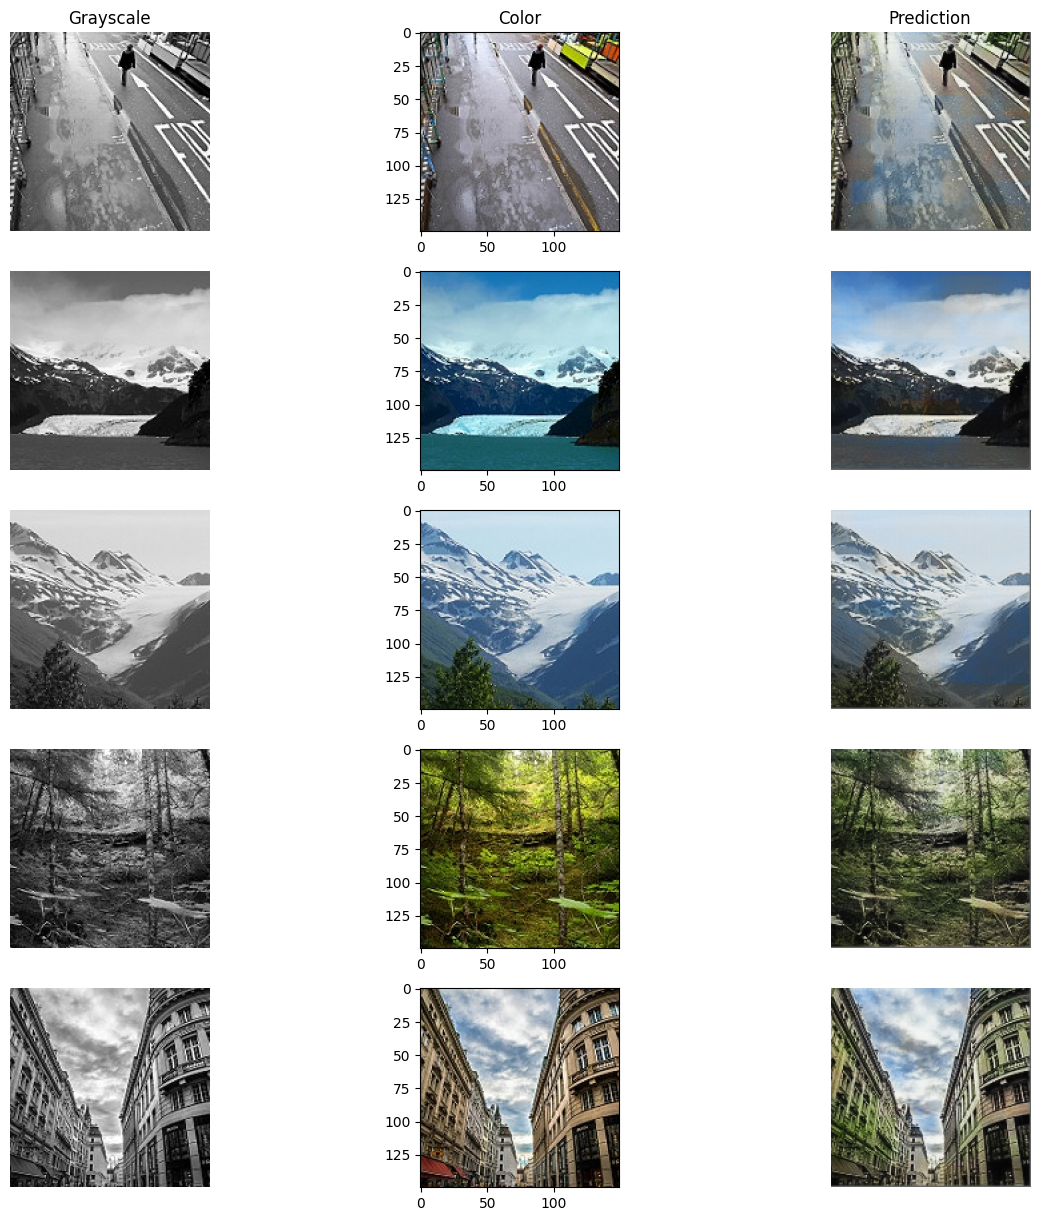

In [17]:
def show_prediction(color , gray , pred):
    fig , axs = plt.subplots(5 , 3 , figsize = (15 ,15))
    axs[0 , 0].set_title("Grayscale")
    axs[0 , 1].set_title("Color")
    axs[0 , 2].set_title("Prediction")
    for i in range(5):
        axs[i , 0].axis("off")
        axs[i , 0].imshow(gray[i].permute(1 , 2 , 0) , cmap = "gray")
        axs[i , 0].axis("off")
        axs[i , 1].imshow(color[i].permute(1 , 2, 0))
        axs[i , 2].axis("off")
        axs[i , 2].imshow(pred[i].permute(1 , 2 , 0))
    plt.show()

show_prediction(color_img.detach().cpu() , gray_img.detach().cpu() , prediction.detach().cpu())

Saving the model

In [18]:
torch.save(model.state_dict(), 'autoencoder_model.pth')
print("Model saved successfully as 'autoencoder_model.pth'")


Model saved successfully as 'autoencoder_model.pth'
